# Derive metallicity maps in souce plane

 - Produce a signal to noise image in source plane
 - Bin it (voronoi?)
 - Lense to image plane each bin individually and colvolve by the psf
 - Measure the flux in each bin by sum(flux_map * bin_source_plane) / sum(bin_source_plane)
 - Check the S/N ratio of the bins. Group bins together if the signal is too high


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from astropy import units as u
from astropy.nddata.utils import Cutout2D
from astropy import wcs
import glob
from reproject import reproject_interp, reproject_exact
# Cosmology
from astropy.cosmology import WMAP9 as cosmo

# Redshift of A370
z = 0.725

<IPython.core.display.Javascript object>


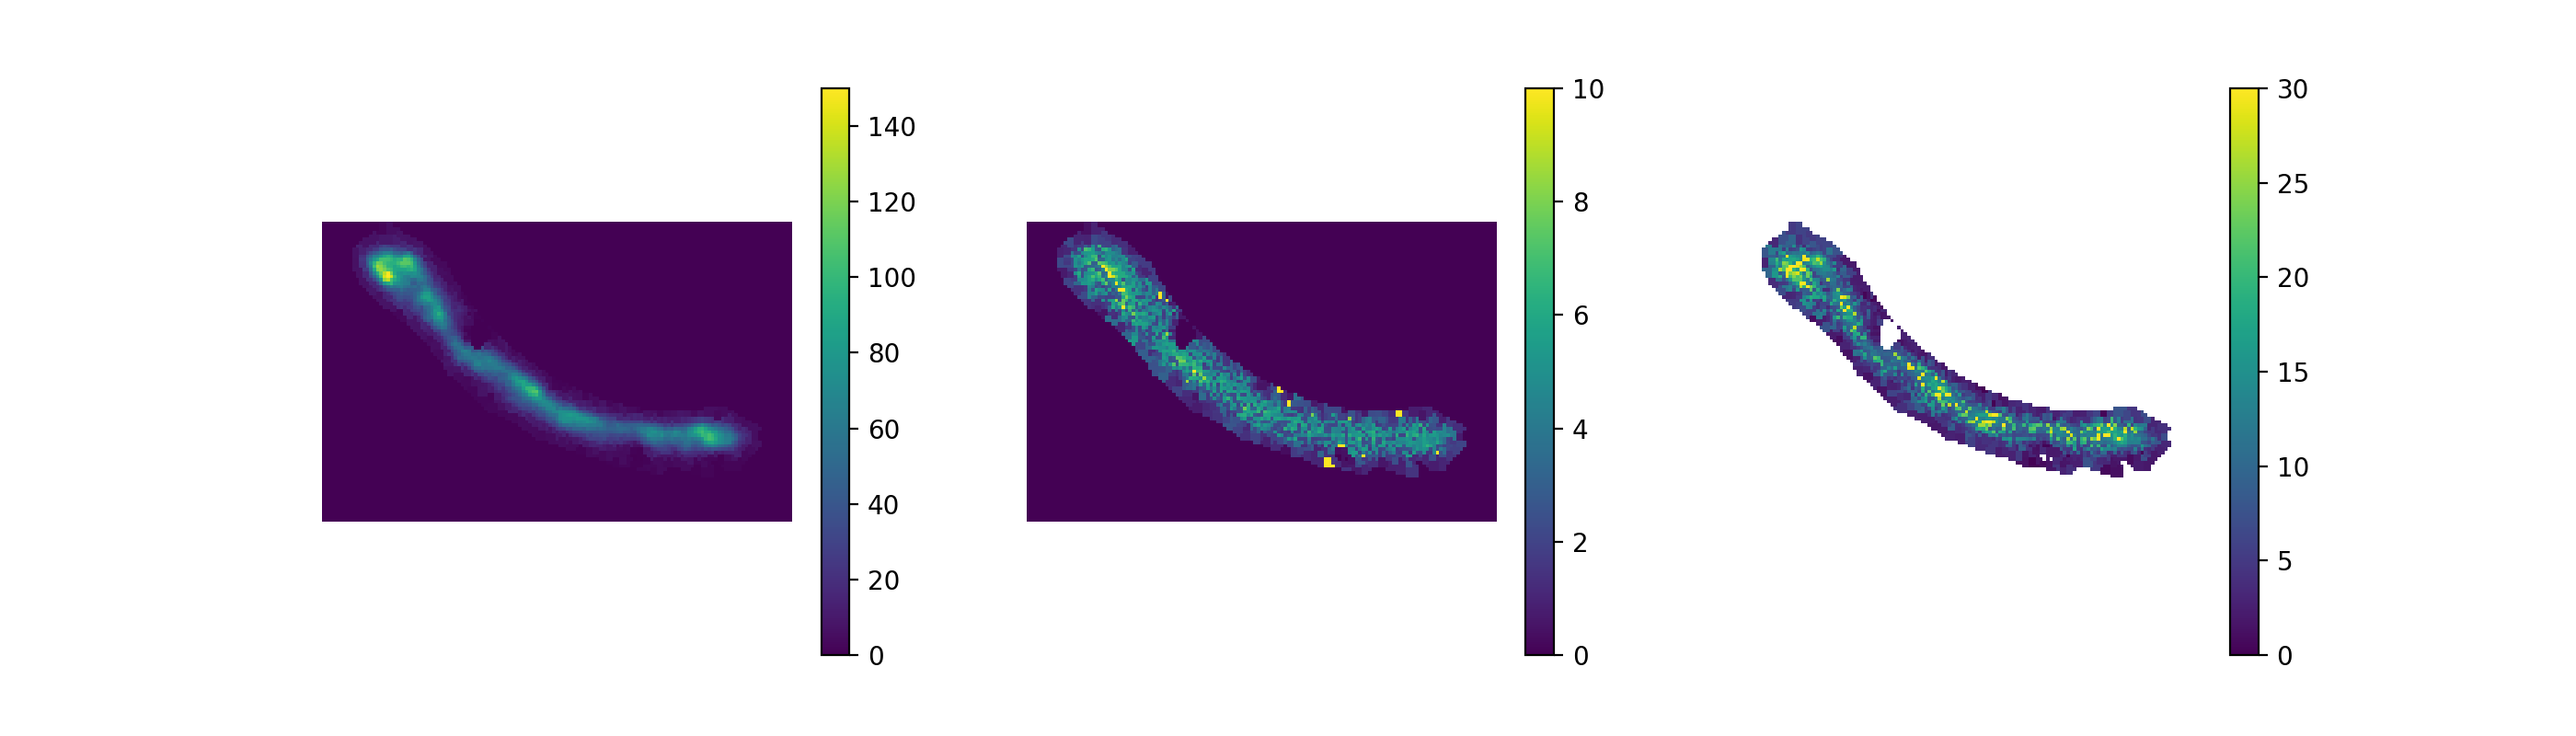

<IPython.core.display.Javascript object>


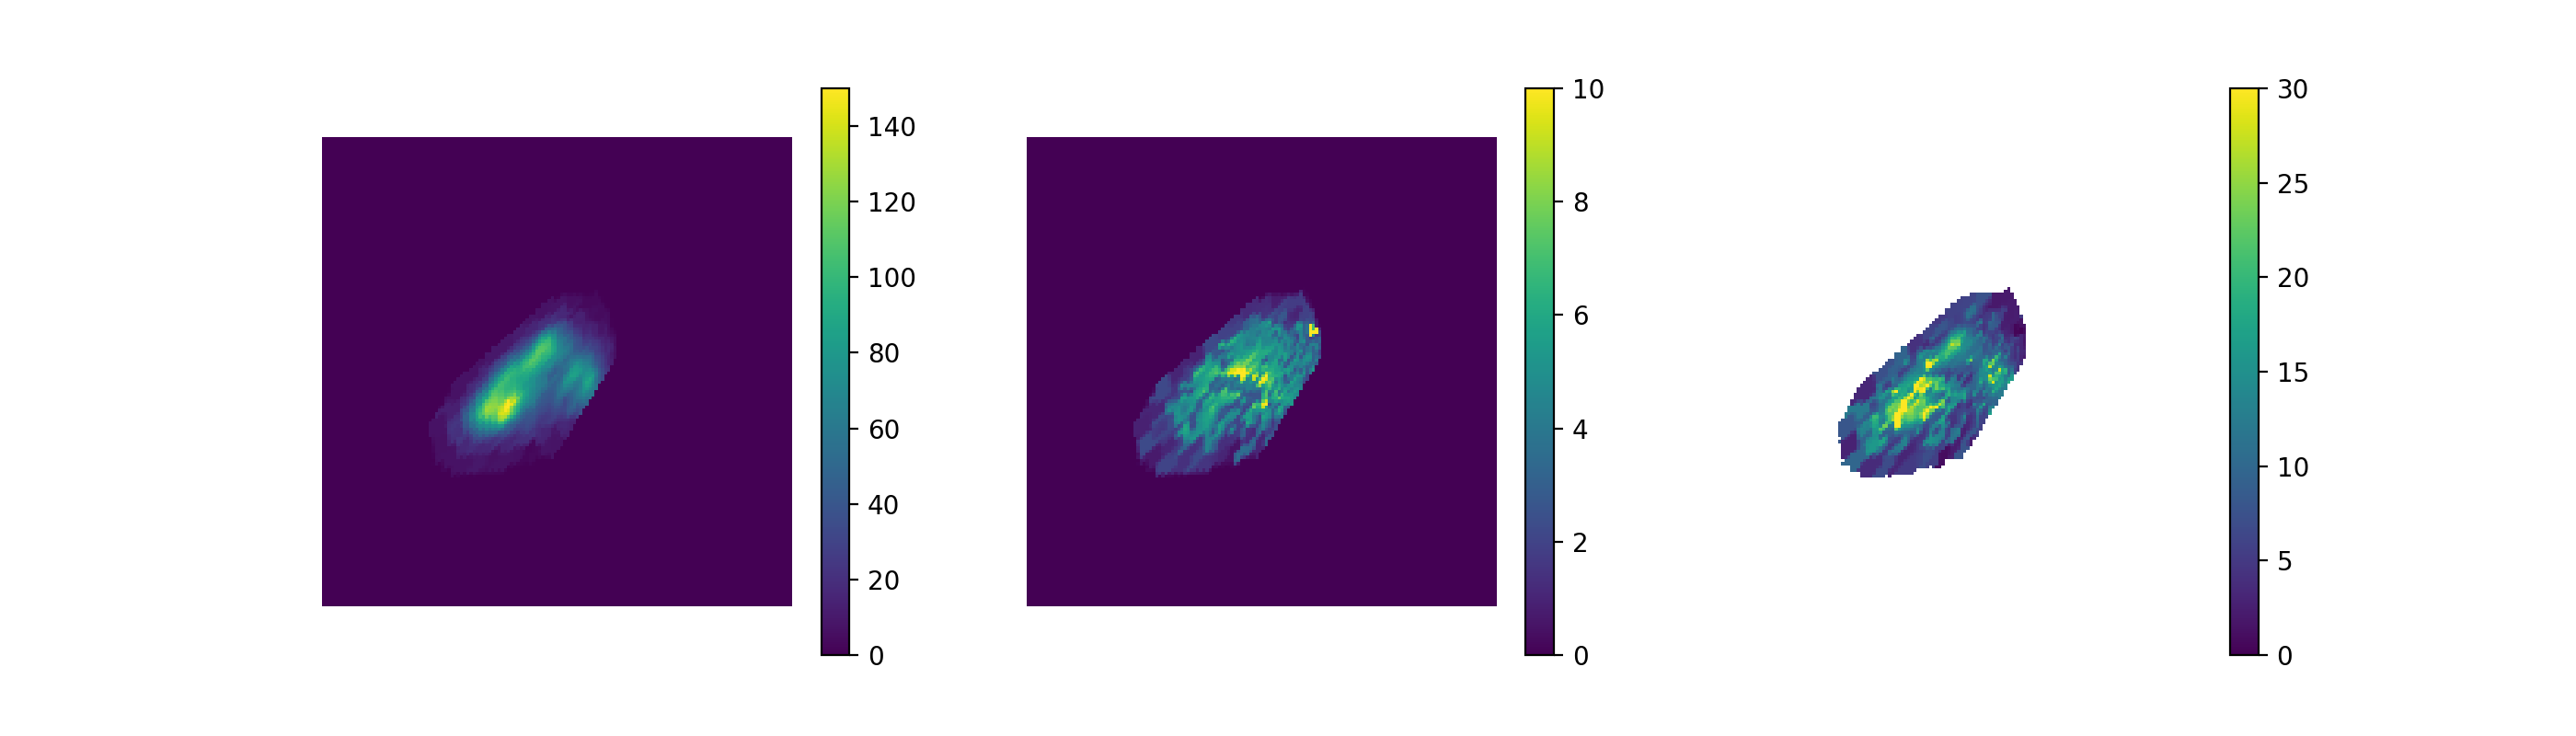

In [2]:
signal = fits.getdata('../Data/LensingModels/A370/A370_flux_indep_OII3729_ext1.fits')
err = fits.getdata('../Data/LensingModels/A370/A370_eflux_indep_OII3729_ext1.fits')

fig, ax = plt.subplots(1,3,figsize=(14,4))
[x.axis('off') for x in ax]

cax0 = ax[0].imshow(signal,origin='lower',vmin=0,vmax=150)
cax1 = ax[1].imshow(err,origin='lower',vmin=0,vmax=10)
cax2 = ax[2].imshow(signal/err,origin='lower',vmin=0,vmax=30)
for e,c in enumerate((cax0,cax1,cax2)):
    plt.colorbar(c,ax=ax[e])
    
    
signal = fits.getdata('../Data/LensingModels/A370/SourcePlane_A370_OII.fits')
err = fits.getdata('../Data/LensingModels/A370/SourcePlane_A370_OII_err.fits')

fig, ax = plt.subplots(1,3,figsize=(14,4))
[x.axis('off') for x in ax]

cax0 = ax[0].imshow(signal,origin='lower',vmin=0,vmax=150)
cax1 = ax[1].imshow(err,origin='lower',vmin=0,vmax=10)
cax2 = ax[2].imshow(signal/err,origin='lower',vmin=0,vmax=30)
for e,c in enumerate((cax0,cax1,cax2)):
    plt.colorbar(c,ax=ax[e])

## Bin data in signal to noise

In [3]:
from resolved_maps_tools import make_voronoi_tessalation_input,voronoi_tessalation

mask = np.zeros_like(signal)
mask[np.where(signal == 0)] = 1


make_voronoi_tessalation_input(signal=signal,noise=err,mask=mask, out_name='A370_oii_source_plane')

<IPython.core.display.Javascript object>


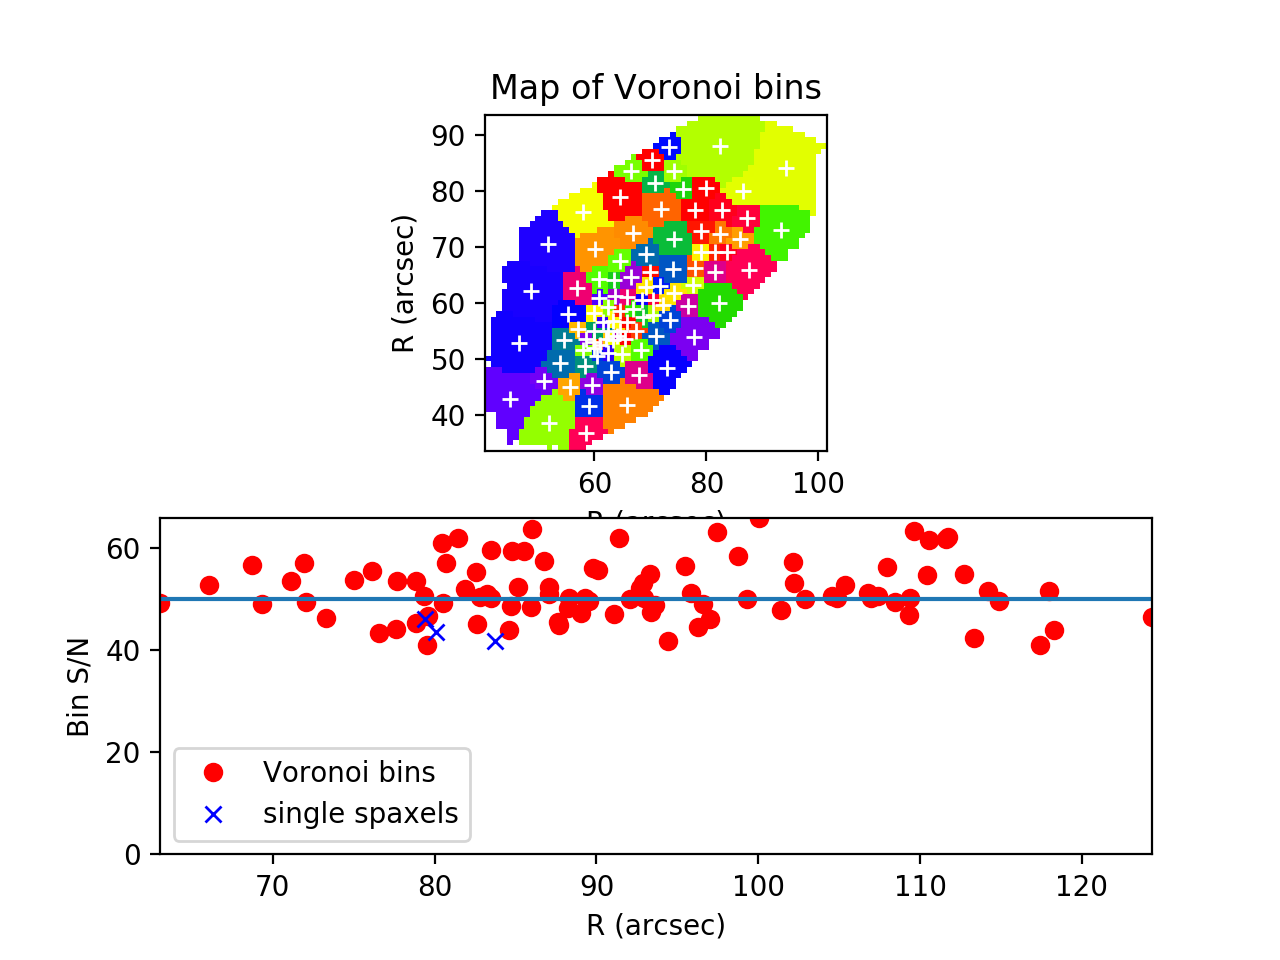

Tessalating  Signal_and_noise_A370_oii_source_plane.txt
Bin-accretion...
190  initial bins.
Reassign bad bins...
97  good bins.
Modified Lloyd algorithm...
16  iterations.
Unbinned pixels:  3  /  2215
Fractional S/N scatter (%): 11.280306462885948
Elapsed time: 0.41 seconds


In [4]:
plt.figure()
voronoi_tessalation(input_files='Signal_and_noise_A370_oii_source_plane.txt',targetSN = 50.0)

<IPython.core.display.Javascript object>


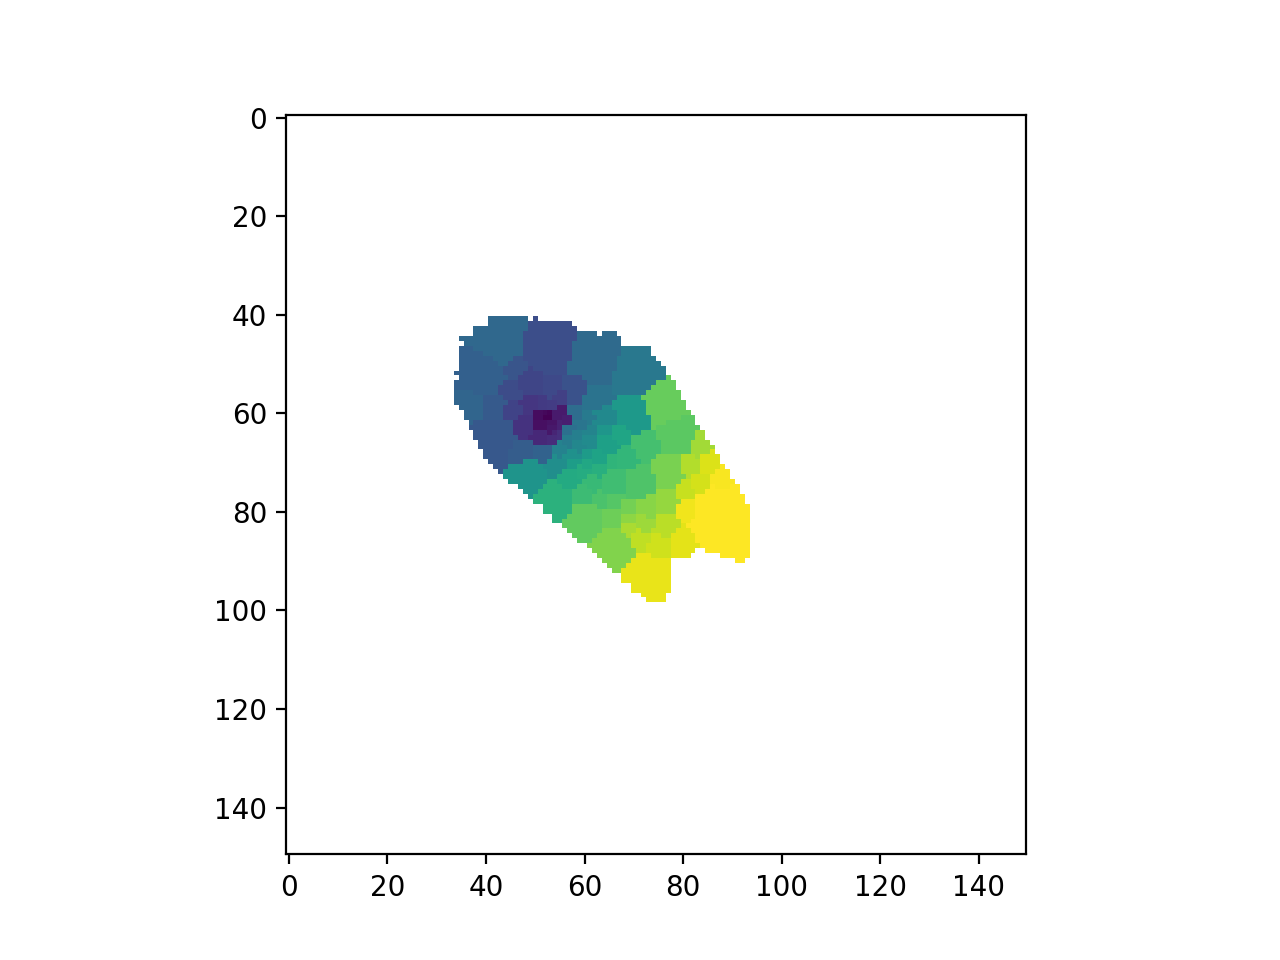

In [6]:
# Make map
header = fits.getheader('../Data/LensingModels/A370/SourcePlane_A370_OII.fits')
vbin_map = np.zeros_like(signal)
vbin_map[:,:] = np.nan

p, q, binNum = np.loadtxt('vor_SN_50.0_A370_oii_source_plane.txt', unpack=True,  
                          dtype={'names': ('p', 'q', 'binNum'),'formats': ('int16', 'int16', 'int16')})

for vbin in range(np.max(binNum)):
    temp_map = np.zeros_like(signal)
    pix = np.where(binNum==vbin)
    temp_map[[p[pix],q[pix]]] = 1
    vbin_map[[p[pix],q[pix]]] = vbin
    fits.writeto('a370_SN_sourceplane/bin_%d.fits'%vbin,data=temp_map,header=header)
    
plt.figure()
plt.imshow(vbin_map)
fits.writeto('a370_SN_sourceplane/full_bins.fits',data=vbin_map,header=header)

## Make masks

In [ ]:
grid = np.zeros_like(signal)


for q in range(0,cut_data.shape[0],d):
    for p in range(0,cut_data.shape[1],d):
        single_grid = np.zeros_like(cut_data)
        single_grid[q:q+d,p:p+d] = i
        grid[q:q+d,p:p+d] = i
        i += 1
        #fits.writeto('a370_grids/grid_A370_%d.fits'%i,data=single_grid,header=cut_header)

fig, ax = plt.subplots(1,1)
ax.imshow(grid)
fits.writeto('a370_grids/complete_grid_A370.fits',data=grid,header=cut_header)

## Lenstool 

prepare input files and run lenstool

In [8]:
# Lense all maps
par_file = open('../Data/LensingModels/A370/A370_simul.par')
lines = par_file.readlines()

files = glob.glob('a370_SN_sourceplane/*fits')
for f in files:
    f = f.split('a370_SN_sourceplane/')[1]
    lines[18] = '\tpixel 2 1000 ' + 'ImagePlane_' + f  +'\n'
    lines[33] = '\tsframe ' + f +'\n'

    outfile = open('a370_SN_sourceplane/'+f.replace('.fits','.par'),'w')
    for l in lines:
            outfile.write("%s" % l)
    outfile.close()

In [9]:
par_files = files = glob.glob('a370_SN_sourceplane/*par')
outfile = open('a370_SN_sourceplane/list','w')

for p in par_files:
    outfile.write('lenstool '+p+' -n\n')
outfile.close()

## Regrid to MUSE and convolve the image plane grid with the PSF

A370 psf: 0.70"

Image plane images resolution: 1.66833500166834E-05 deg/pix --> 0.06006006006 "/pix

PSF in pixels: 0.7/0.2 = 3.5 pix

In [14]:
muse_header = fits.getheader('/Users/vera/Arcs/A370/ExtractedData/Im_A370_mosaic_OII_ContSub_CMSub.fits',ext=1) # As the same orientation
image_plane = glob.glob('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_*.fits')
header = fits.getheader('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_0.fits')
kernel = Gaussian2DKernel(stddev=3.5)

for name in image_plane:
    print('Image',name,'of',len(image_plane))
    im = fits.open(name)
    im_aligned, footprint = reproject_interp(im, muse_header)
    conv_im = convolve(im_aligned, kernel)
    fits.writeto(name.replace('.fits','_convolved.fits'),data=conv_im,header=header)

('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_0.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_1.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_10.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_11.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_12.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_13.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_14.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_15.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_16.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_17.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_18.fits', 'of', 96)
('Image', 'a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_19.fits', 'of', 96)
('Imag

### Some plots and align with MUSE data

<IPython.core.display.Javascript object>


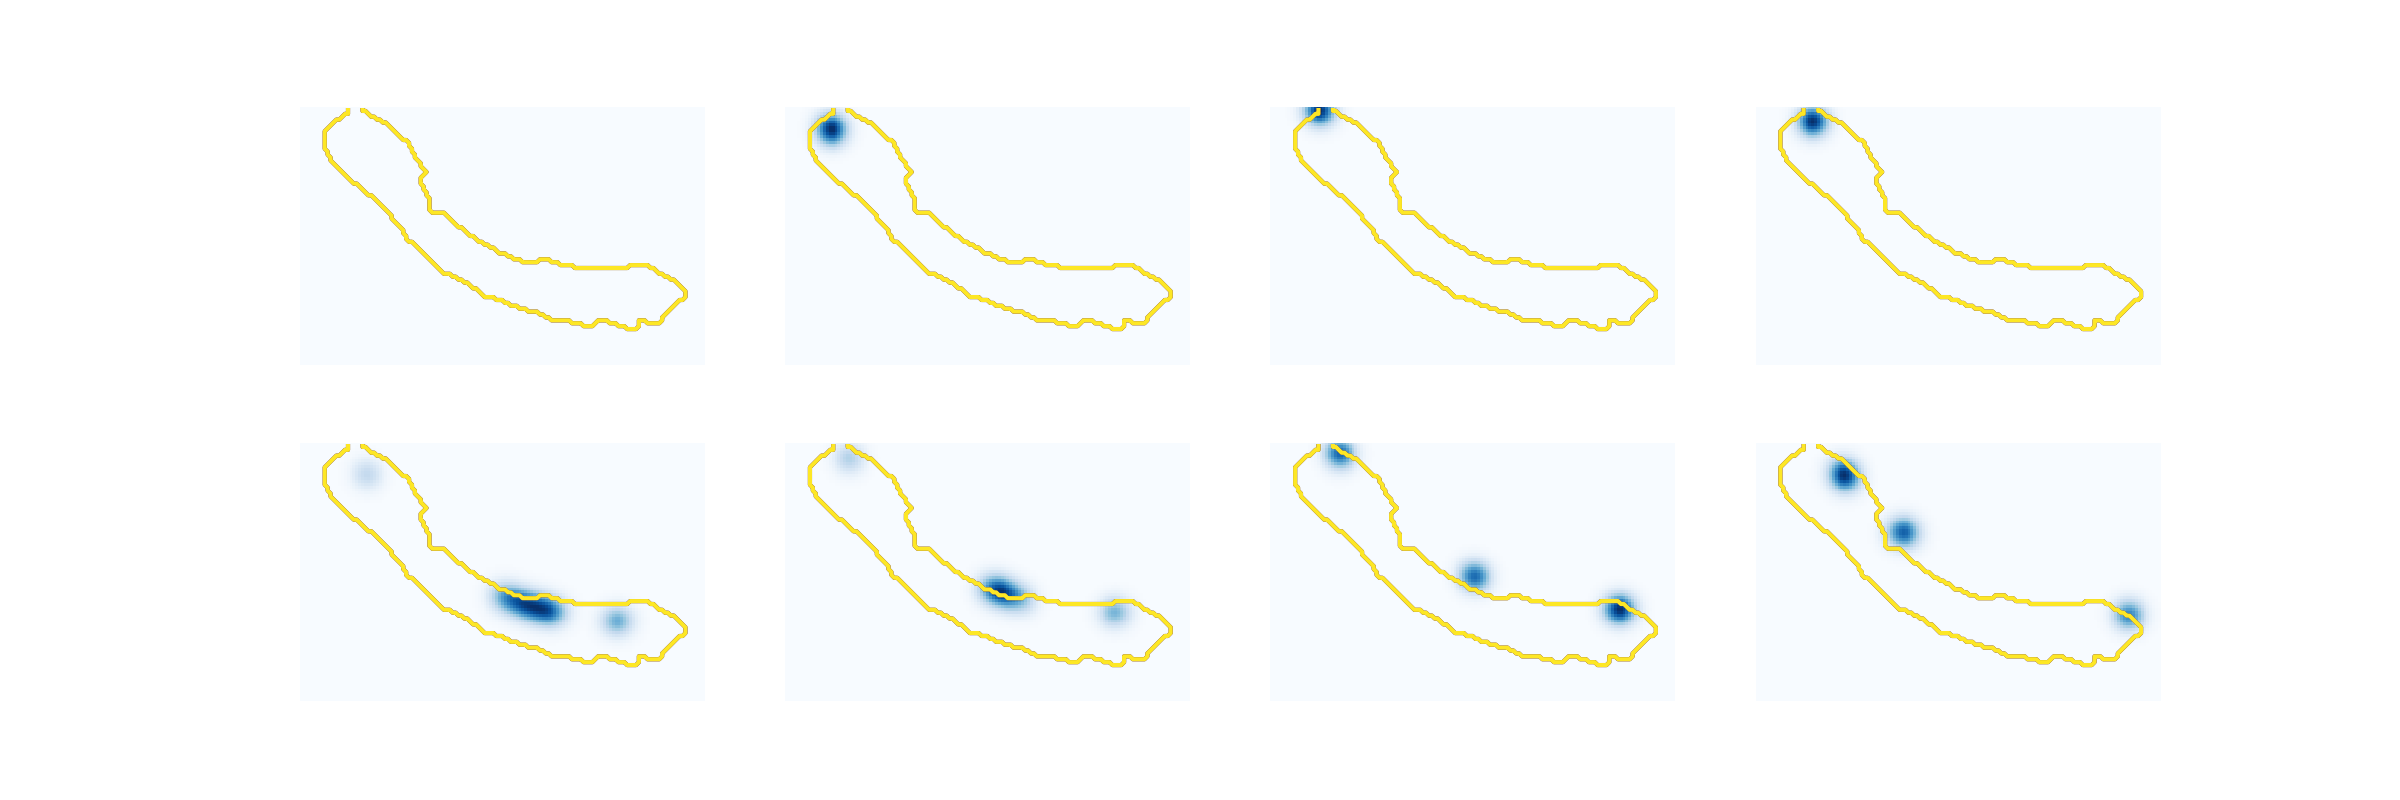

In [15]:
# MUSE data
muse = fits.open('../MeasureLines/A370_ContSub_flux_common_OII3726.fits')

# Convolved Bins
im1 = fits.getdata('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_10_convolved.fits')
im2 = fits.getdata('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_20_convolved.fits')
im3 = fits.getdata('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_30_convolved.fits')
im4 = fits.getdata('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_40_convolved.fits')
im5 = fits.getdata('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_50_convolved.fits')
im6 = fits.getdata('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_60_convolved.fits')
im7 = fits.getdata('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_70_convolved.fits')
im8 = fits.getdata('a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_80_convolved.fits')

fig, ax = plt.subplots(2,4,figsize=(12,4))
ax = ax.ravel()
ax[0].imshow(im1,origin='lower',cmap=plt.cm.Blues)
ax[1].imshow(im2,origin='lower',cmap=plt.cm.Blues)
ax[2].imshow(im3,origin='lower',cmap=plt.cm.Blues)
ax[3].imshow(im4,origin='lower',cmap=plt.cm.Blues)
ax[4].imshow(im5,origin='lower',cmap=plt.cm.Blues)
ax[5].imshow(im6,origin='lower',cmap=plt.cm.Blues)
ax[6].imshow(im7,origin='lower',cmap=plt.cm.Blues)
ax[7].imshow(im8,origin='lower',cmap=plt.cm.Blues)

for x in ax:
    x.axis('off')
    x.contour(muse[0].data,levels=[0.03,0.05])


## Measure emission lines inside these regions

There are two strategies:

    - make the maps and then measure the flux in the maps
    - extract spectra in these apertures and measure the emission lines in these spectra
    

### Extract spectra in the apertures (weighed by seeing)

We save them in rest-frame to use ALFA and pPXF without worring about the redshift too much.

In [19]:
## Extract spectra in the cube
aperture_list = glob.glob("a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_*_convolved.fits")
cube = fits.getdata('../Data/Cubes/SmallCube_A370_mosaic_CMSub.fits')
cube_header = fits.getheader('../Data/Cubes/SmallCube_A370_mosaic_CMSub.fits',ext=1)

# prepare header
prihdr_MUSE = fits.Header()
prihdr_MUSE['NAXIS1']=  cube_header['NAXIS3']
prihdr_MUSE['CRVAL1'] = cube_header['CRVAL3']/(z+1)
prihdr_MUSE['CRPIX1'] = 1
prihdr_MUSE['CDELT1'] = cube_header['CD3_3']/(z+1)
prihdr_MUSE['CUNIT1']= 'Angstrom'

for f in aperture_list:
    print(f)
    aperture = fits.getdata(f)
    weighted_cube = cube*aperture
    sp = np.sum(weighted_cube,axis=(1,2))
    fits.writeto(f.replace('ImagePlaneImages/ImagePlane','SpectraConvolved/Spectra'),data=sp*(z+1),header=prihdr_MUSE,output_verify='fix')

a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_0_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_10_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_11_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_12_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_13_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_14_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_15_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_16_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_17_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_18_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_19_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_1_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_20_convolved.fits
a370_SN_sourceplane/ImagePlaneImages/ImagePlane_bin_21_convolved.fits
a370_SN_sourceplane/Im

# Fit with pPXF

This is a simple fit, only to remove the continuum, not to actually measure the properties of the continuum. ALFA also fits the continuum, so pPXF is mainly used to remove the balmer absoptions

PREPARE YOURSELVES FOR SOME UGLY CODE!

In [23]:
import ppxf_util 

def prepare_stellar_libraries(dummyfile='a370_SN_sourceplane/SpectraConvolved/Spectra_bin_0_convolved.fits'):
    
    ## Observed Spectrum
    h1 = fits.getheader(dummyfile)
    gal_lin = fits.getdata(dummyfile)
    lamRange_gal = h1['CRVAL1'] + np.array([0.,h1['CDELT1']*(h1['NAXIS1']-1)])
    FWHM_gal = 2.5/(1+0.725) ## In Angstrom

    ## Convert to logscale
    galaxy, logLam_gal, velscale = ppxf_util.log_rebin(lamRange_gal, gal_lin)

    ## Template library : Indo-US
    temp_list = '/Users/vera/SpectralLibraries/Indo-US/TEXT/INDO-US_model_list_no_gaps.txt'
    temp_dir = '/Users/vera/SpectralLibraries/Indo-US/TEXT/'
    (models,met,age) = np.loadtxt(temp_list,skiprows=1,unpack=True,\
                    dtype=[('file','S30'),('FeH','f4'),('Teff','f4')])
    FWHM_temp = 1.35 # template resolution 
    (lbd,star_spec) = np.loadtxt(temp_dir+models[0],skiprows=31,unpack=True)
    lamRange_temp = [lbd[0],lbd[-1]]
    starNew, logLam_temp, velscale = ppxf_util .log_rebin(lamRange_temp, star_spec, velscale=velscale)
    if FWHM_gal > FWHM_temp:
        FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_temp**2)
        sigma = FWHM_dif/2.355/(lbd[1]-lbd[0]) # Sigma difference in pixels
    else:
        sigma = 1e-20
        print('Observation resolution higher than model')

    dv = (logLam_temp[0]-logLam_gal[0])*299792.458 # km/s
        
    star_temp = np.empty((starNew.size,len(models)))
    for j, file in enumerate(models):
            (lbd,spec) = np.loadtxt(temp_dir+file,skiprows=0,unpack=True)
            spec = ndimage.gaussian_filter1d(spec,sigma)
            sspNew, logLam_temp, velscale = ppxf_util.log_rebin(lamRange_temp, spec,velscale=velscale)
            star_temp[:,j] = sspNew/np.median(sspNew) # Normalizes templates

    ## Mask. Use ppxf routine to calculate good pixels')
    goodpixels = ppxf_util.determine_goodpixels(logLam_gal, lamRange_temp, 0)

    return star_temp, velscale, goodpixels, lamRange_gal, dv 

In [27]:
# Prepare spectral libraries
from ppxf import ppxf

star_temp, velscale, goodpixels, lamrange_gal, dv = prepare_stellar_libraries()
FWHM_gal = 2.5/(1+0.725) ## In Angstrom
h1 = fits.getheader('a370_SN_sourceplane/SpectraConvolved/Spectra_bin_0_convolved.fits')
wave_original = np.arange(h1['CRVAL1'],h1['CRVAL1']+h1['CDELT1']*h1['NAXIS1'],h1['CDELT1'])


for s in glob.glob('a370_SN_sourceplane/SpectraConvolved/Spectra_bin_*_convolved.fits'):
    
    print('Fitting: %s'%s)

    # Prepare input spectra
    h1= fits.getheader(s)
    gal_lin = fits.getdata(s)

    # Put in in logscale
    galaxy, logLam_gal, velscale = ppxf_util.log_rebin(lamrange_gal, gal_lin)
    norm = np.median(galaxy)
    galaxy /= norm # Normalize spectrum to avoid numerical issues
    noise = np.ones_like(galaxy)

    ## Fit
    start = [0,180]
    try:
        pp = ppxf(star_temp, galaxy, noise, velscale, start, goodpixels, vsyst=dv,clean=True,plot=False,quiet=True)
    except ValueError:
        print('Not fitted')
        pass
        
    print('Velocity and dispersion: %s'%pp.sol)
   
    ## Return the solution to the same wavelenght and flux as before
    wave = np.exp(logLam_gal)#This has a different step than the original
    wave_origin = np.arange(h1['CRVAL1'],h1['CRVAL1']+h1['CDELT1']*h1['NAXIS1'],h1['CDELT1'])
    continuum = pp.bestfit*norm
    
    ## Interpolate solution to be able to subtract it to the original spectrum
    continuum_interp = np.interp(wave_origin,wave,continuum,left=0,right=0)
    contsub = gal_lin - continuum_interp

    fits.writeto(s.replace('SpectraConvolved','SpectraContinuumSub').replace('convolved','continuum_subtracted'),data=contsub,header = h1)

Fitting: a370_SN_sourceplane/SpectraConvolved/Spectra_bin_0_convolved.fits
Velocity and dispersion: [-55.44836526 359.41804617]
Fitting: a370_SN_sourceplane/SpectraConvolved/Spectra_bin_10_convolved.fits
Not fitted
Velocity and dispersion: [-55.44836526 359.41804617]
Fitting: a370_SN_sourceplane/SpectraConvolved/Spectra_bin_11_convolved.fits
Velocity and dispersion: [-147.19215233  202.46868638]
Fitting: a370_SN_sourceplane/SpectraConvolved/Spectra_bin_12_convolved.fits
Velocity and dispersion: [-112.1431669   247.88097669]
Fitting: a370_SN_sourceplane/SpectraConvolved/Spectra_bin_13_convolved.fits
Velocity and dispersion: [-25.72753089 361.51391383]
Fitting: a370_SN_sourceplane/SpectraConvolved/Spectra_bin_14_convolved.fits
Velocity and dispersion: [-139.07023049  183.74775777]
Fitting: a370_SN_sourceplane/SpectraConvolved/Spectra_bin_15_convolved.fits
Velocity and dispersion: [-109.787104    266.94634341]
Fitting: a370_SN_sourceplane/SpectraConvolved/Spectra_bin_16_convolved.fits
Vel

## Print to pdf

a370_SN_sourceplane/alfa_fits/Spectra_bin_0_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


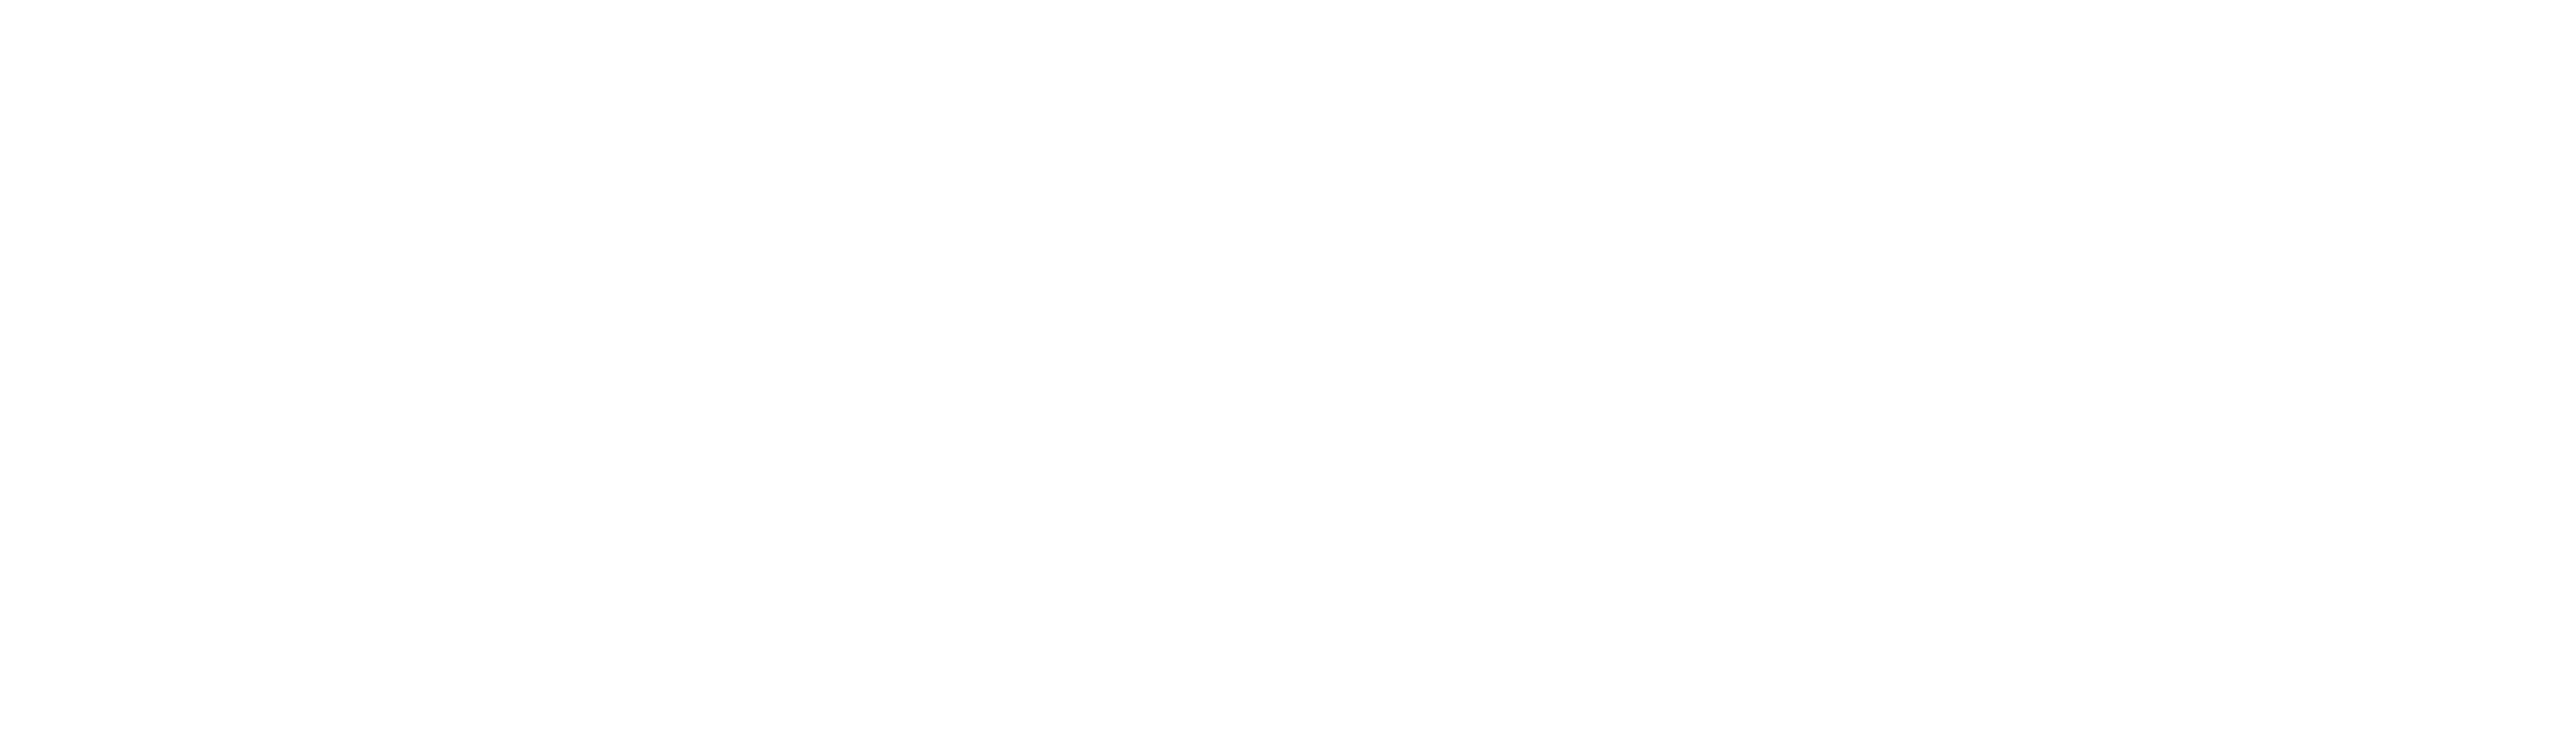

a370_SN_sourceplane/alfa_fits/Spectra_bin_10_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


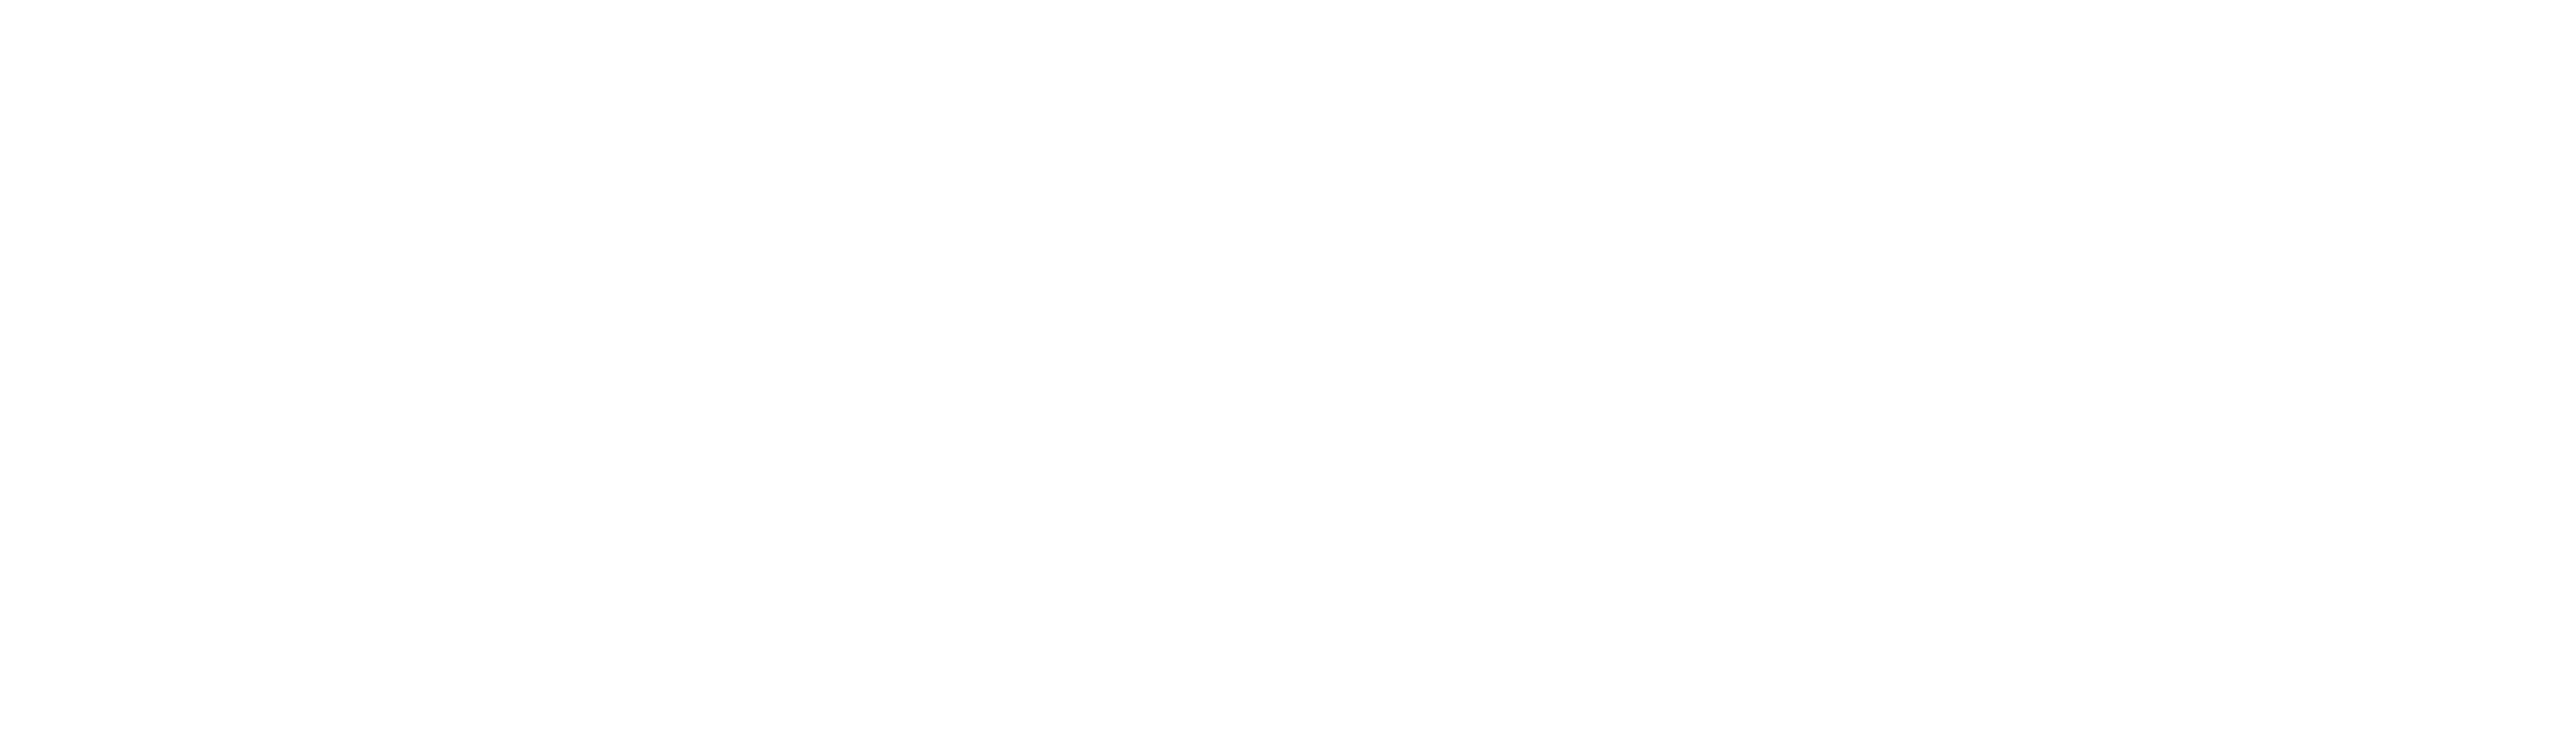

a370_SN_sourceplane/alfa_fits/Spectra_bin_11_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


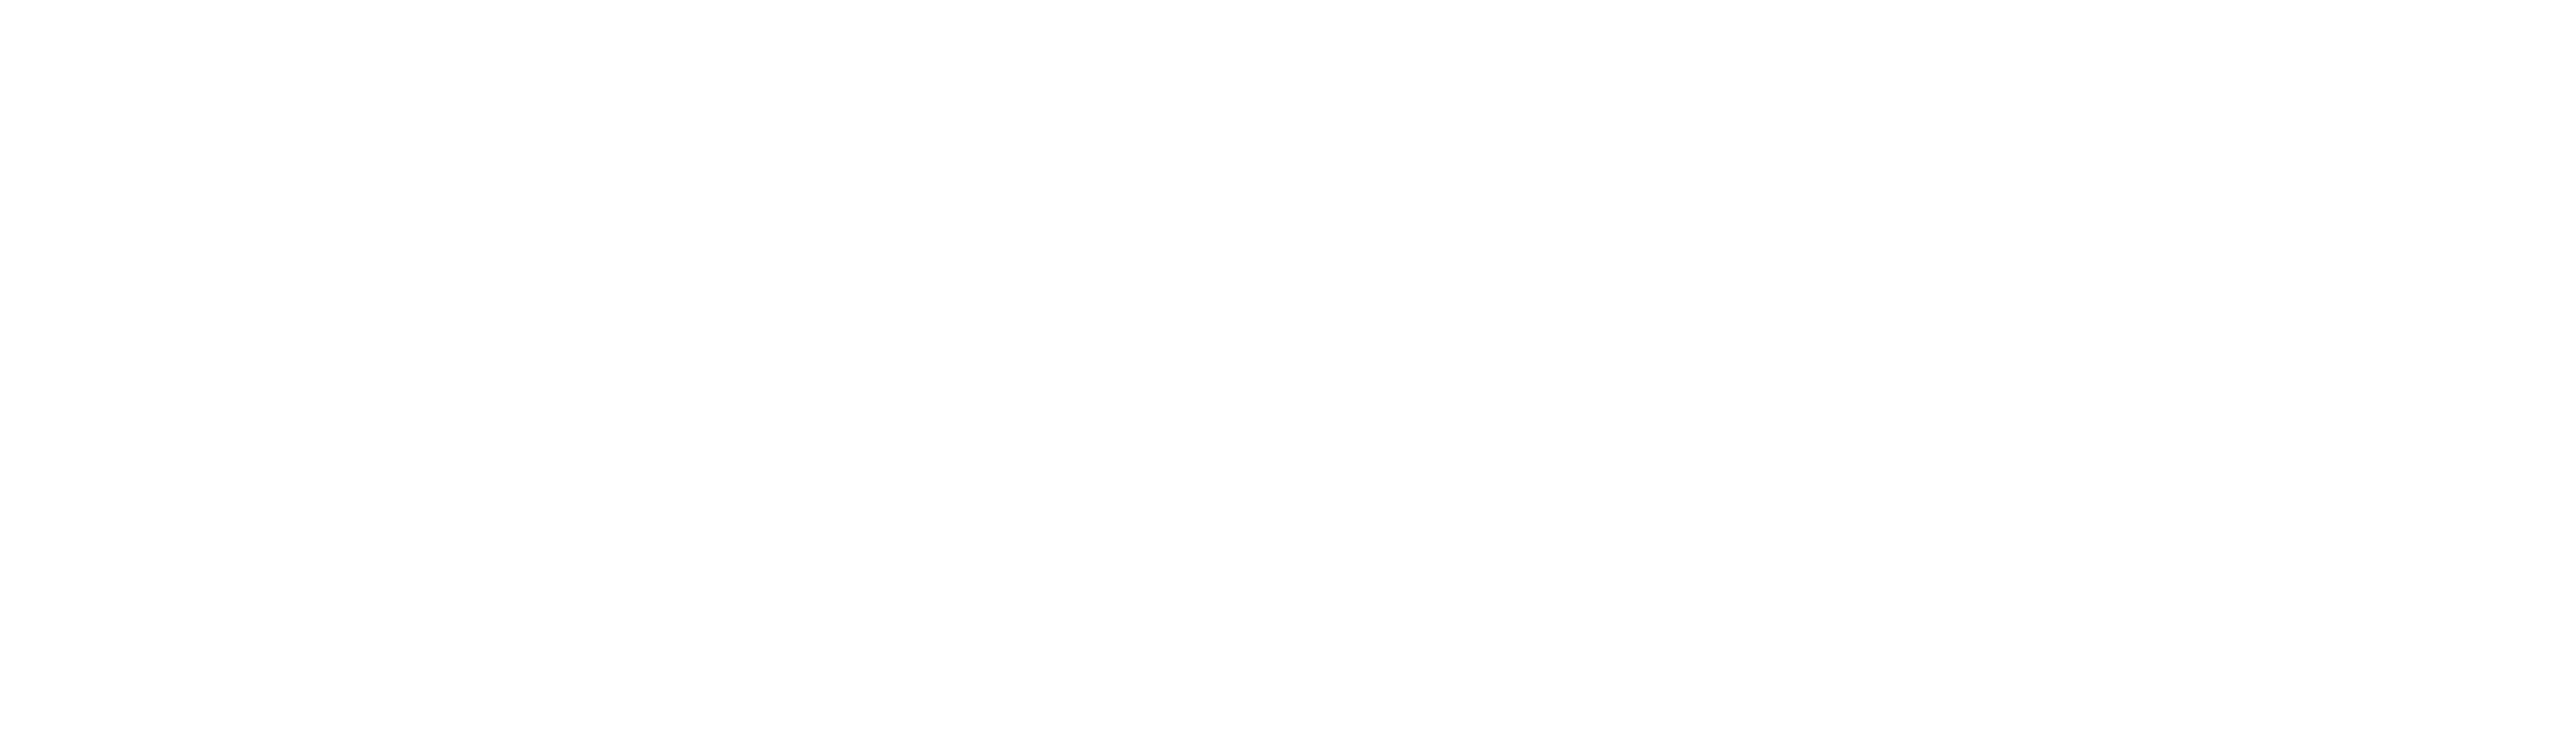

a370_SN_sourceplane/alfa_fits/Spectra_bin_12_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


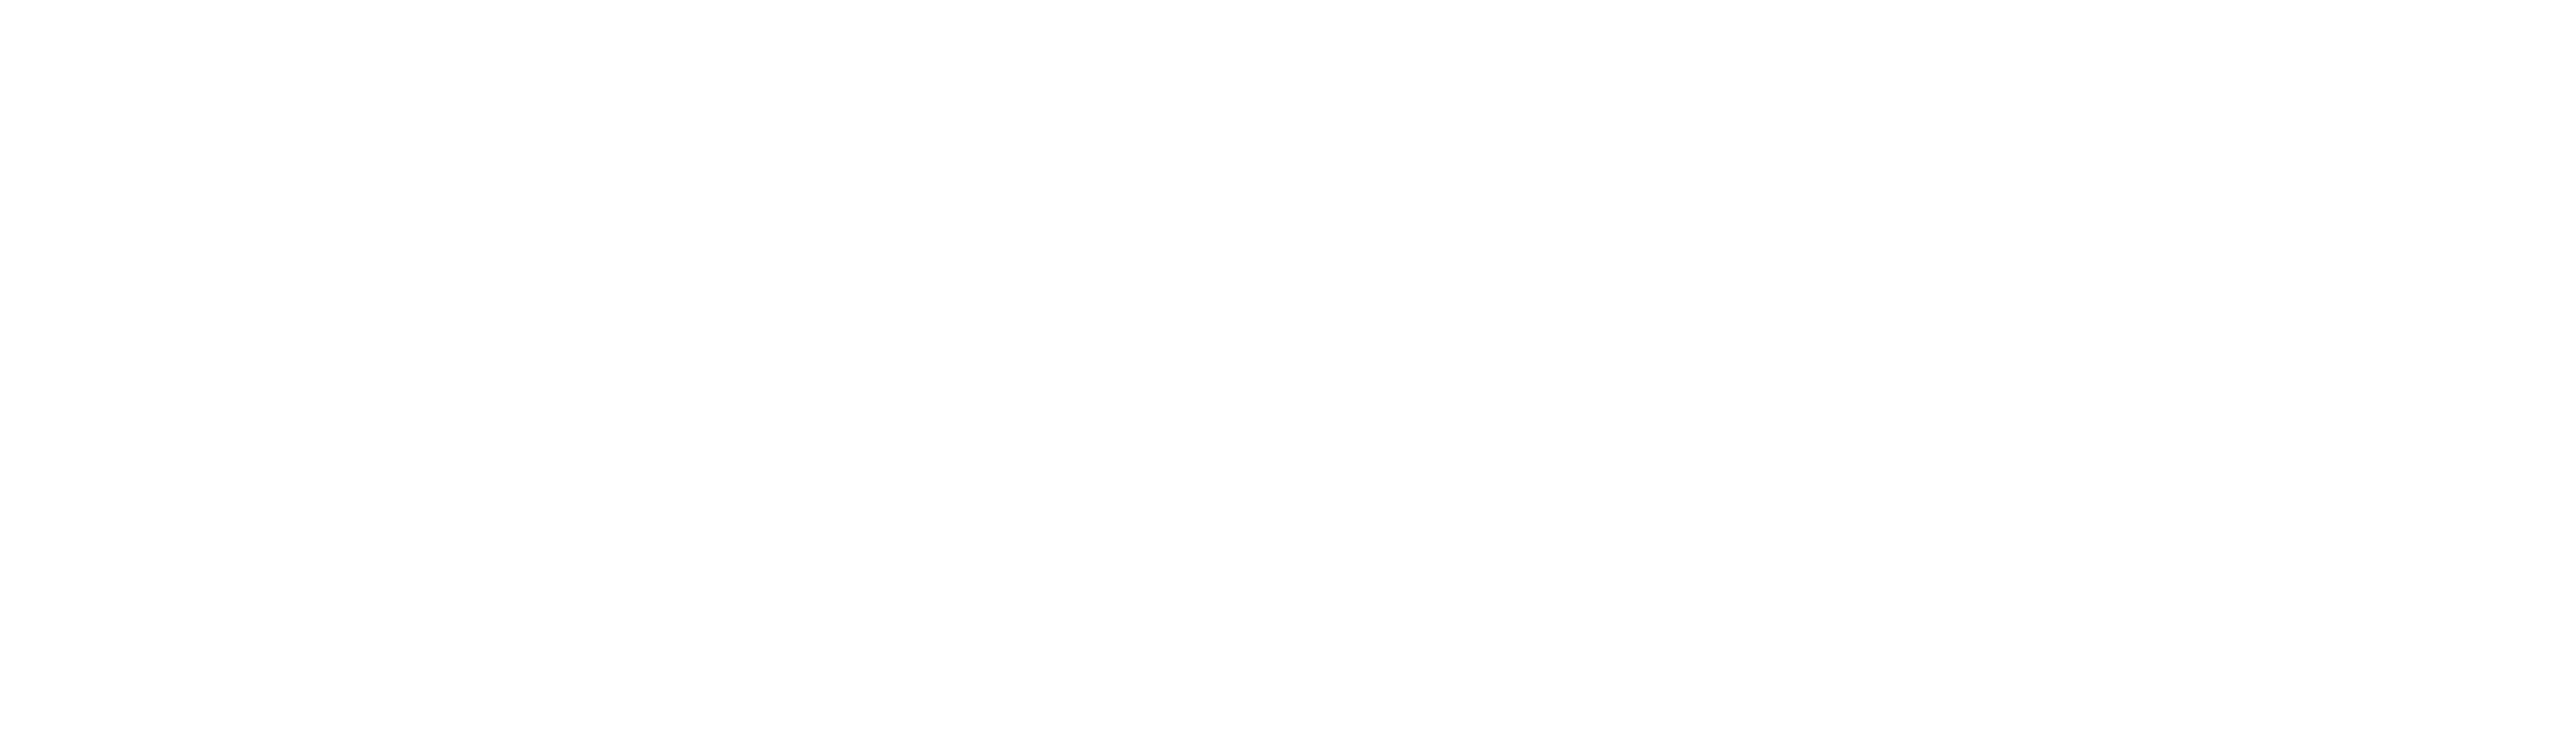

a370_SN_sourceplane/alfa_fits/Spectra_bin_13_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


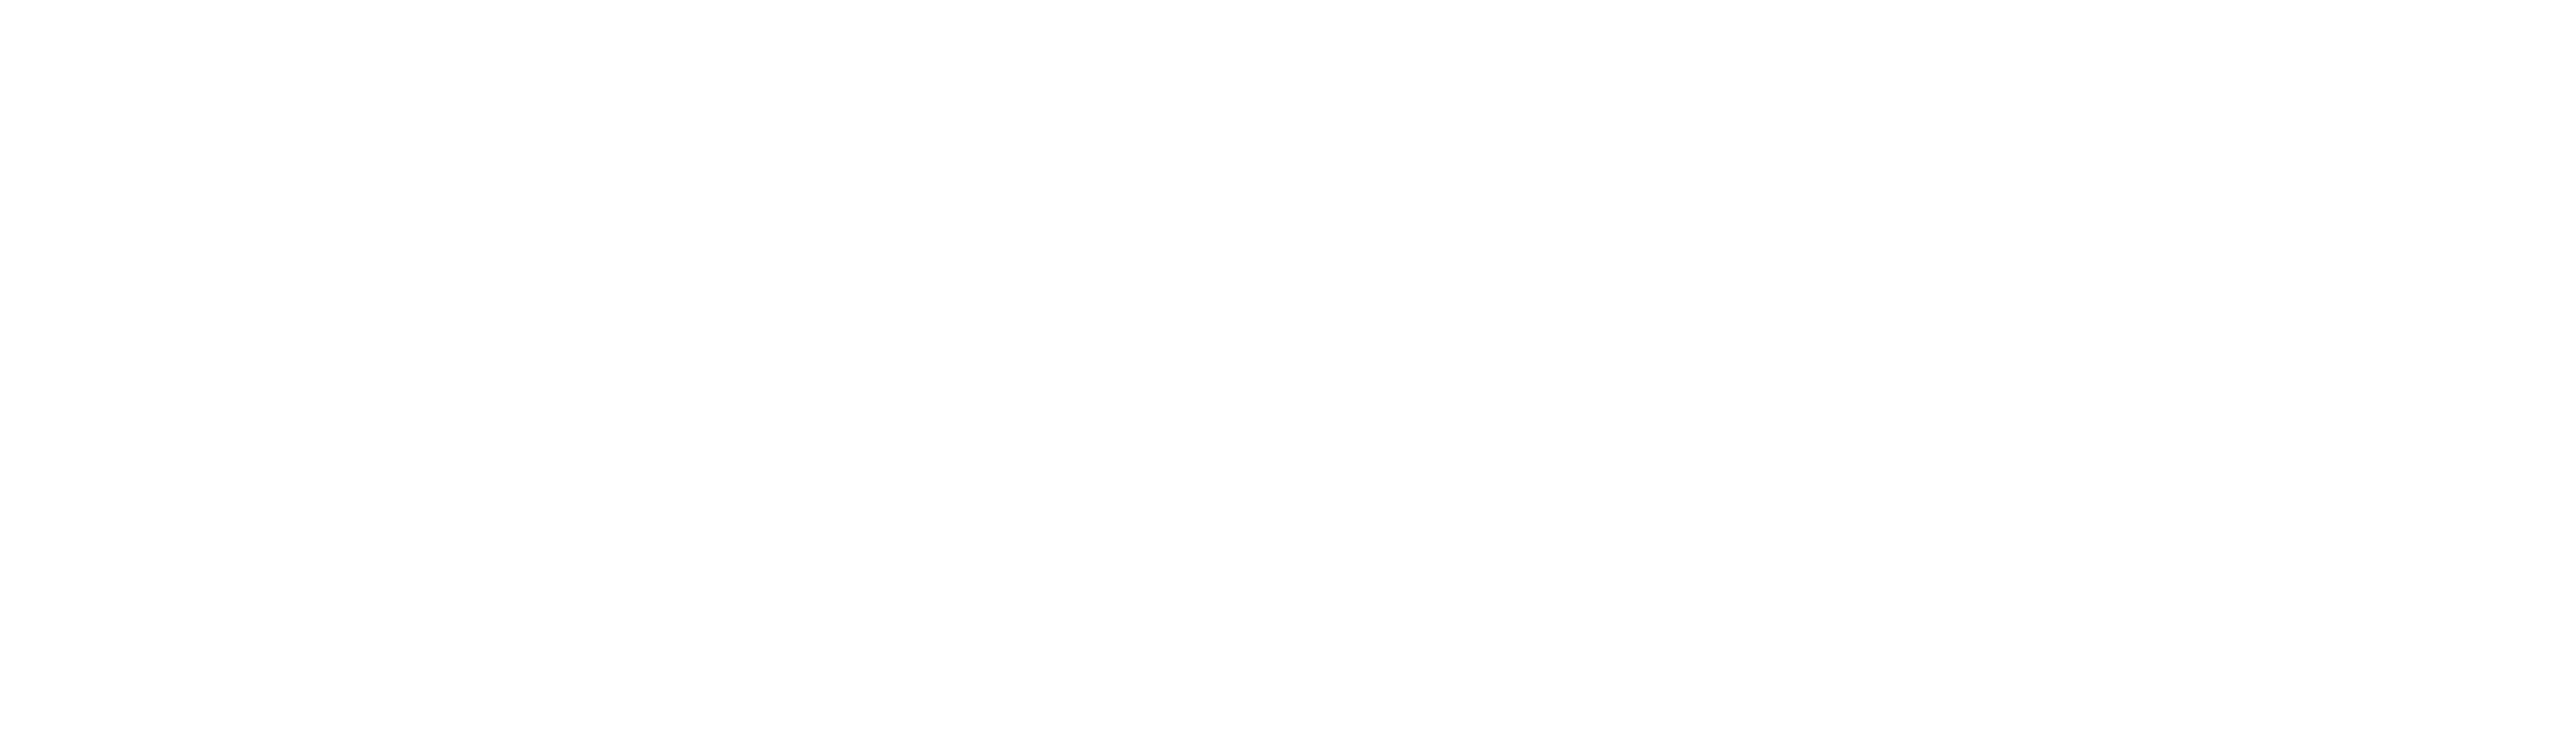

a370_SN_sourceplane/alfa_fits/Spectra_bin_14_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


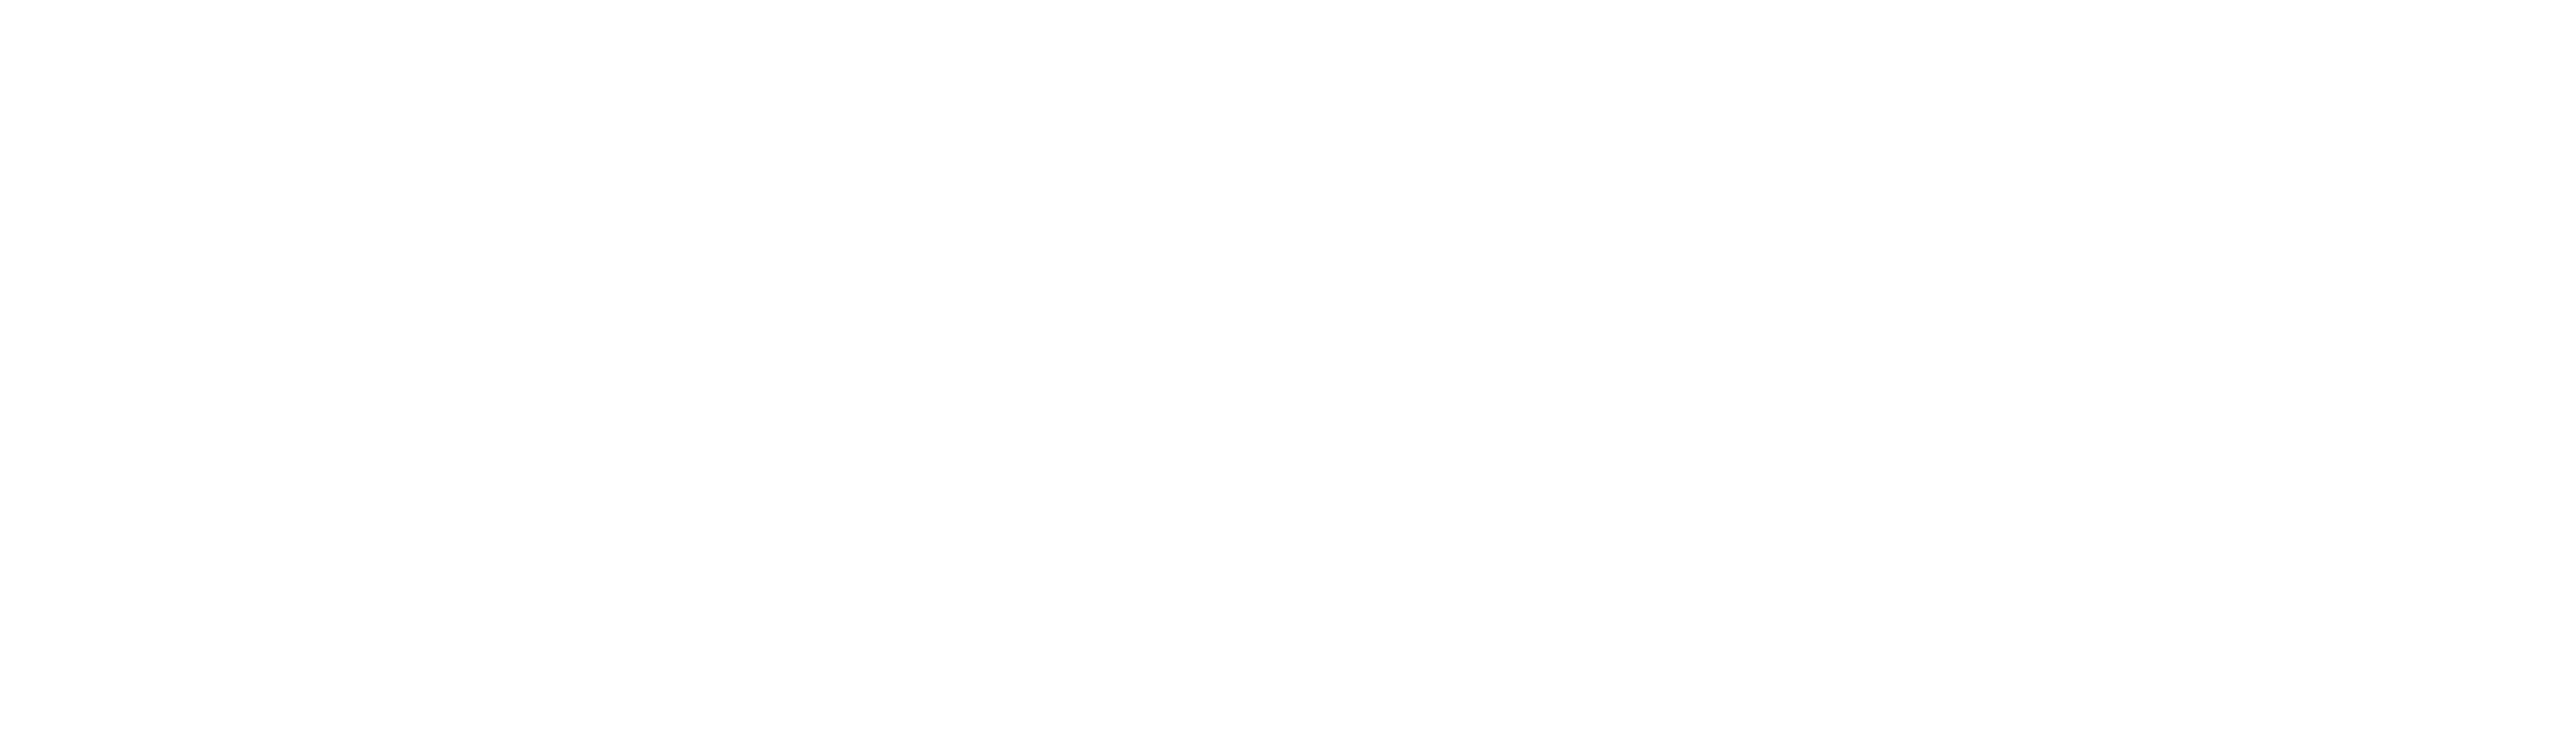

a370_SN_sourceplane/alfa_fits/Spectra_bin_15_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


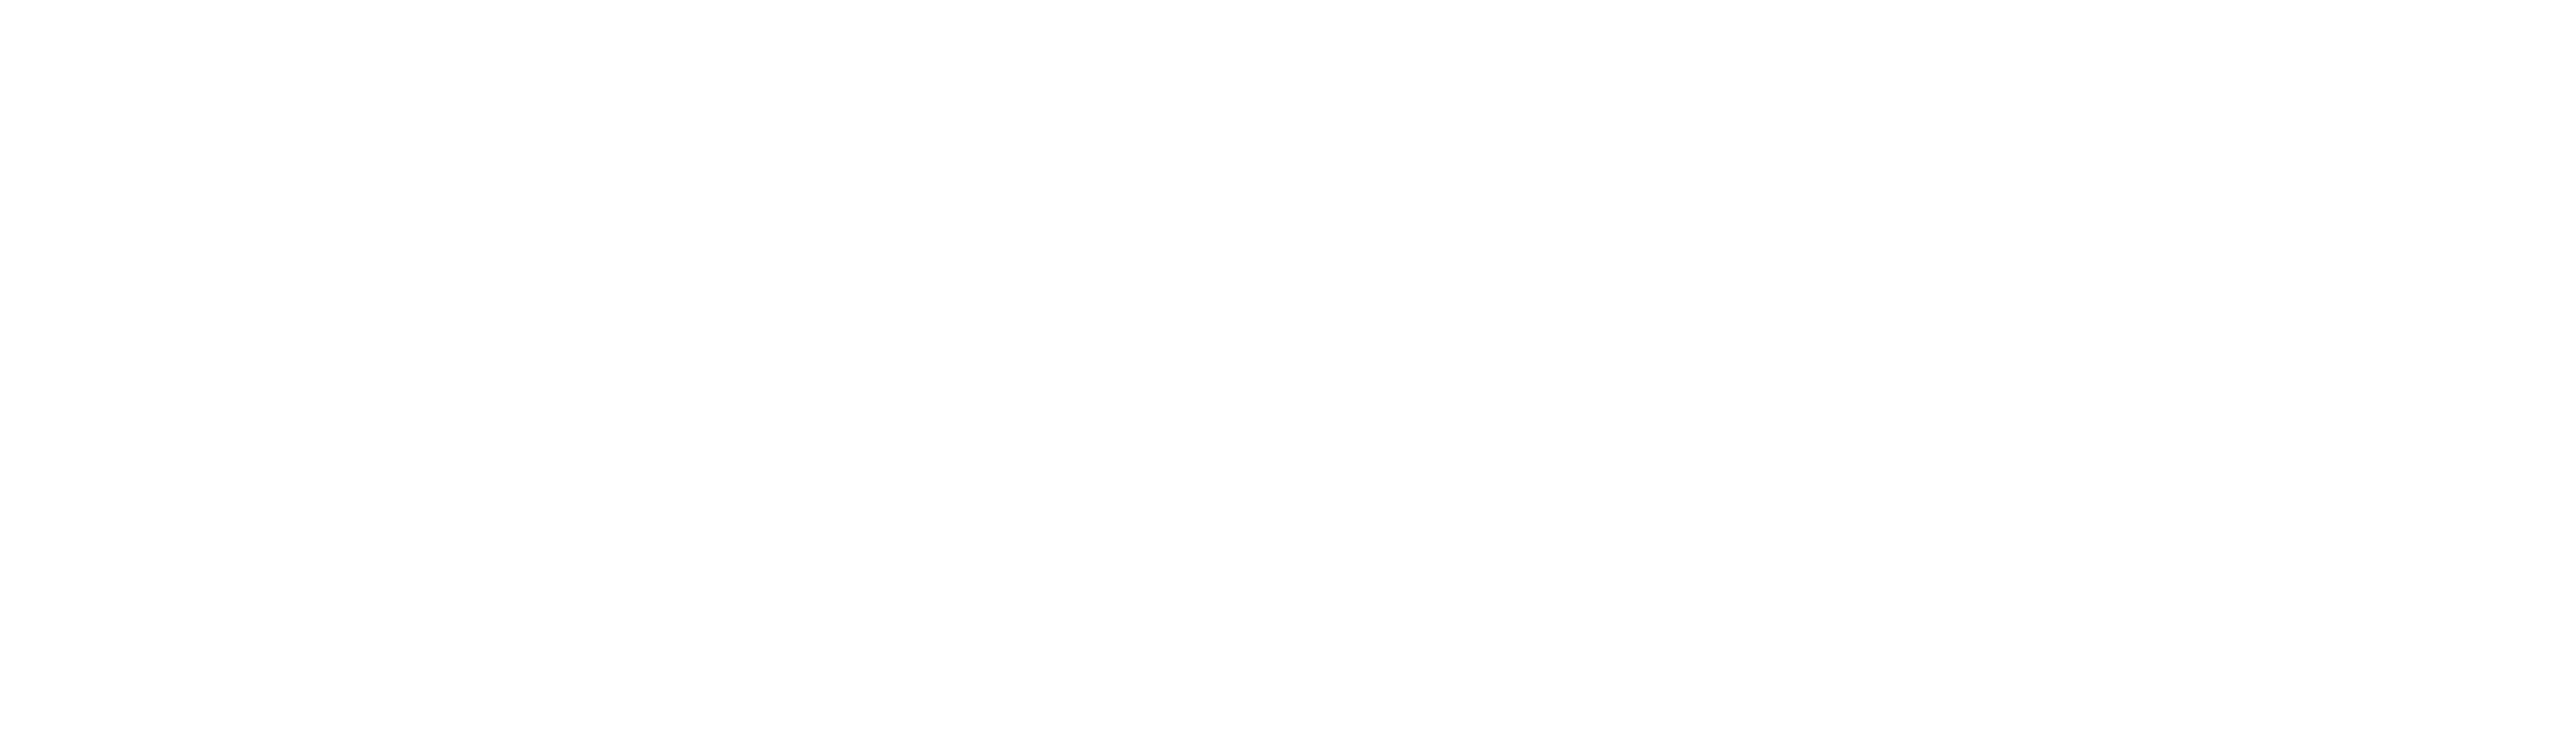

a370_SN_sourceplane/alfa_fits/Spectra_bin_16_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


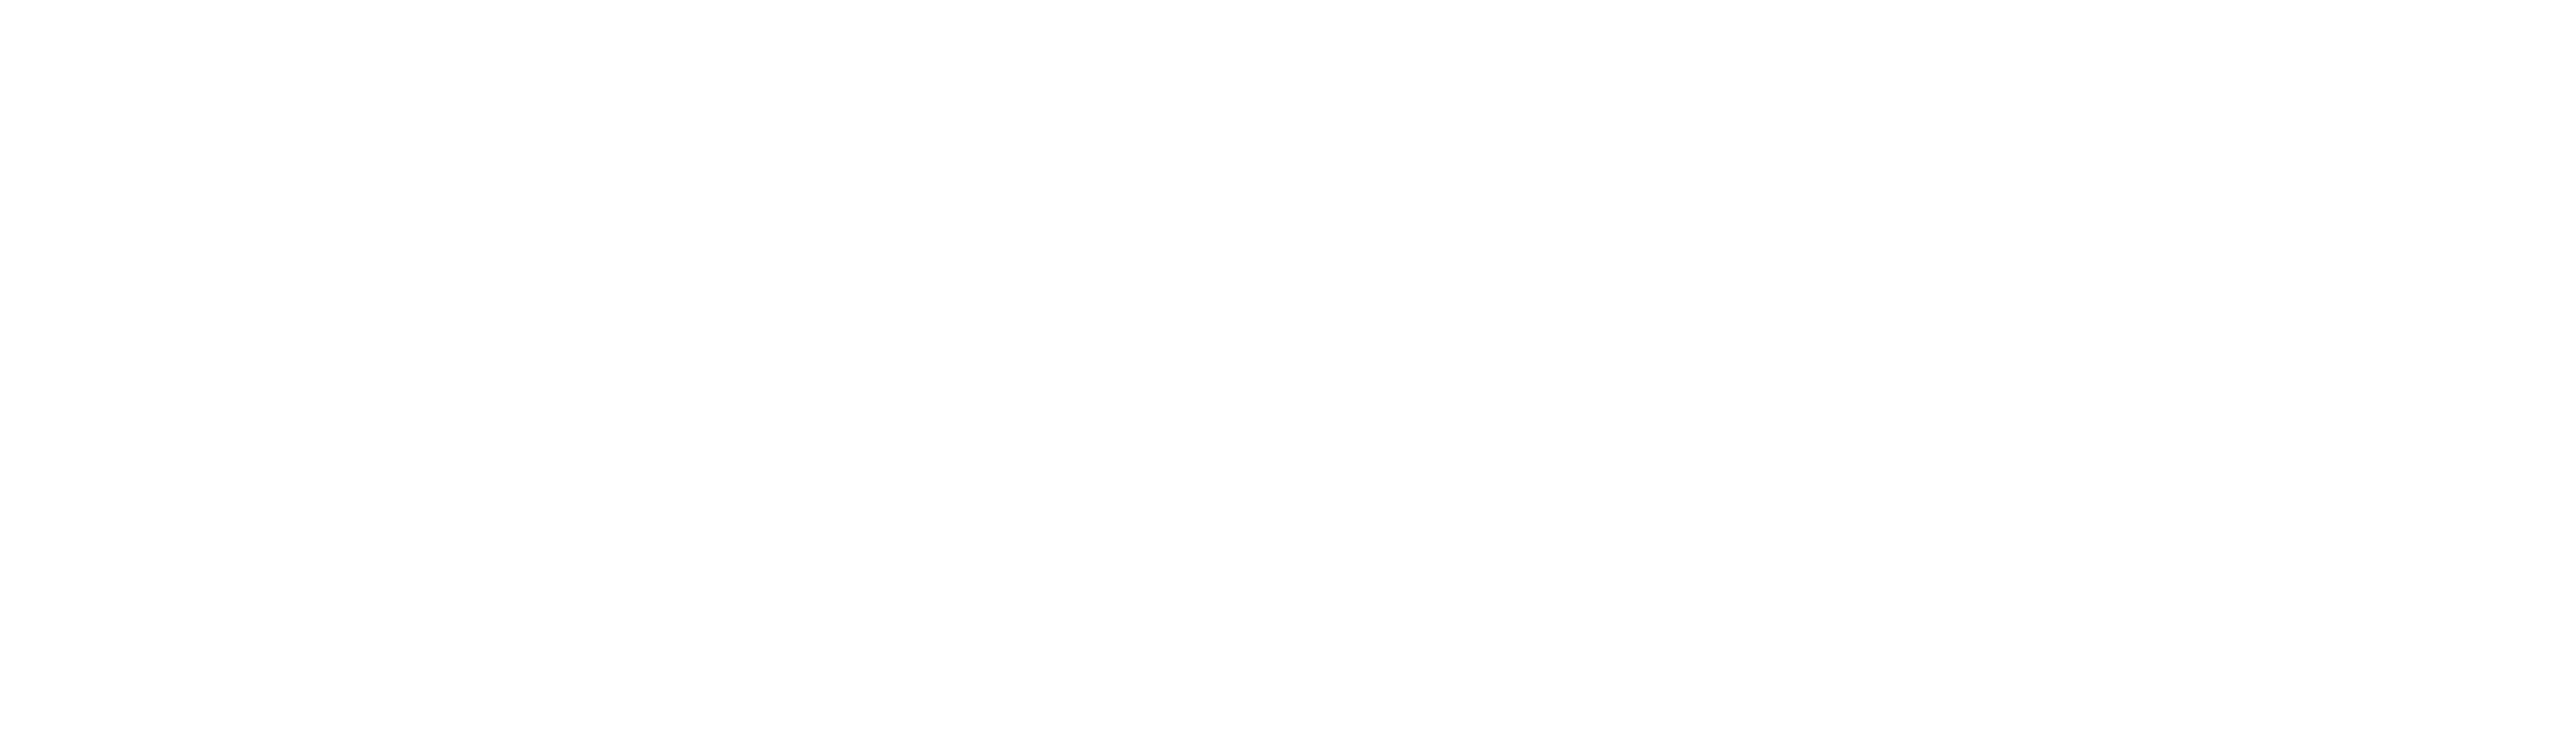

a370_SN_sourceplane/alfa_fits/Spectra_bin_17_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


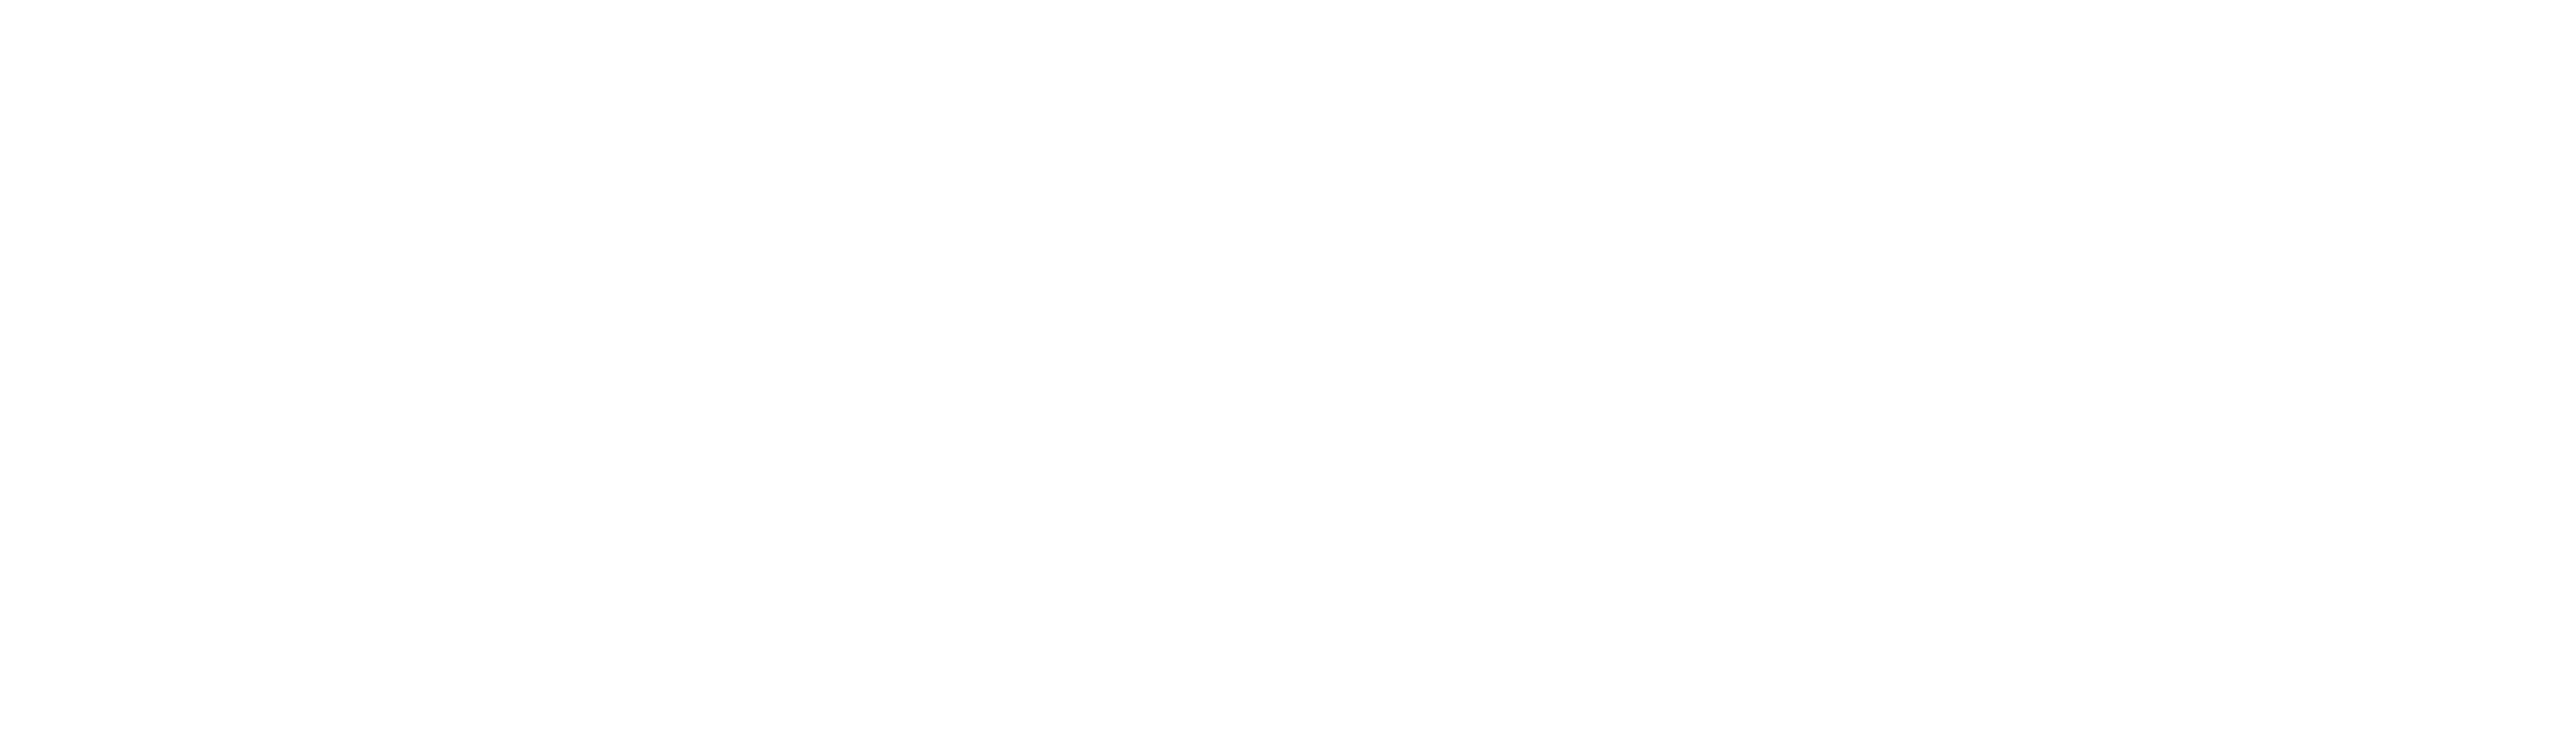

a370_SN_sourceplane/alfa_fits/Spectra_bin_18_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


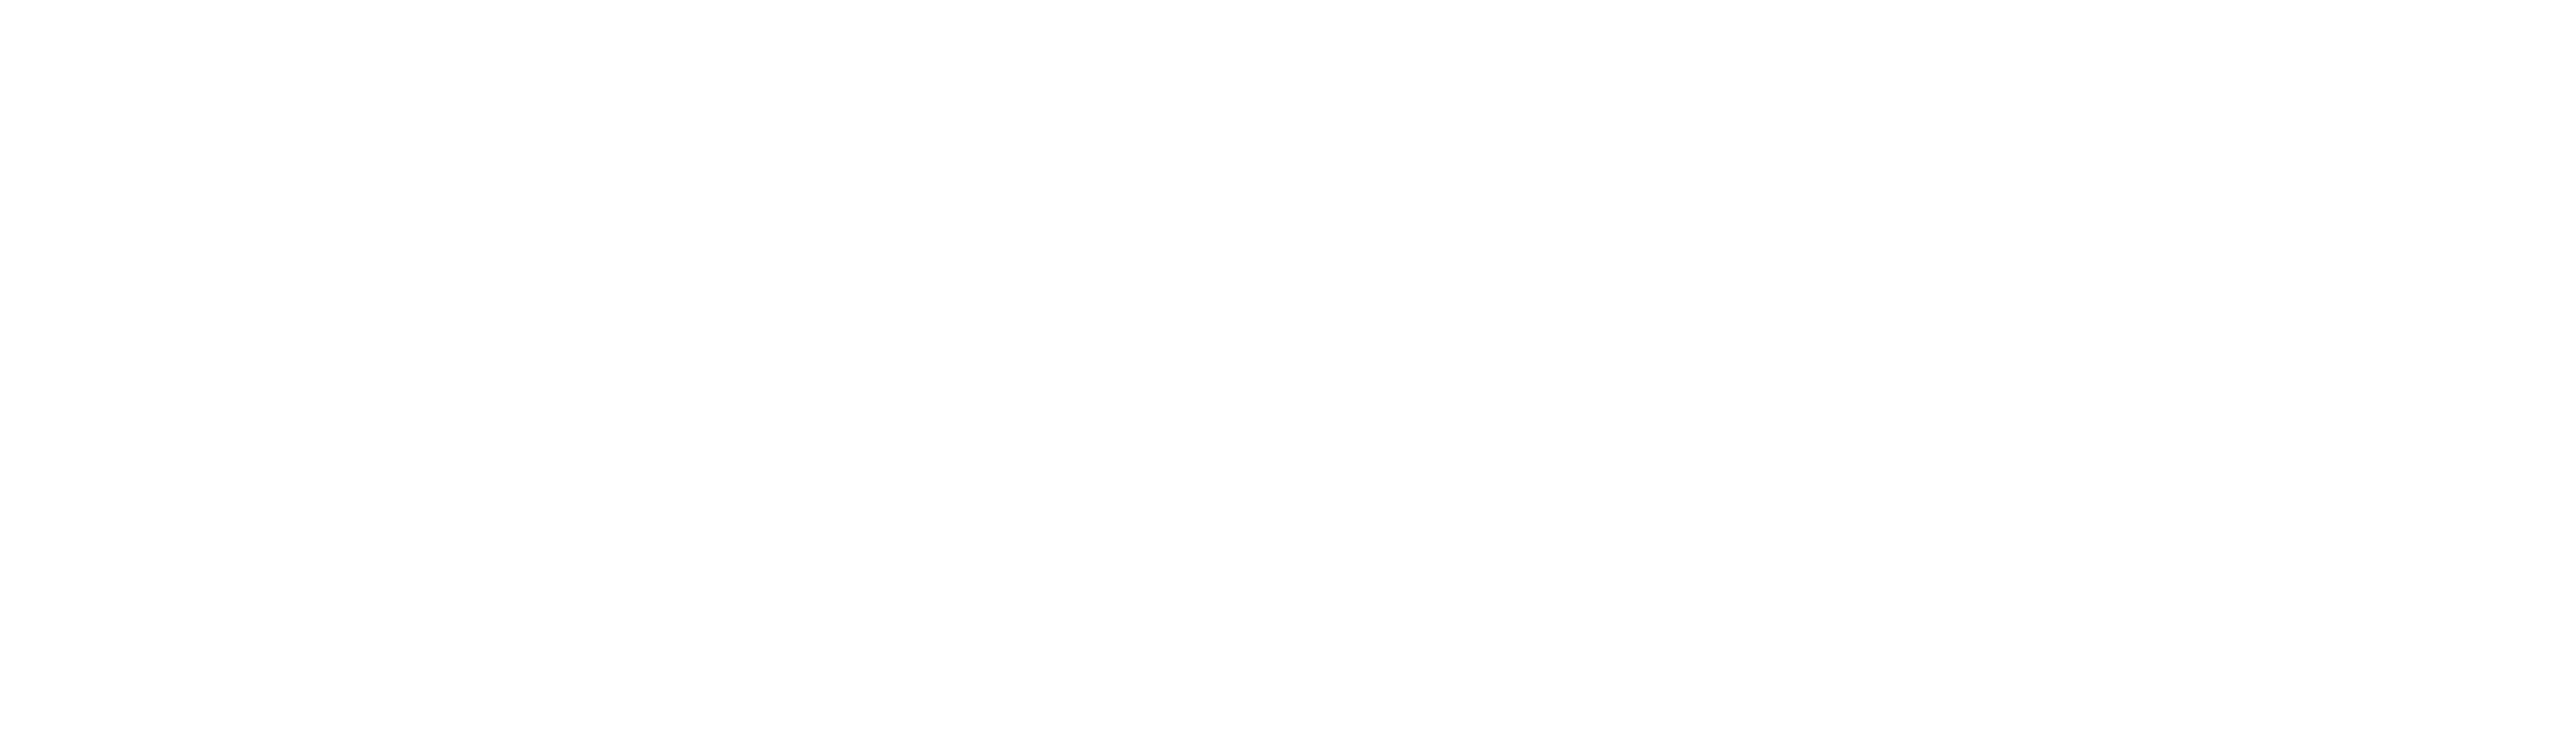

a370_SN_sourceplane/alfa_fits/Spectra_bin_19_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


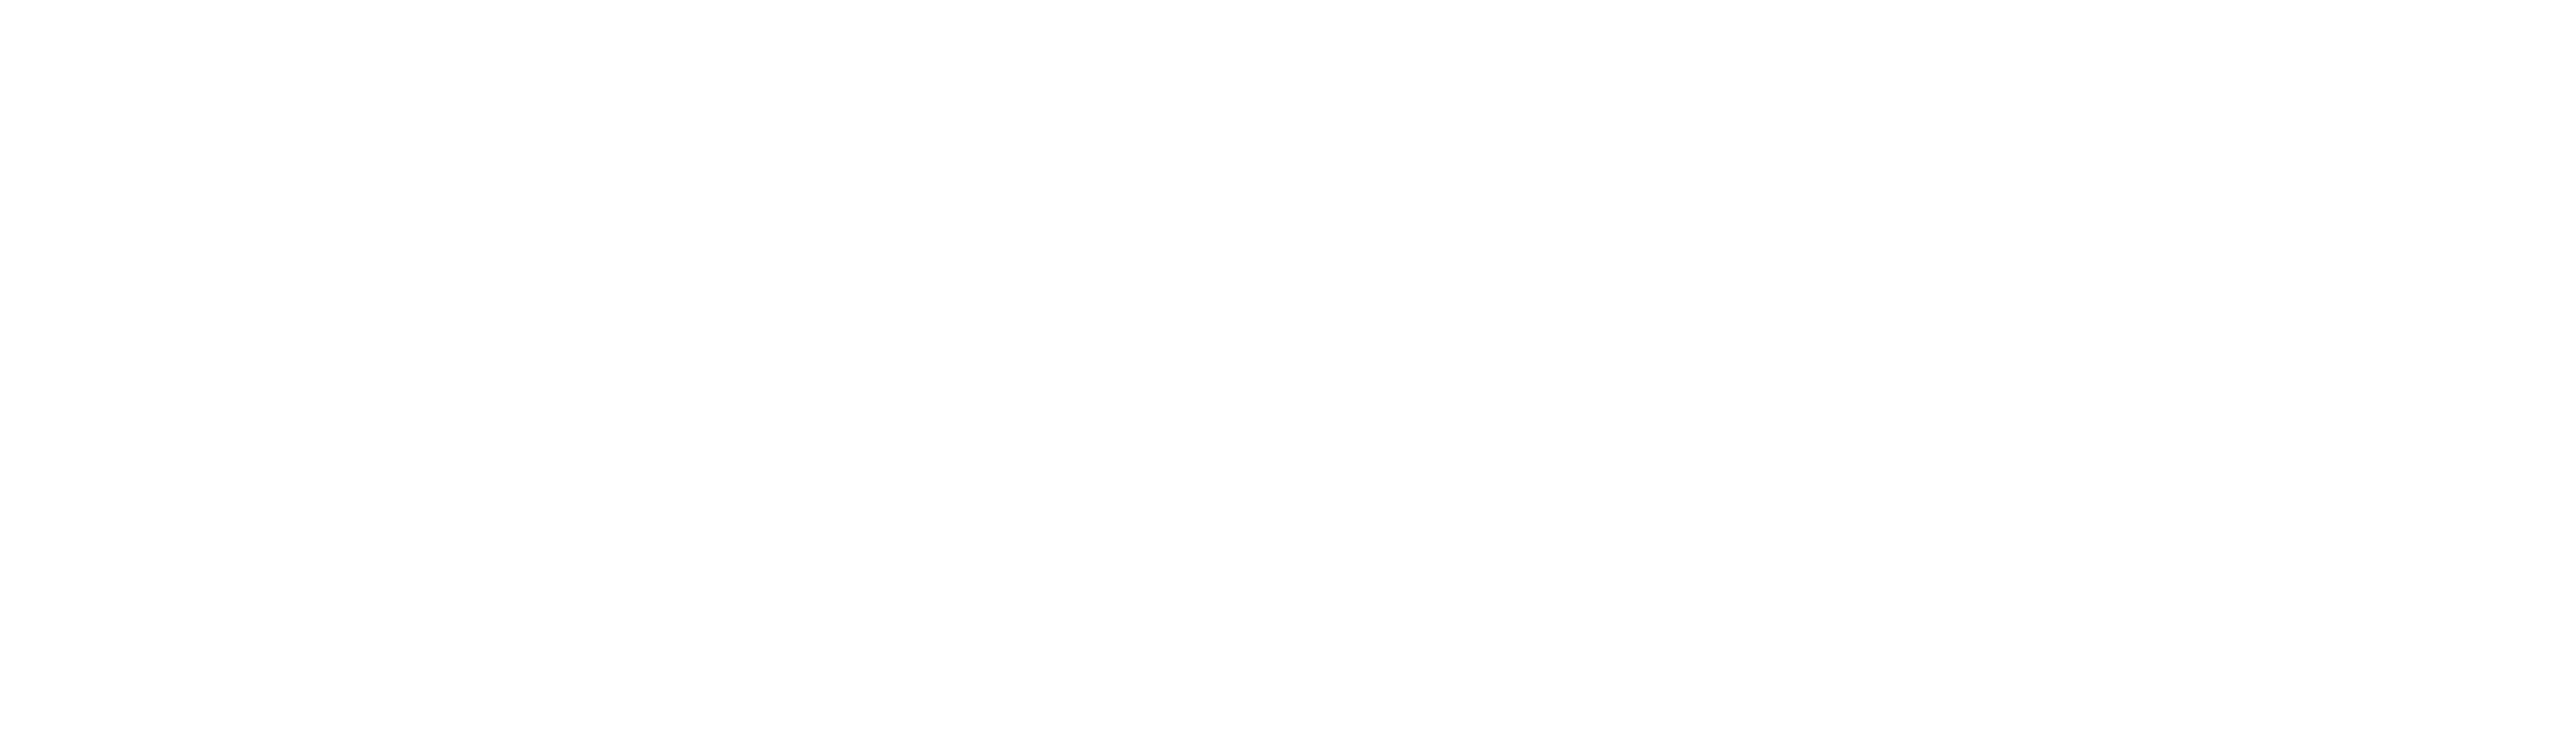

a370_SN_sourceplane/alfa_fits/Spectra_bin_1_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


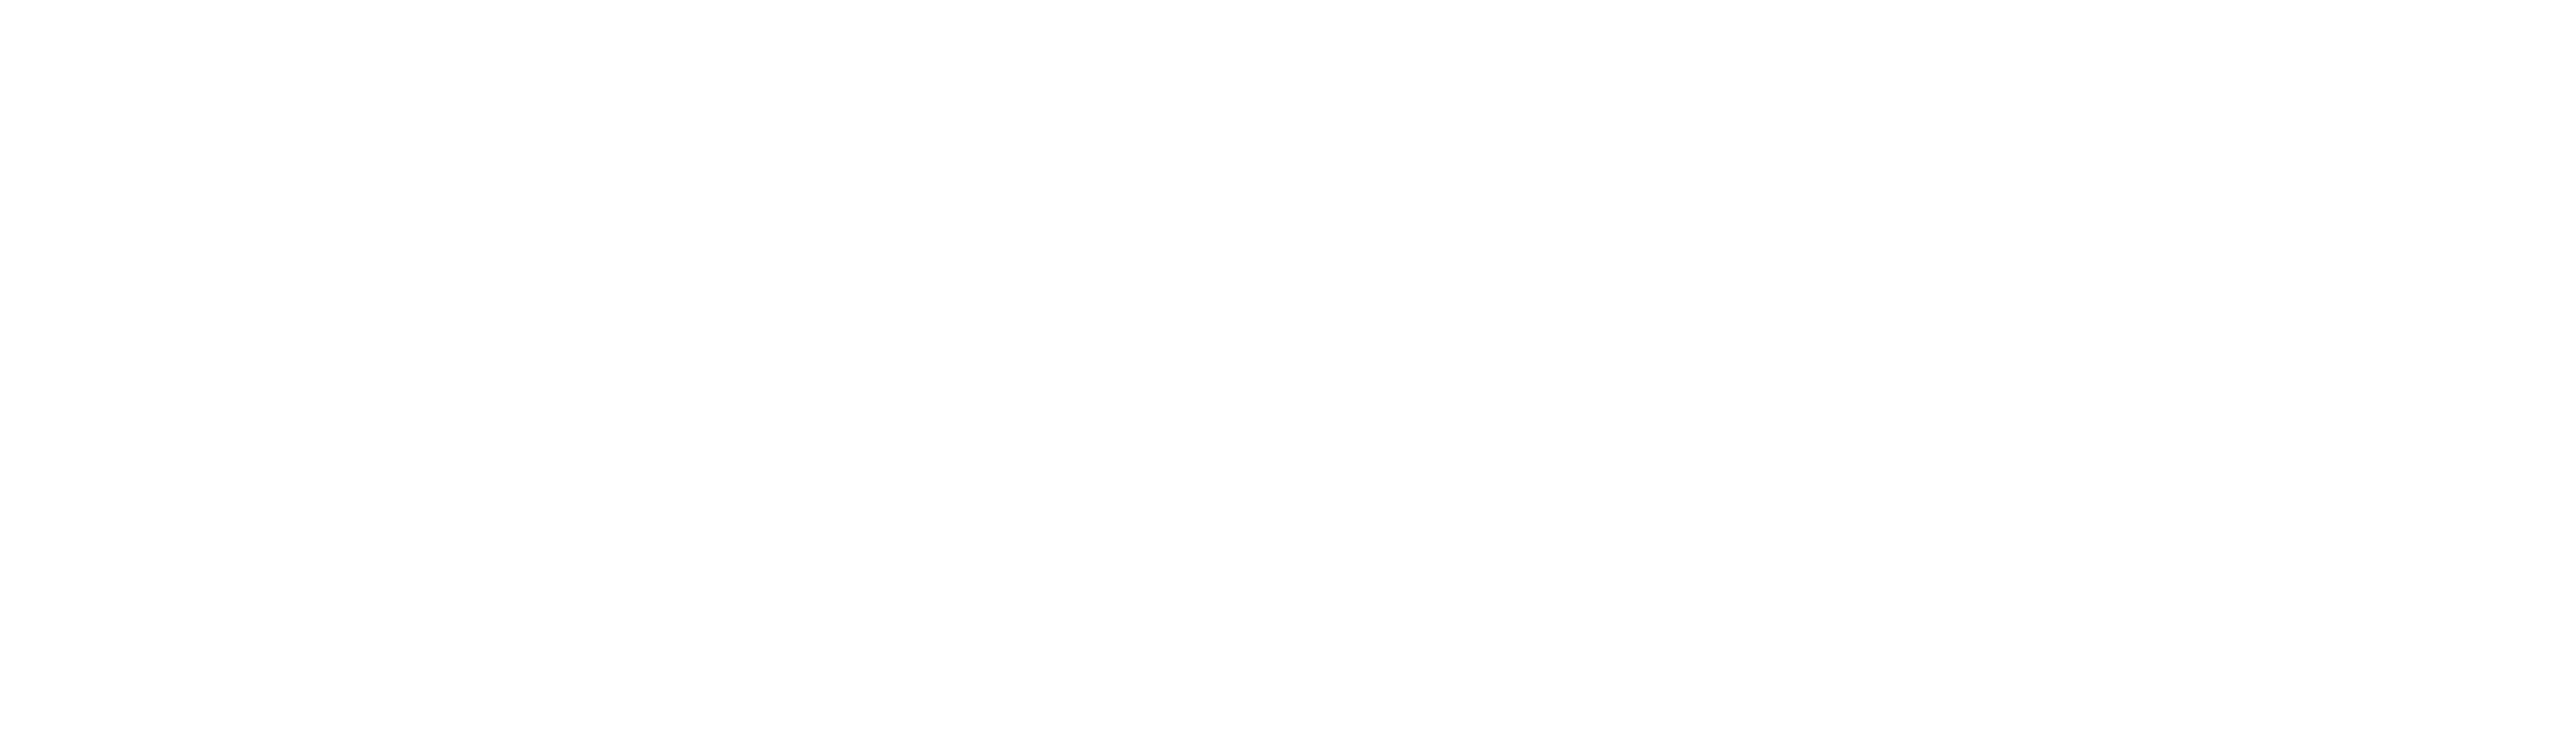

a370_SN_sourceplane/alfa_fits/Spectra_bin_20_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


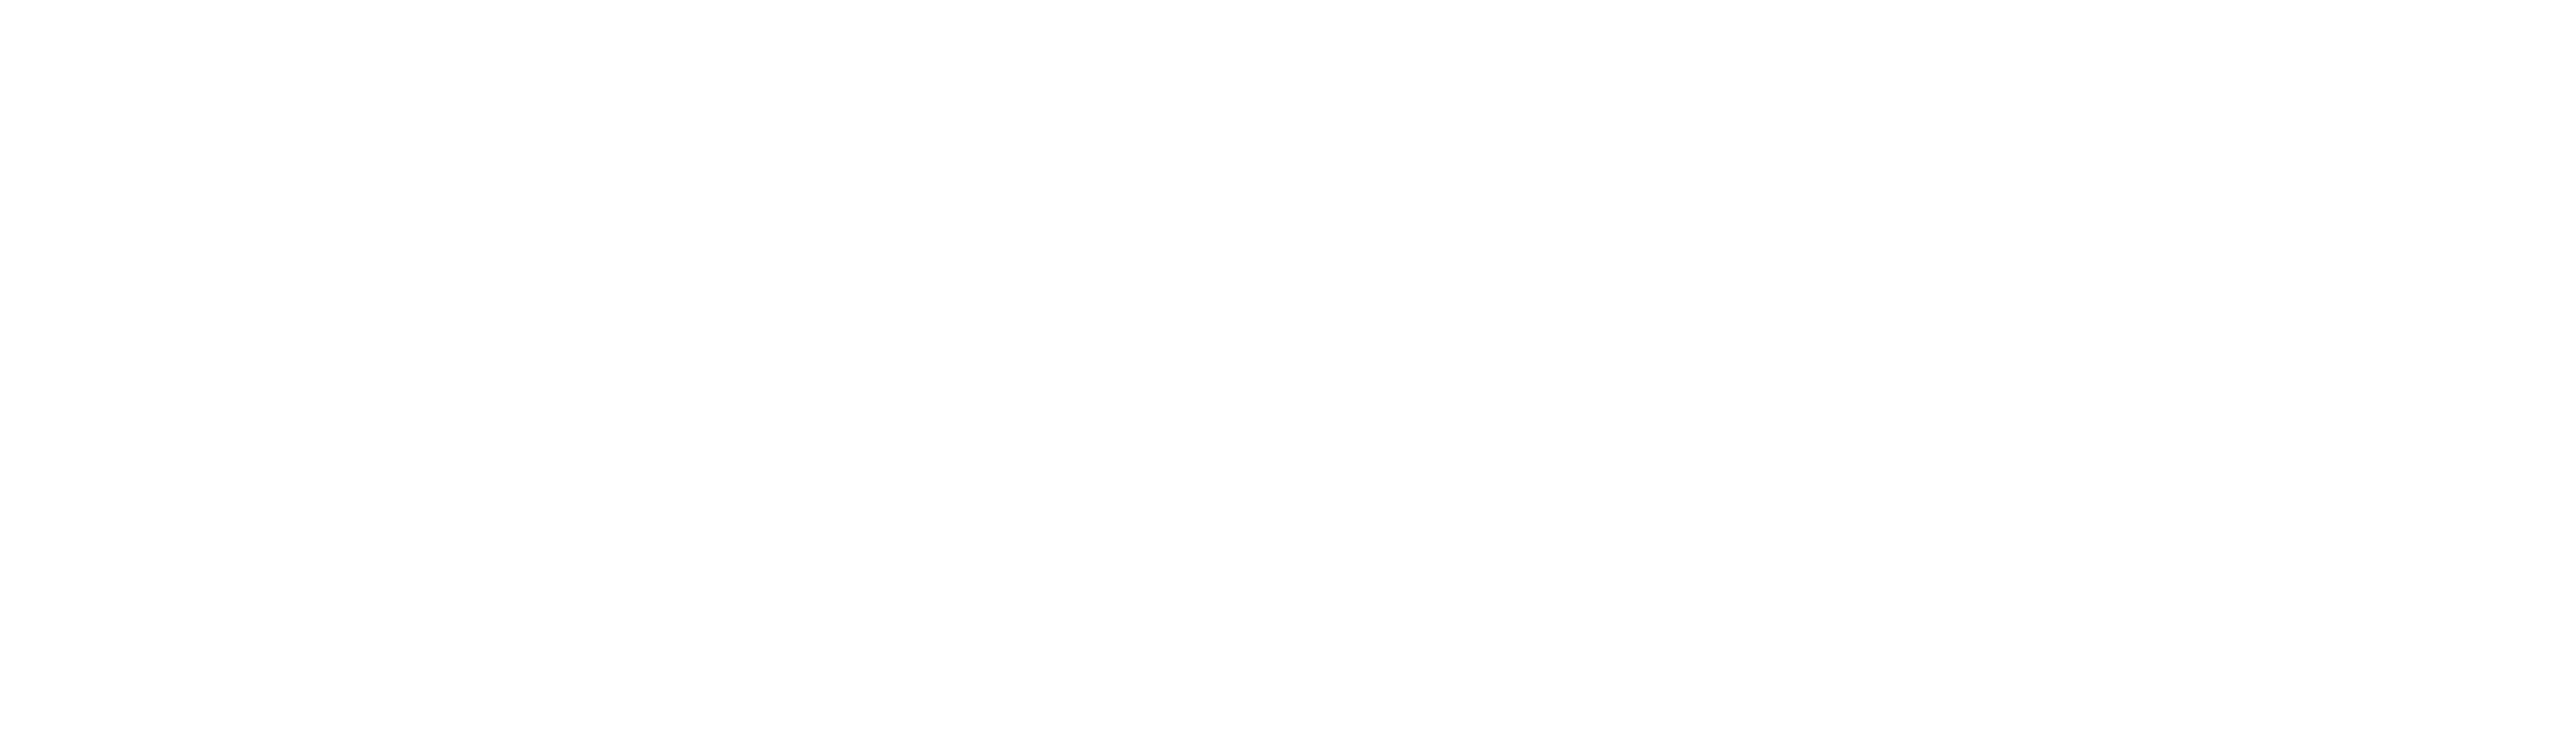

a370_SN_sourceplane/alfa_fits/Spectra_bin_21_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


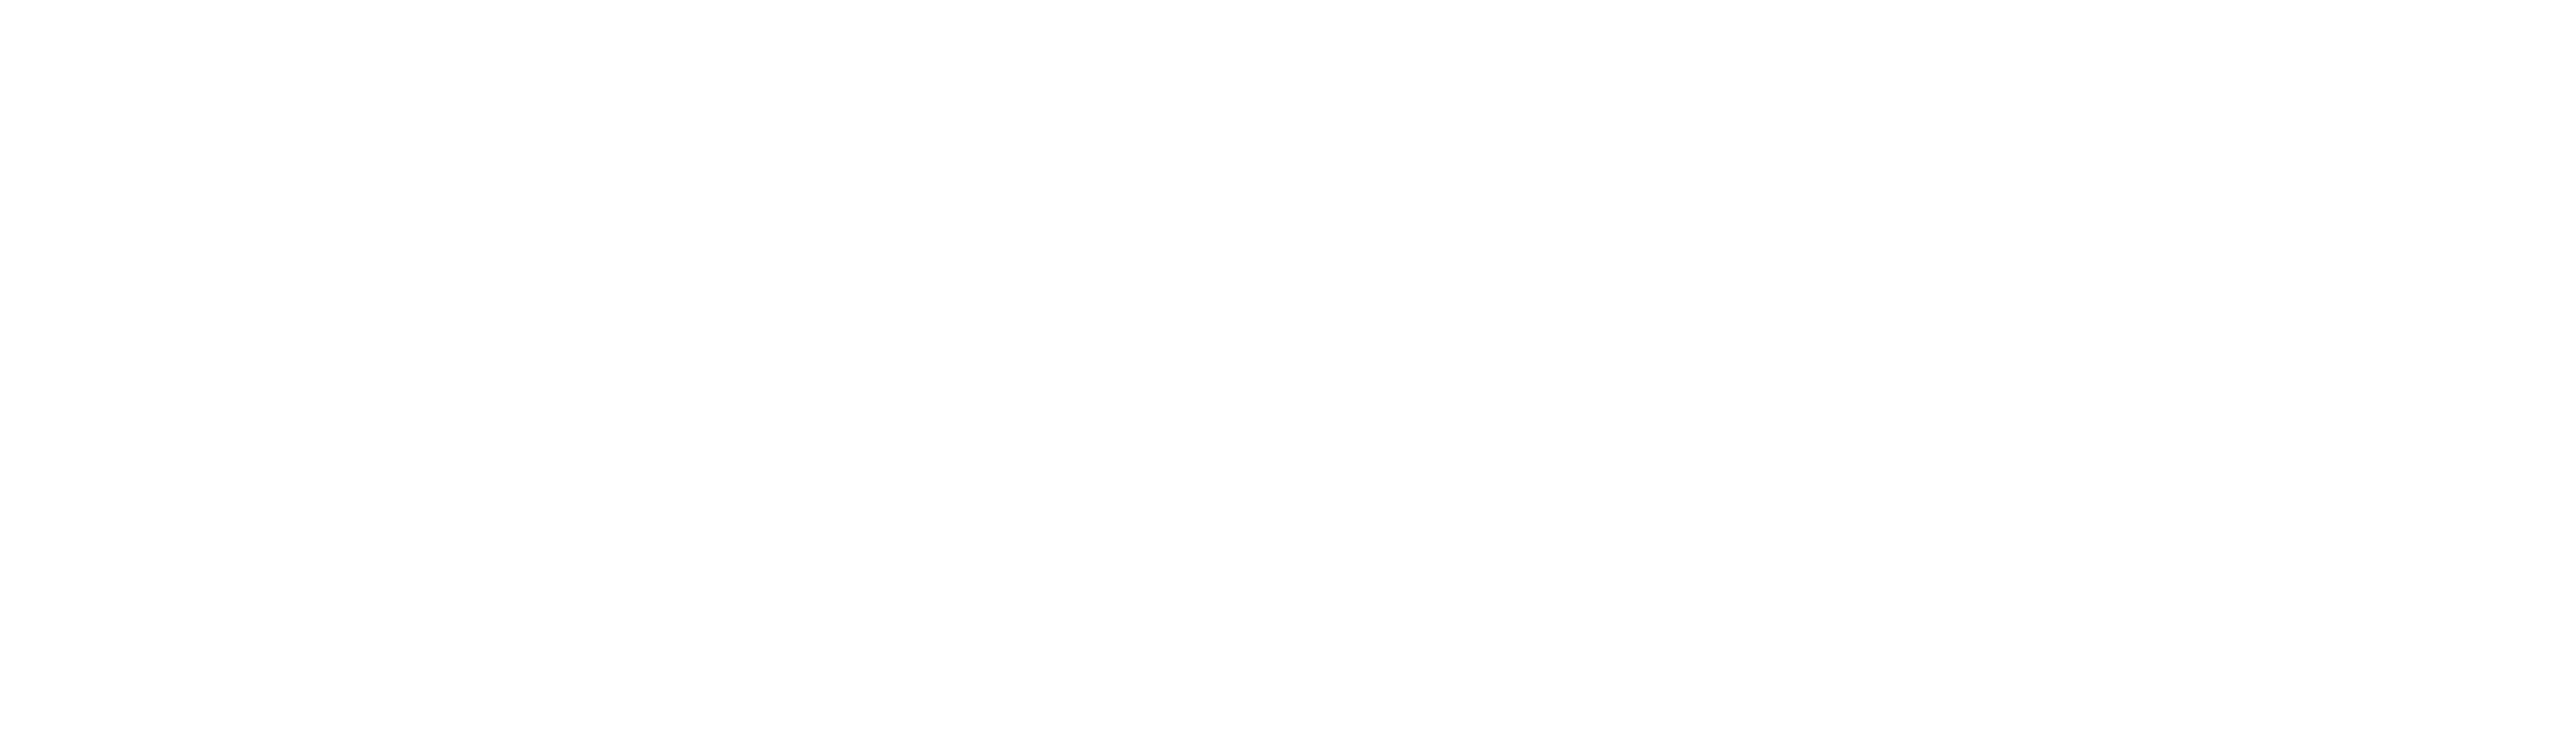

a370_SN_sourceplane/alfa_fits/Spectra_bin_22_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


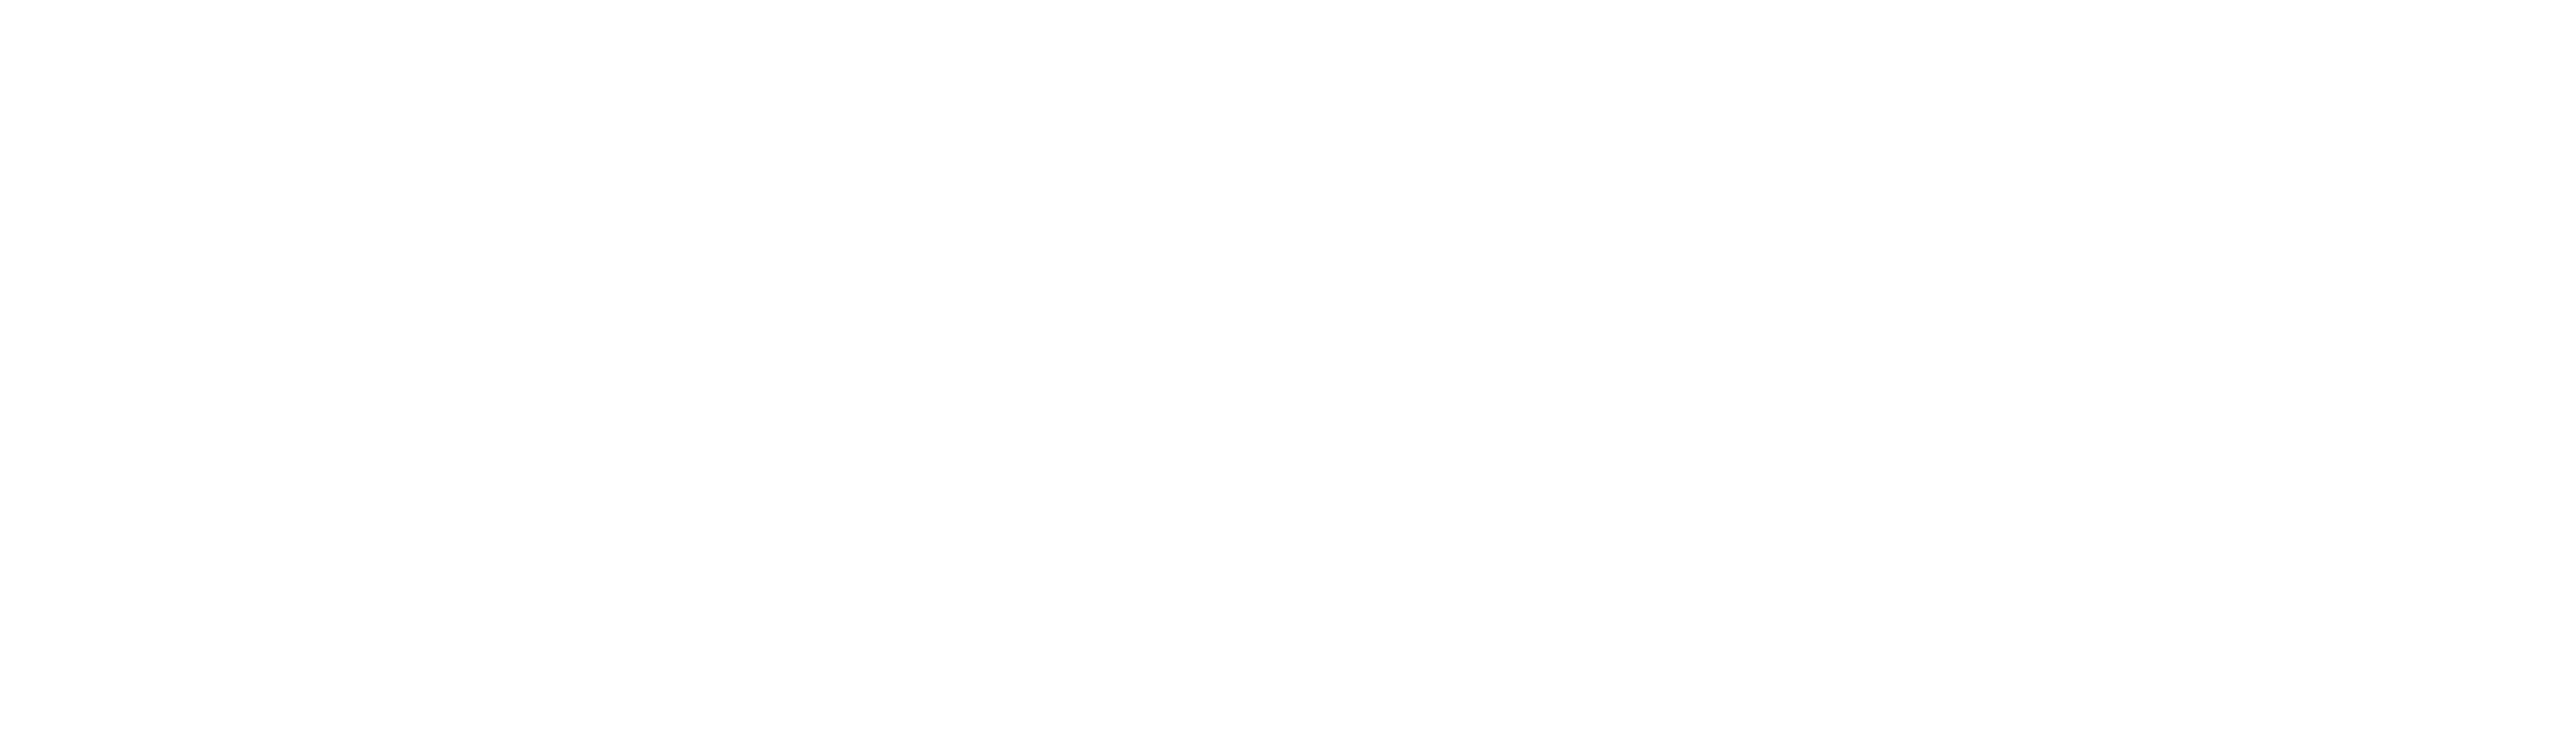

a370_SN_sourceplane/alfa_fits/Spectra_bin_23_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


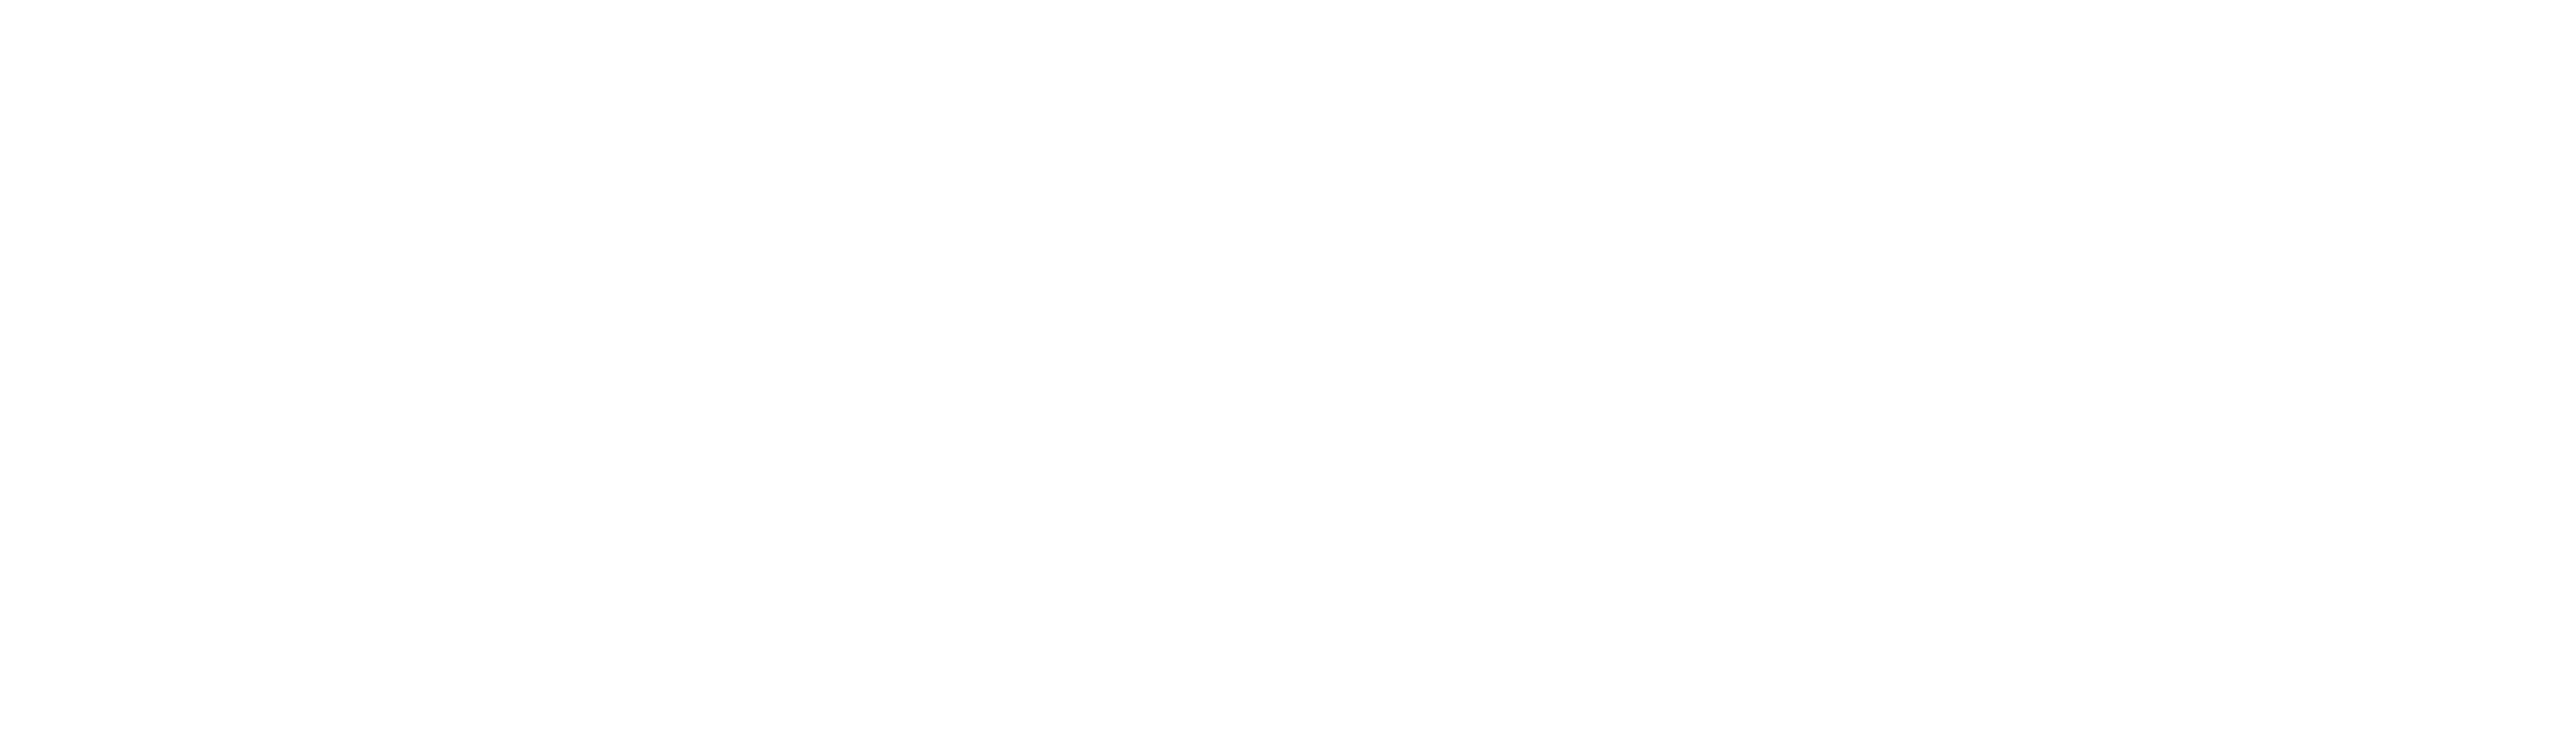

a370_SN_sourceplane/alfa_fits/Spectra_bin_24_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


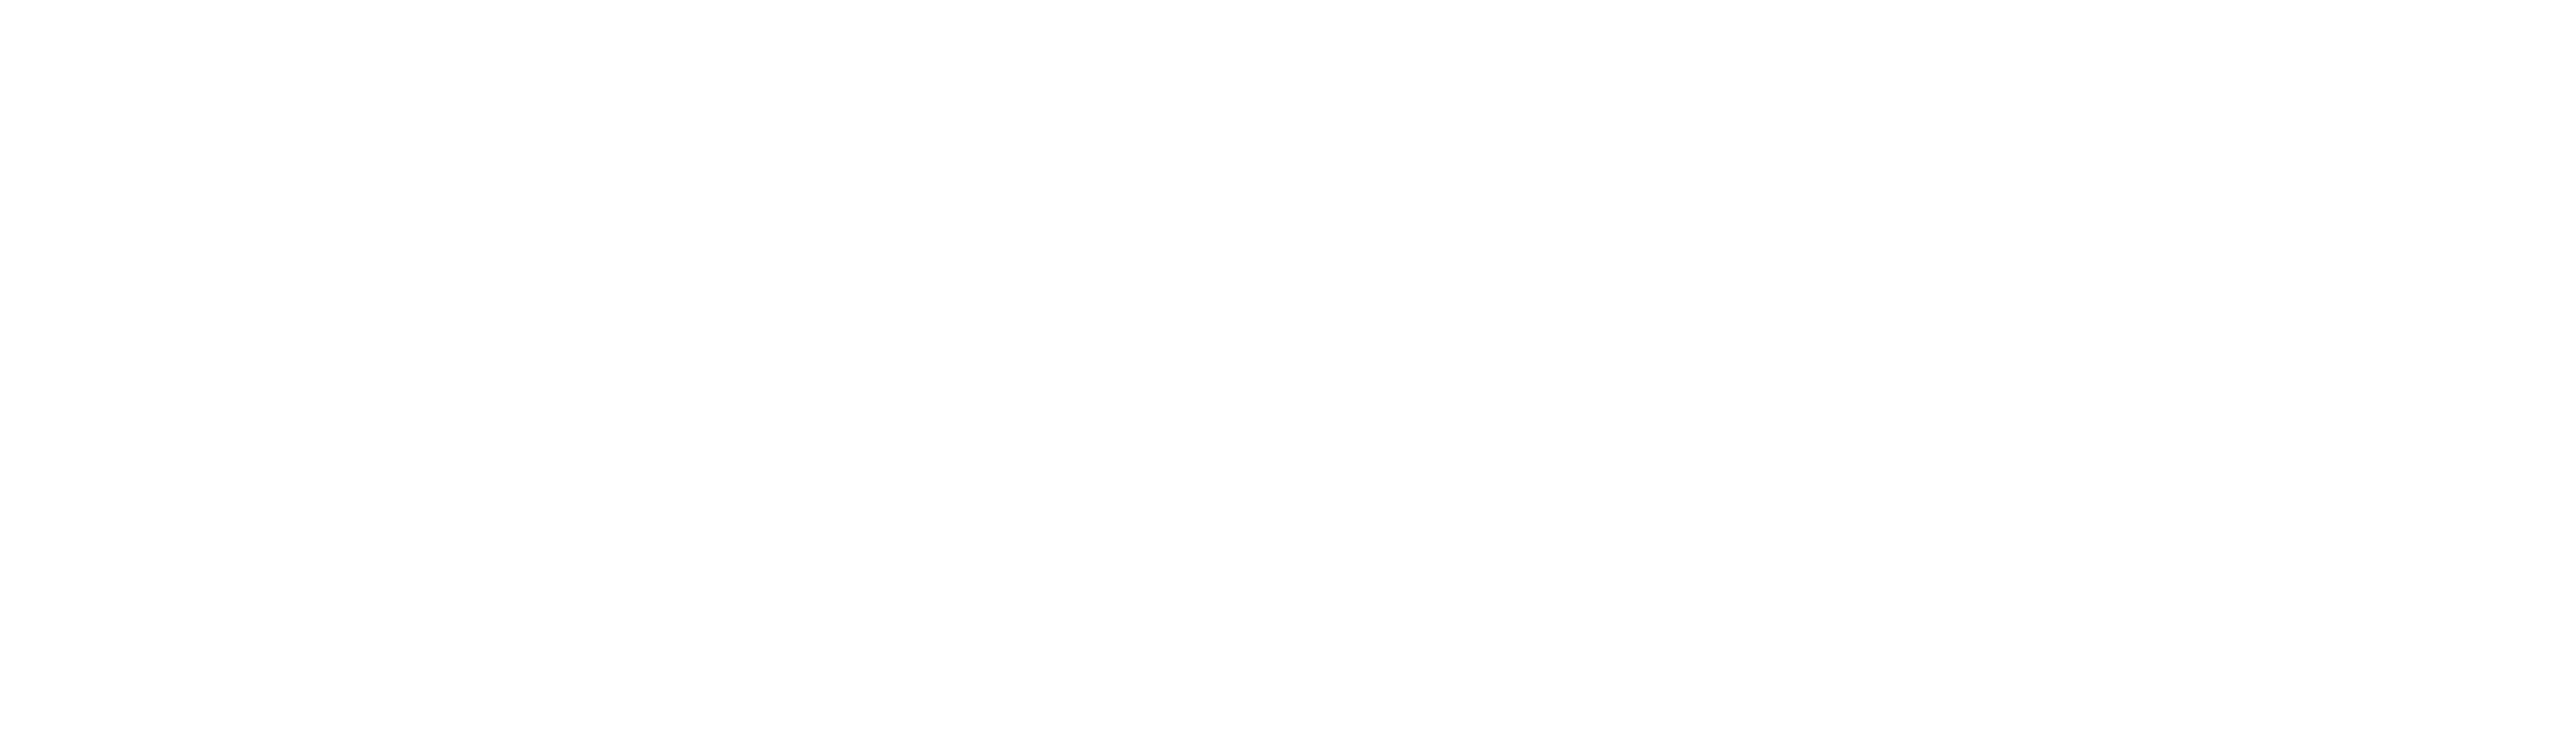

a370_SN_sourceplane/alfa_fits/Spectra_bin_25_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


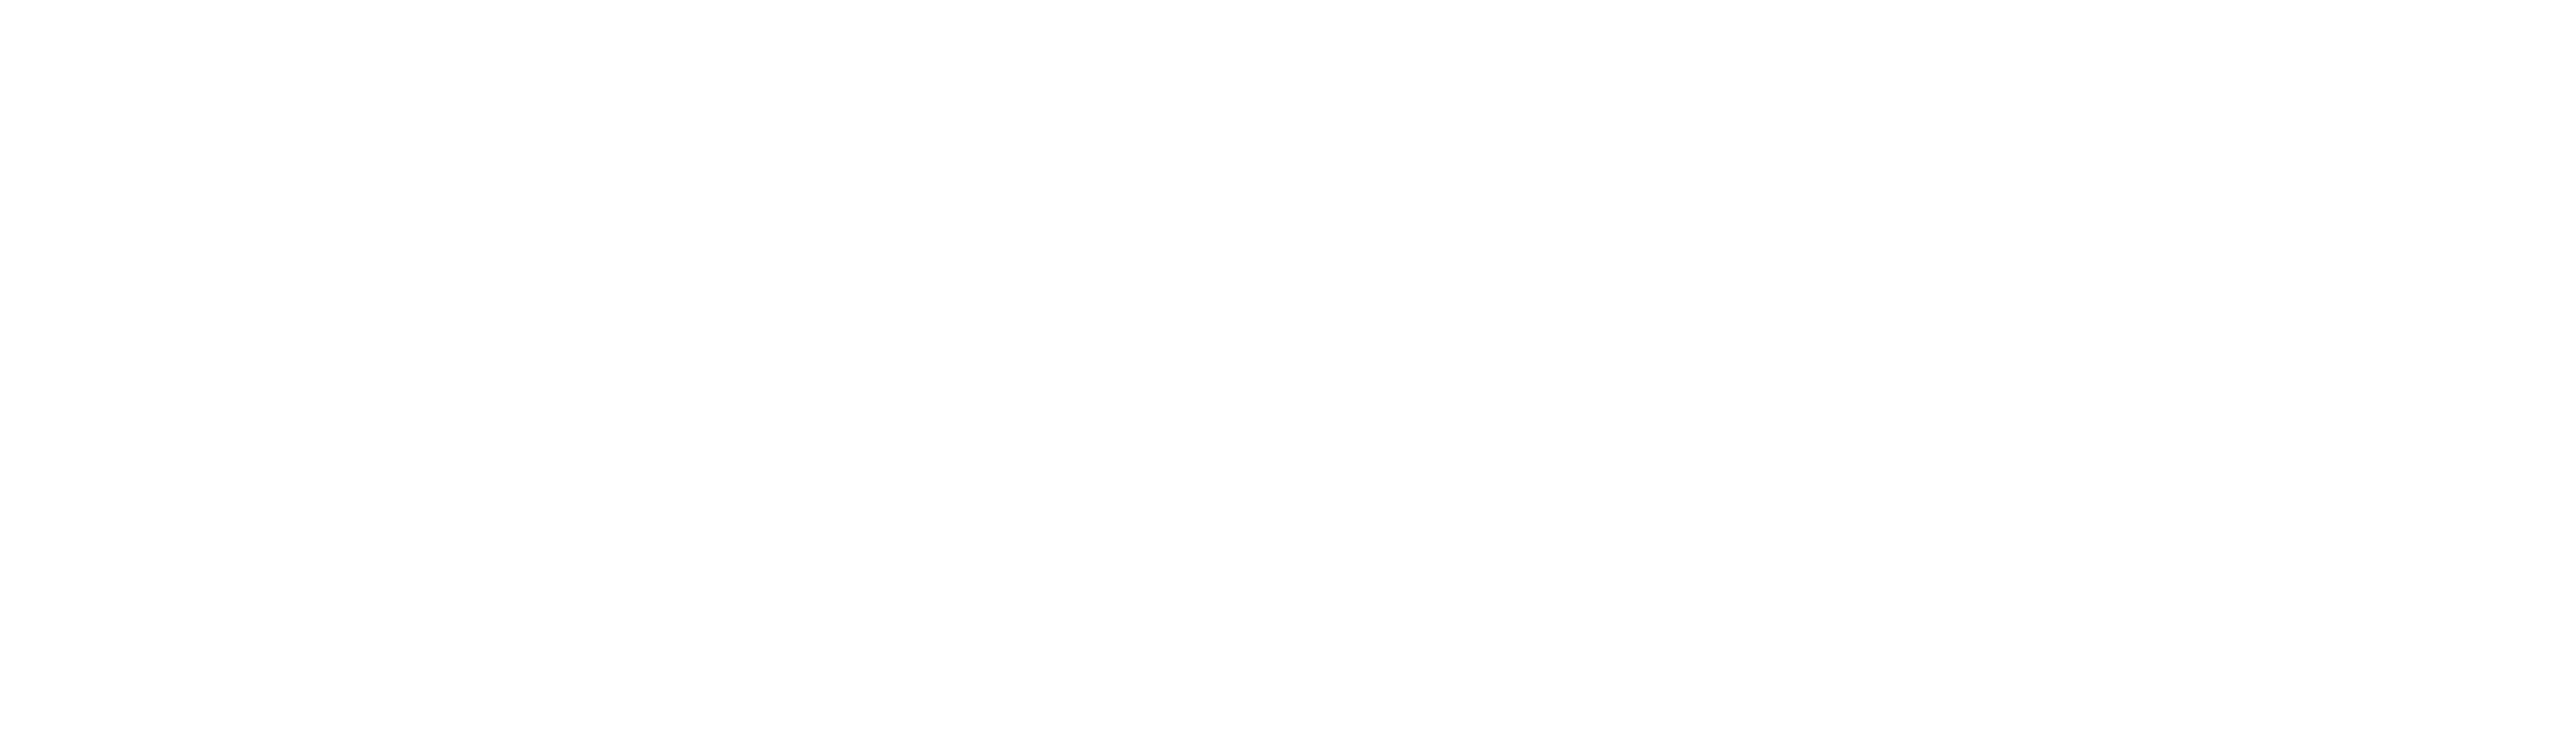

a370_SN_sourceplane/alfa_fits/Spectra_bin_26_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


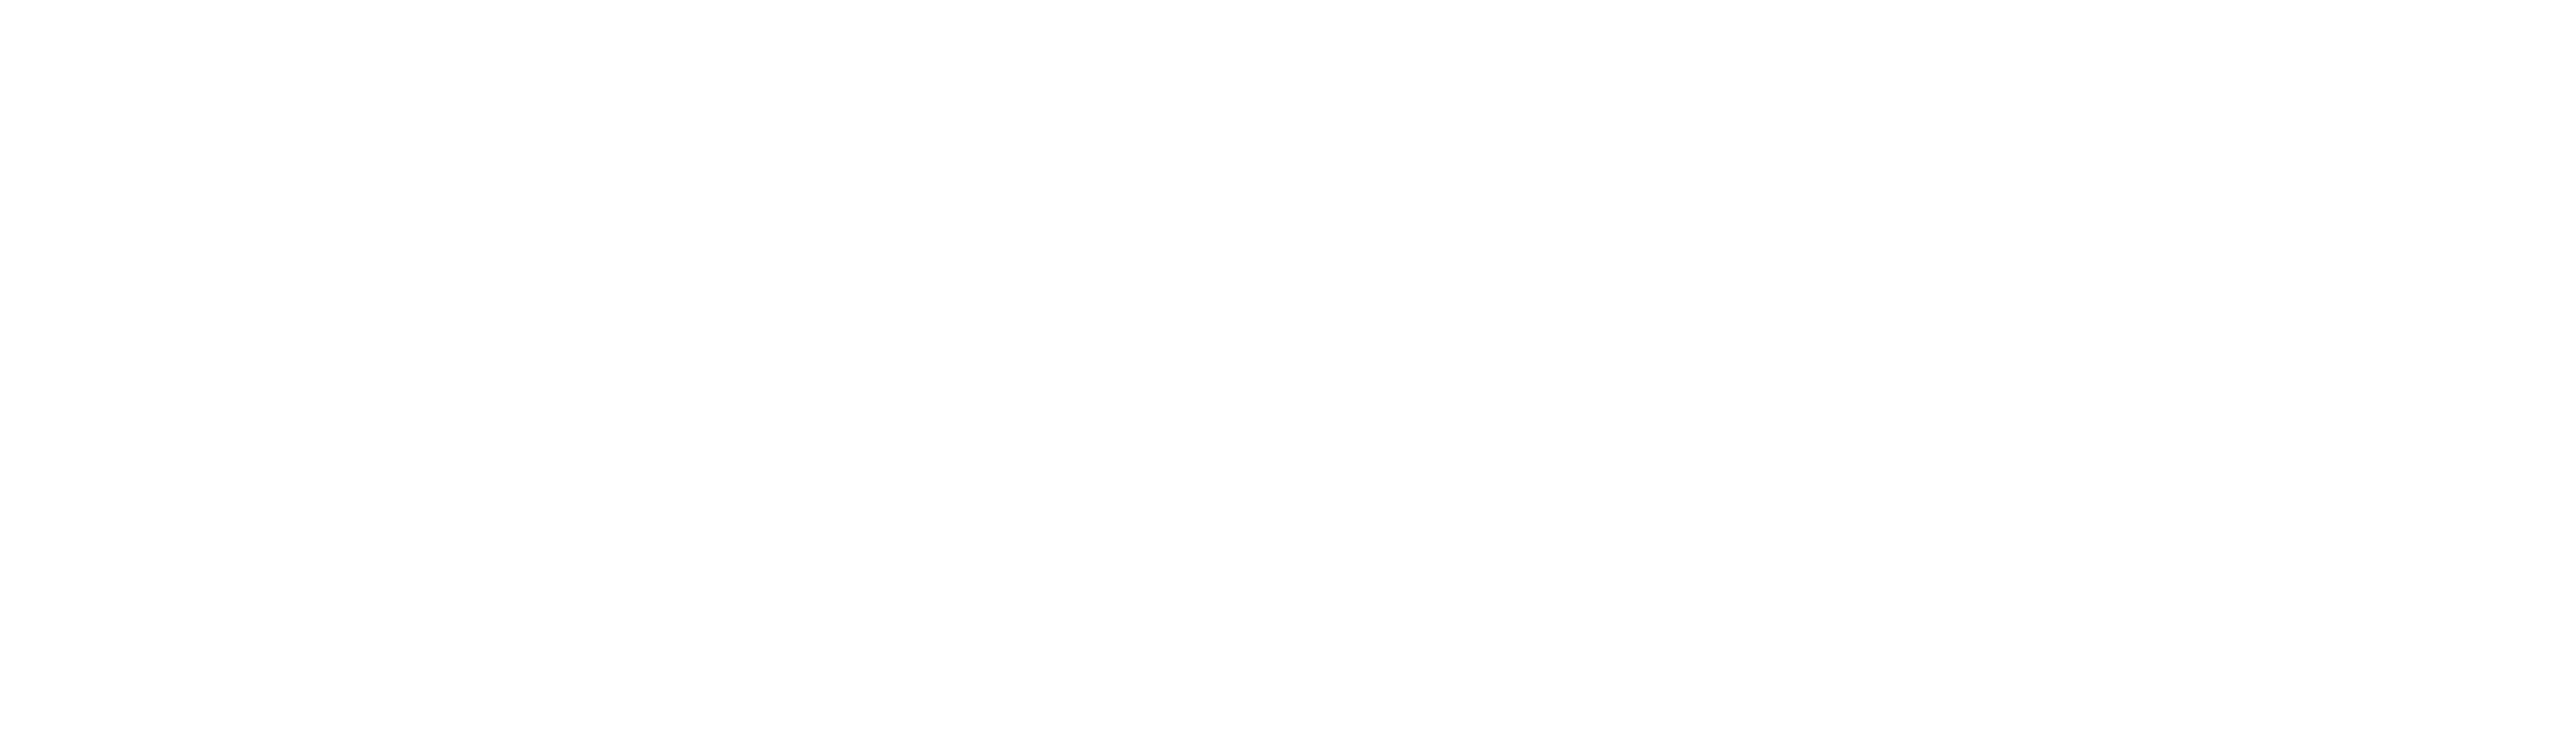

a370_SN_sourceplane/alfa_fits/Spectra_bin_27_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


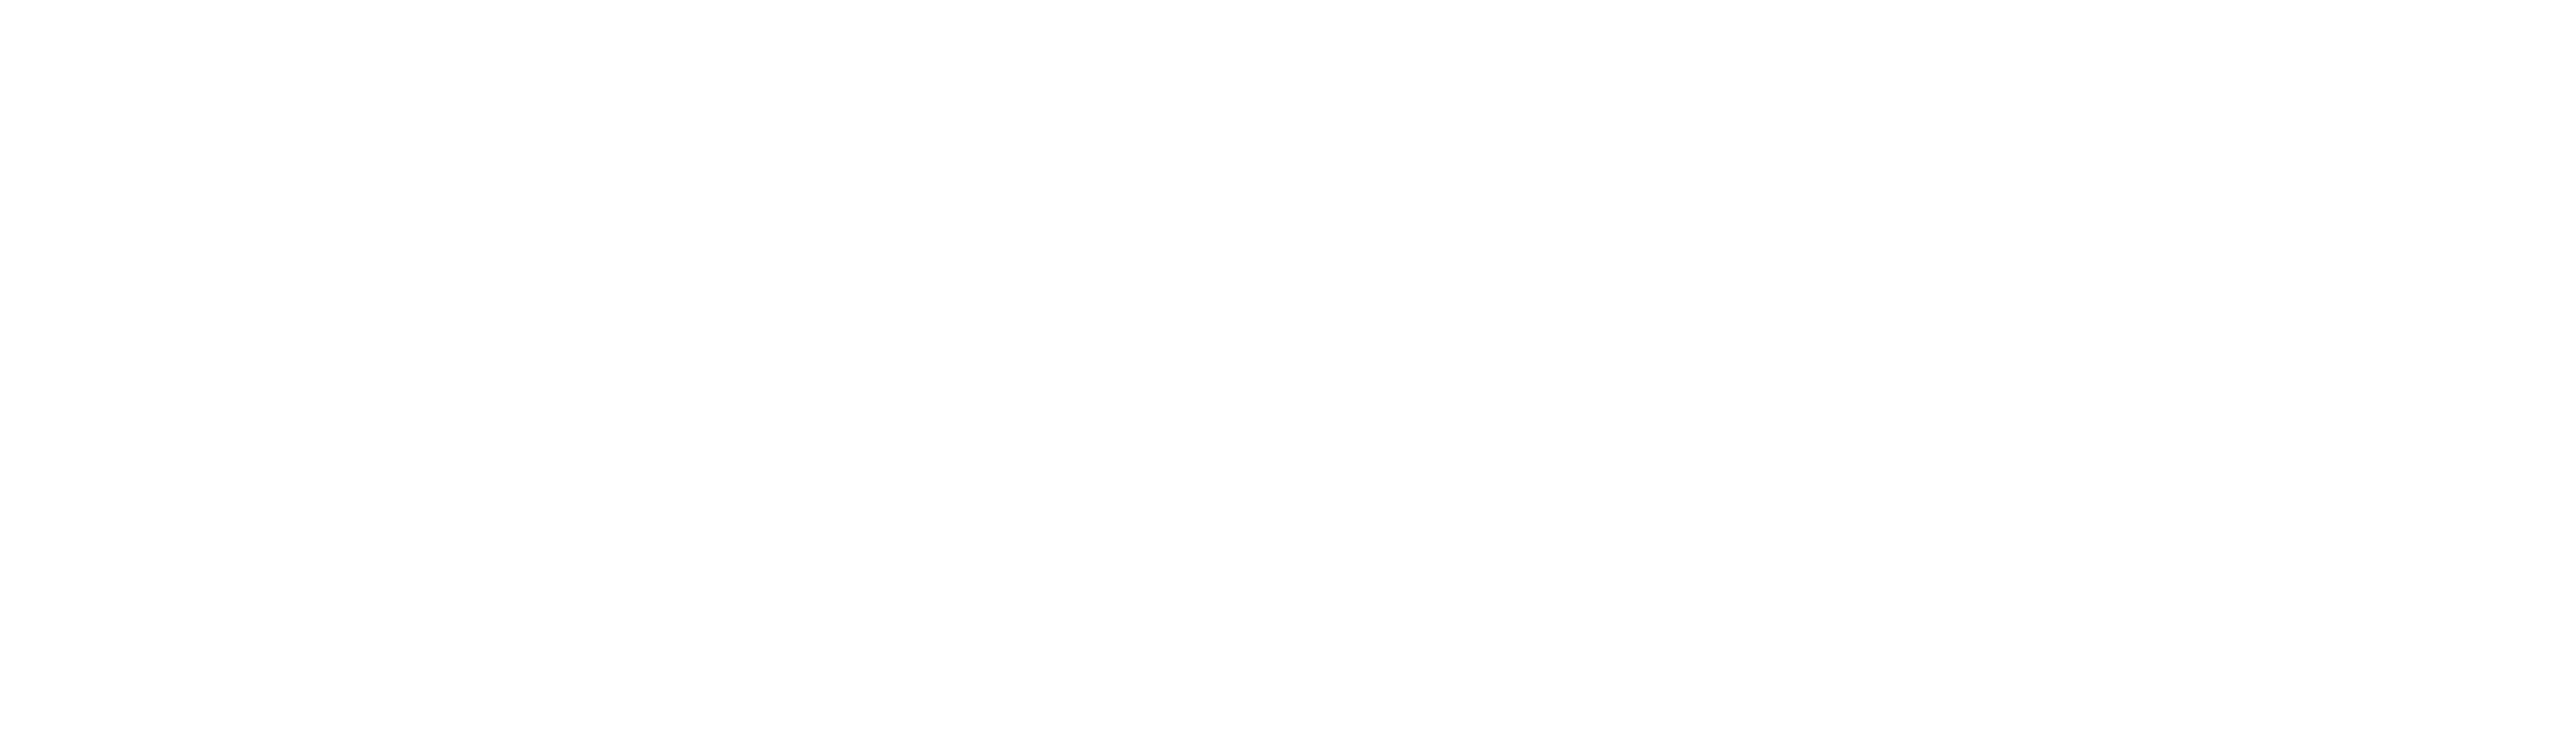

a370_SN_sourceplane/alfa_fits/Spectra_bin_28_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


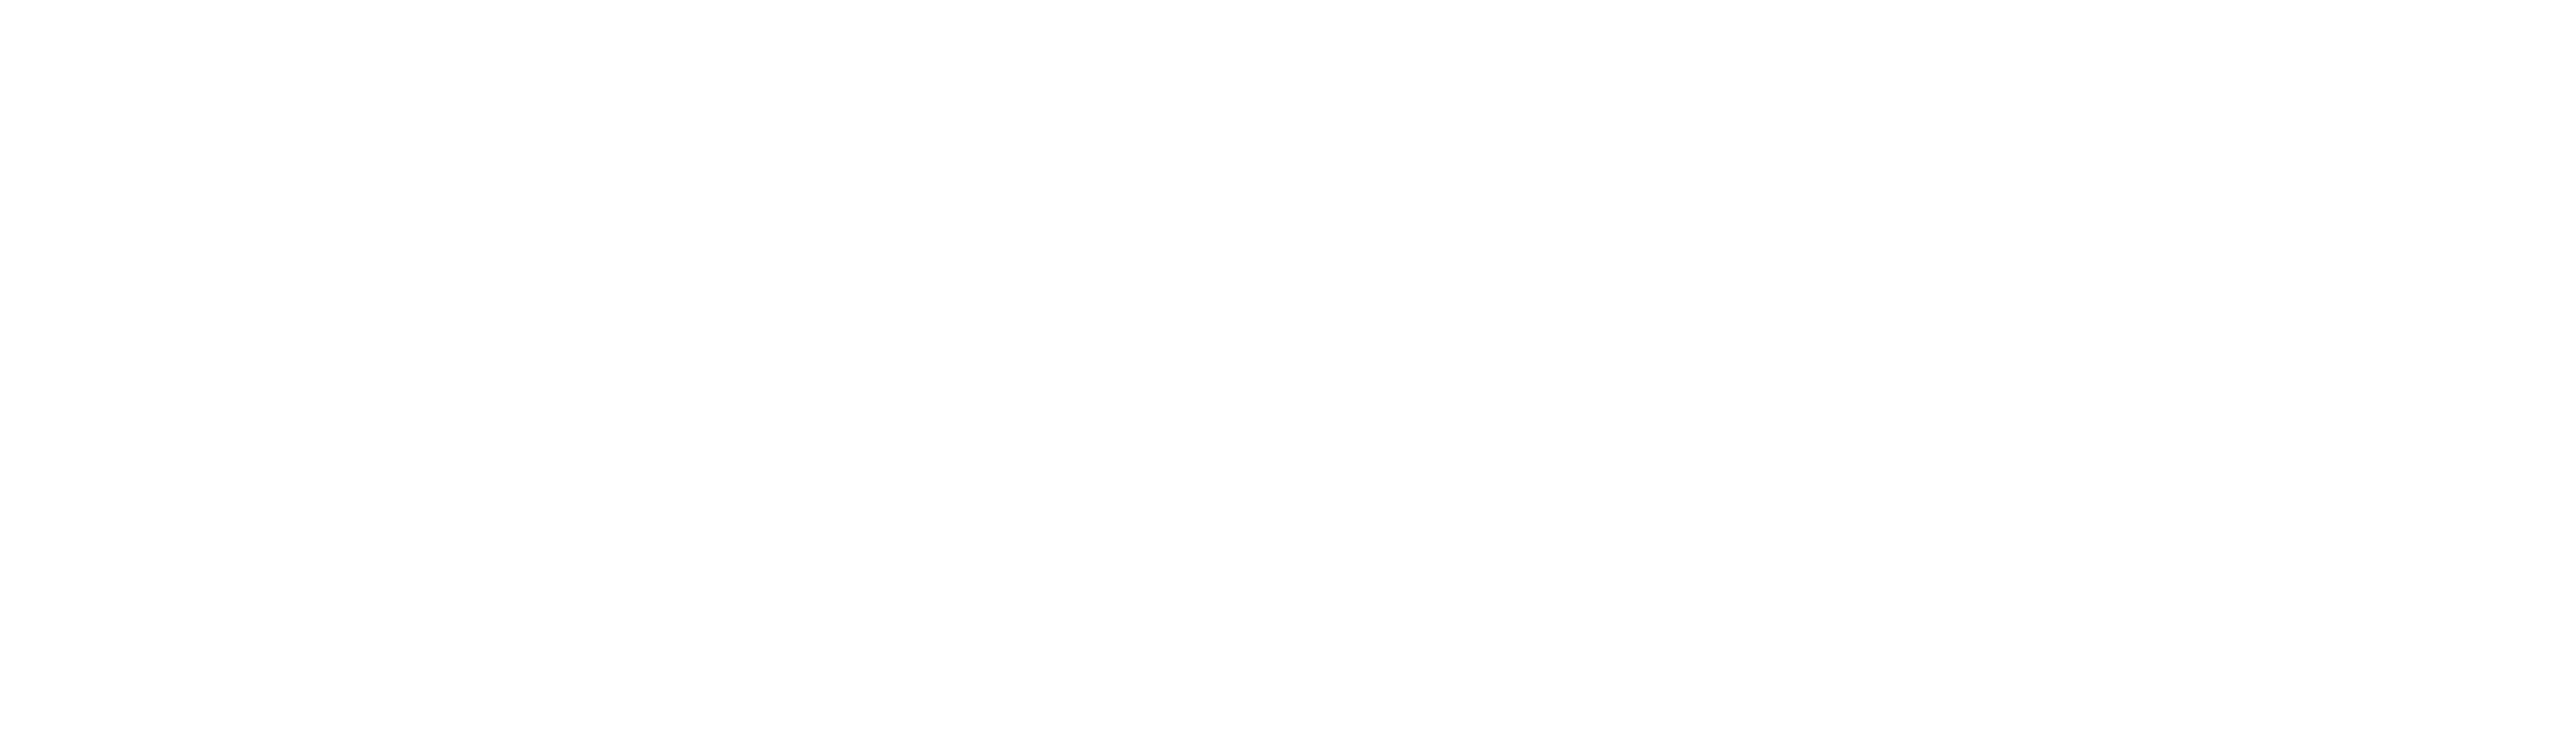

a370_SN_sourceplane/alfa_fits/Spectra_bin_29_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


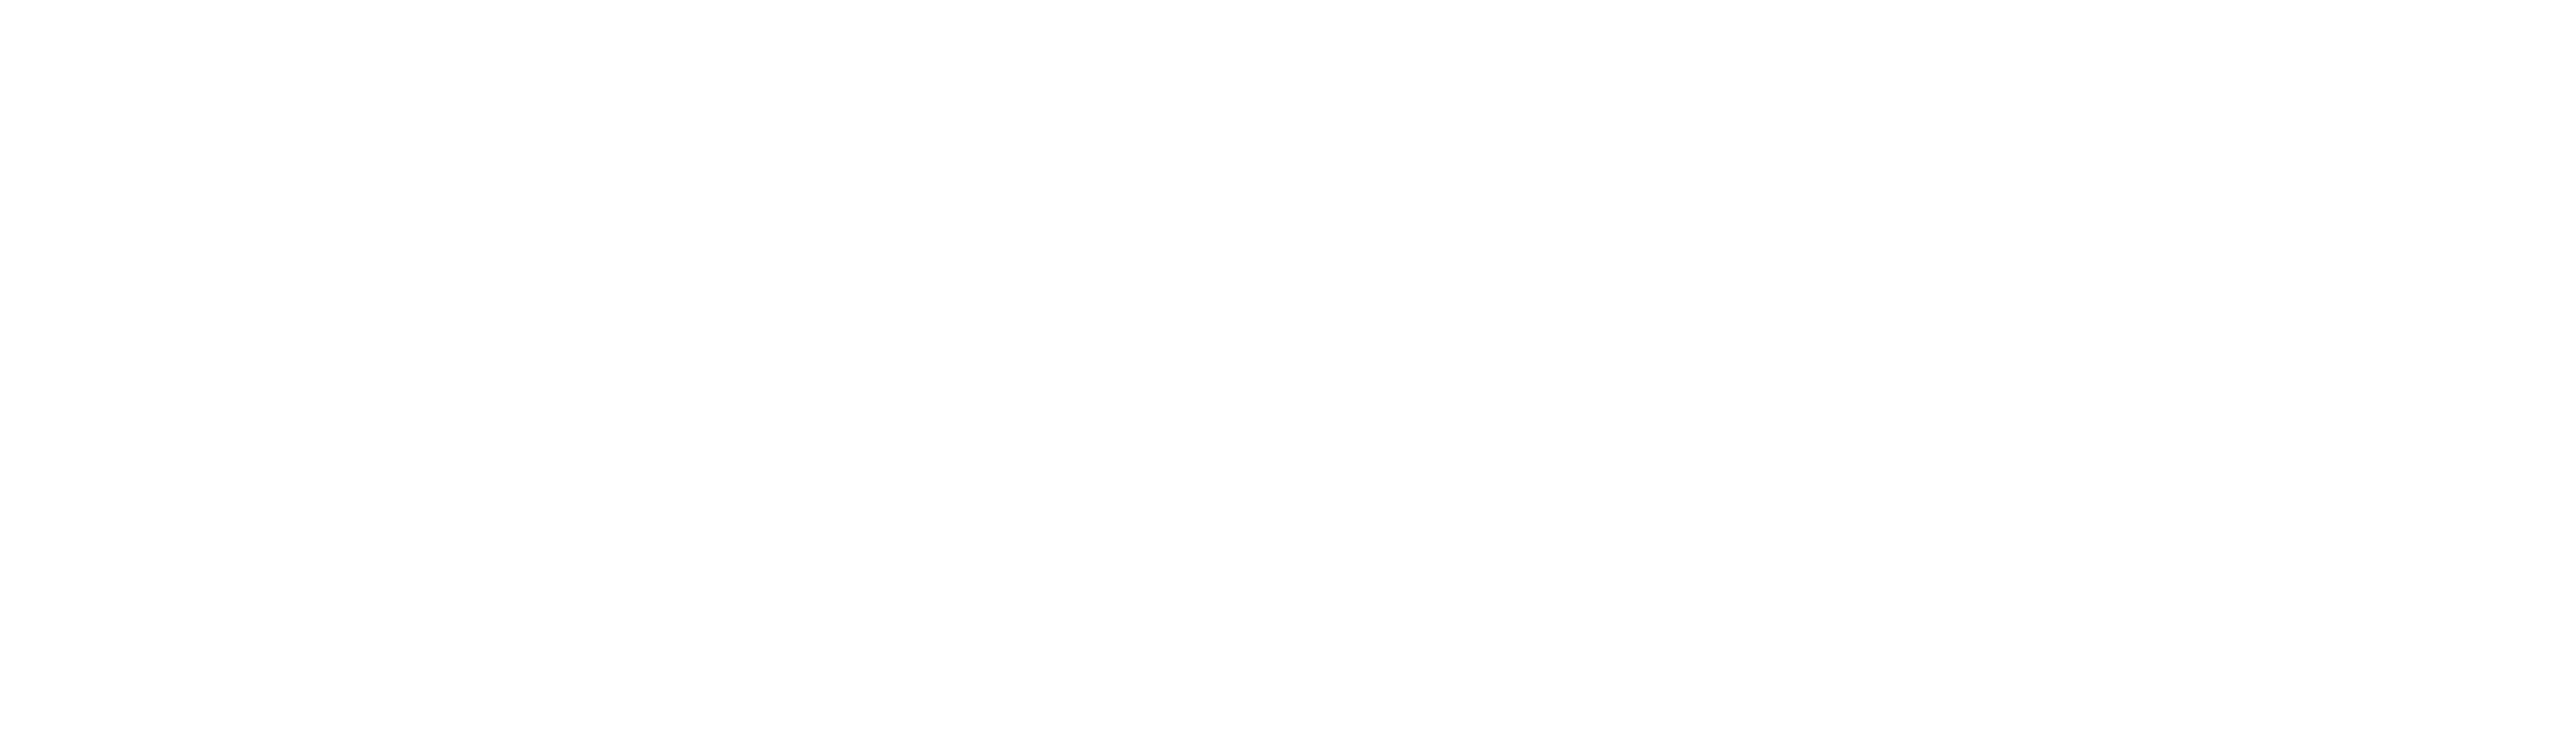

a370_SN_sourceplane/alfa_fits/Spectra_bin_2_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


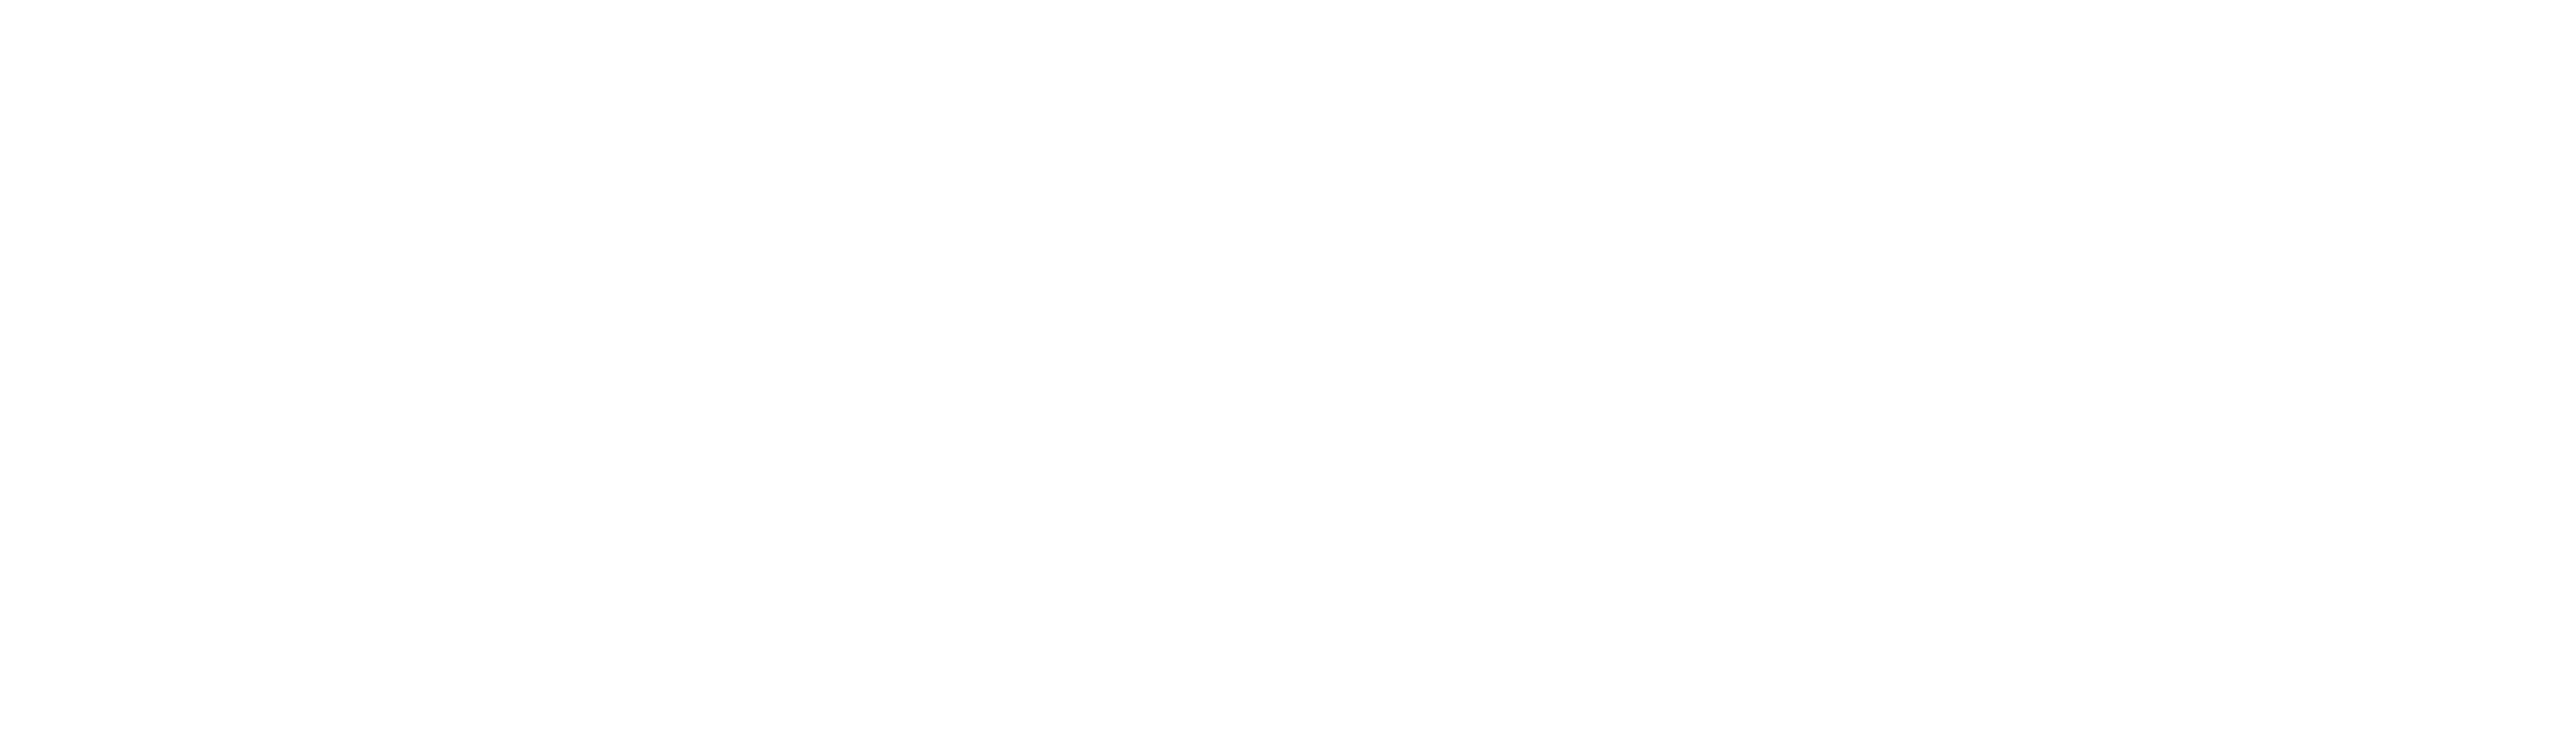

a370_SN_sourceplane/alfa_fits/Spectra_bin_30_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


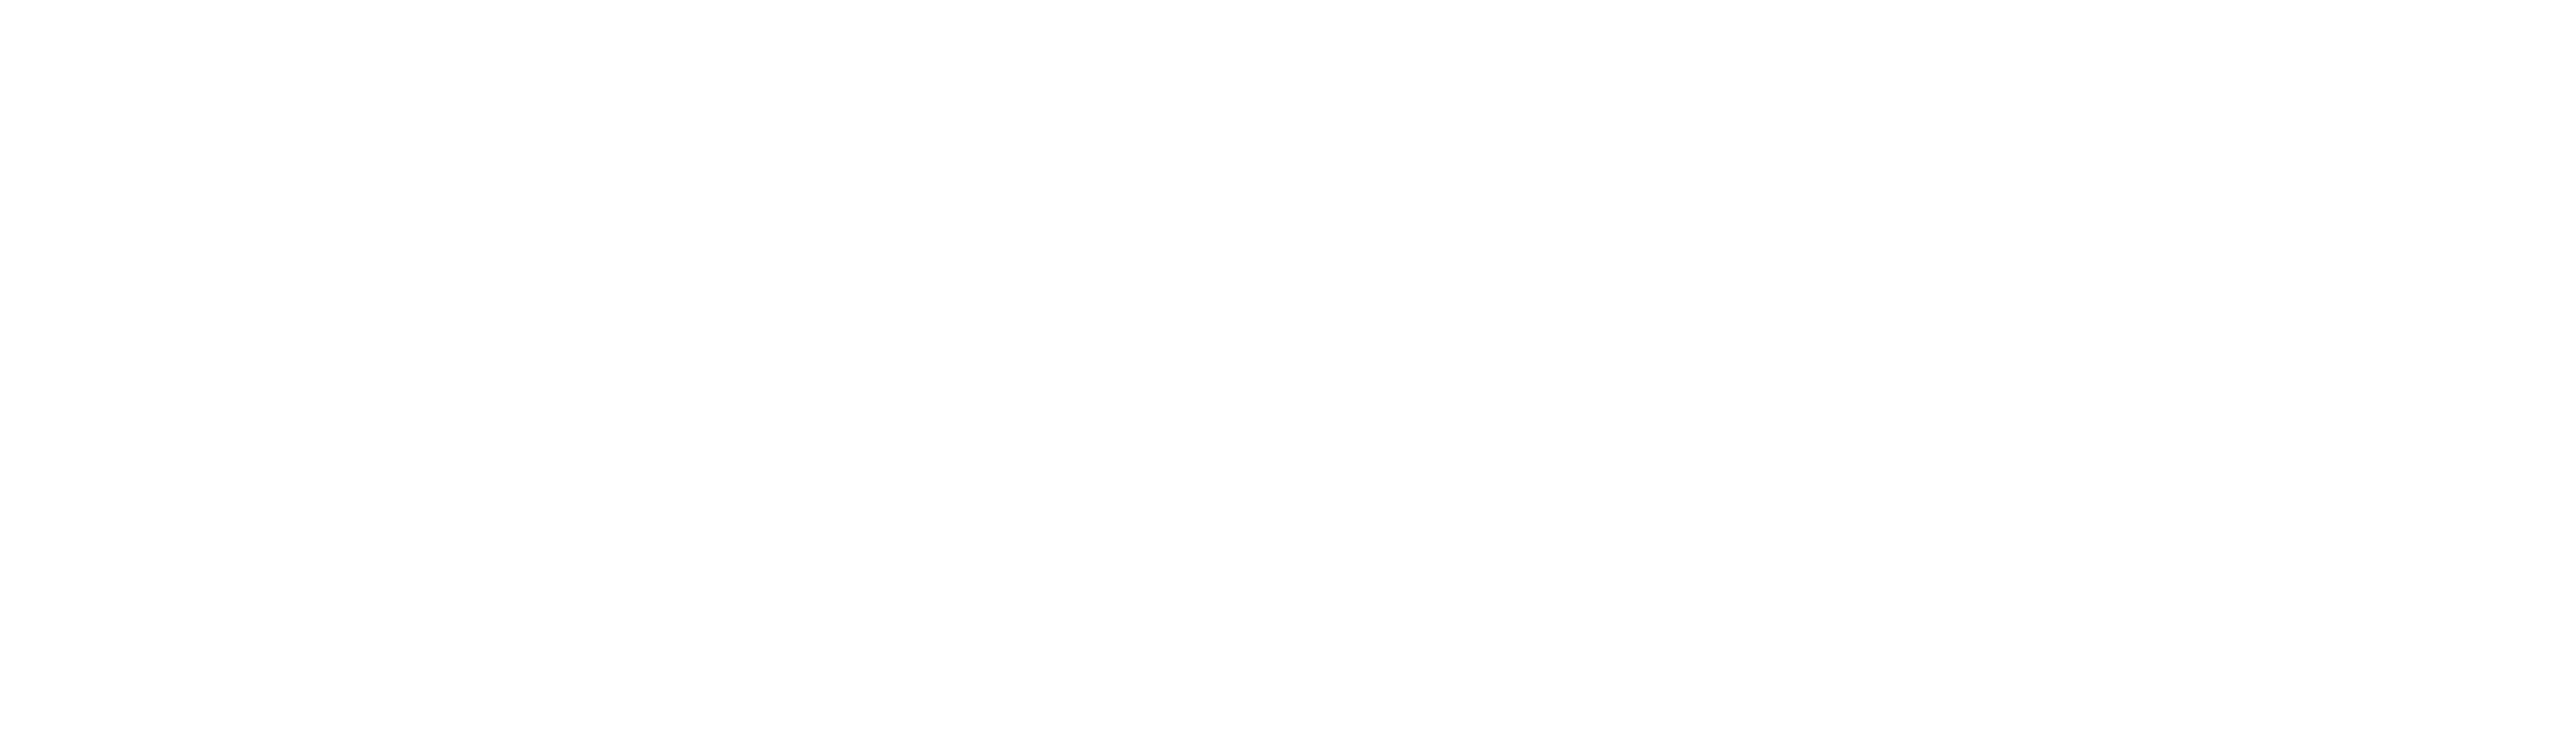

a370_SN_sourceplane/alfa_fits/Spectra_bin_31_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


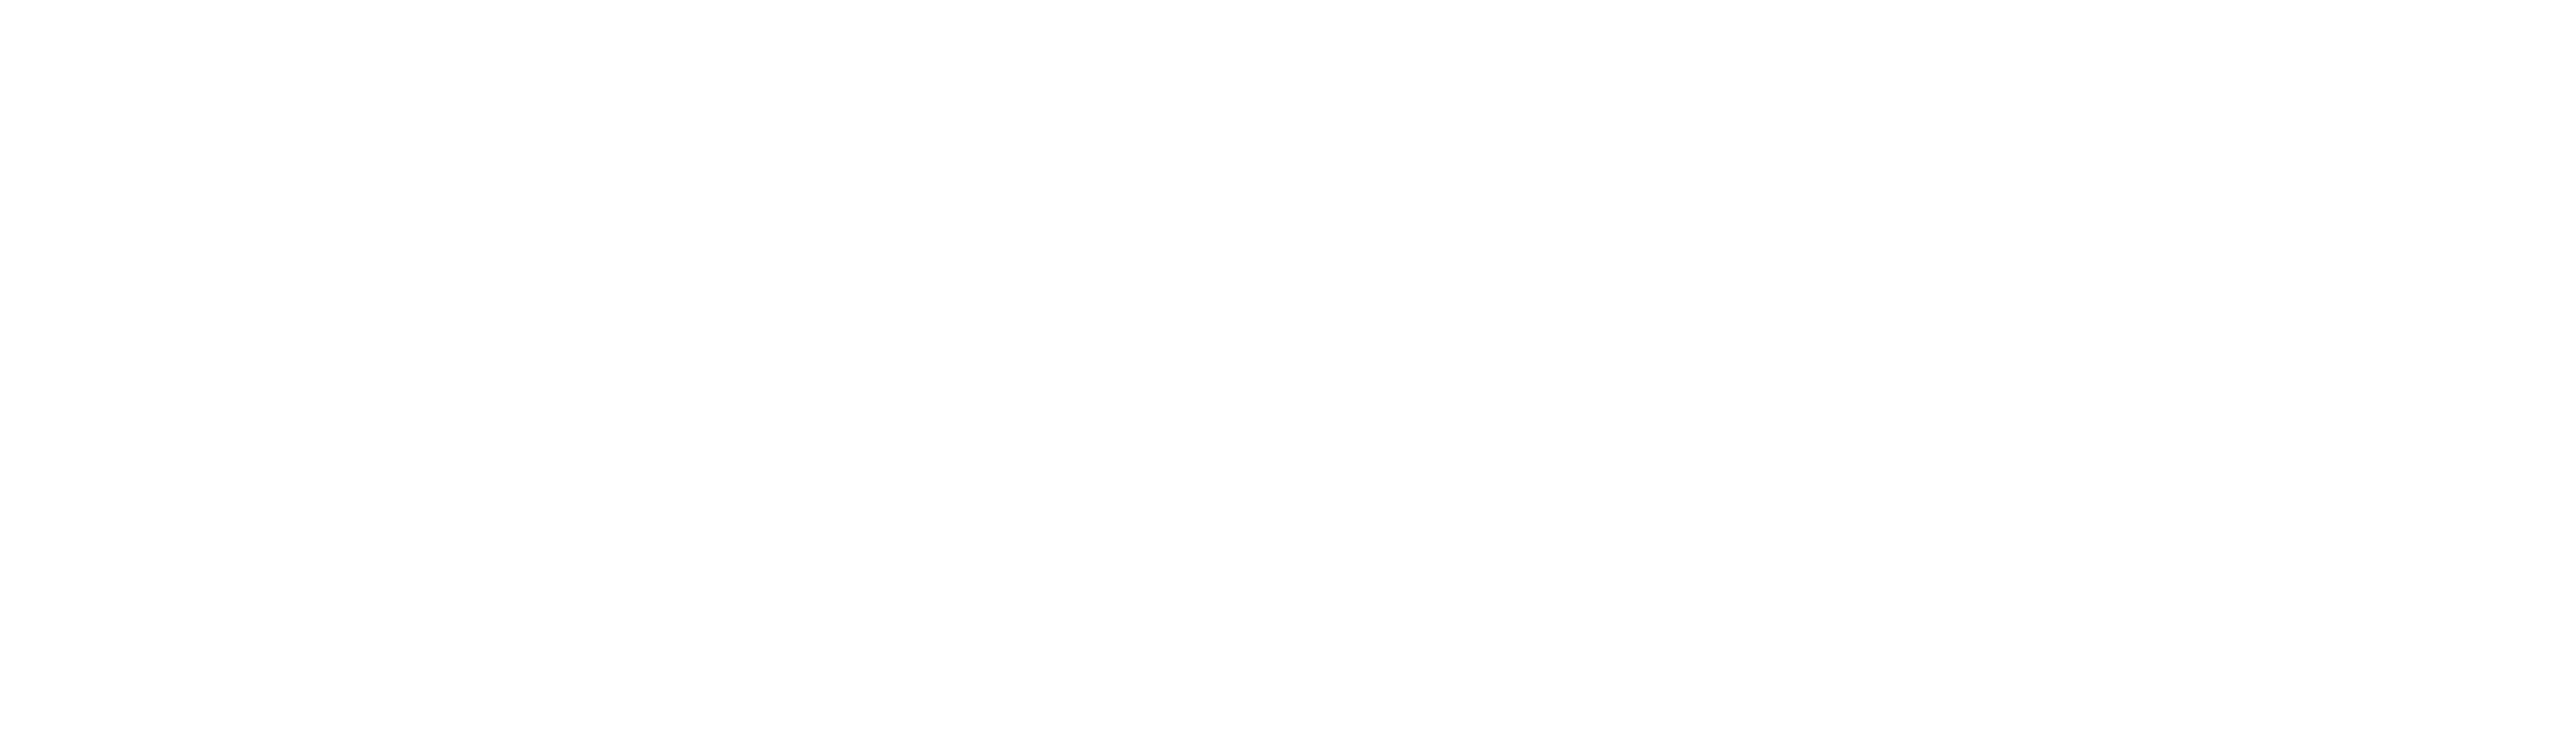

a370_SN_sourceplane/alfa_fits/Spectra_bin_32_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


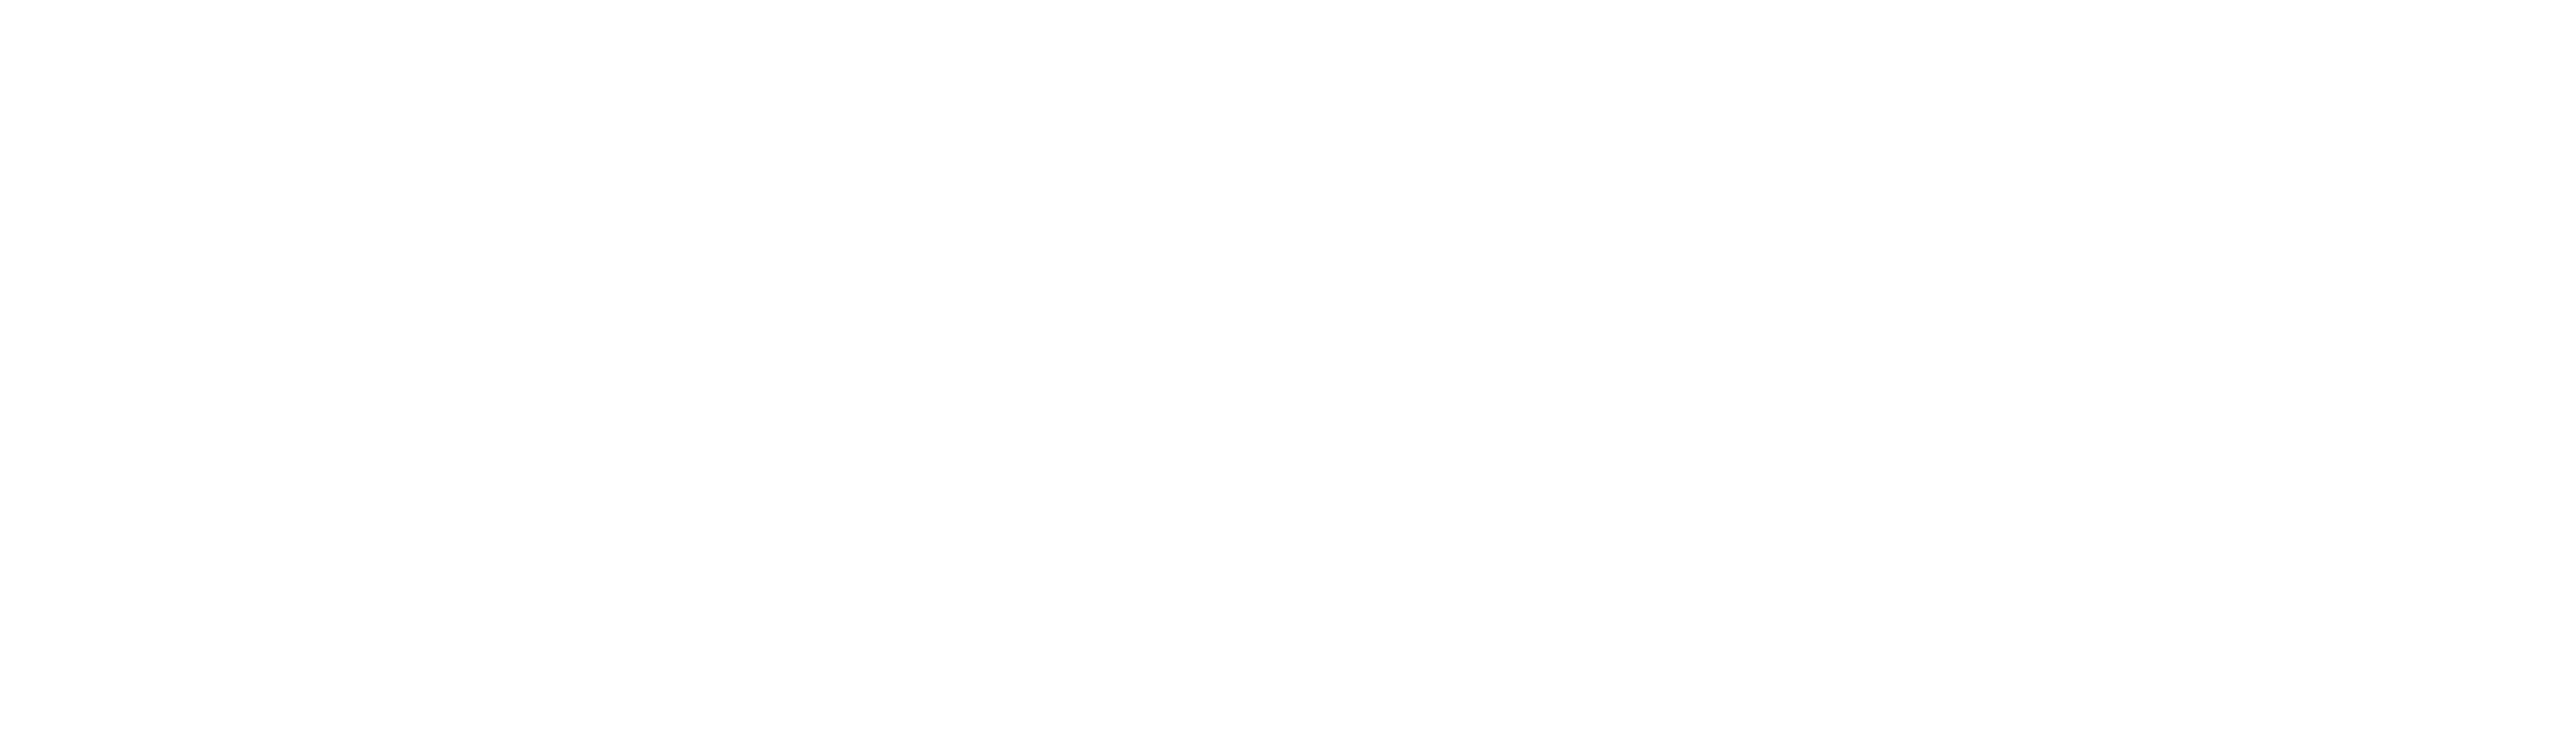

a370_SN_sourceplane/alfa_fits/Spectra_bin_33_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


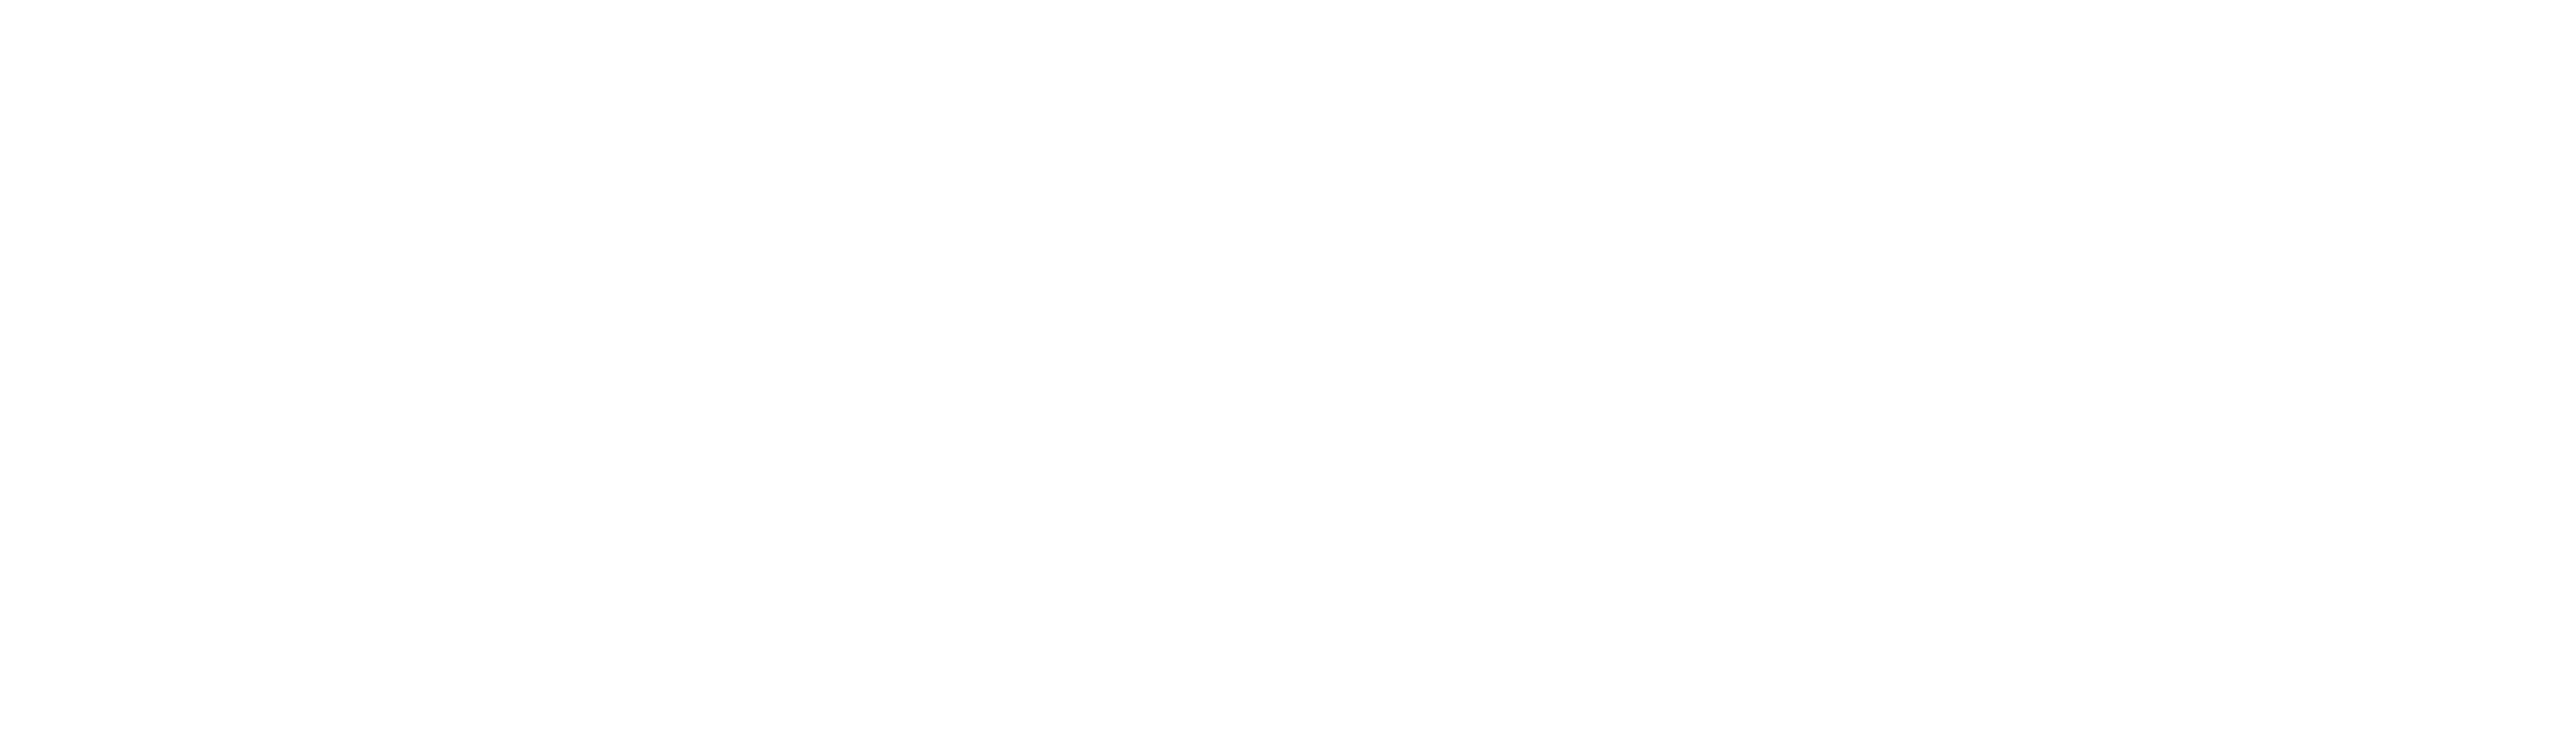

a370_SN_sourceplane/alfa_fits/Spectra_bin_34_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


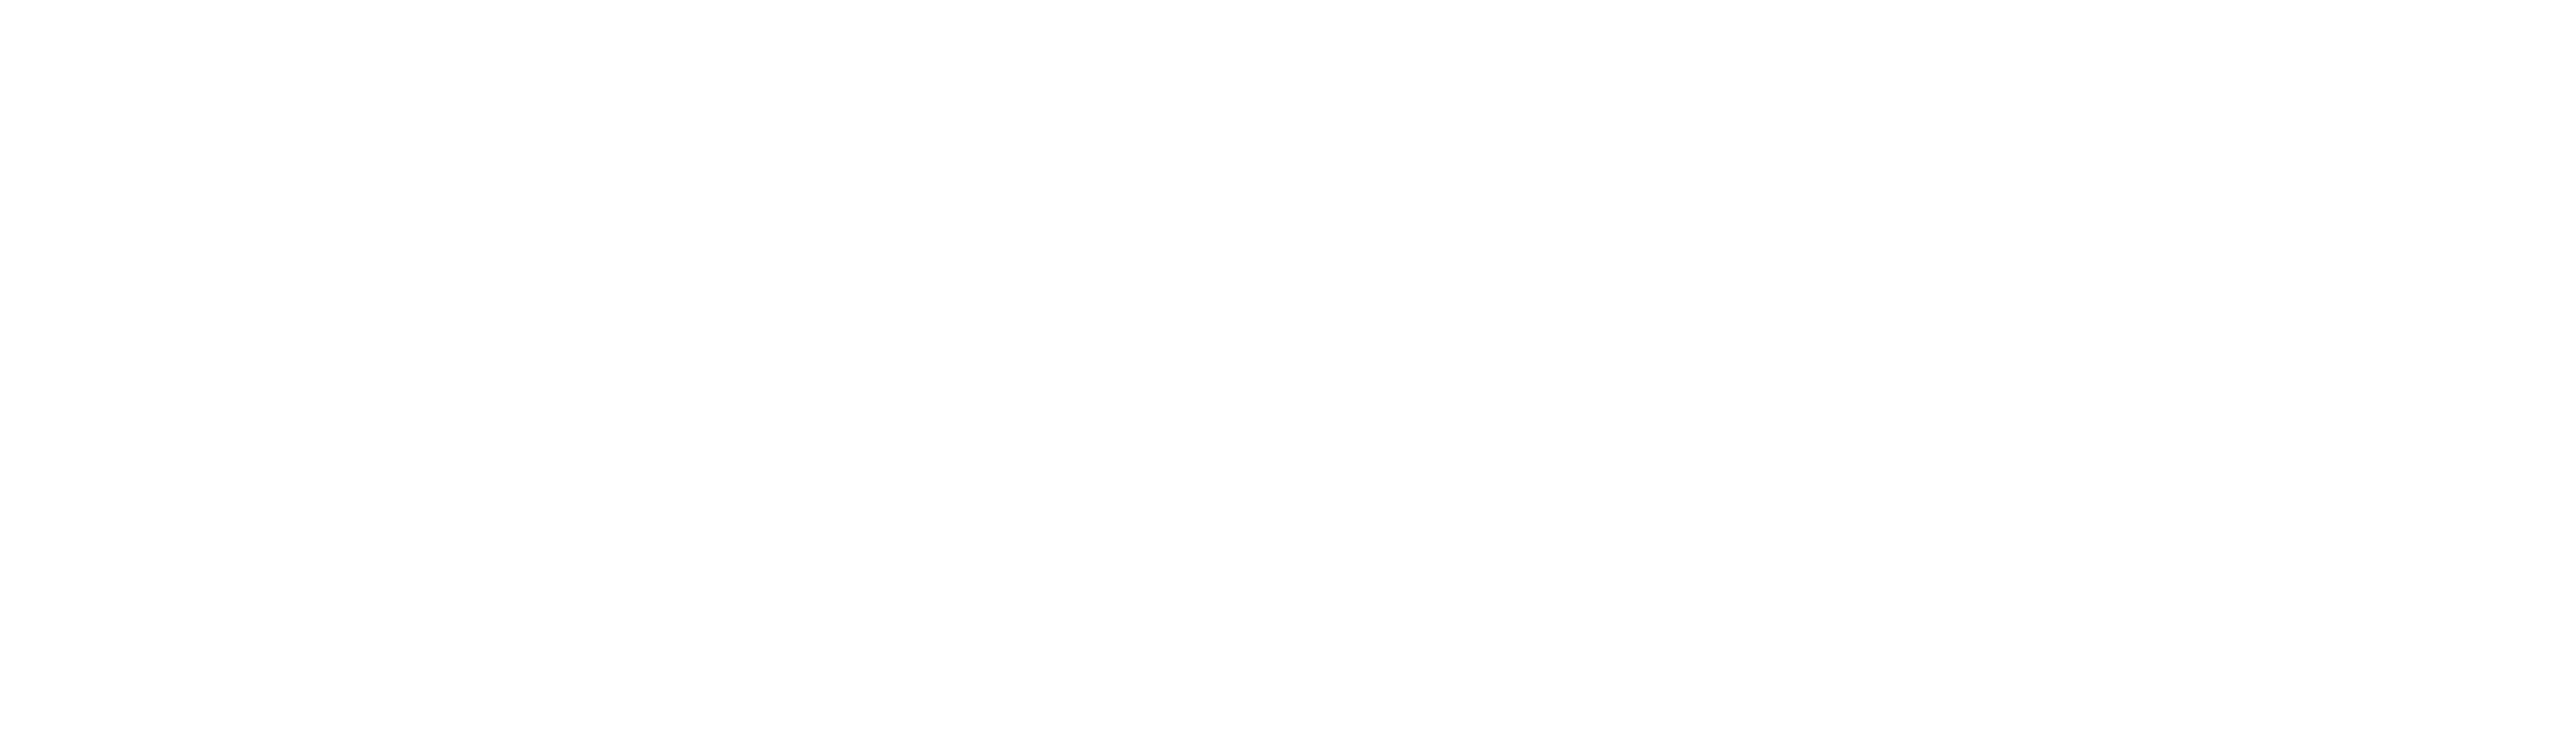

a370_SN_sourceplane/alfa_fits/Spectra_bin_35_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


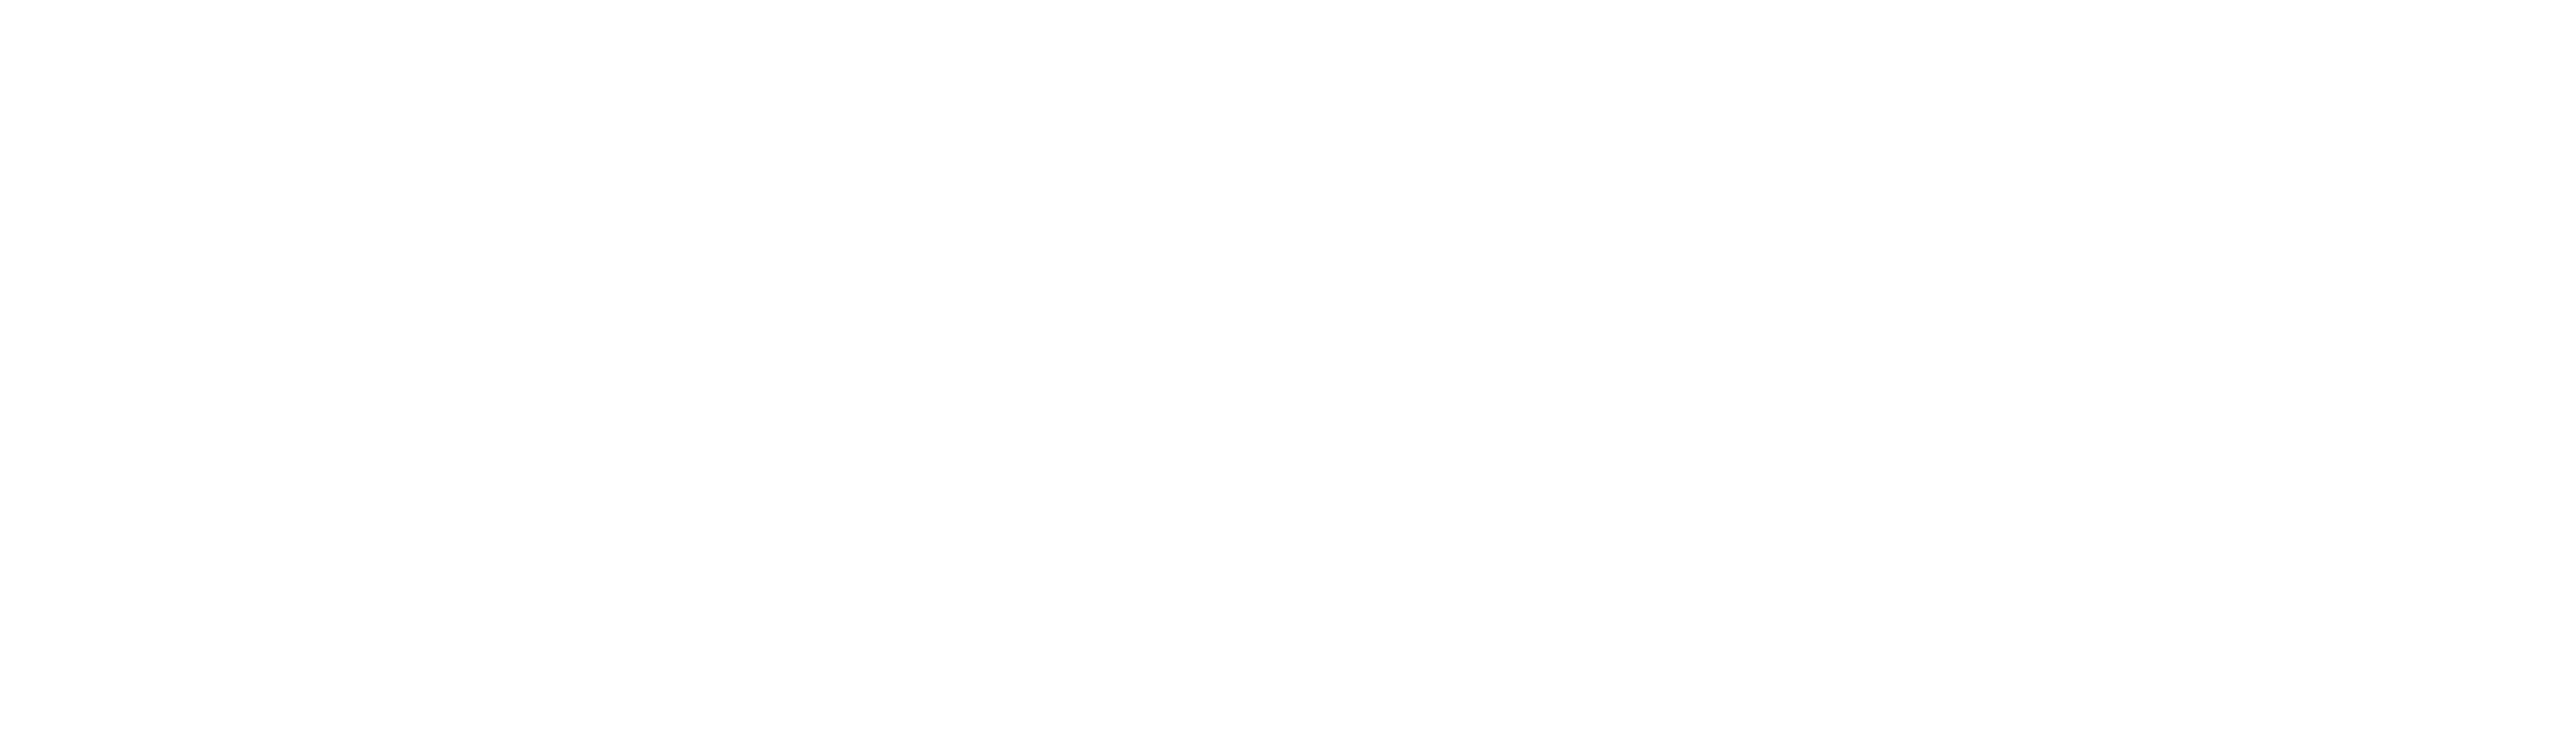

a370_SN_sourceplane/alfa_fits/Spectra_bin_36_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


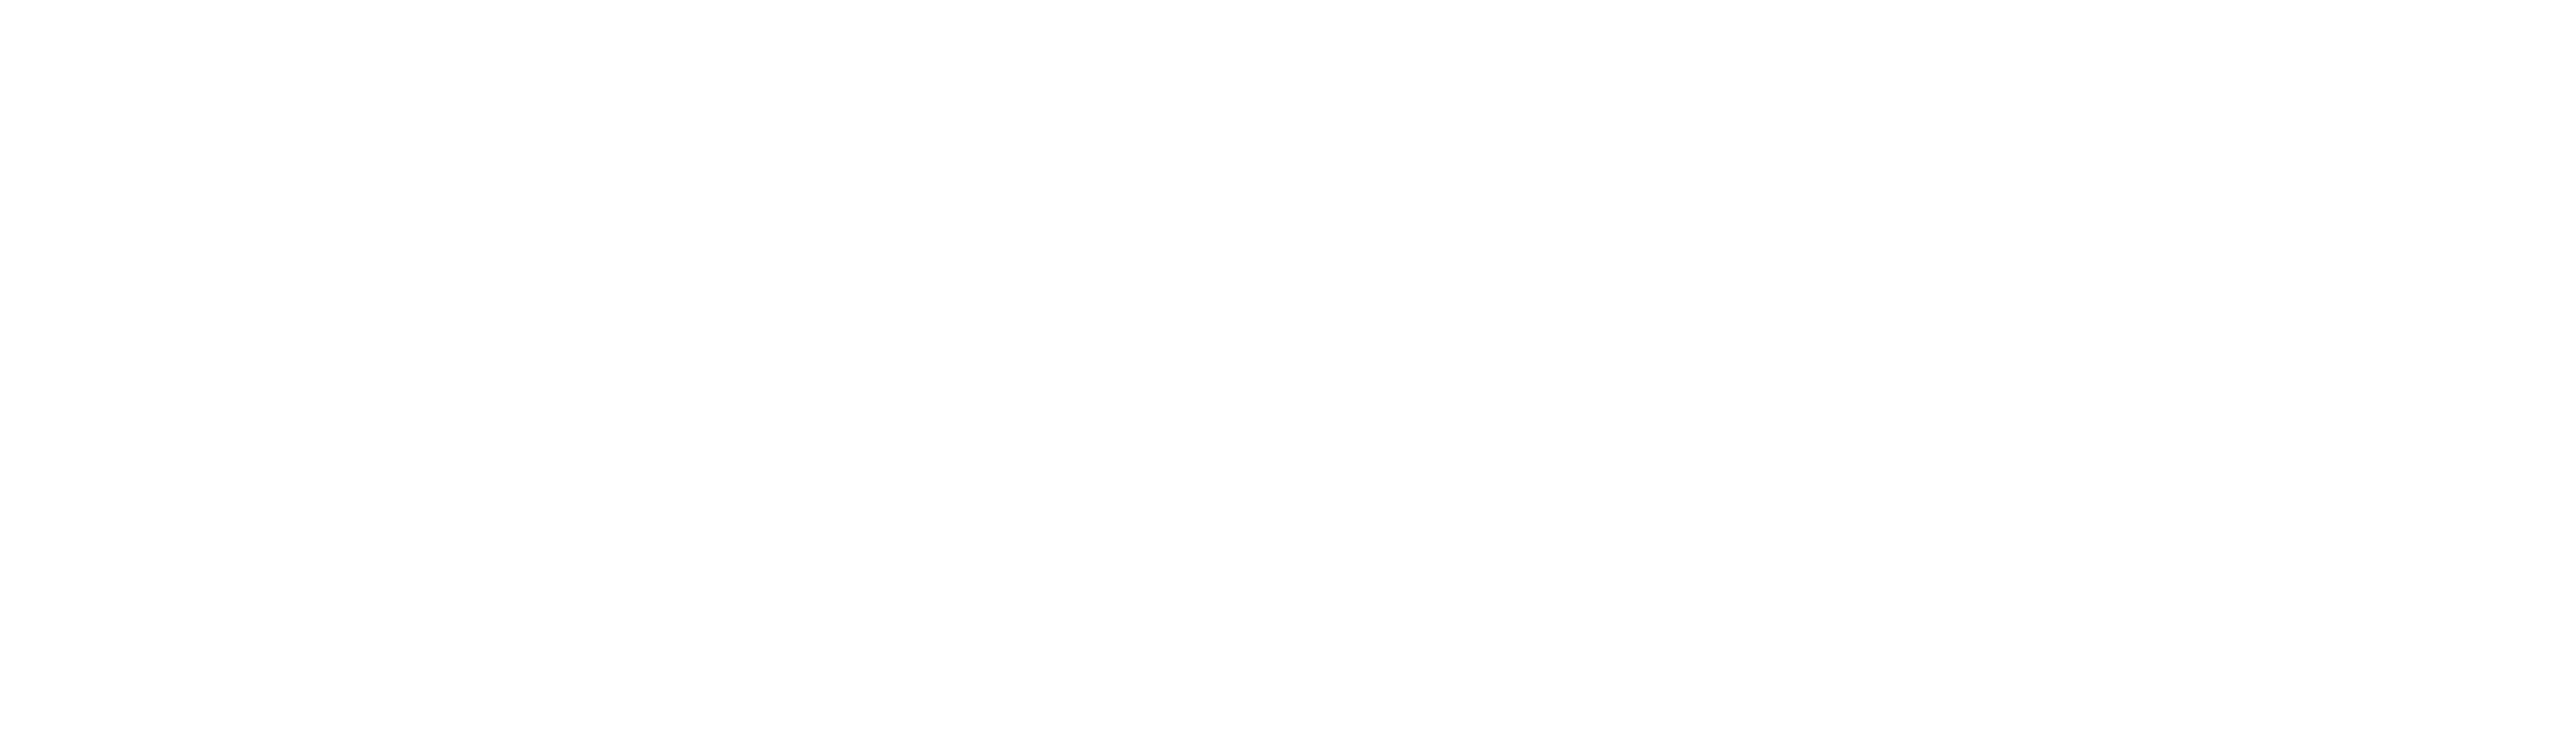

a370_SN_sourceplane/alfa_fits/Spectra_bin_37_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


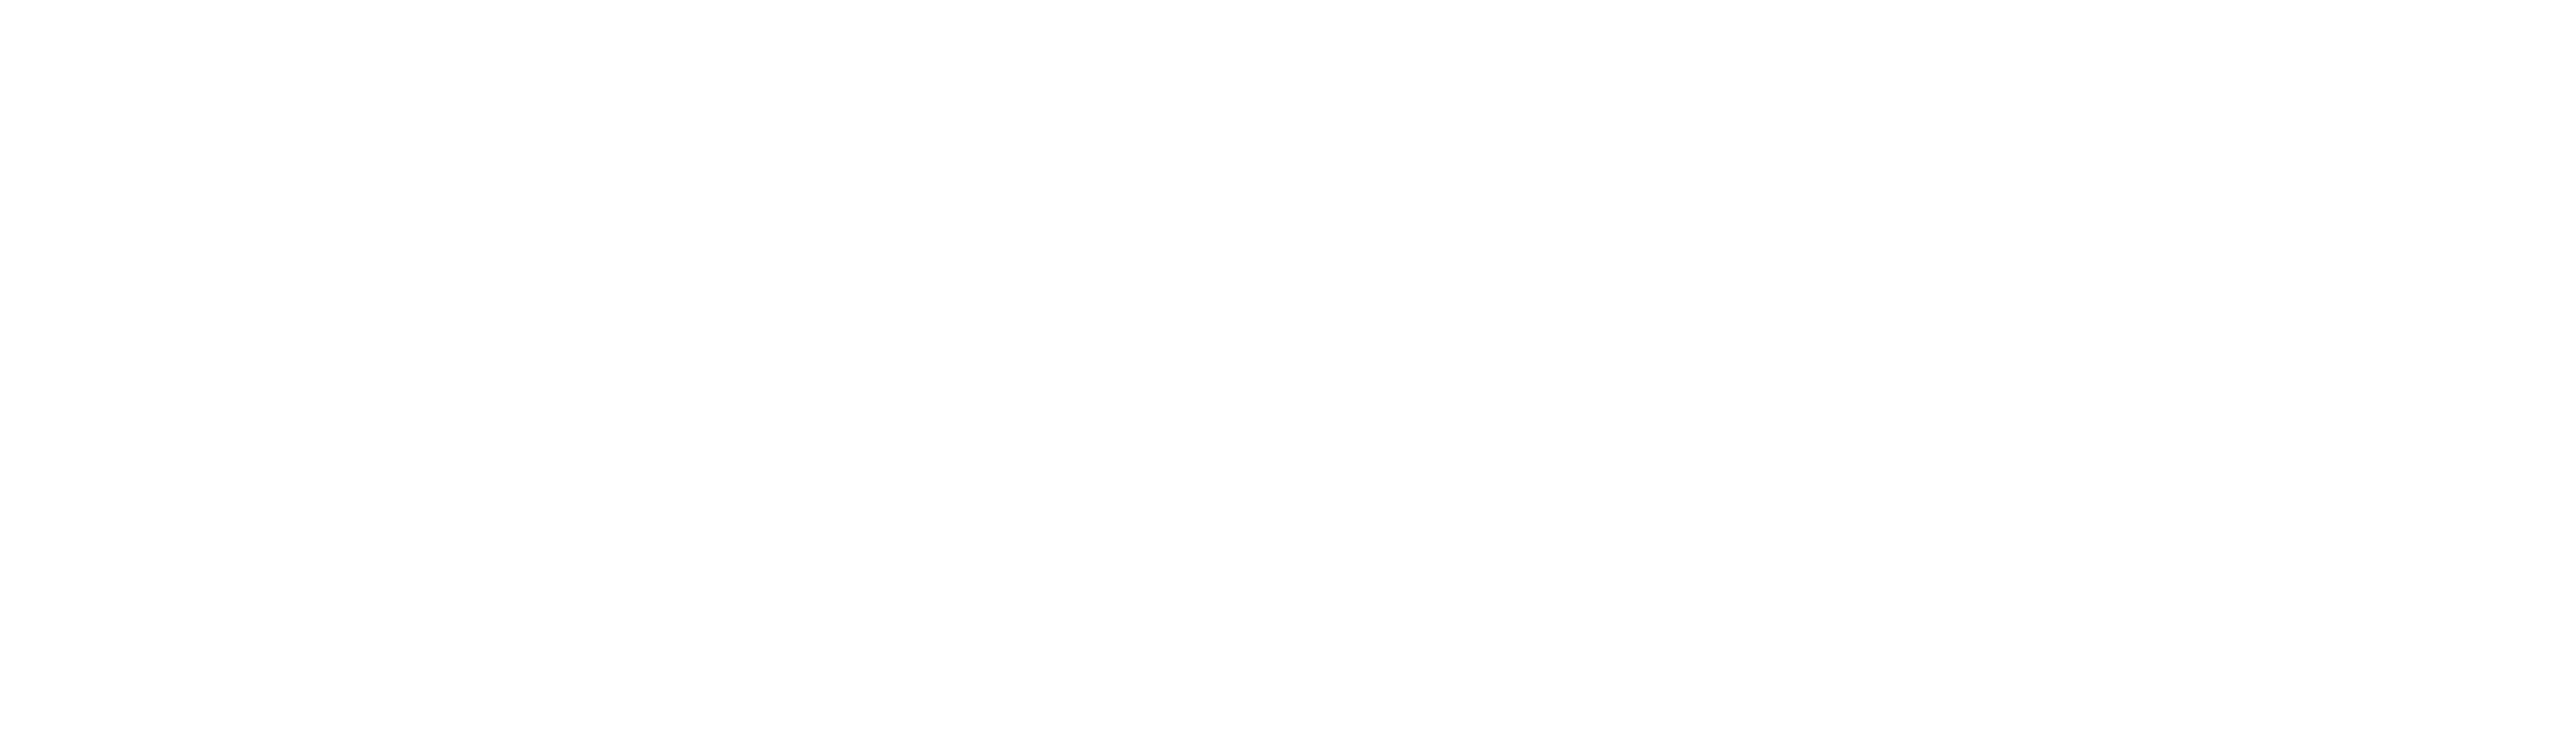

a370_SN_sourceplane/alfa_fits/Spectra_bin_38_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


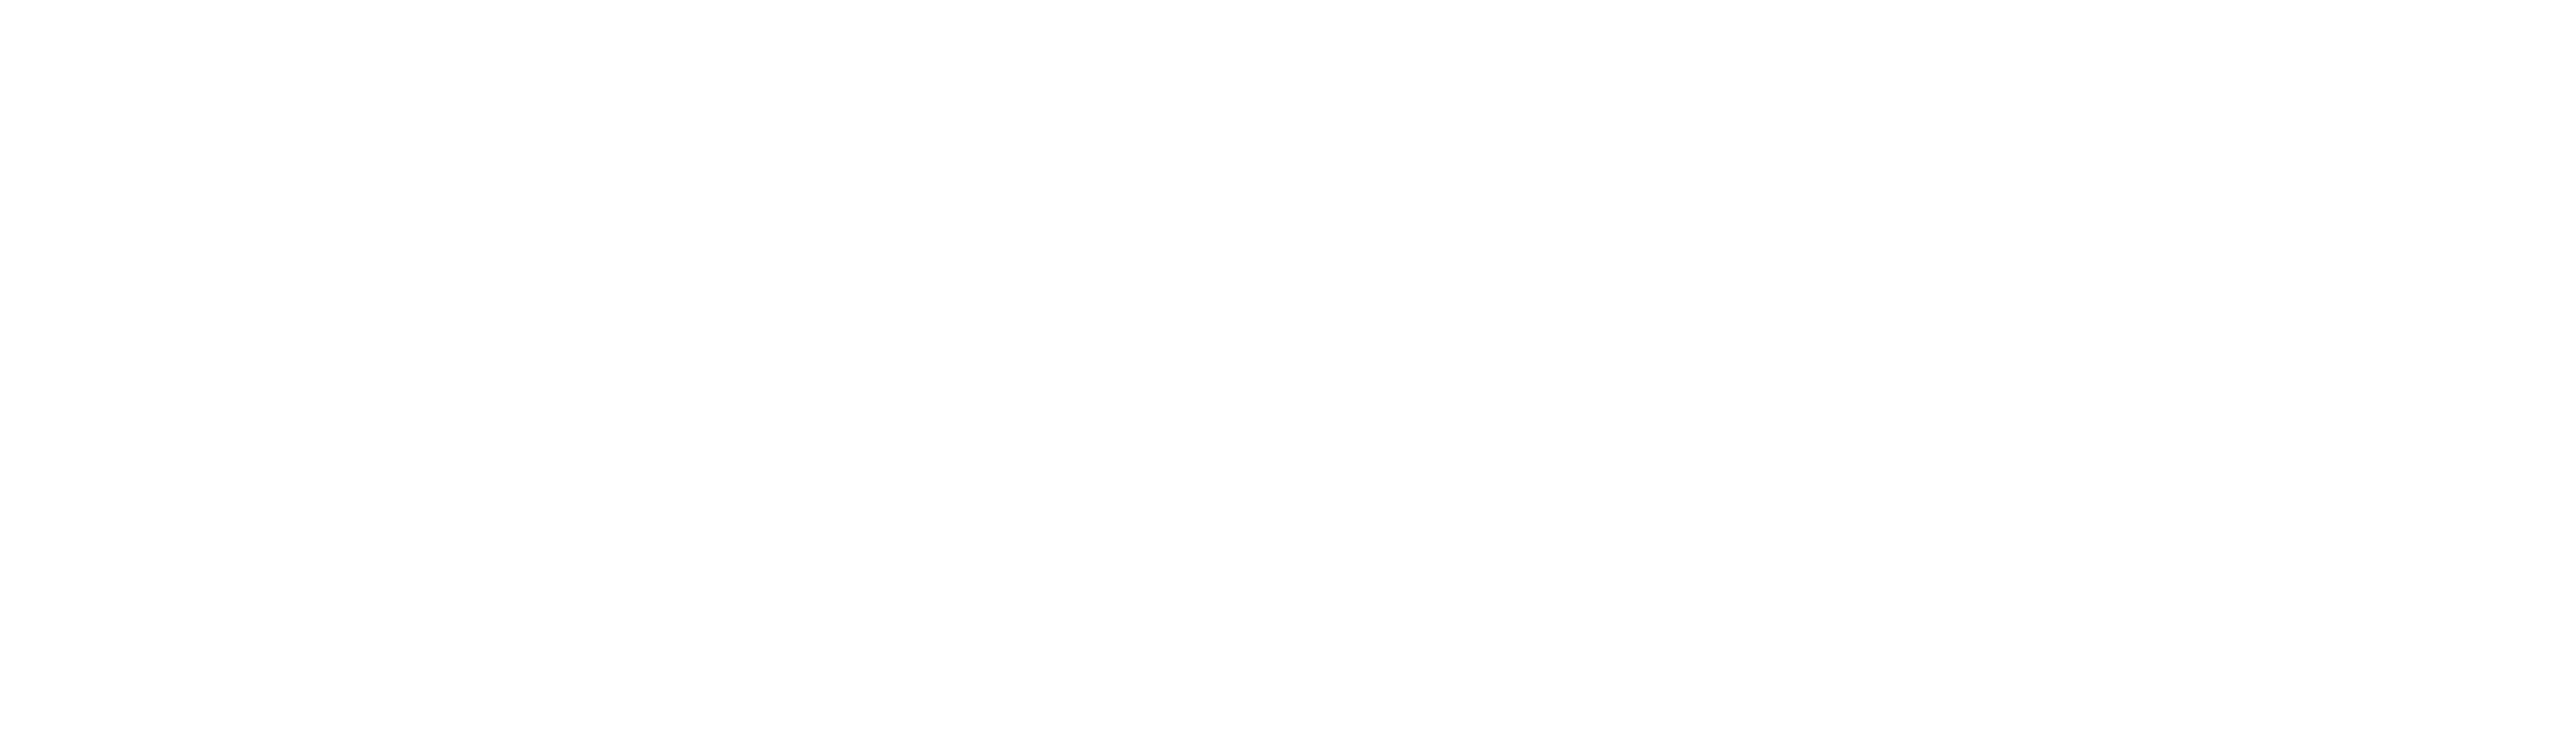

a370_SN_sourceplane/alfa_fits/Spectra_bin_39_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


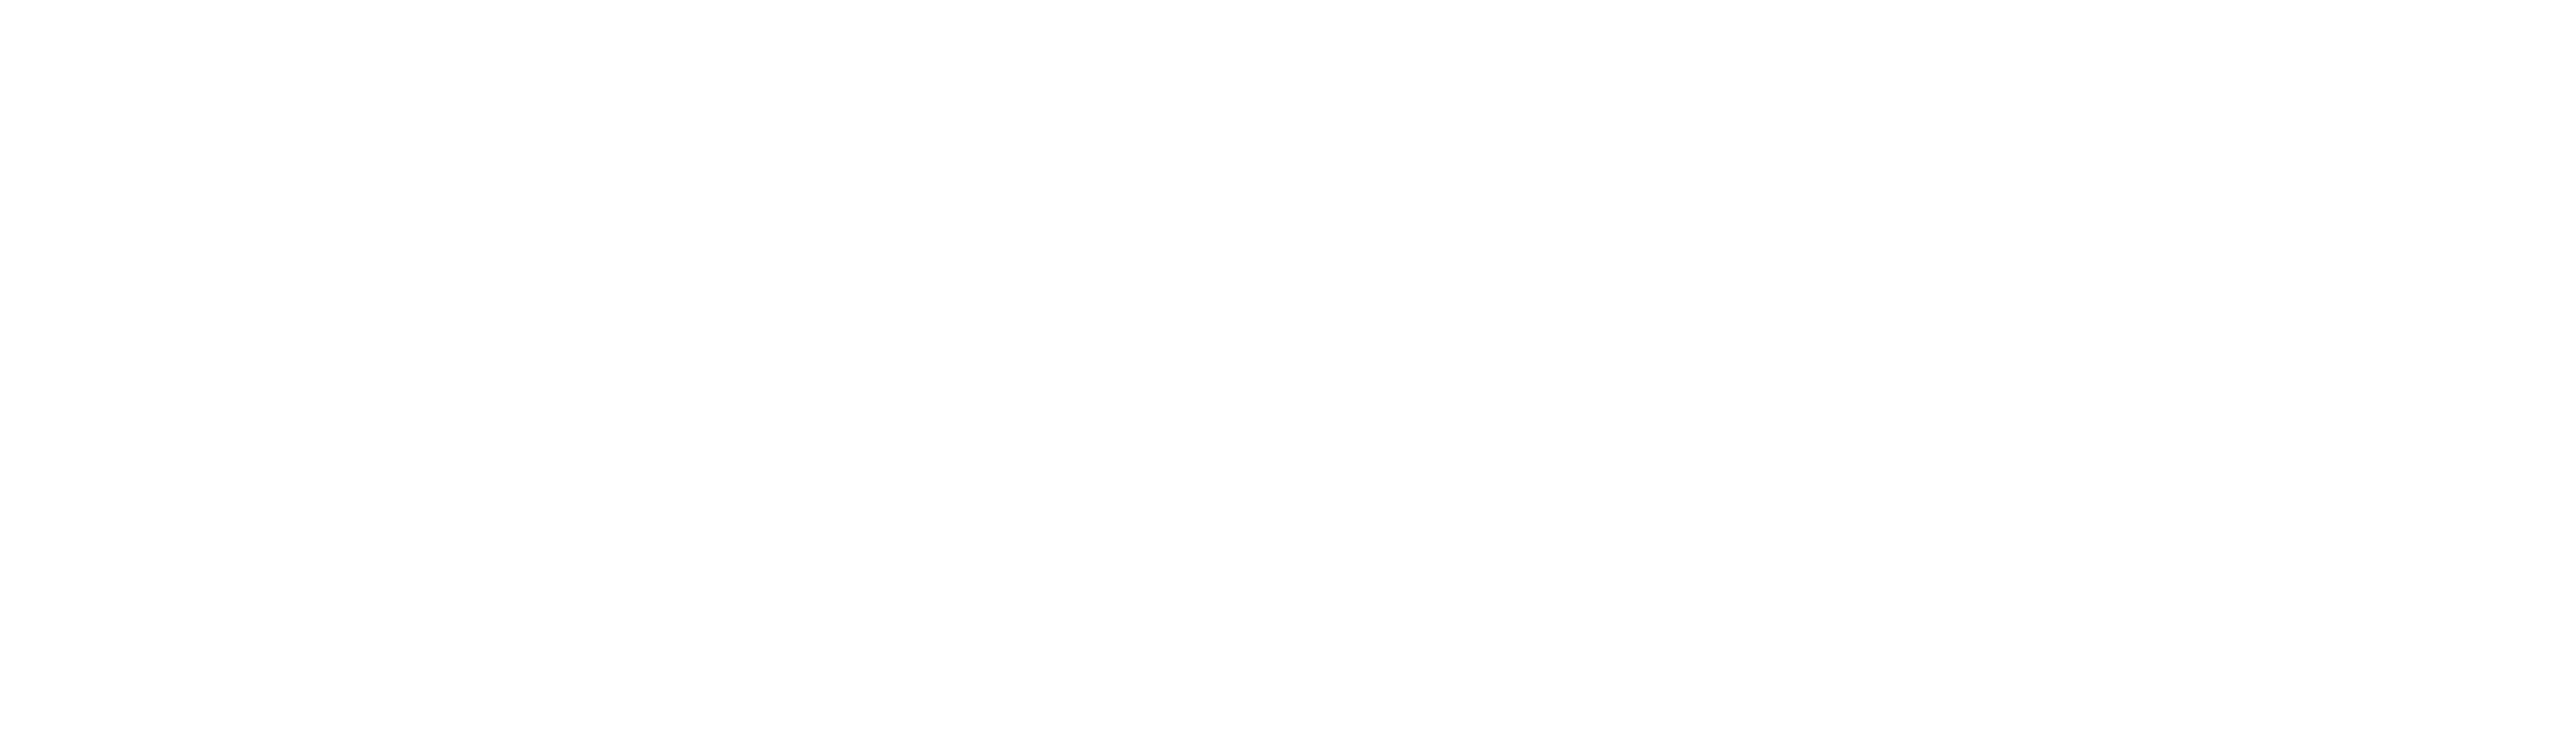

a370_SN_sourceplane/alfa_fits/Spectra_bin_3_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


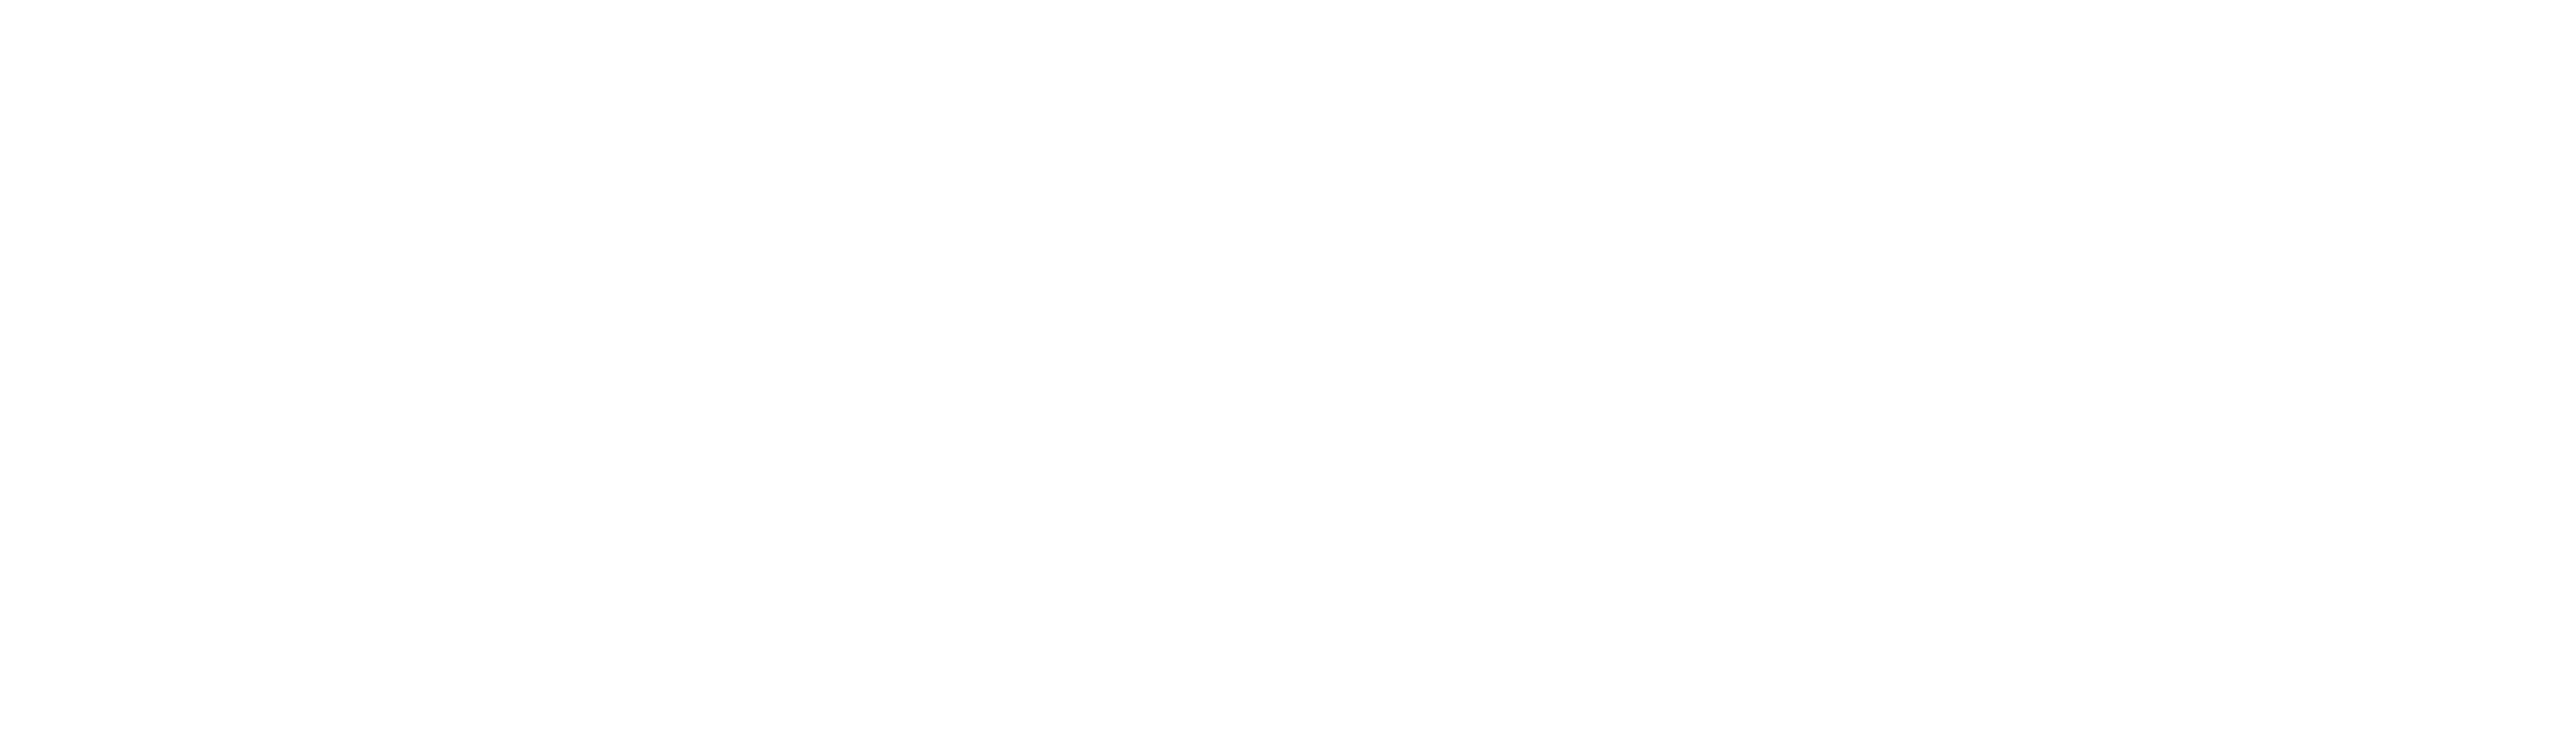

a370_SN_sourceplane/alfa_fits/Spectra_bin_40_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


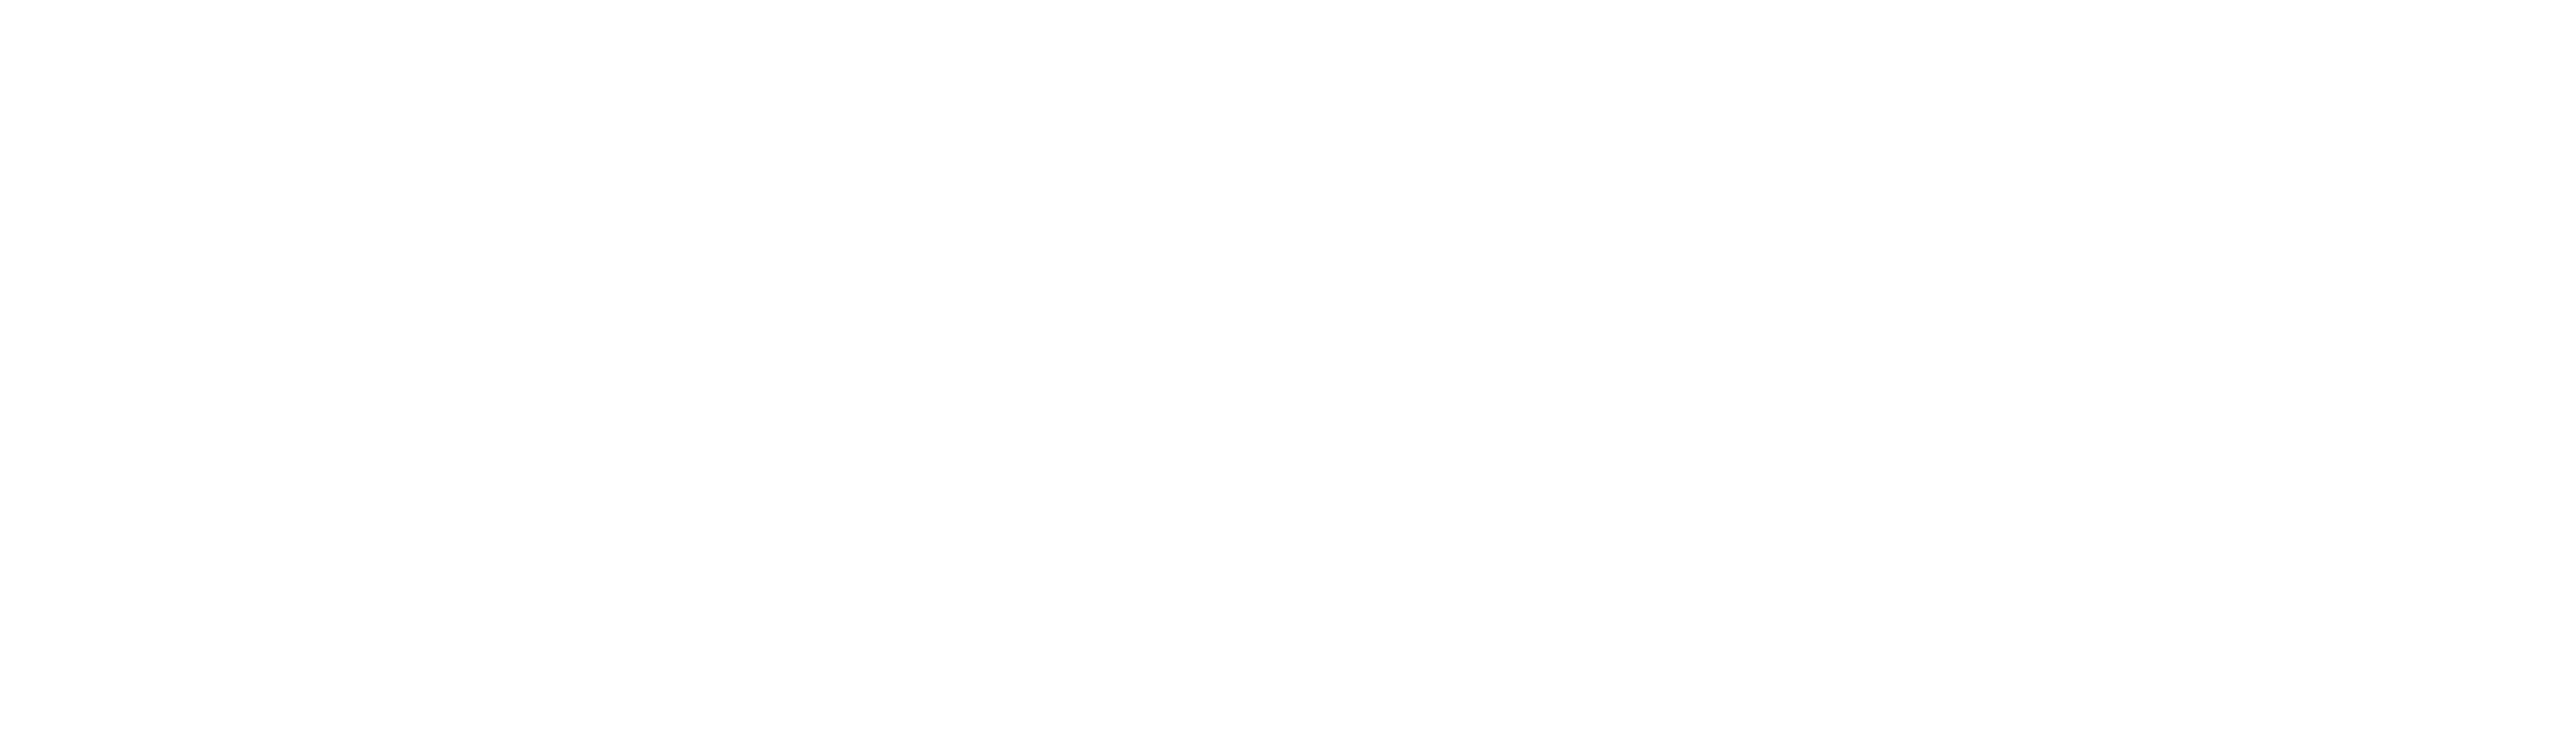

a370_SN_sourceplane/alfa_fits/Spectra_bin_41_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


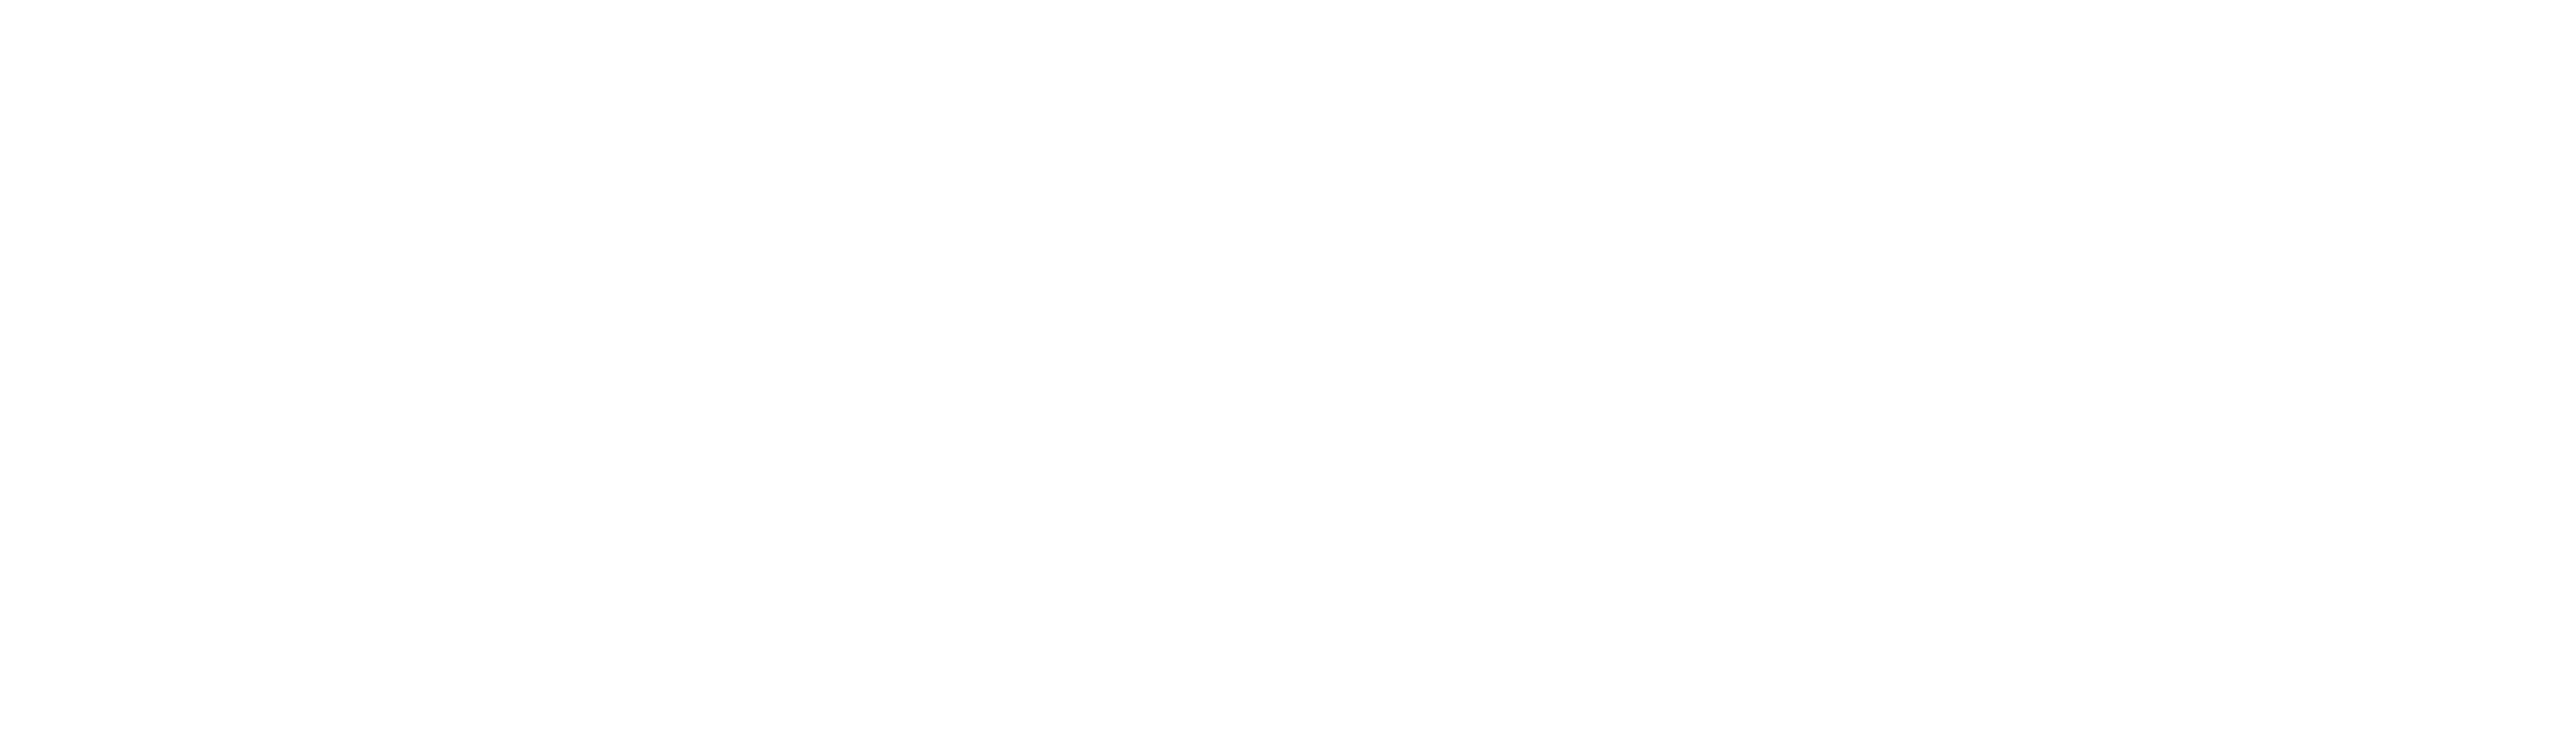

a370_SN_sourceplane/alfa_fits/Spectra_bin_42_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


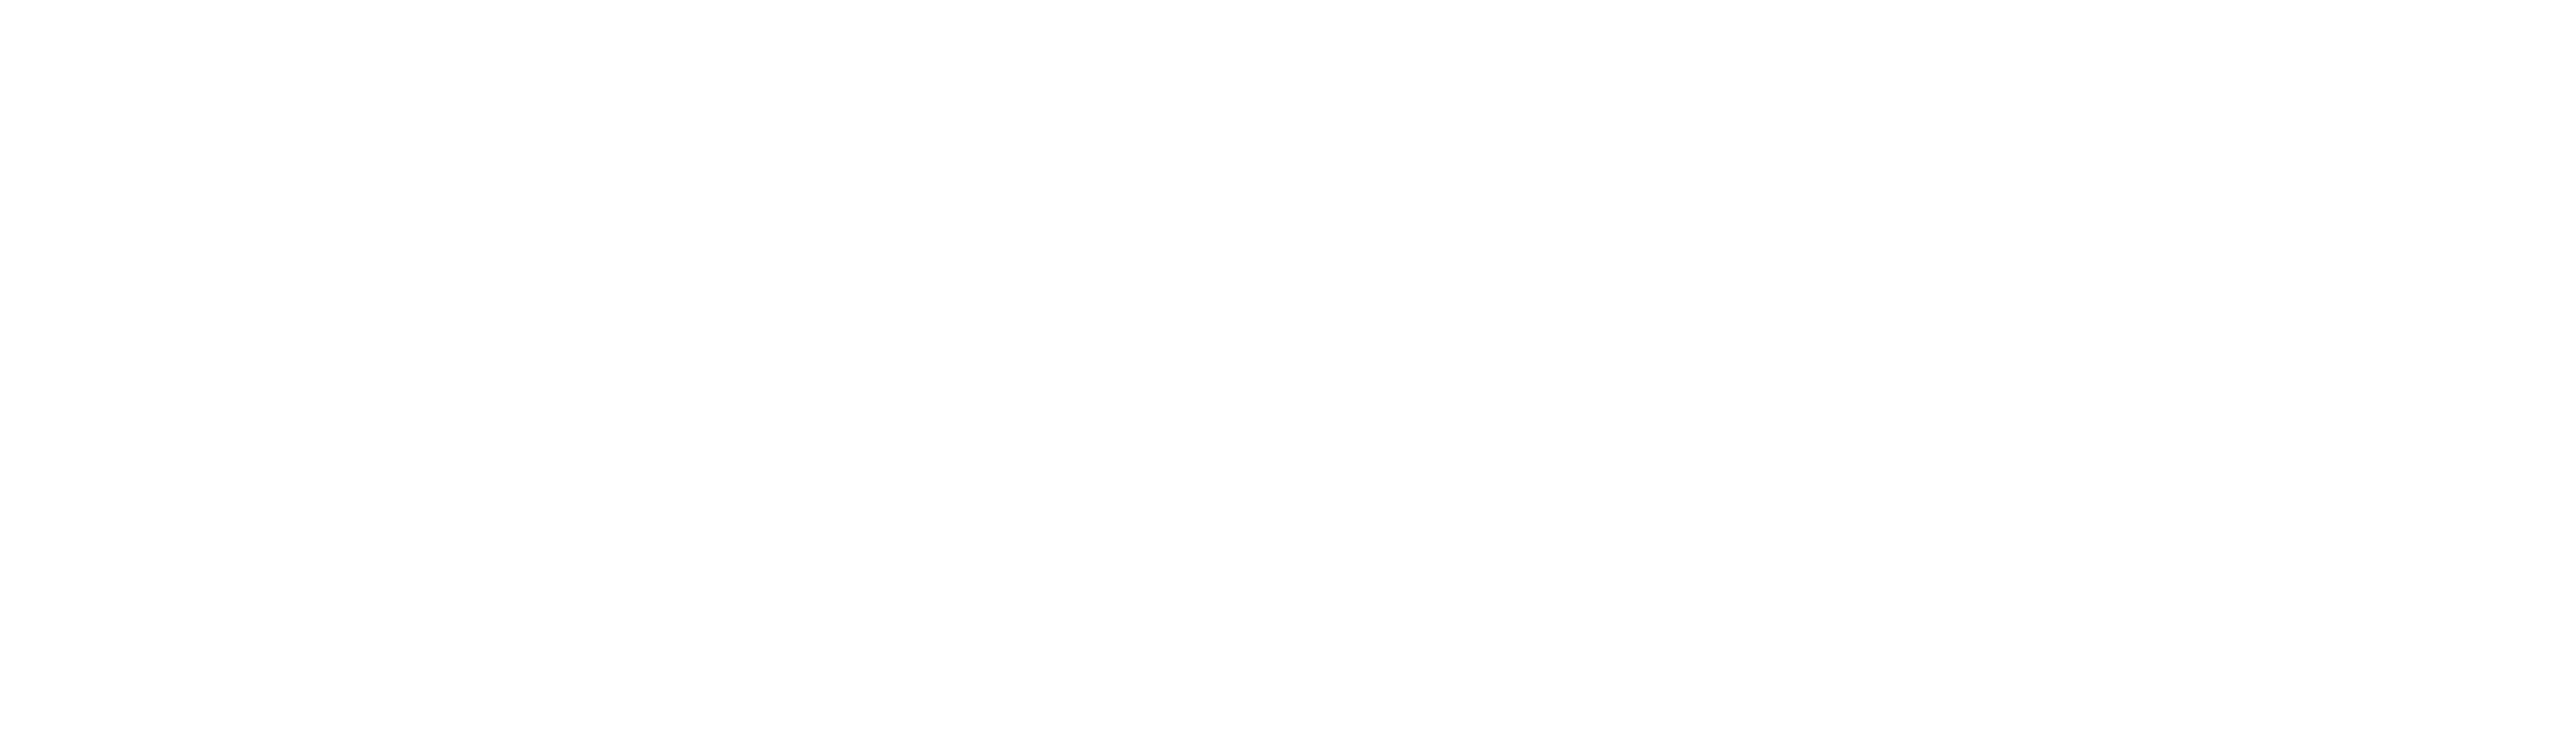

a370_SN_sourceplane/alfa_fits/Spectra_bin_43_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


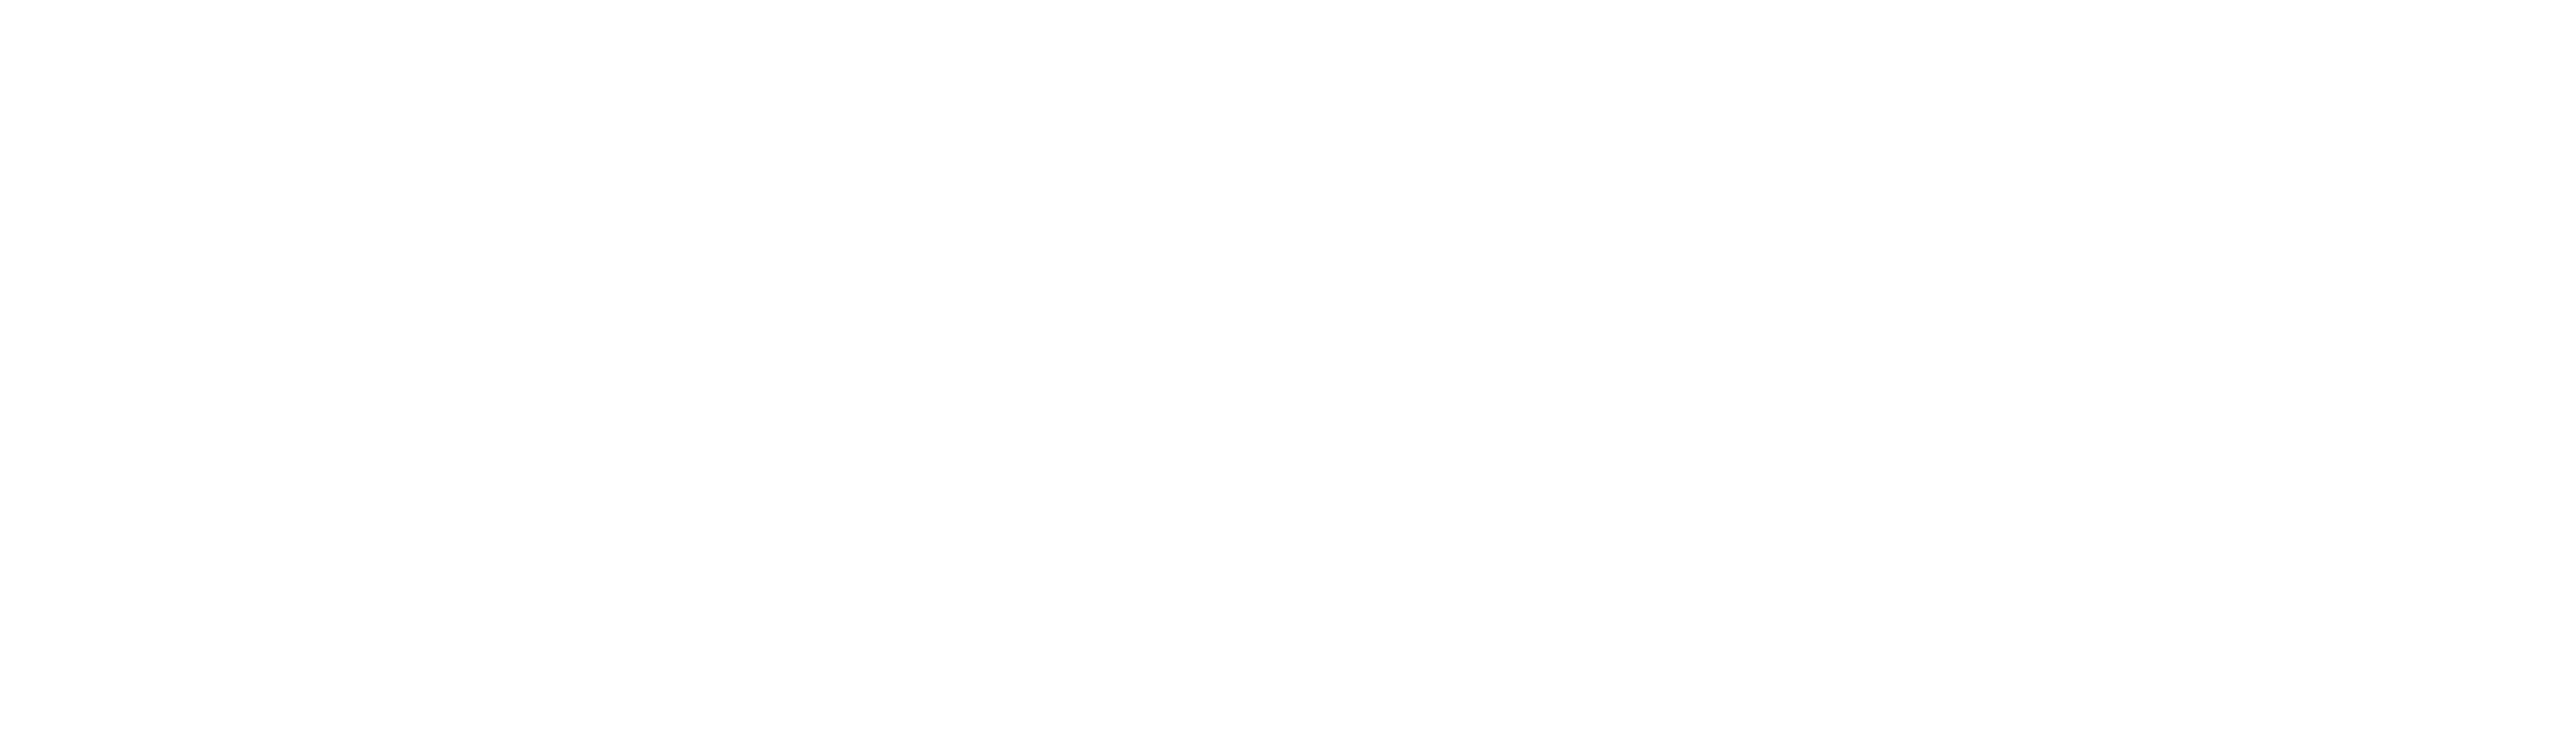

a370_SN_sourceplane/alfa_fits/Spectra_bin_44_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


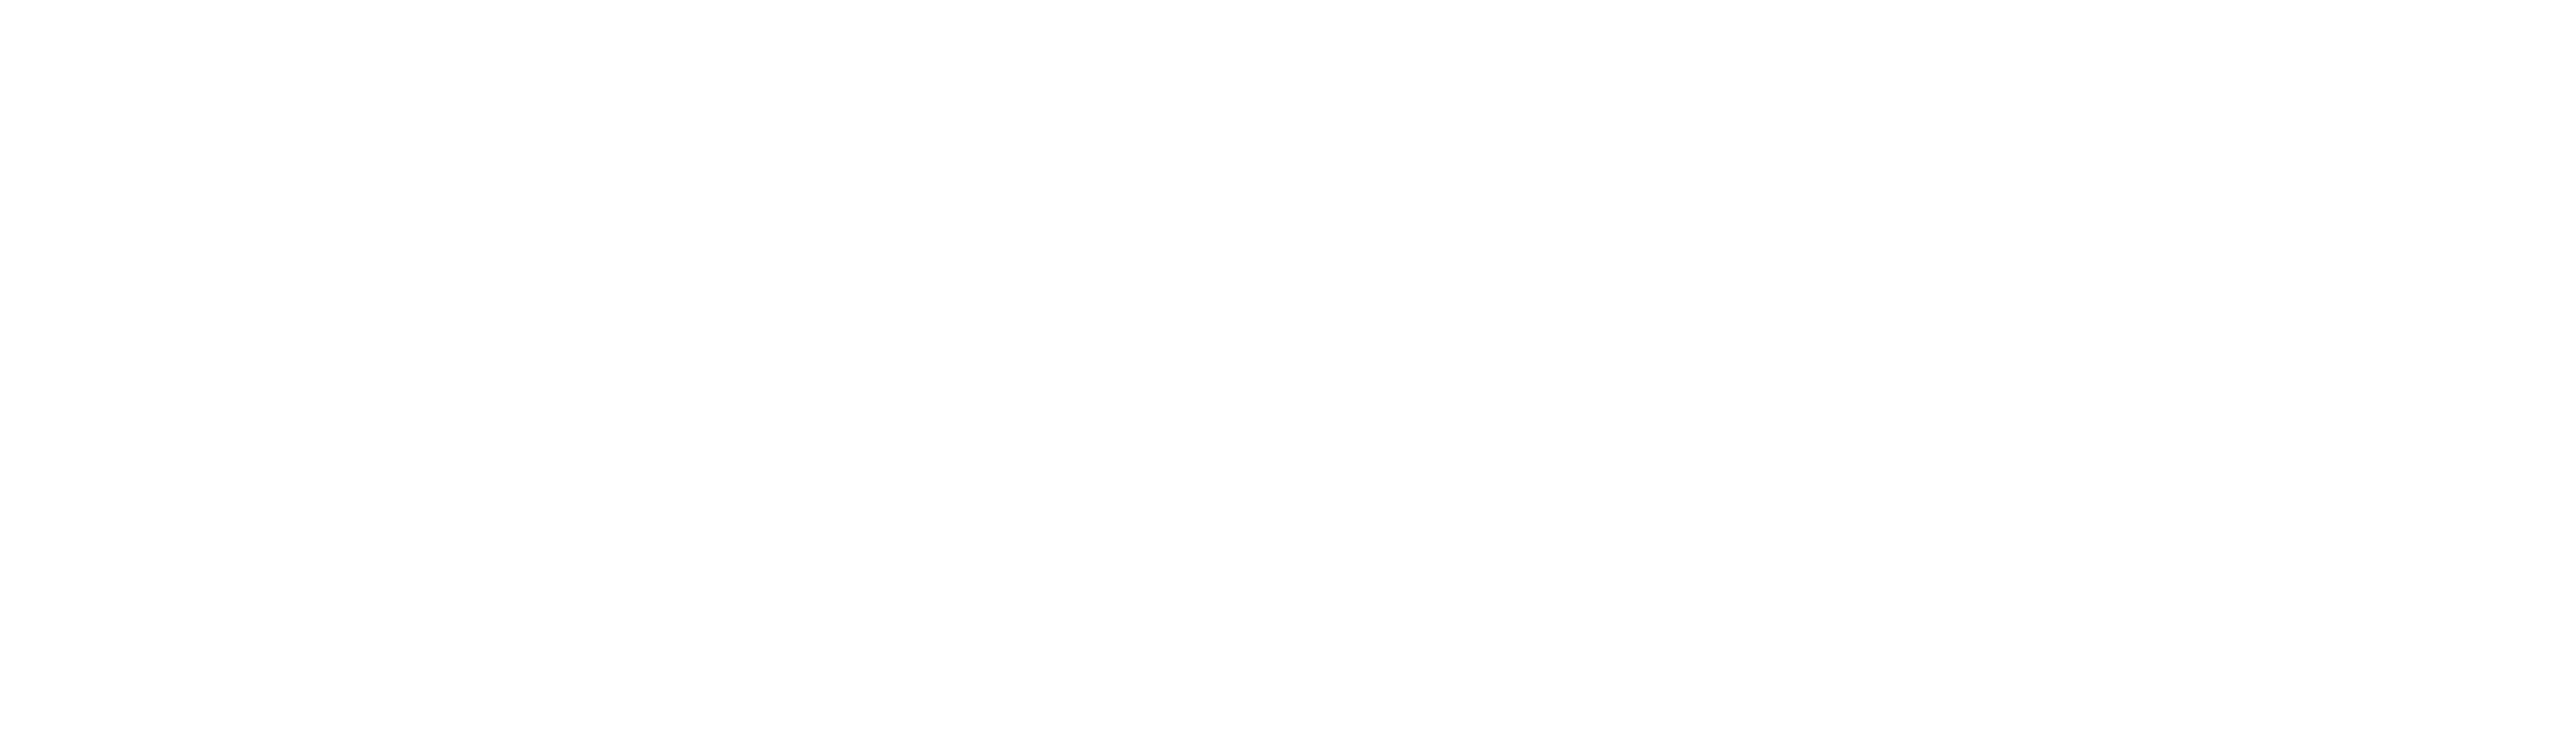

a370_SN_sourceplane/alfa_fits/Spectra_bin_45_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


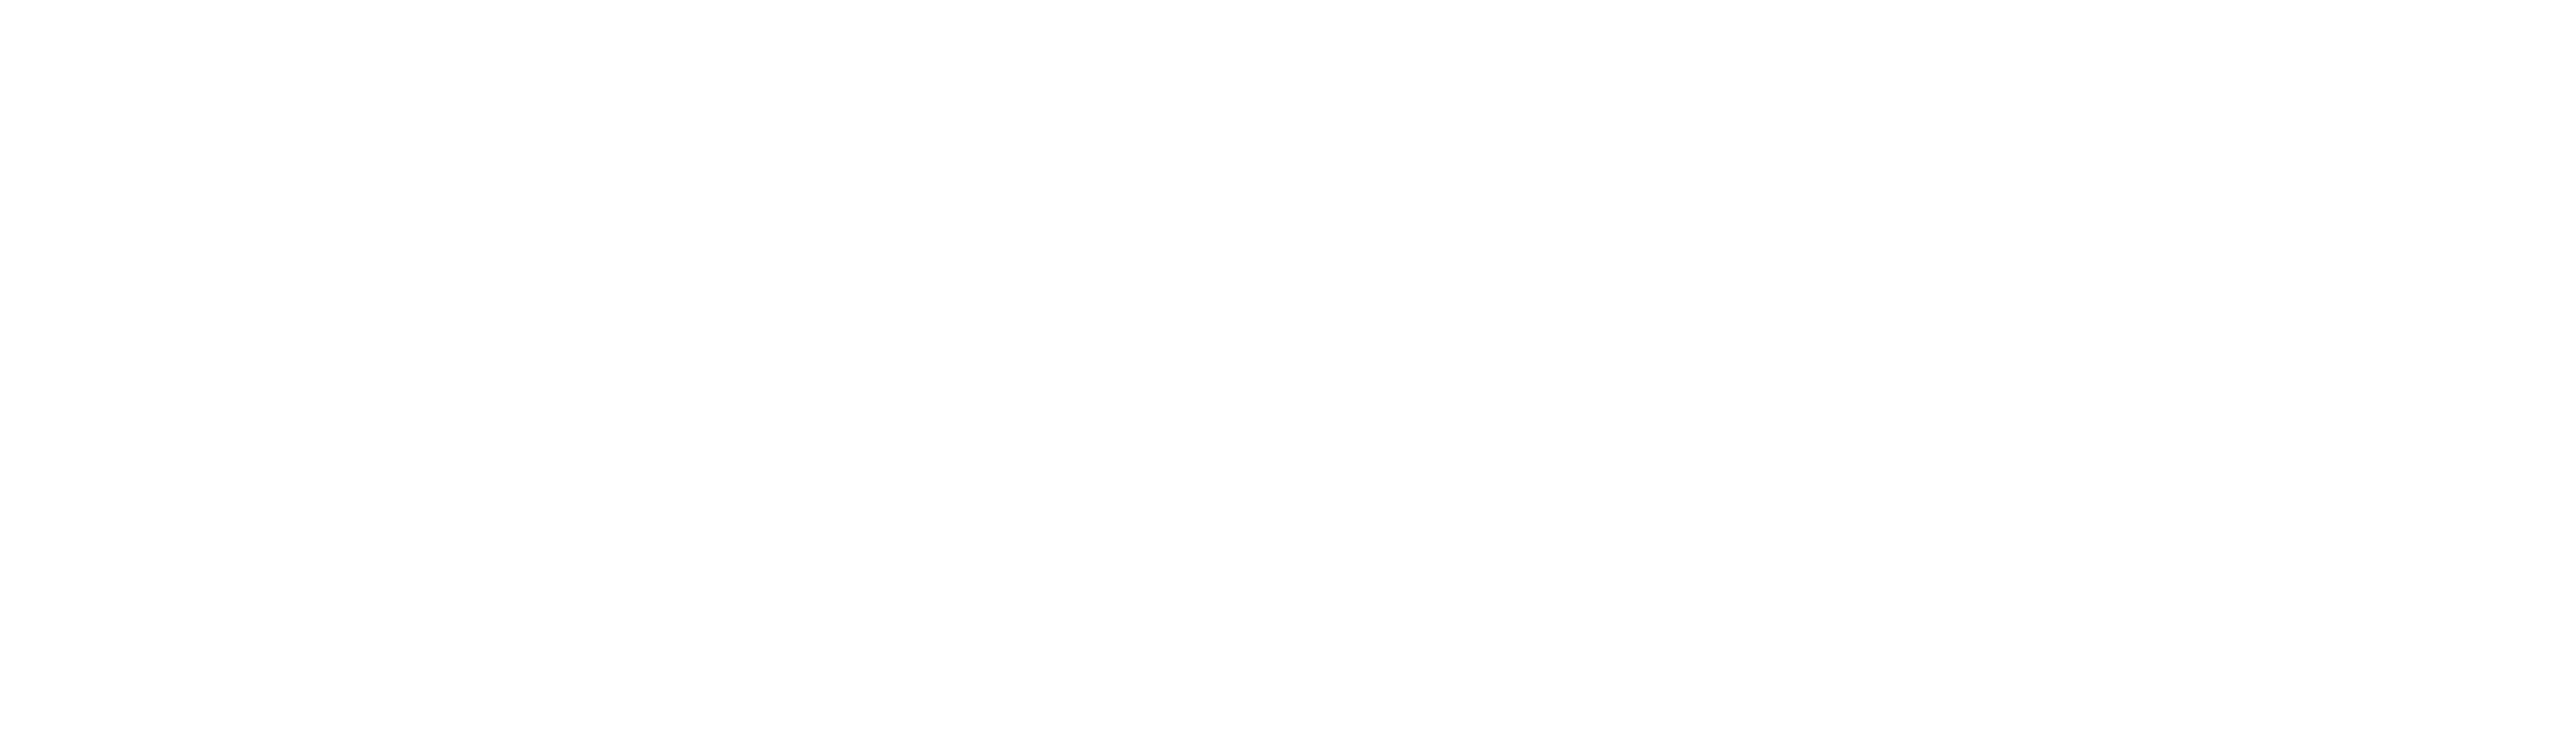

a370_SN_sourceplane/alfa_fits/Spectra_bin_46_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


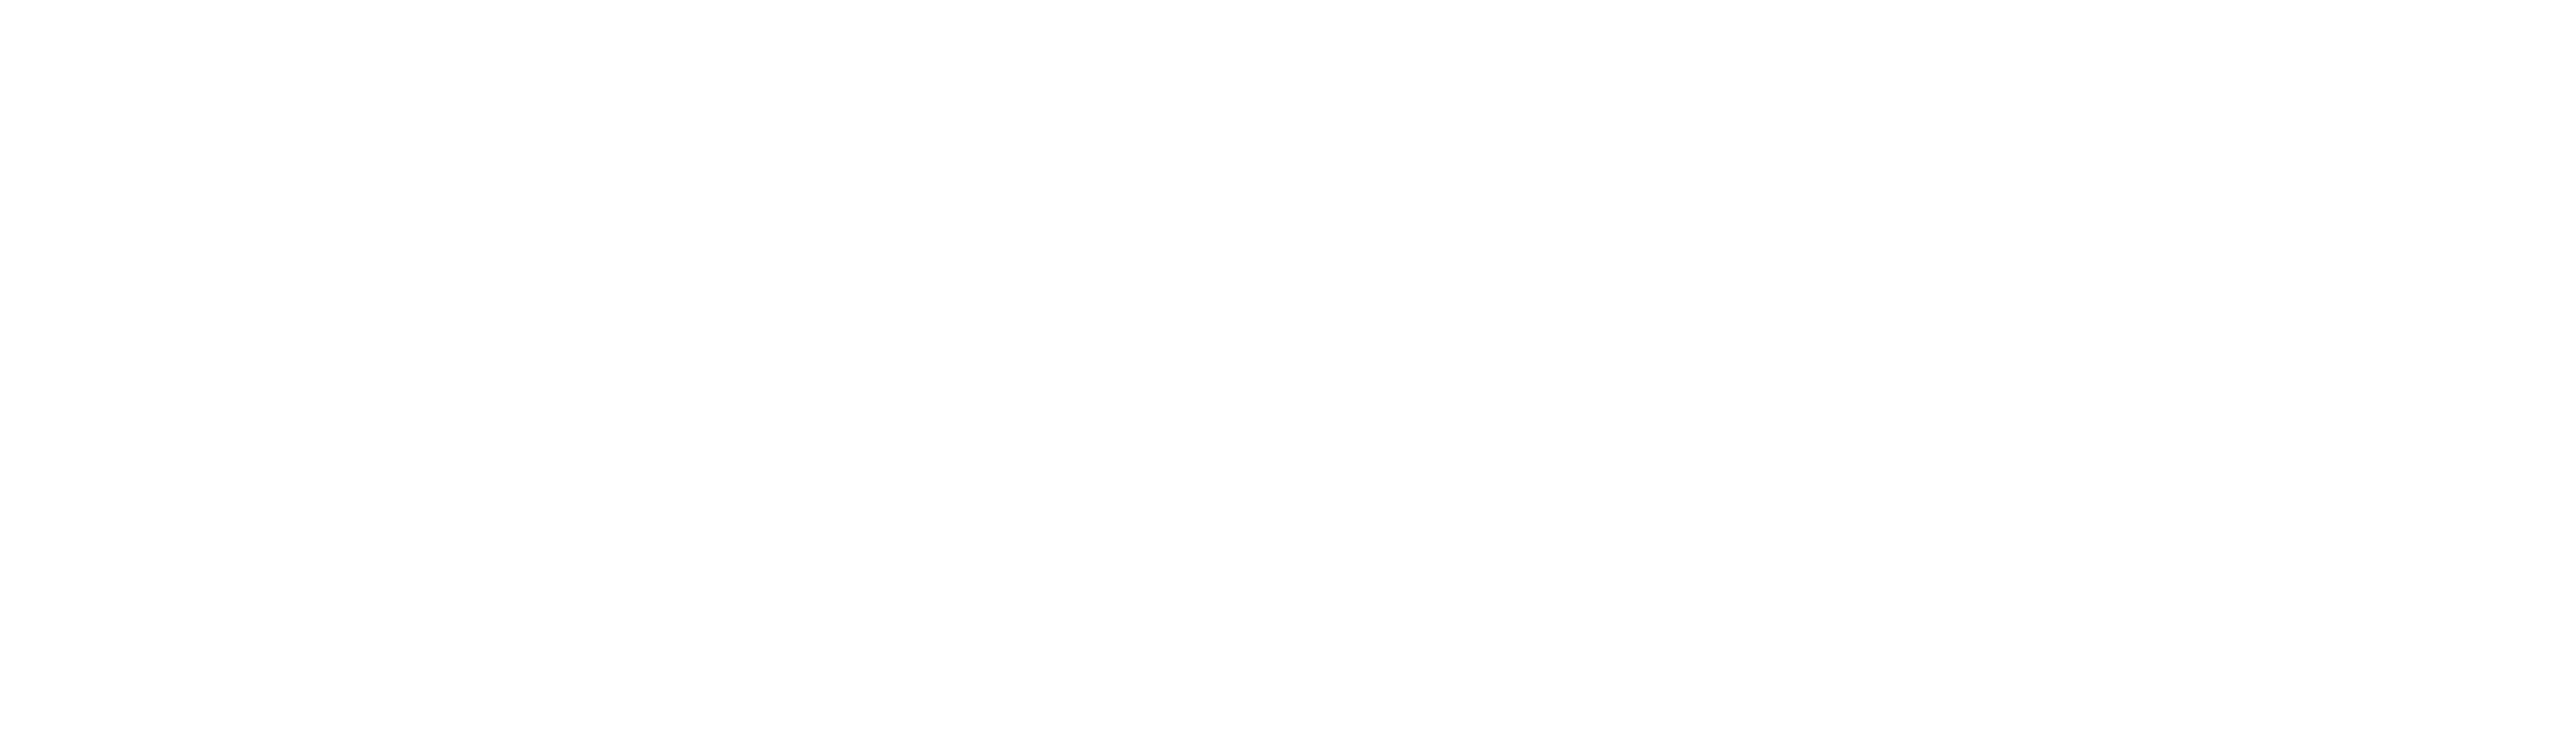

a370_SN_sourceplane/alfa_fits/Spectra_bin_47_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


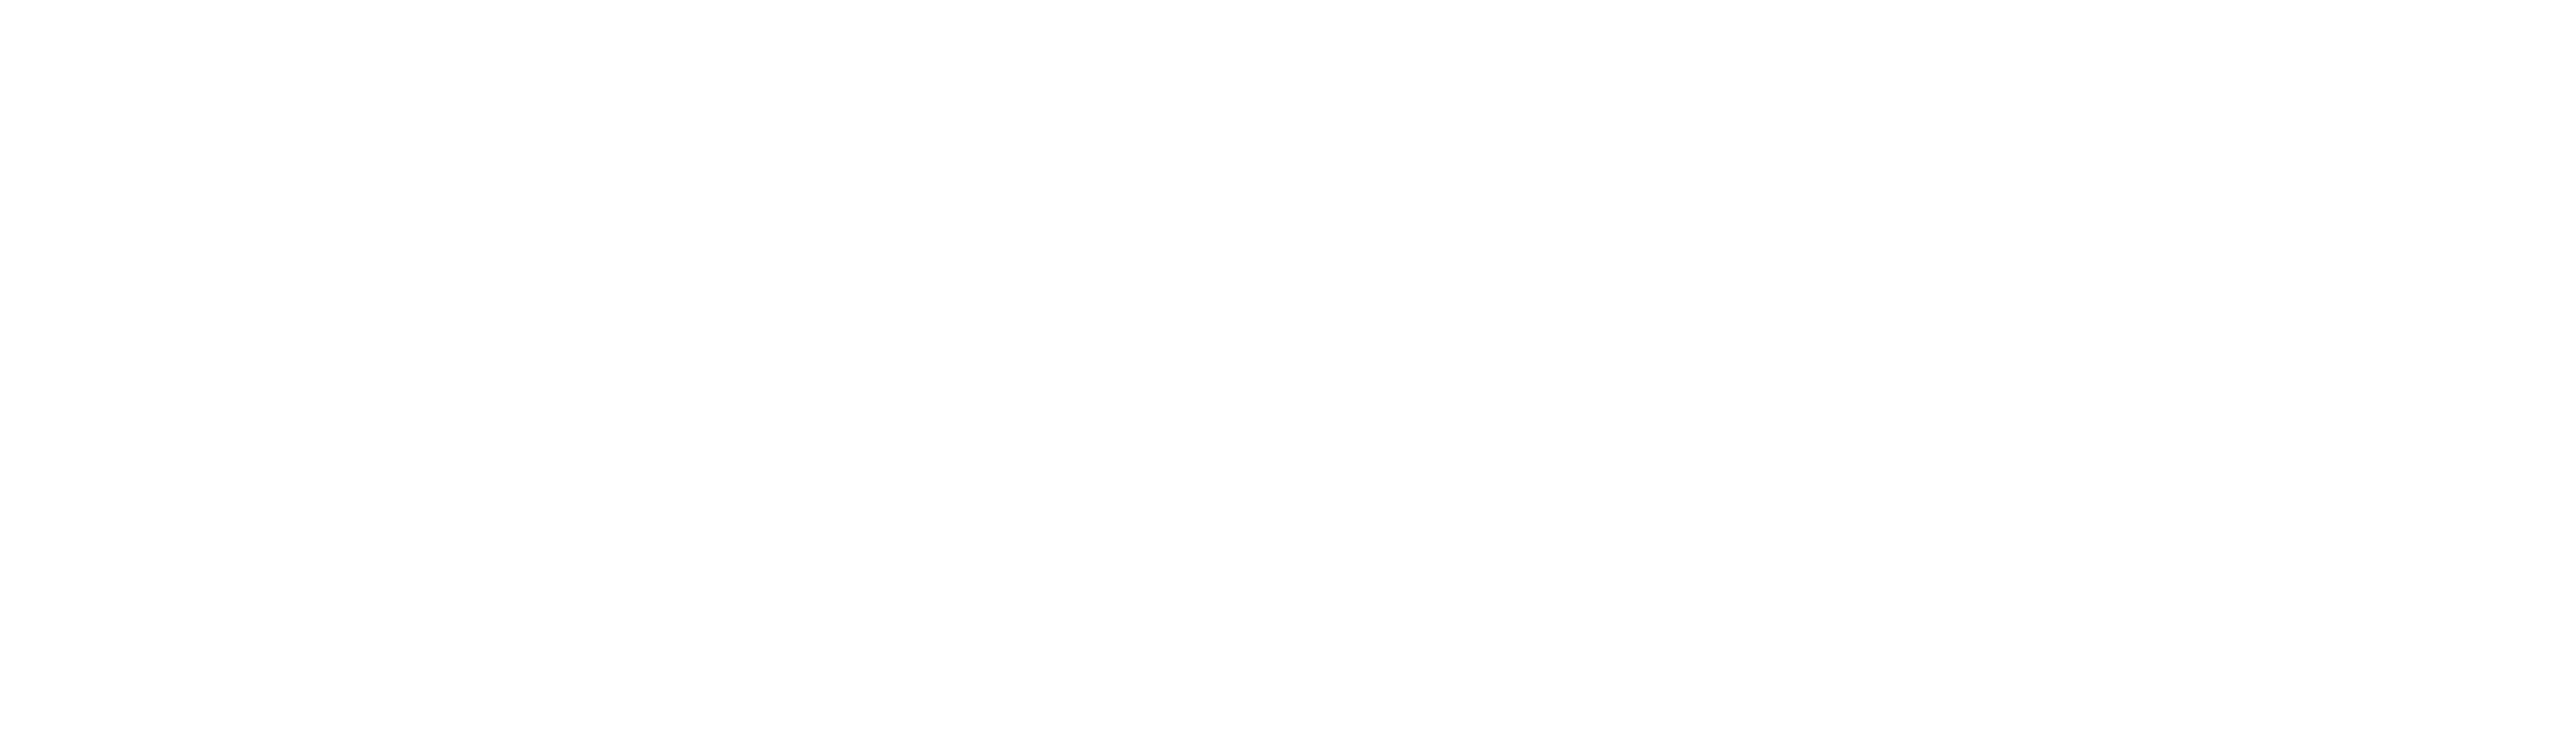

a370_SN_sourceplane/alfa_fits/Spectra_bin_48_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


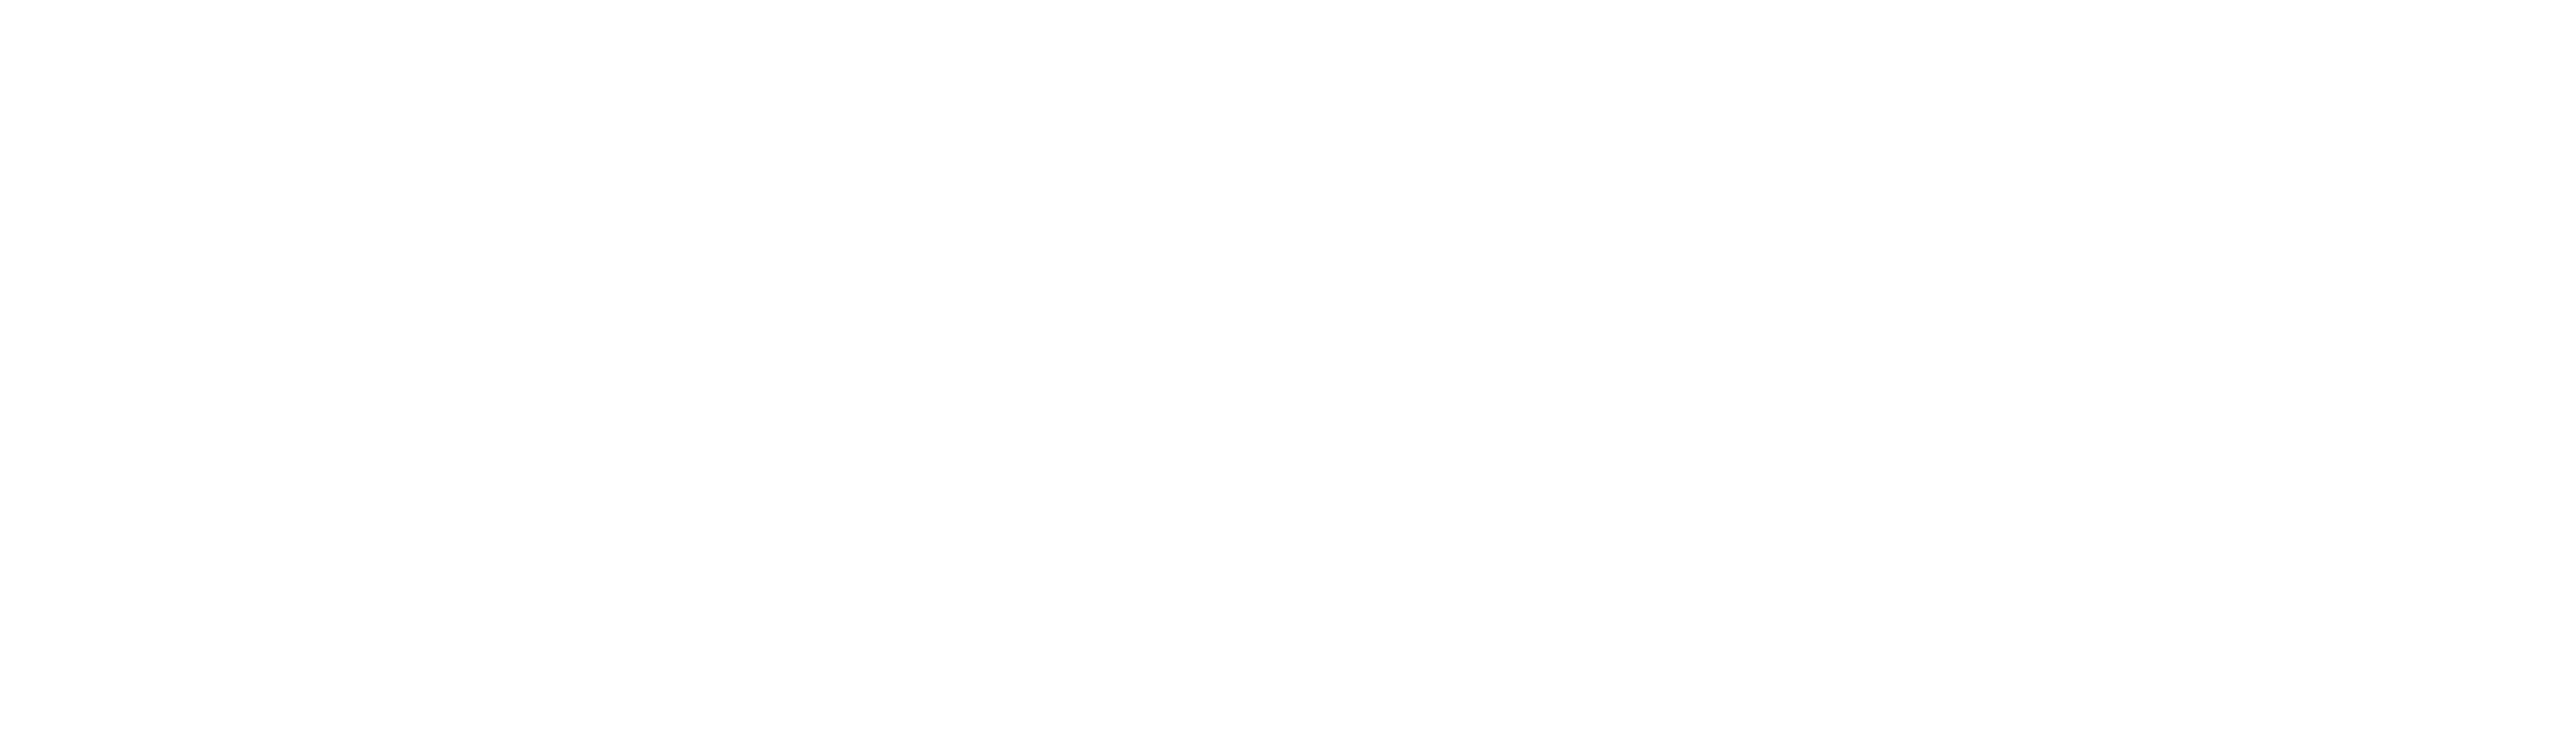

a370_SN_sourceplane/alfa_fits/Spectra_bin_49_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


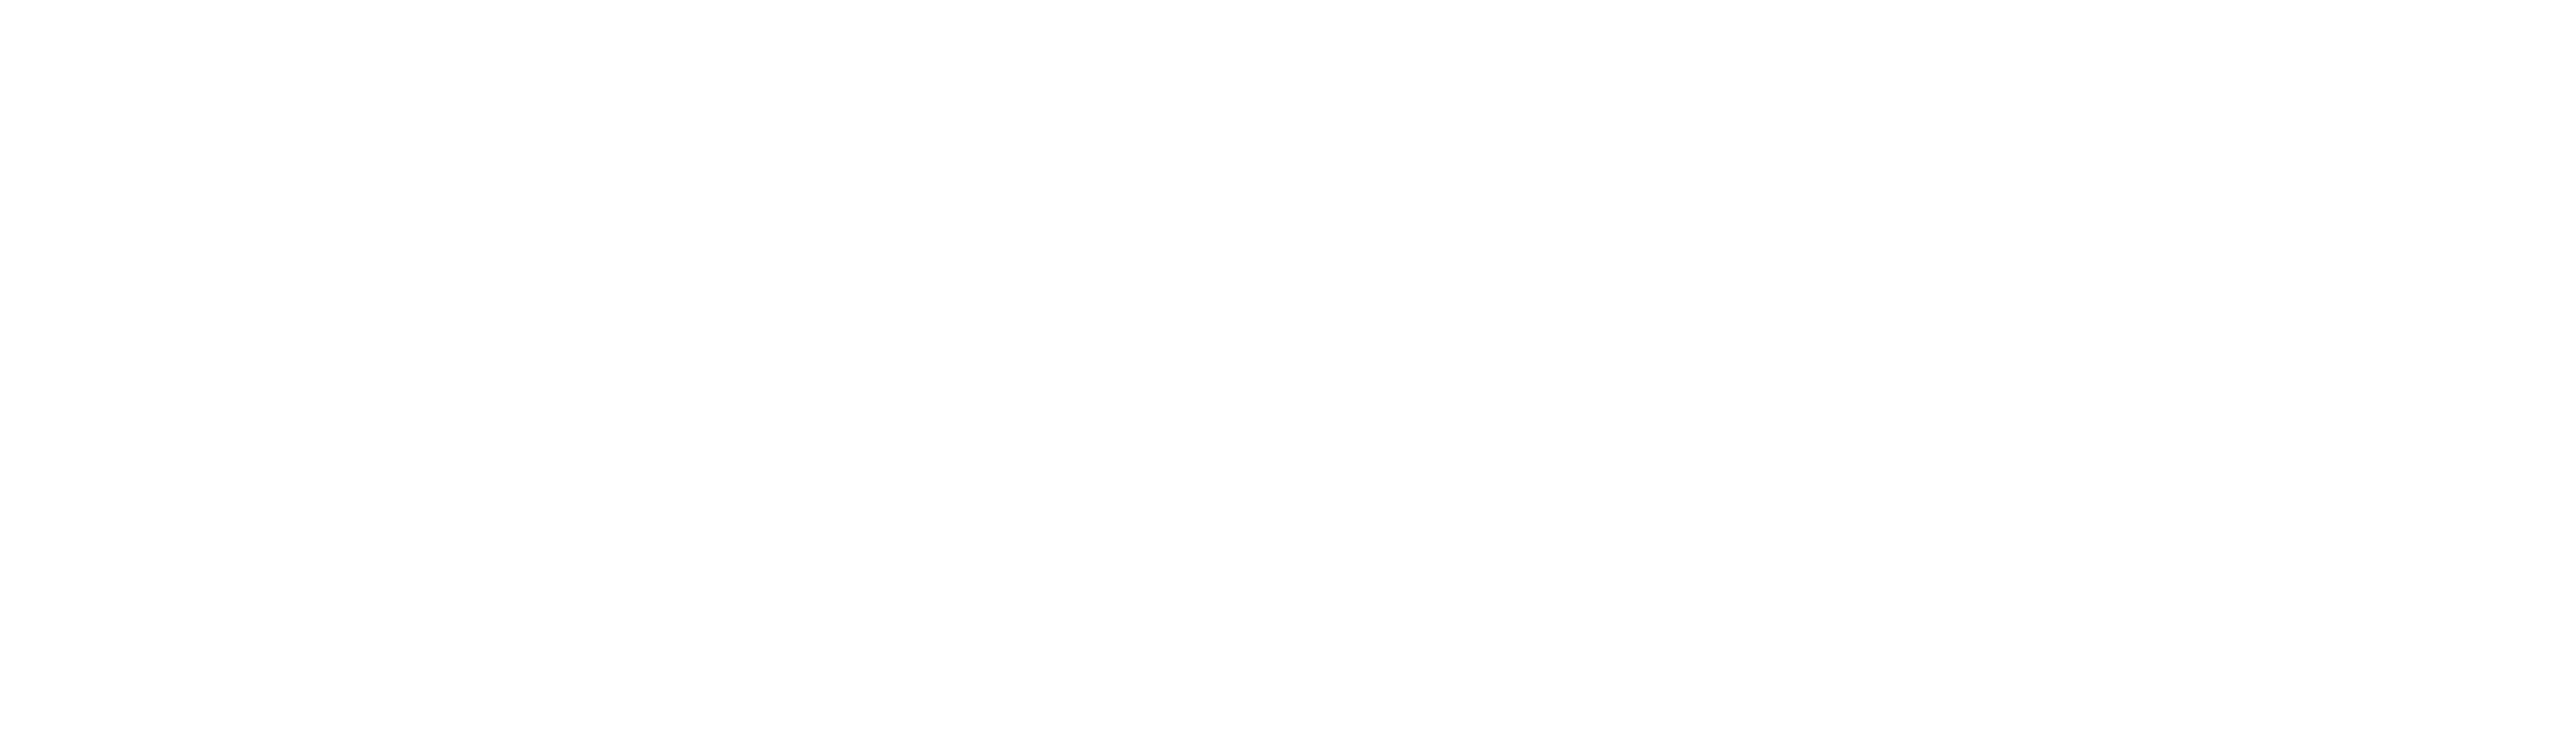

a370_SN_sourceplane/alfa_fits/Spectra_bin_4_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


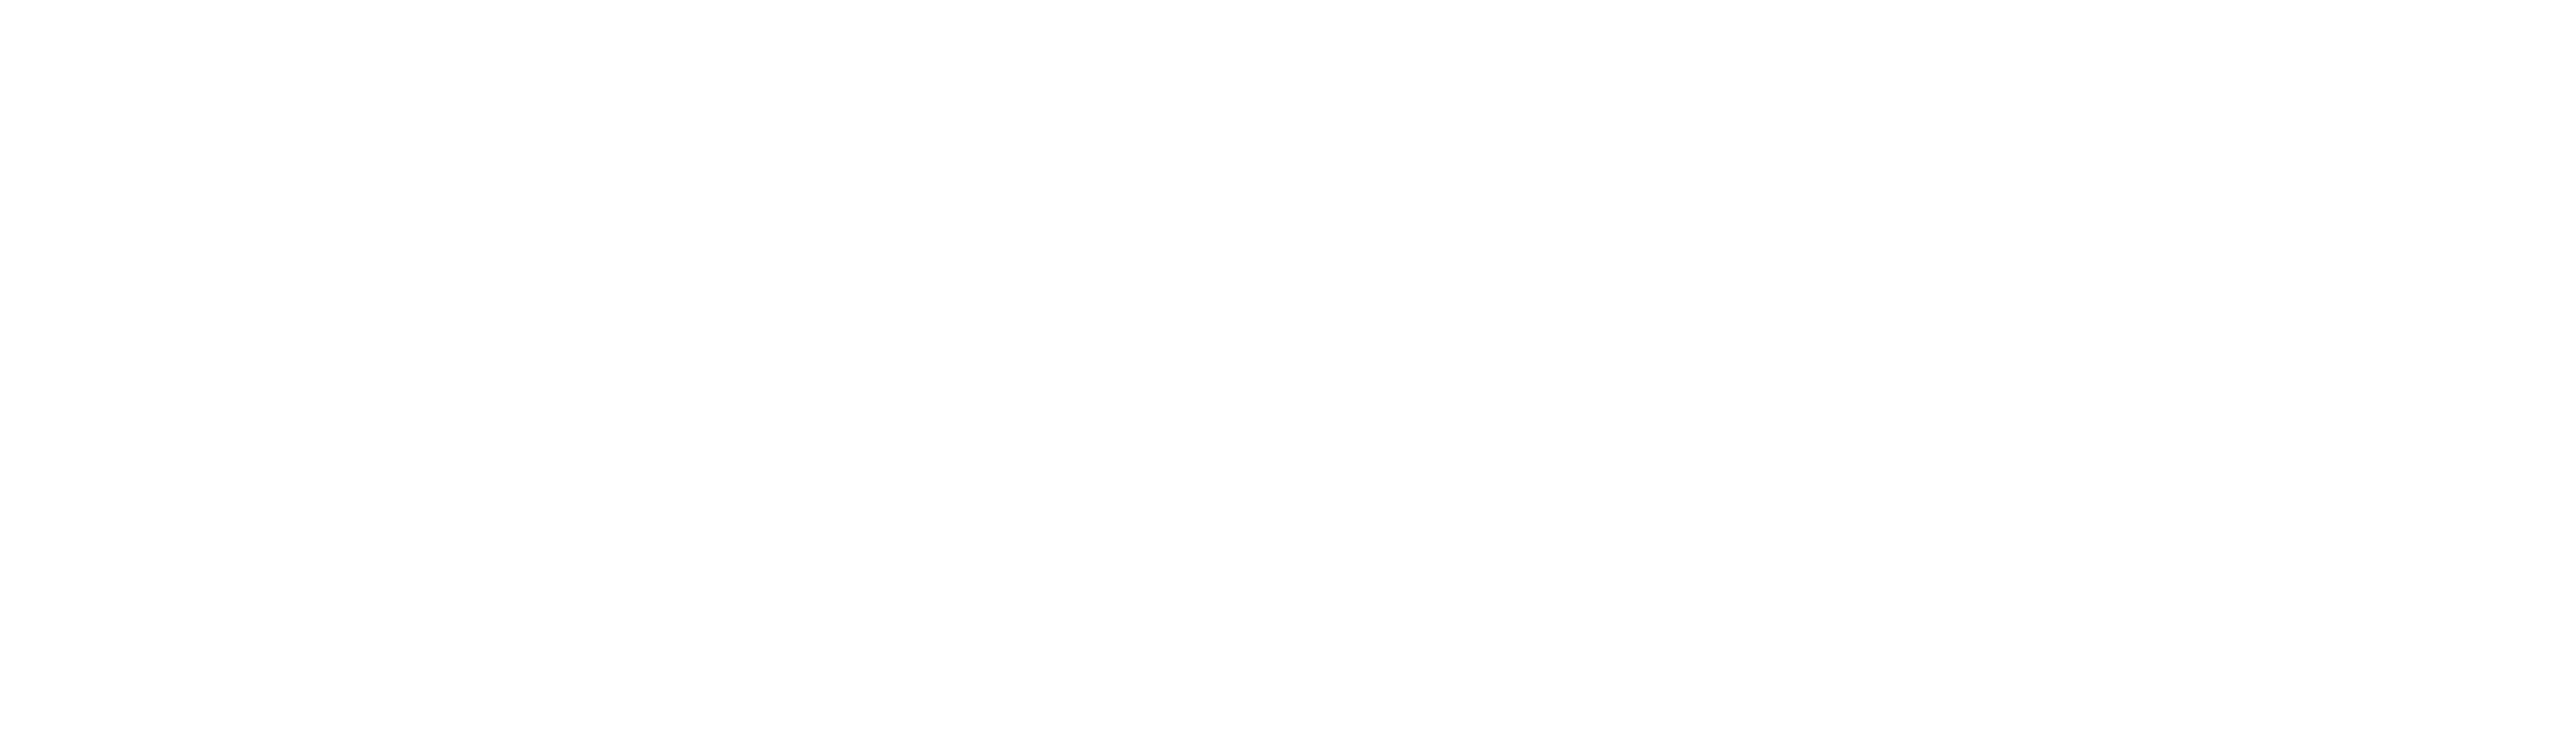

a370_SN_sourceplane/alfa_fits/Spectra_bin_50_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


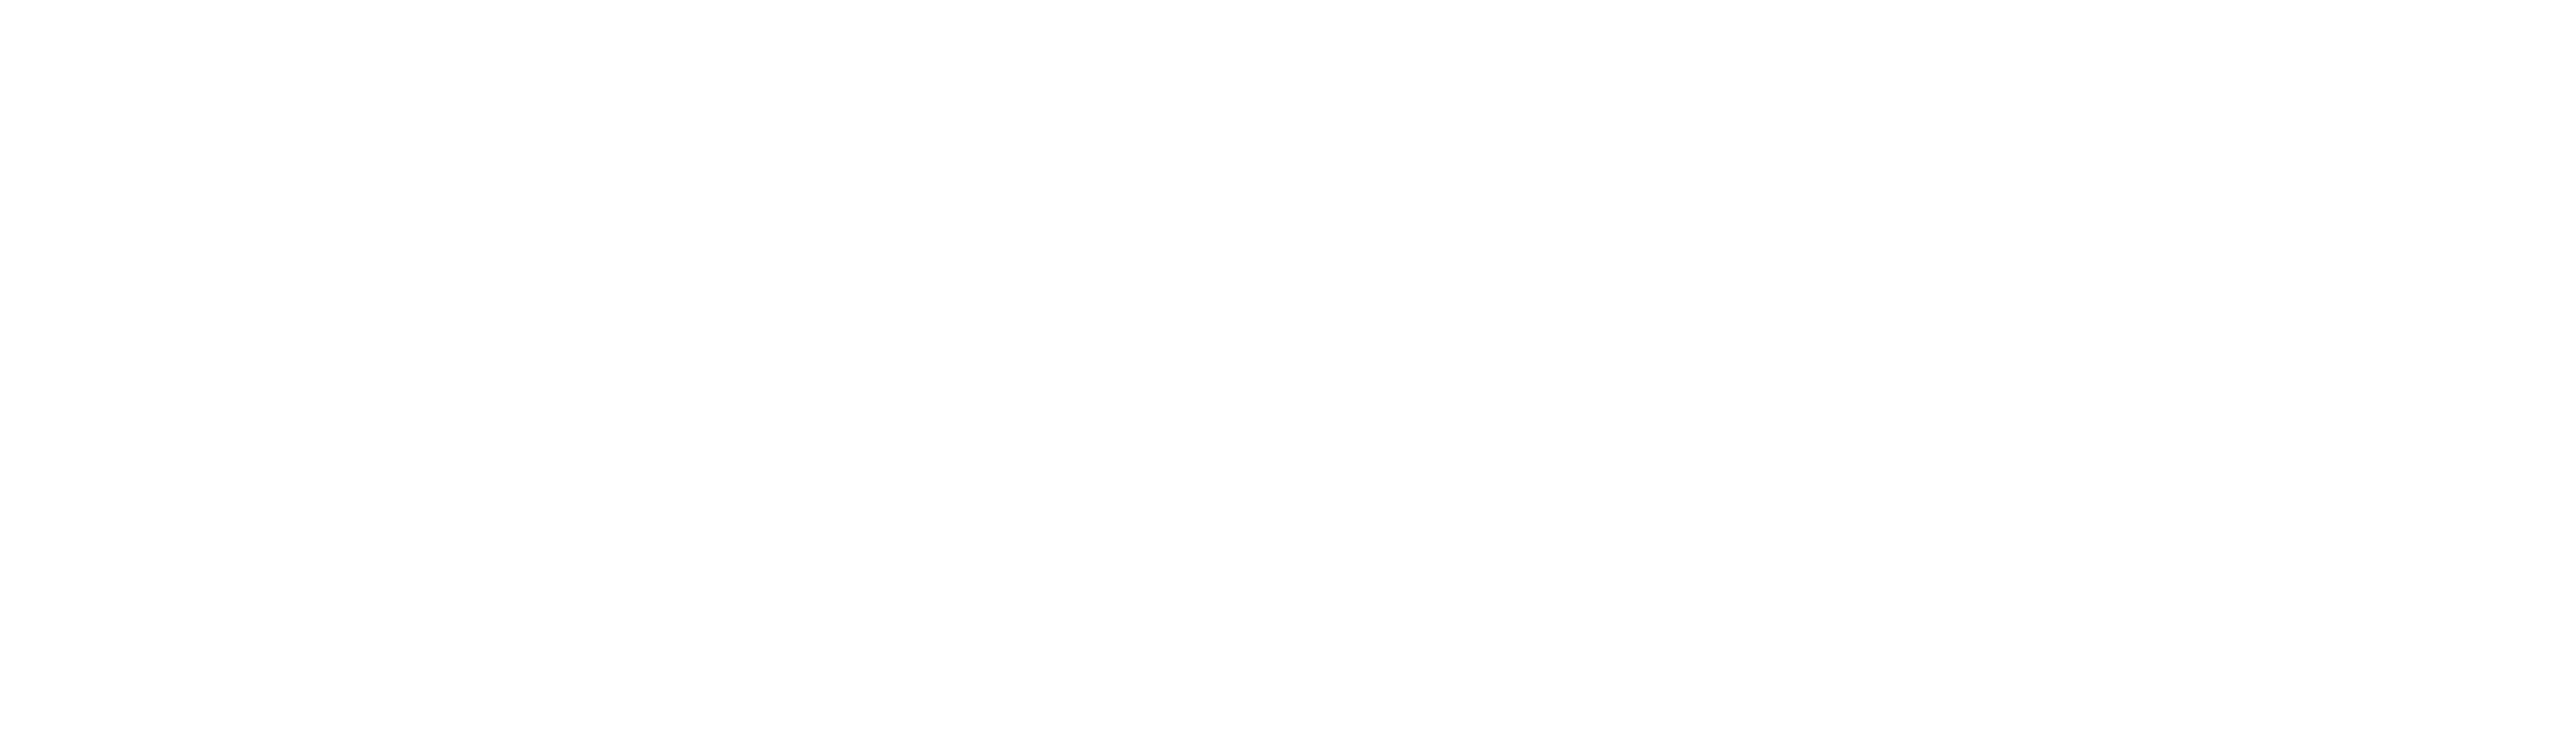

a370_SN_sourceplane/alfa_fits/Spectra_bin_51_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


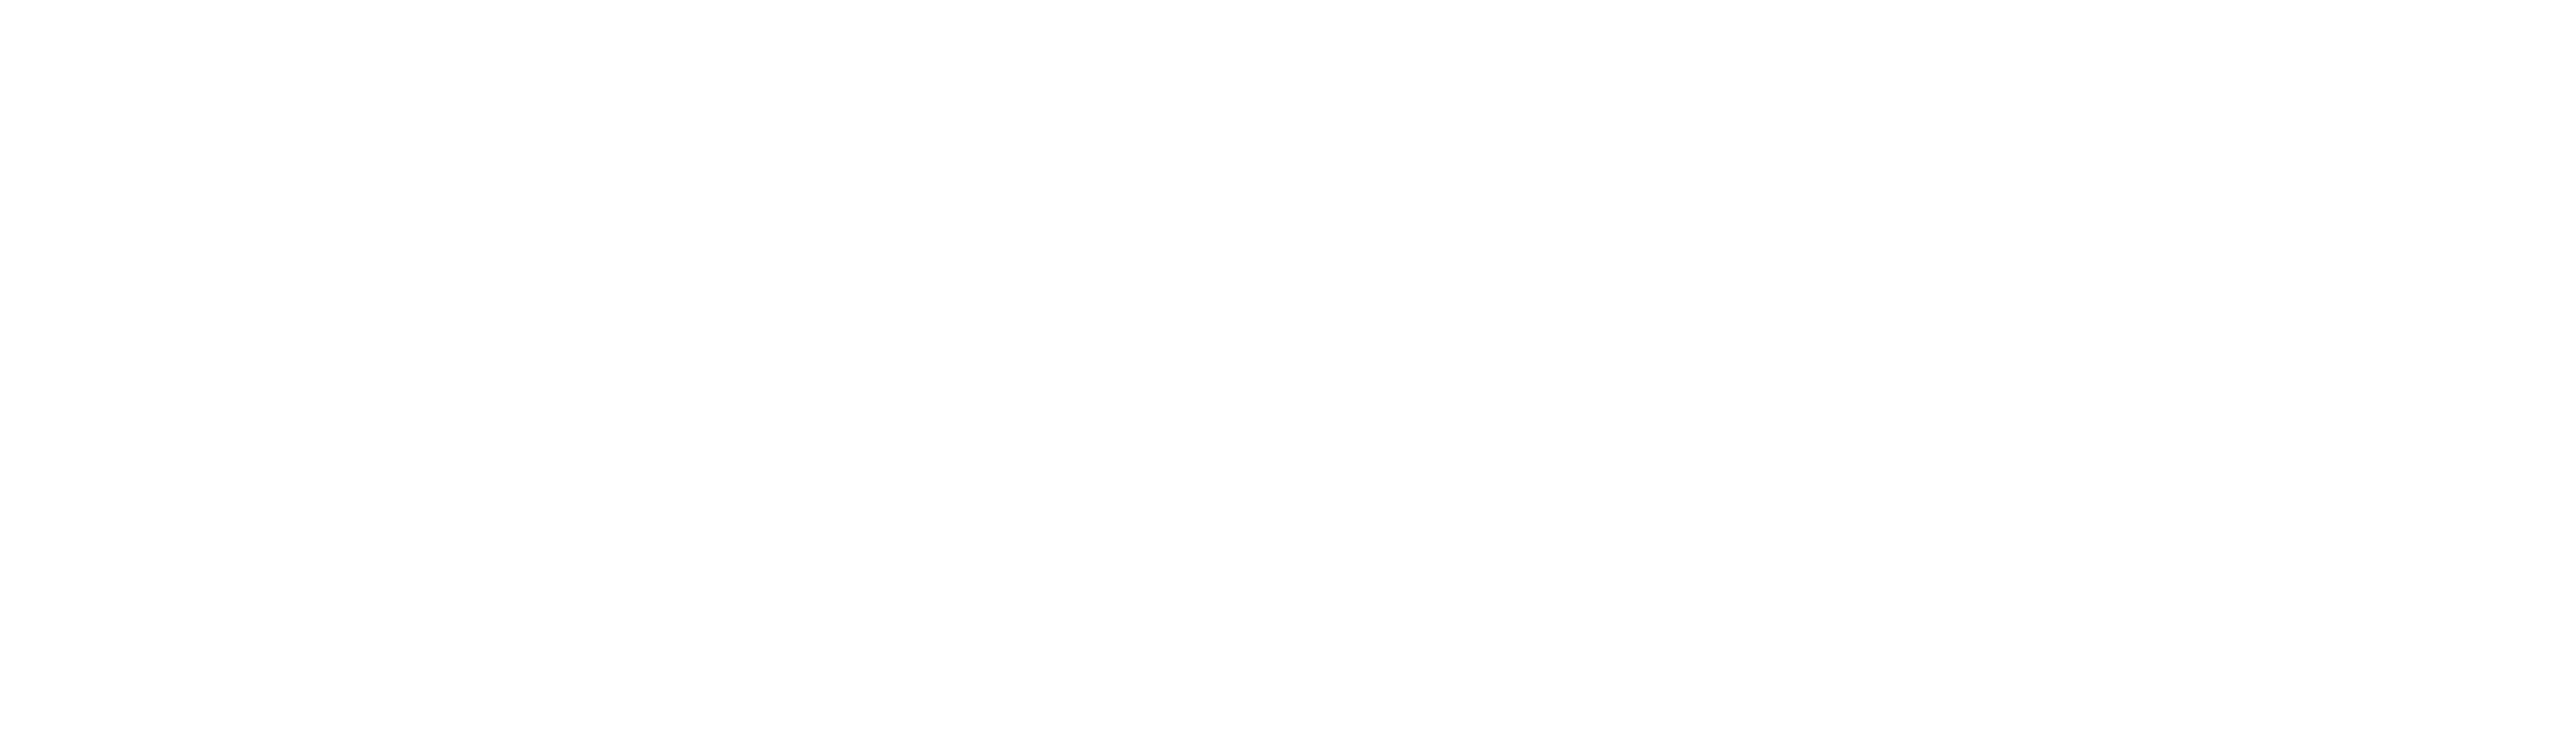

a370_SN_sourceplane/alfa_fits/Spectra_bin_52_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


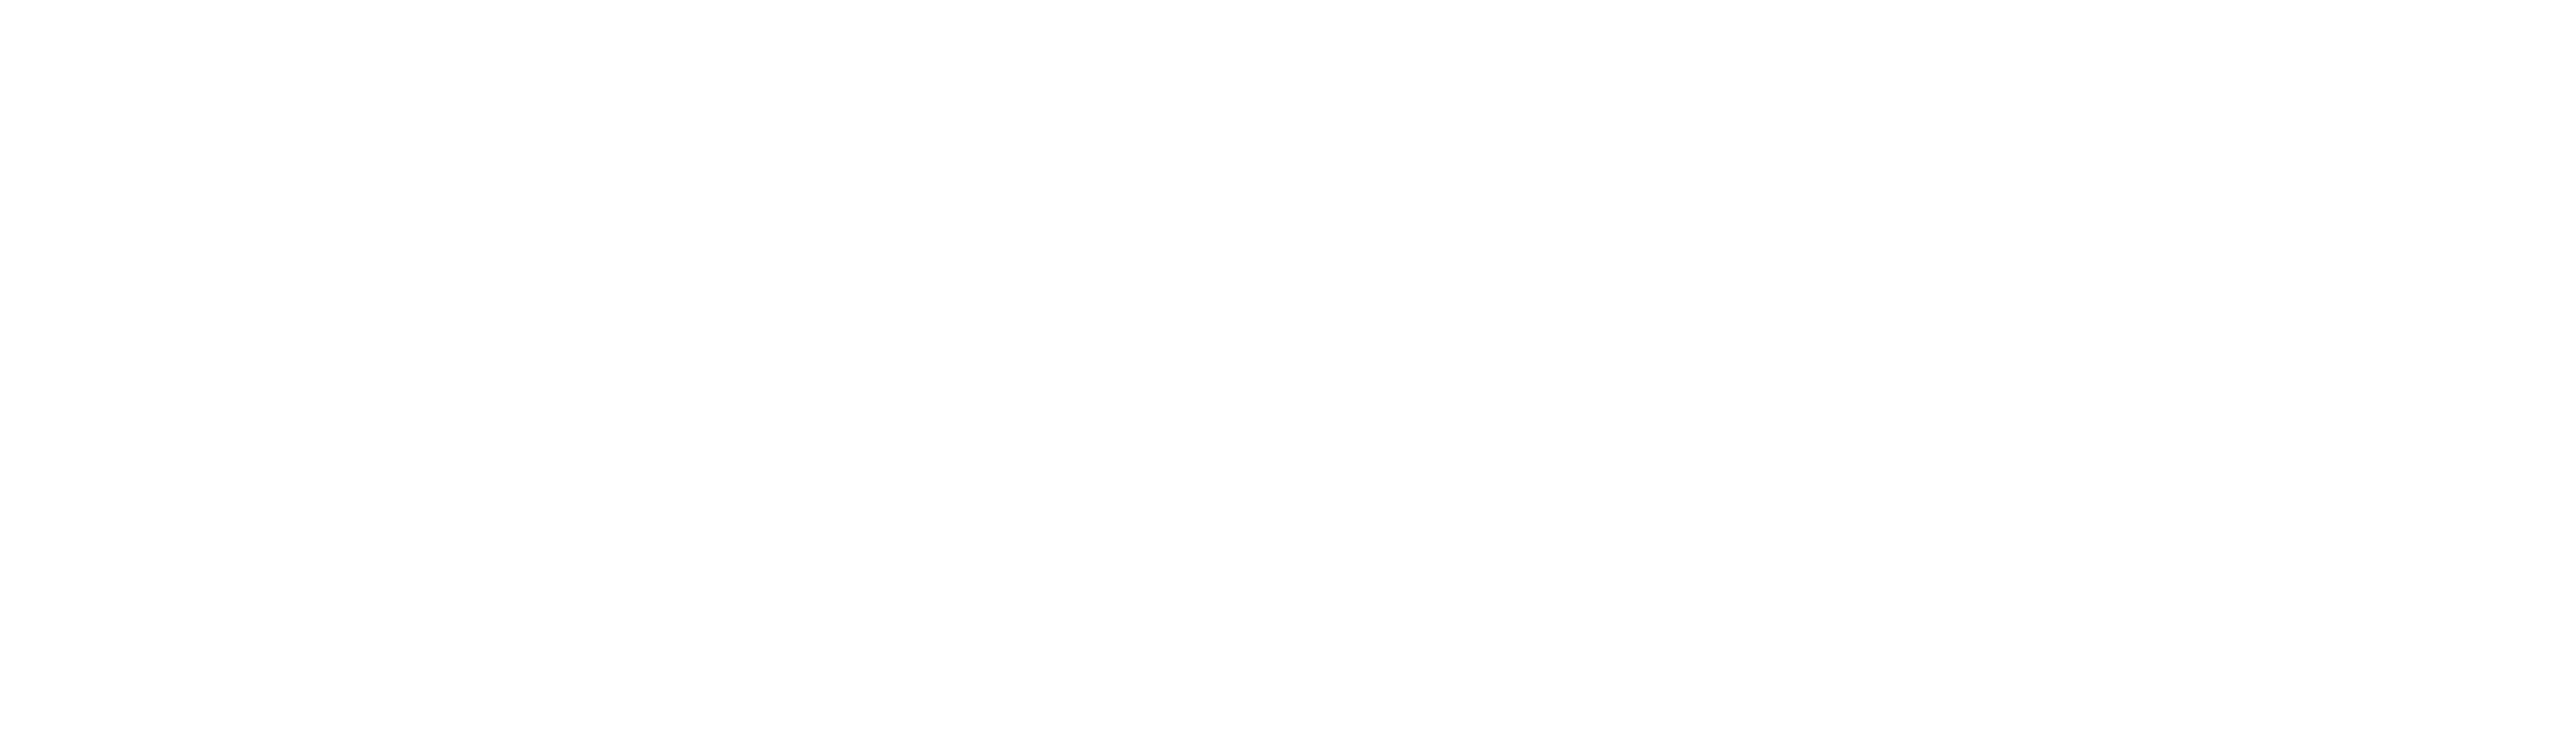

a370_SN_sourceplane/alfa_fits/Spectra_bin_53_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


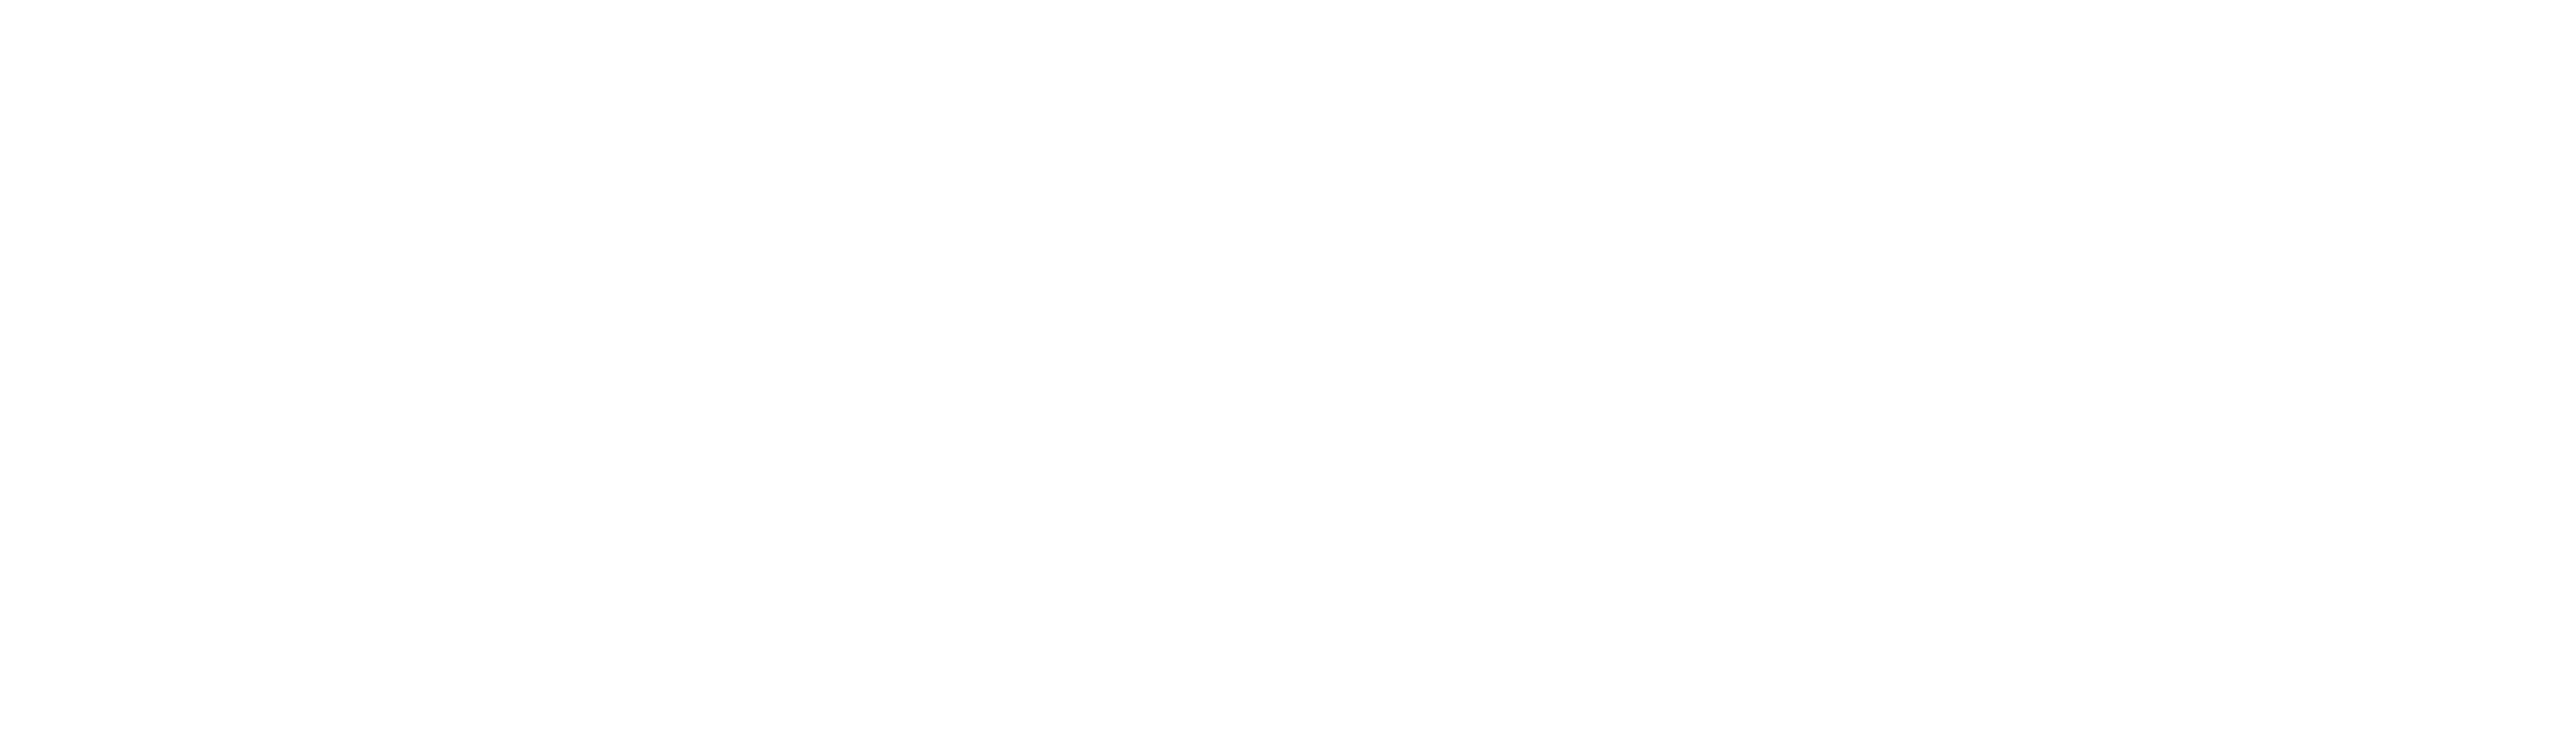

a370_SN_sourceplane/alfa_fits/Spectra_bin_54_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


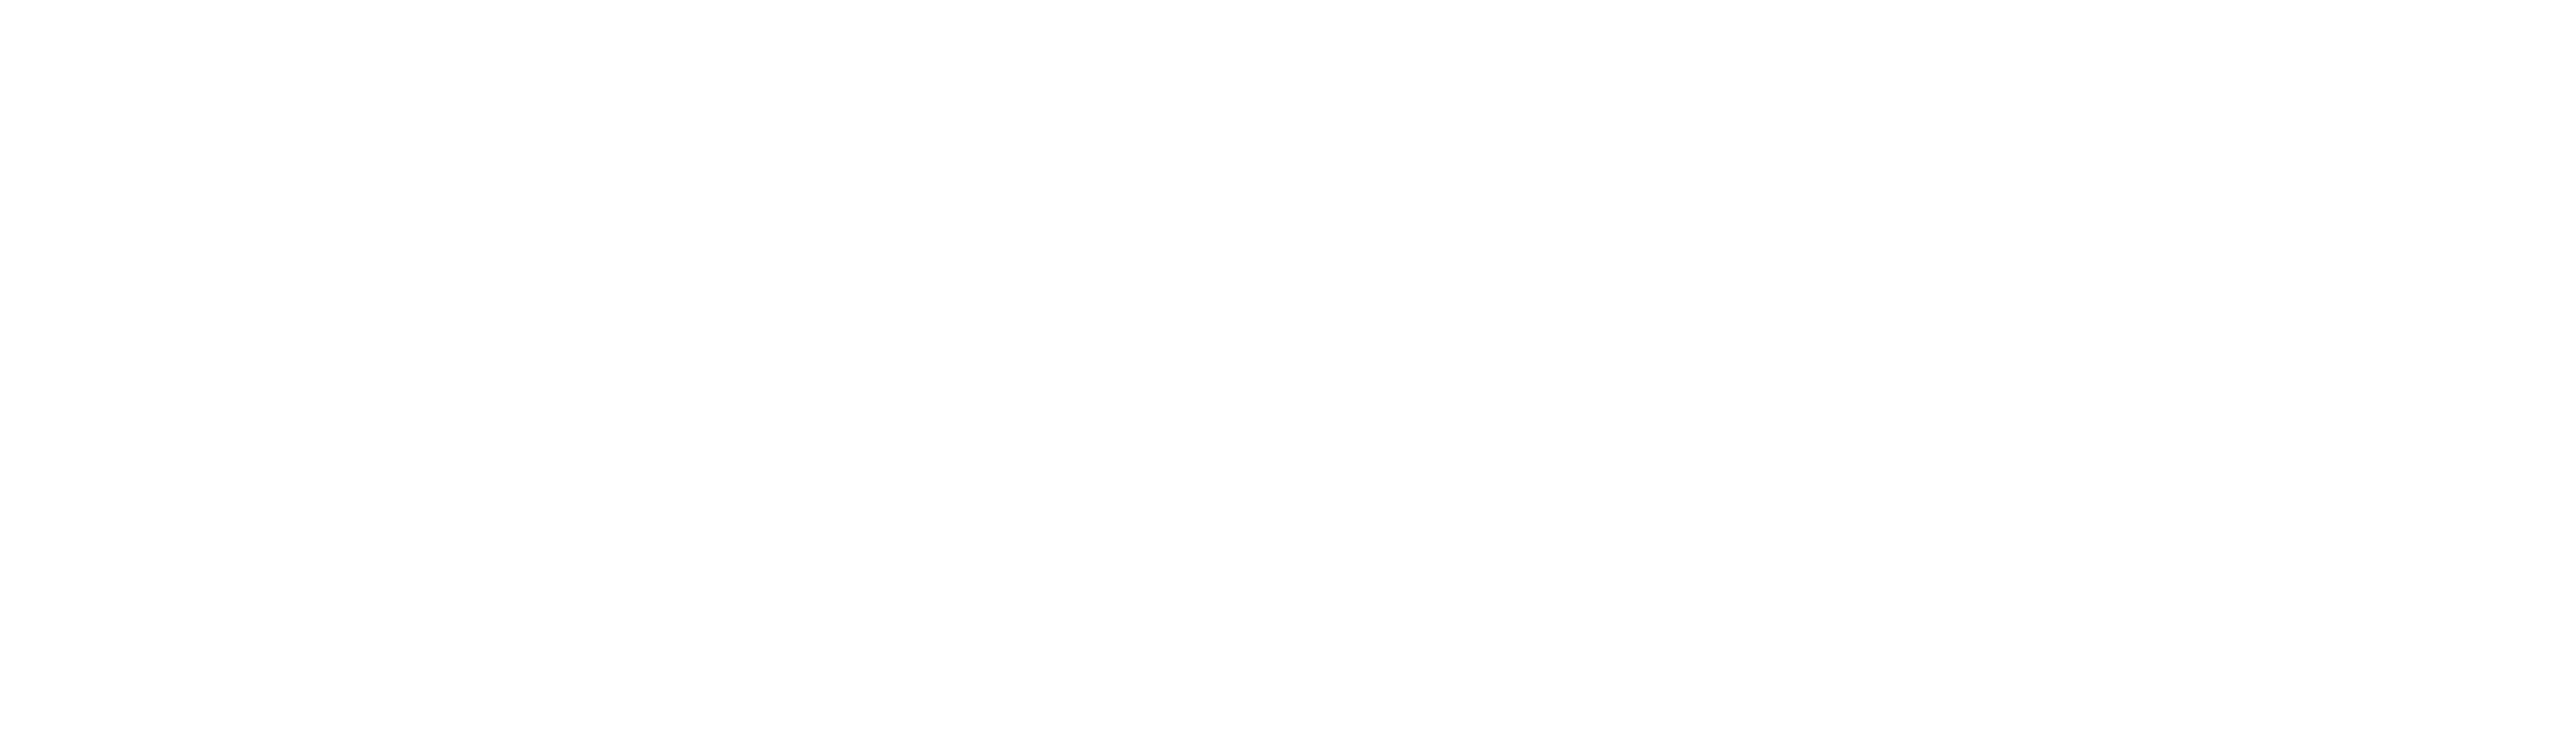

a370_SN_sourceplane/alfa_fits/Spectra_bin_55_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


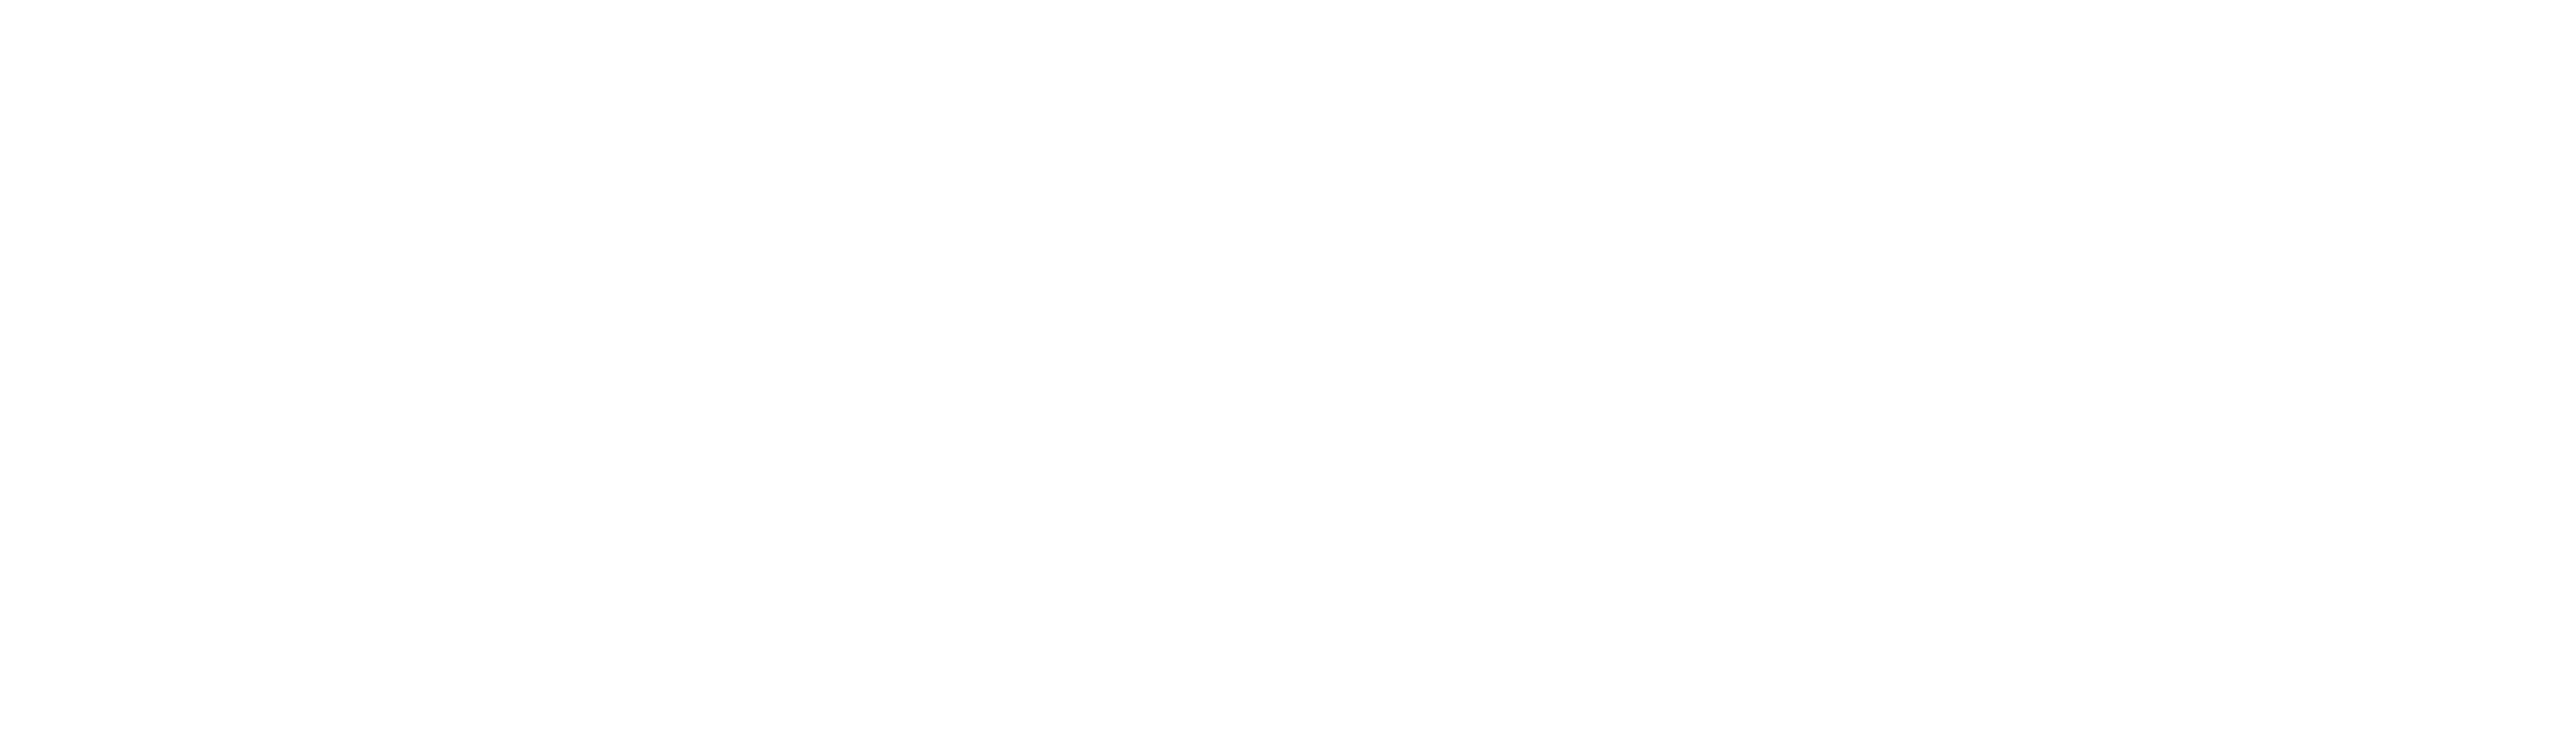

a370_SN_sourceplane/alfa_fits/Spectra_bin_56_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


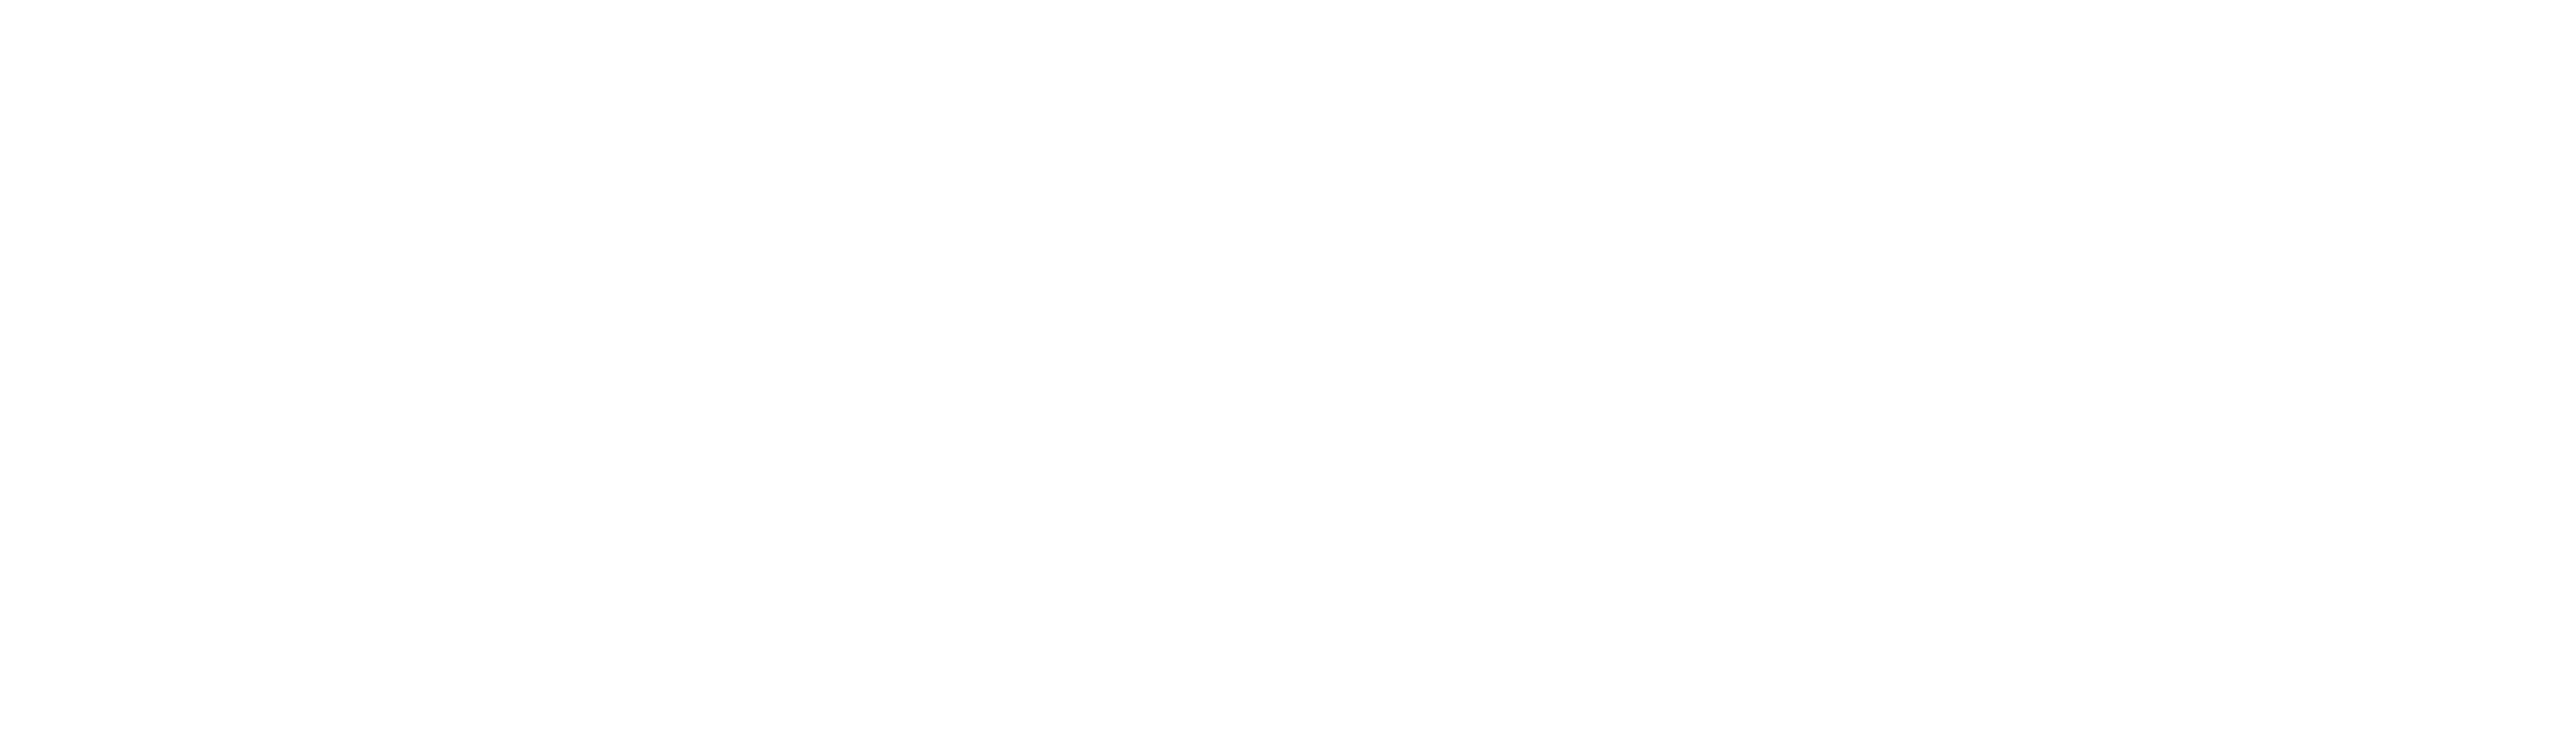

a370_SN_sourceplane/alfa_fits/Spectra_bin_57_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


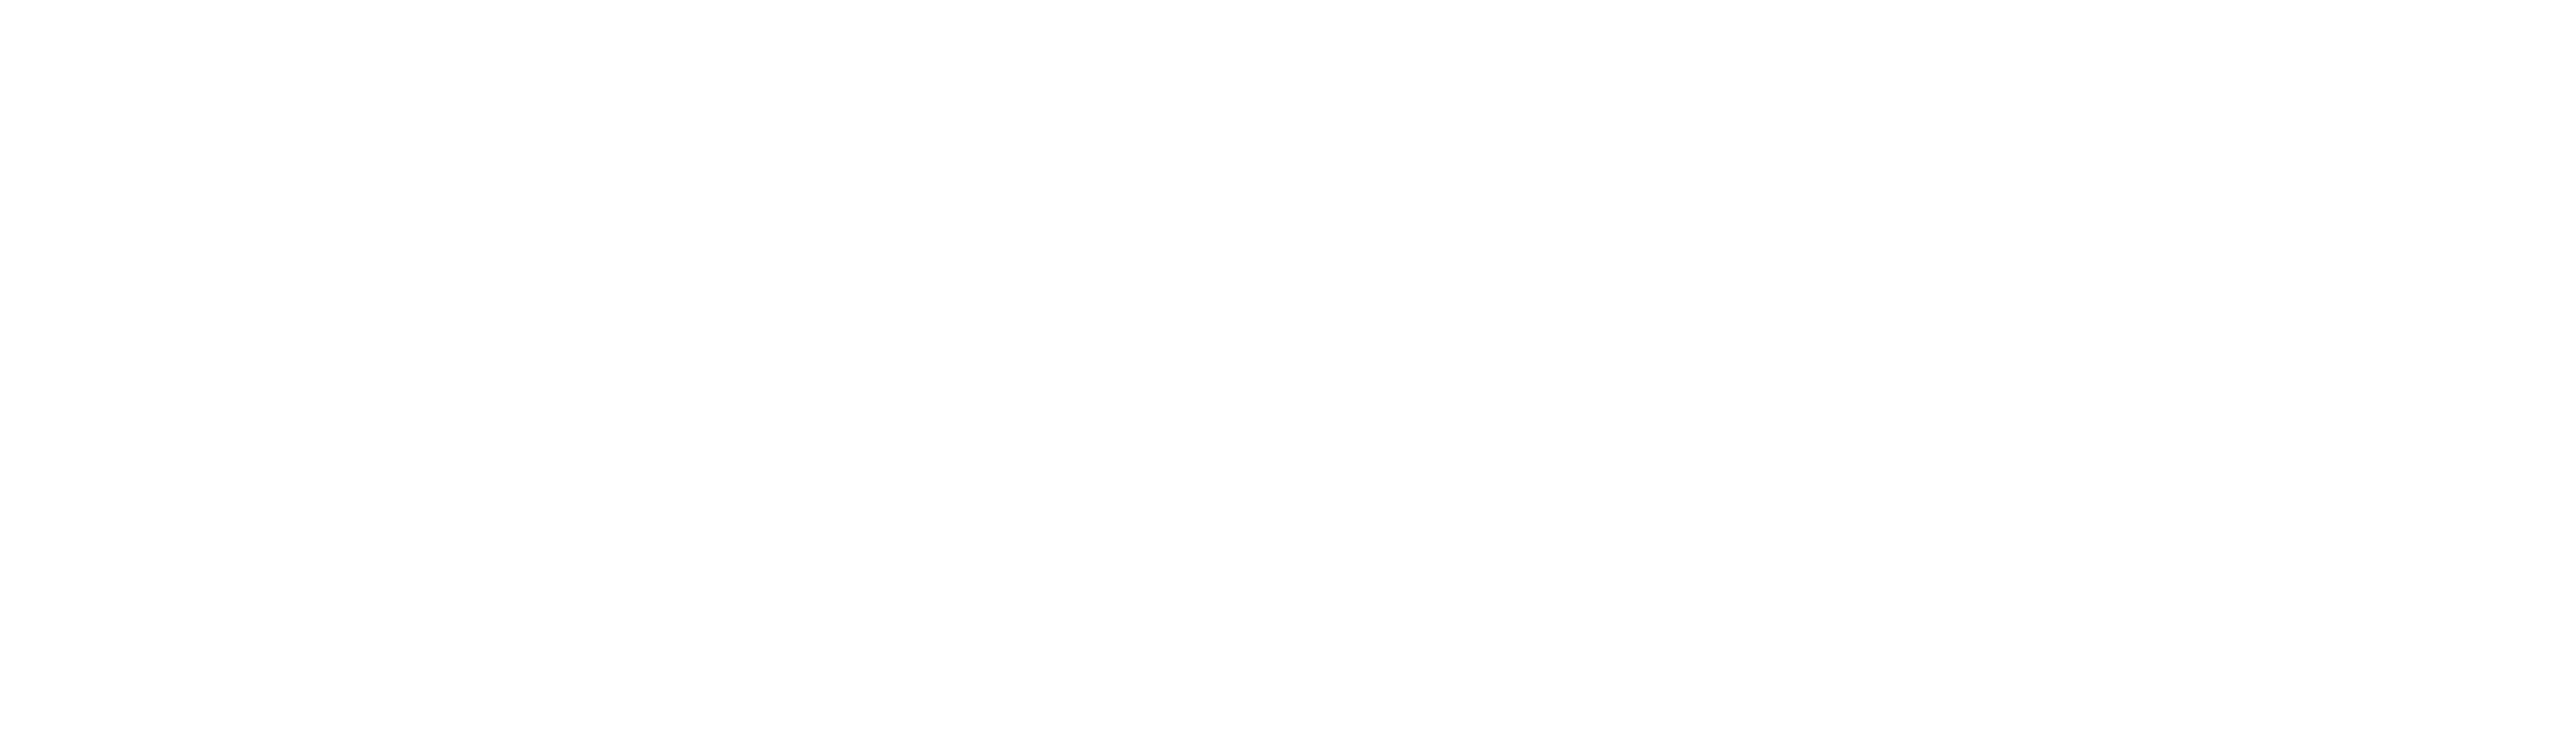

a370_SN_sourceplane/alfa_fits/Spectra_bin_58_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


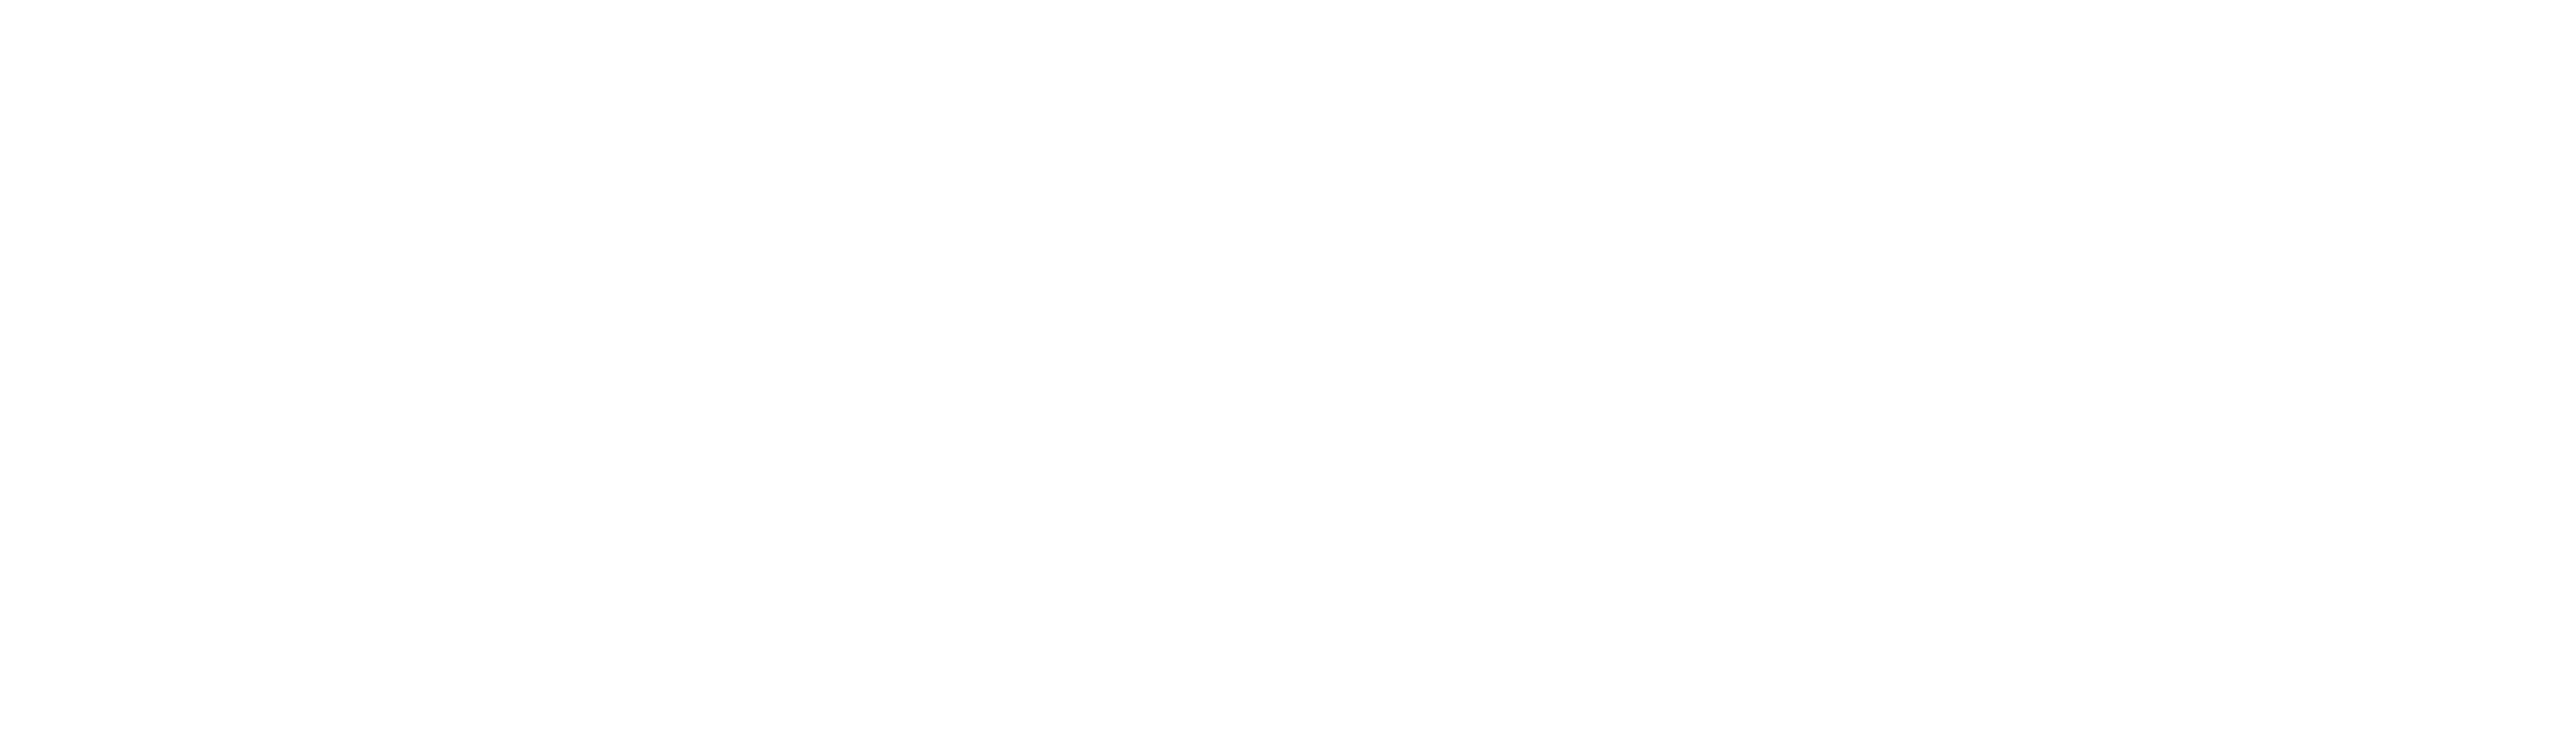

a370_SN_sourceplane/alfa_fits/Spectra_bin_59_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


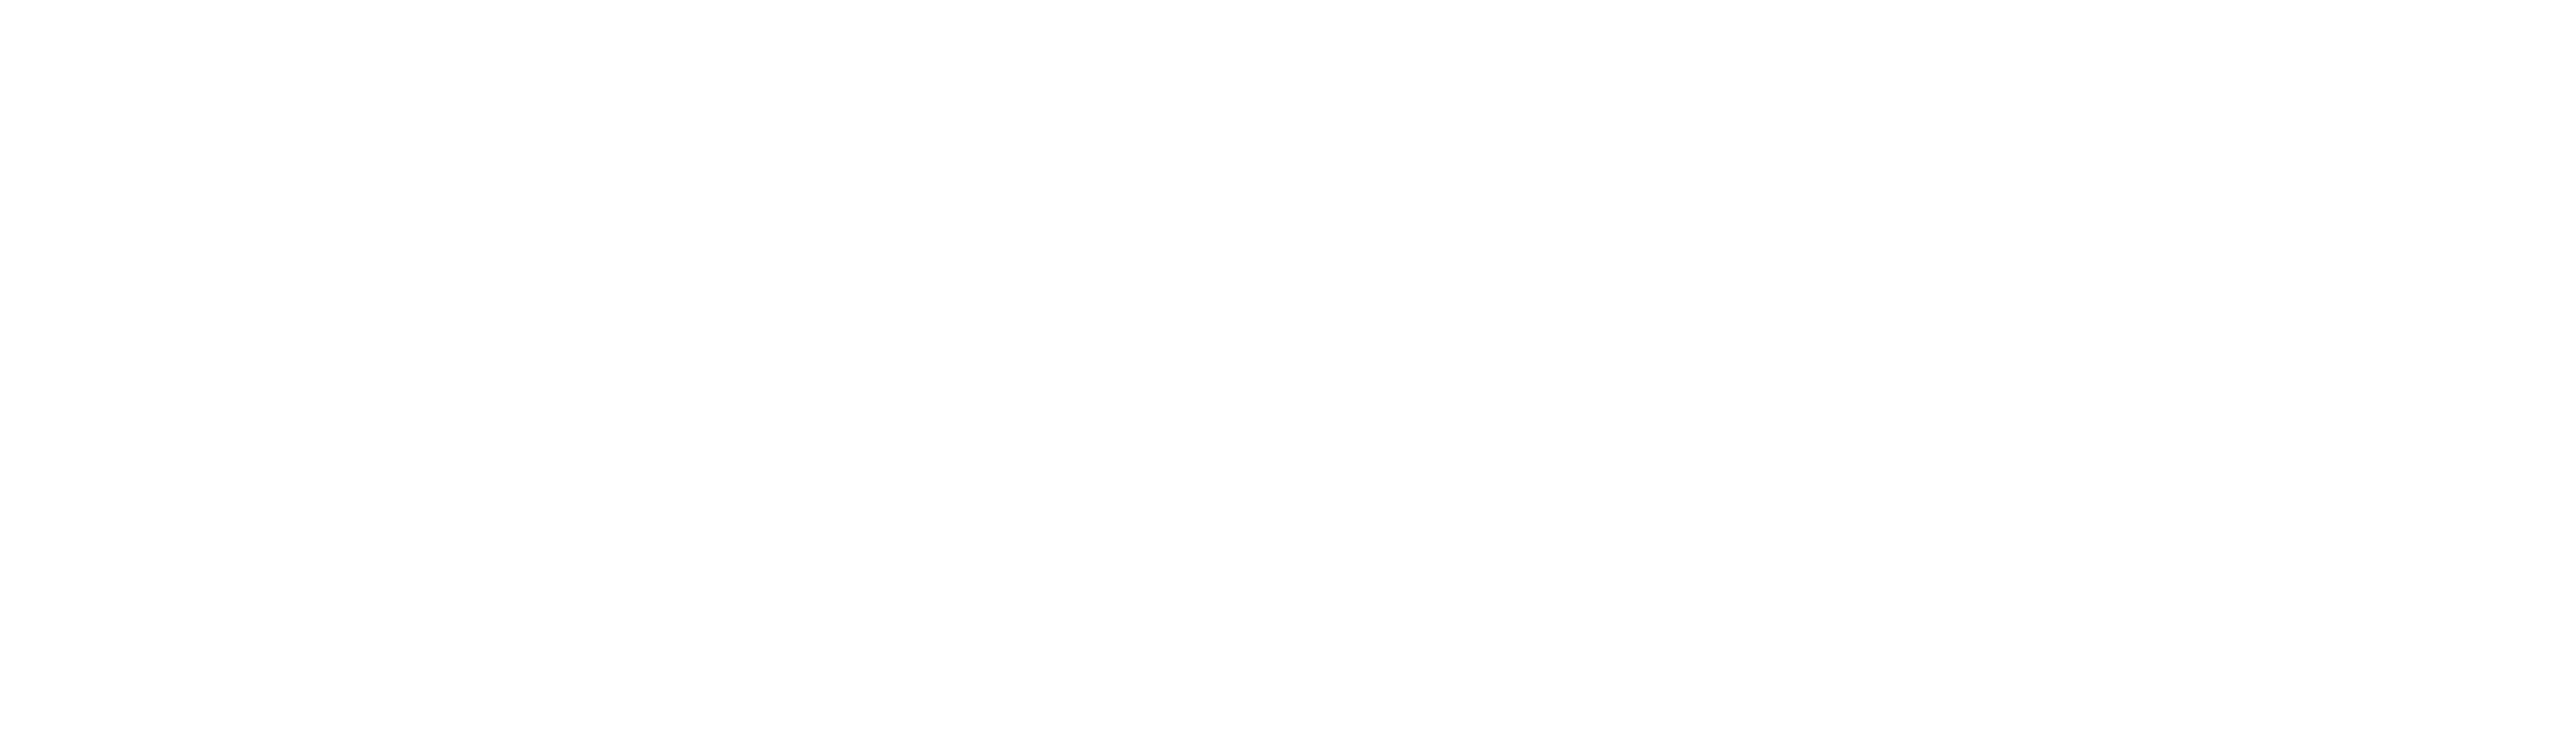

a370_SN_sourceplane/alfa_fits/Spectra_bin_5_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


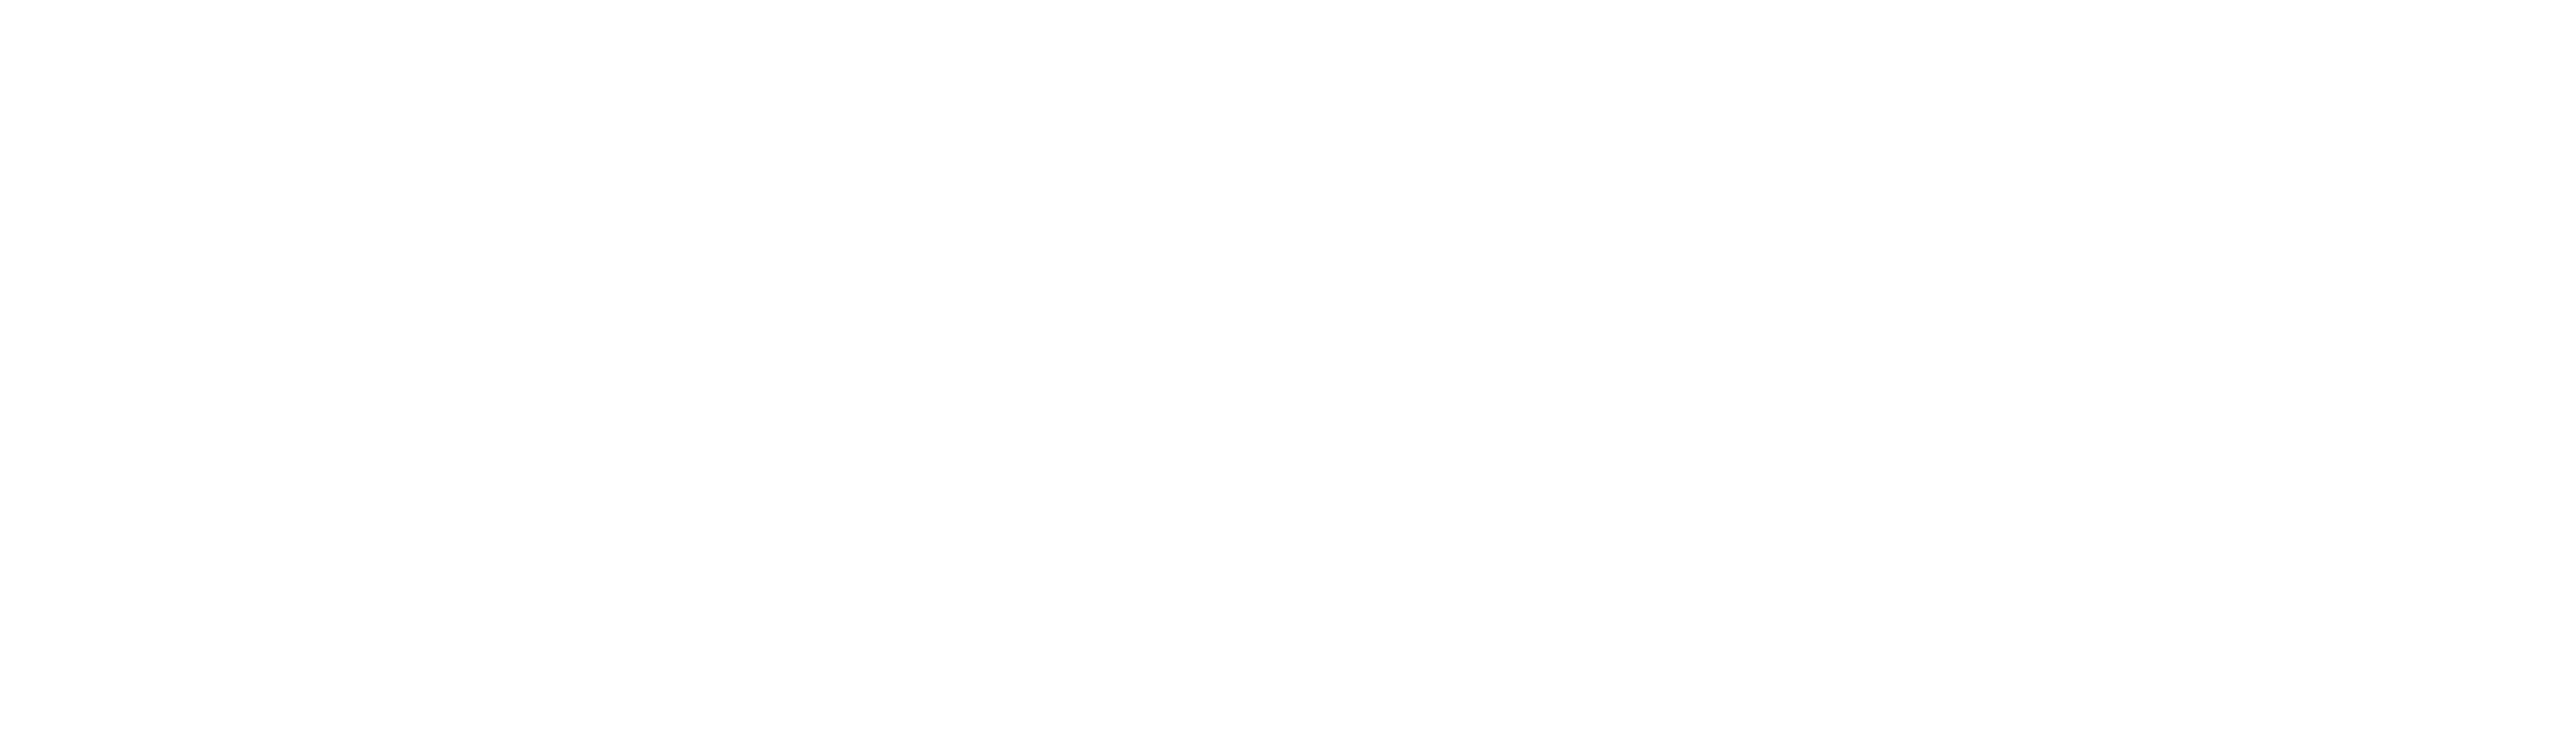

a370_SN_sourceplane/alfa_fits/Spectra_bin_60_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


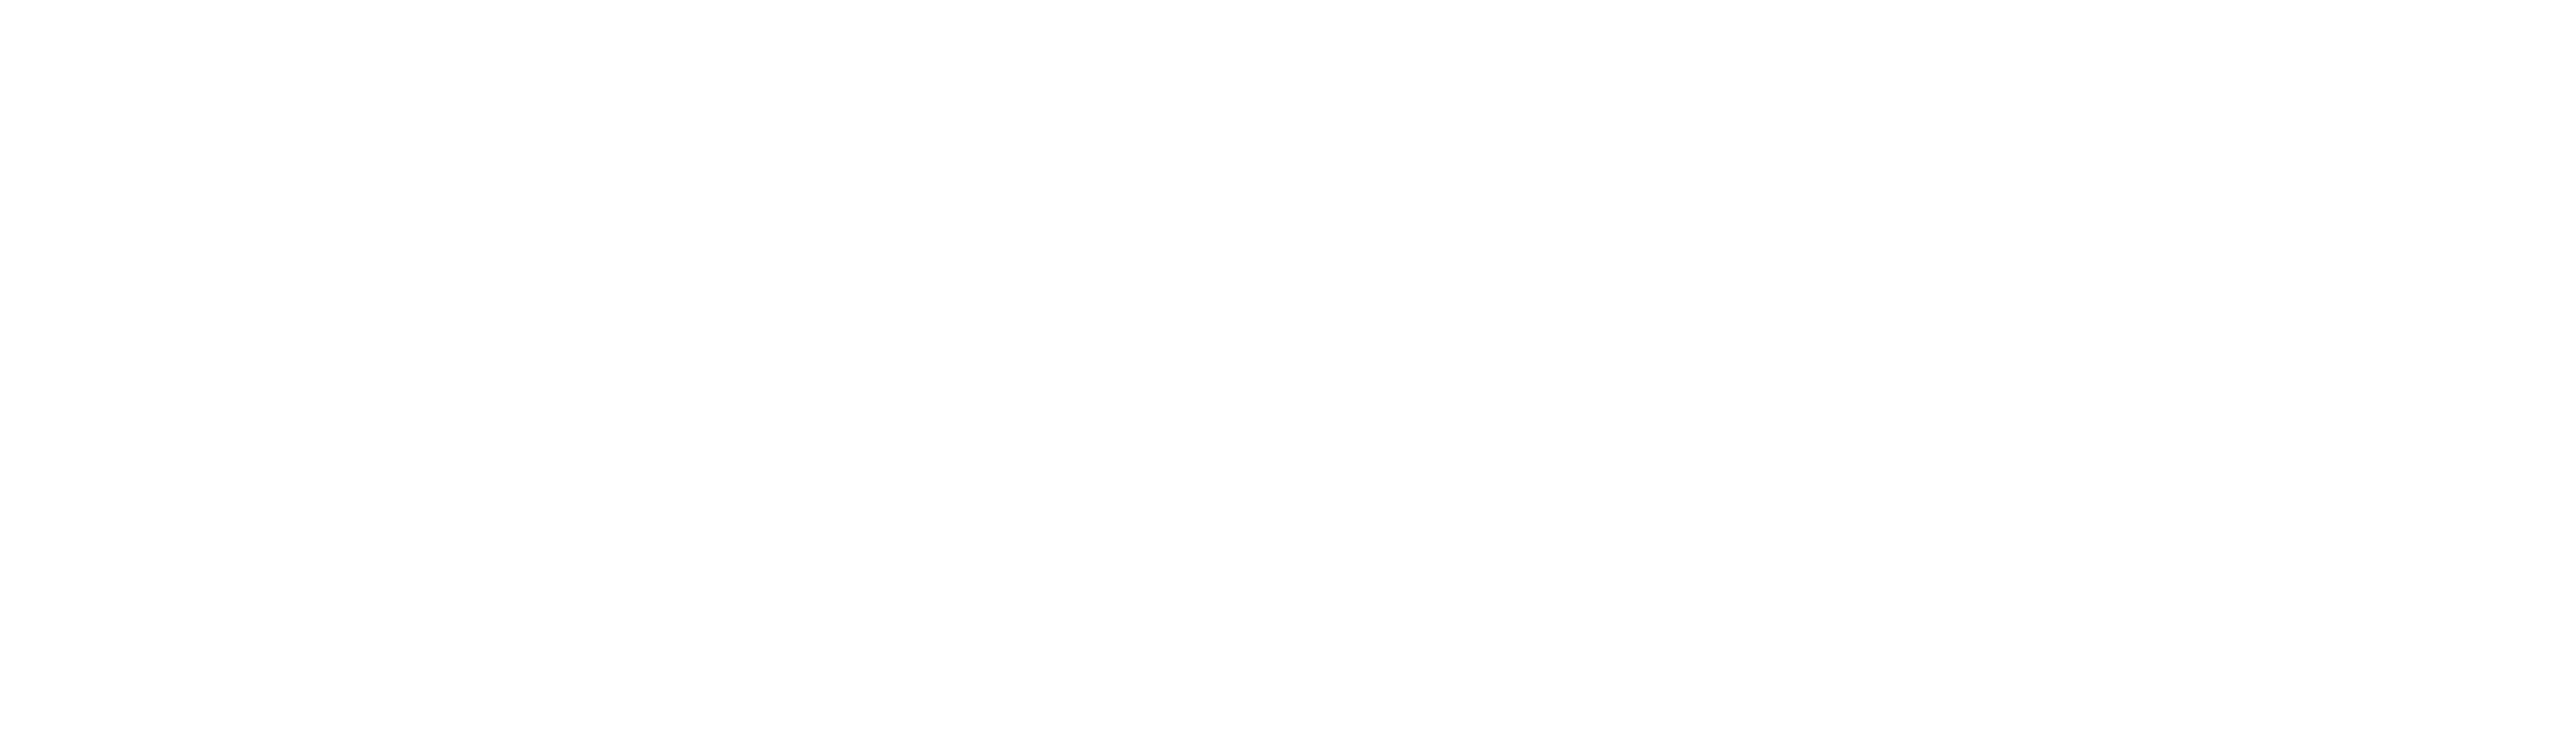

a370_SN_sourceplane/alfa_fits/Spectra_bin_61_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


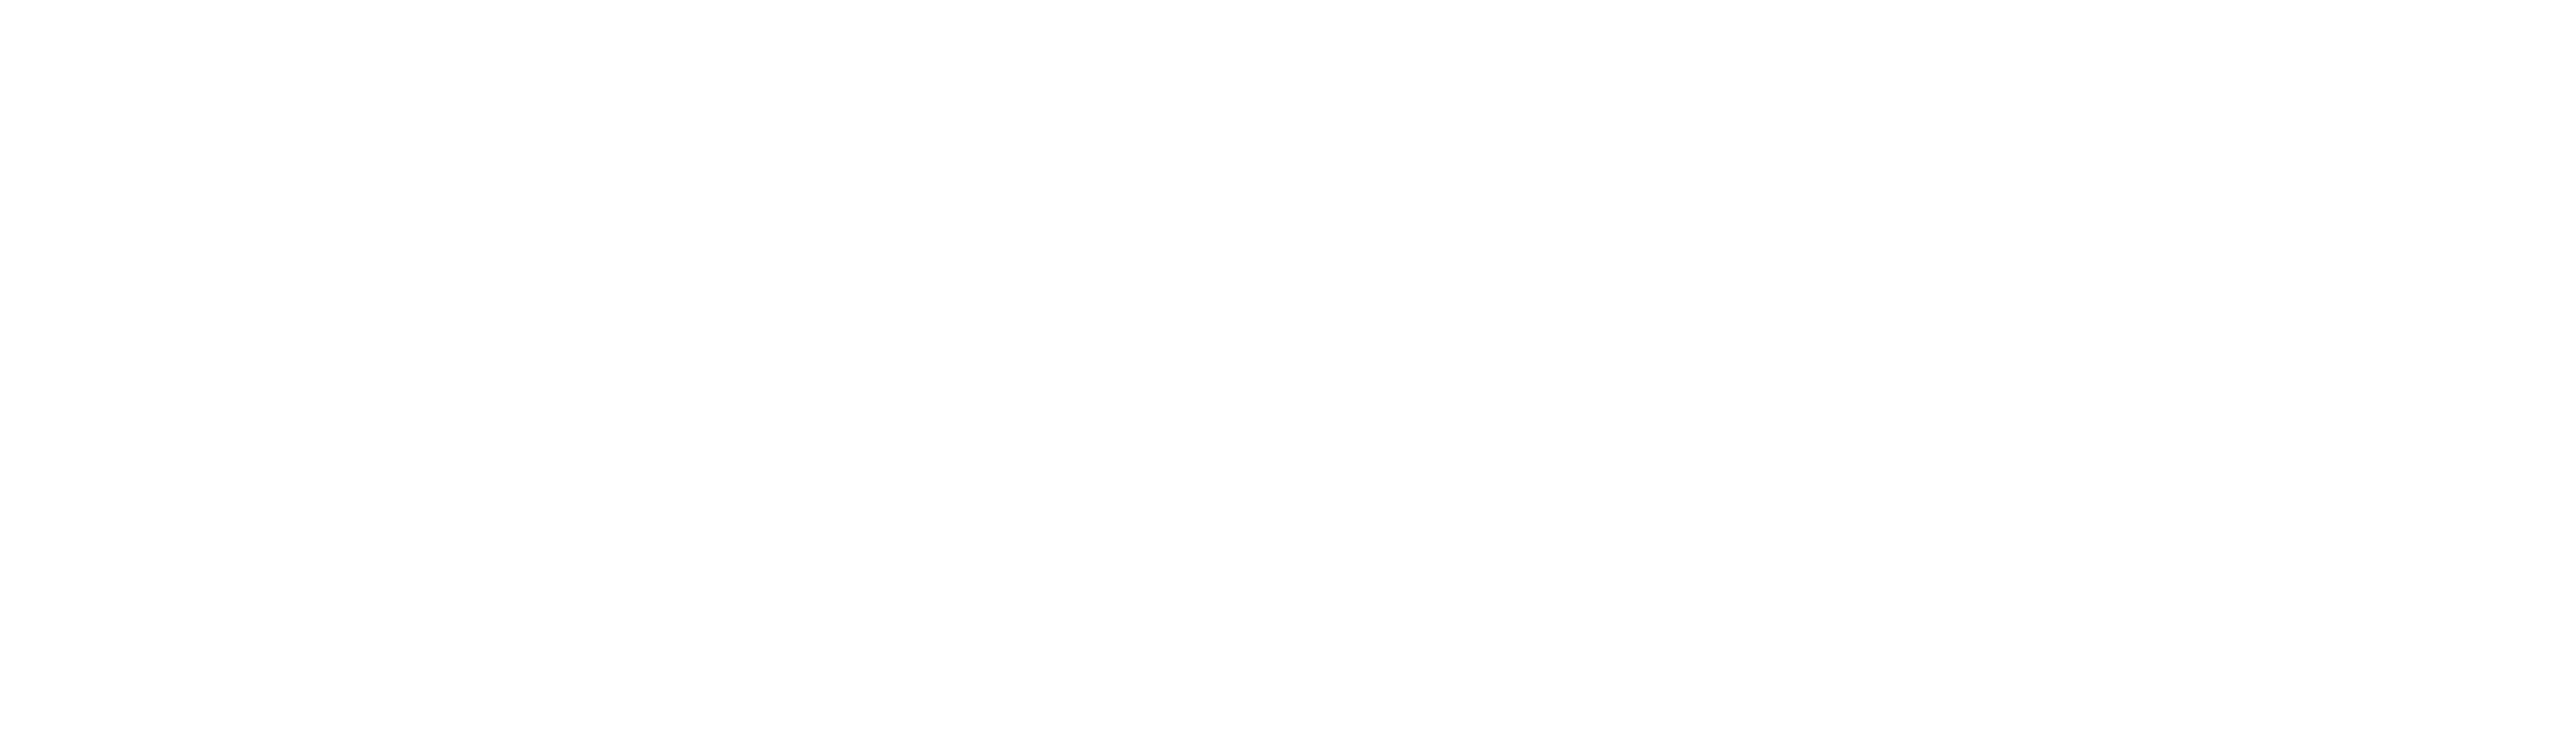

a370_SN_sourceplane/alfa_fits/Spectra_bin_62_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


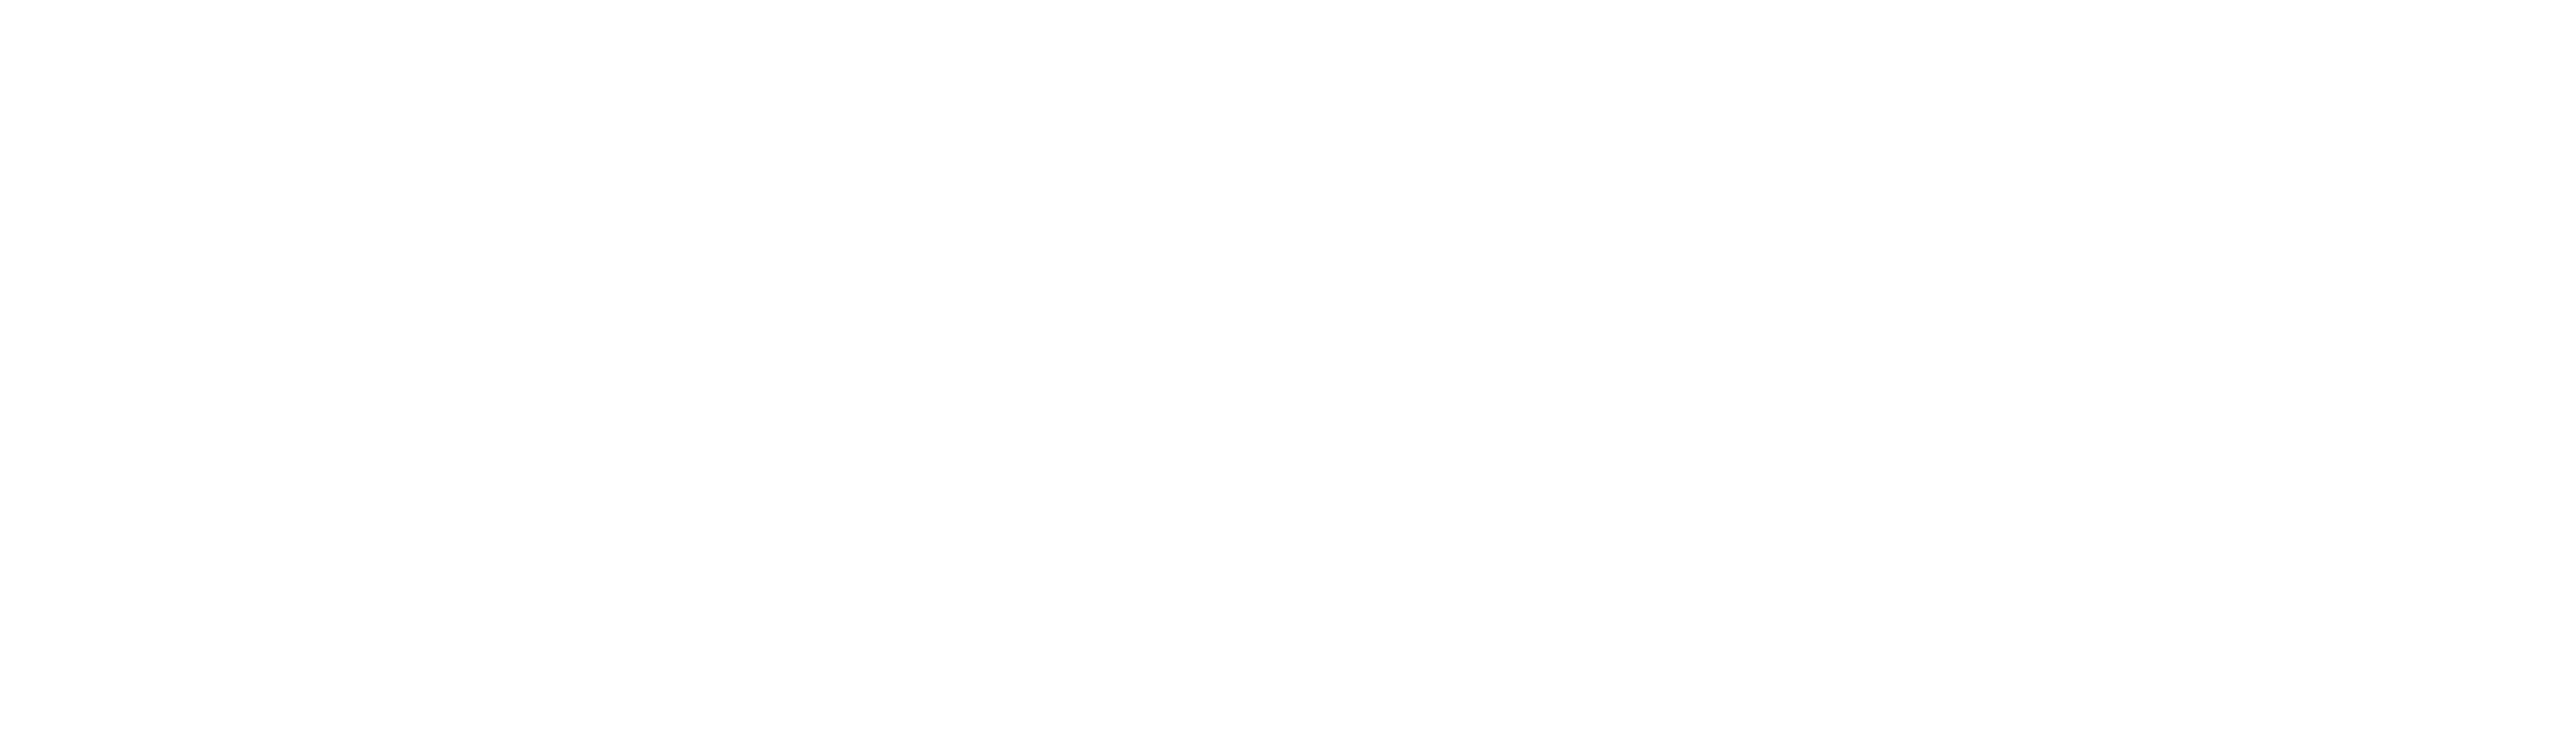

a370_SN_sourceplane/alfa_fits/Spectra_bin_63_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


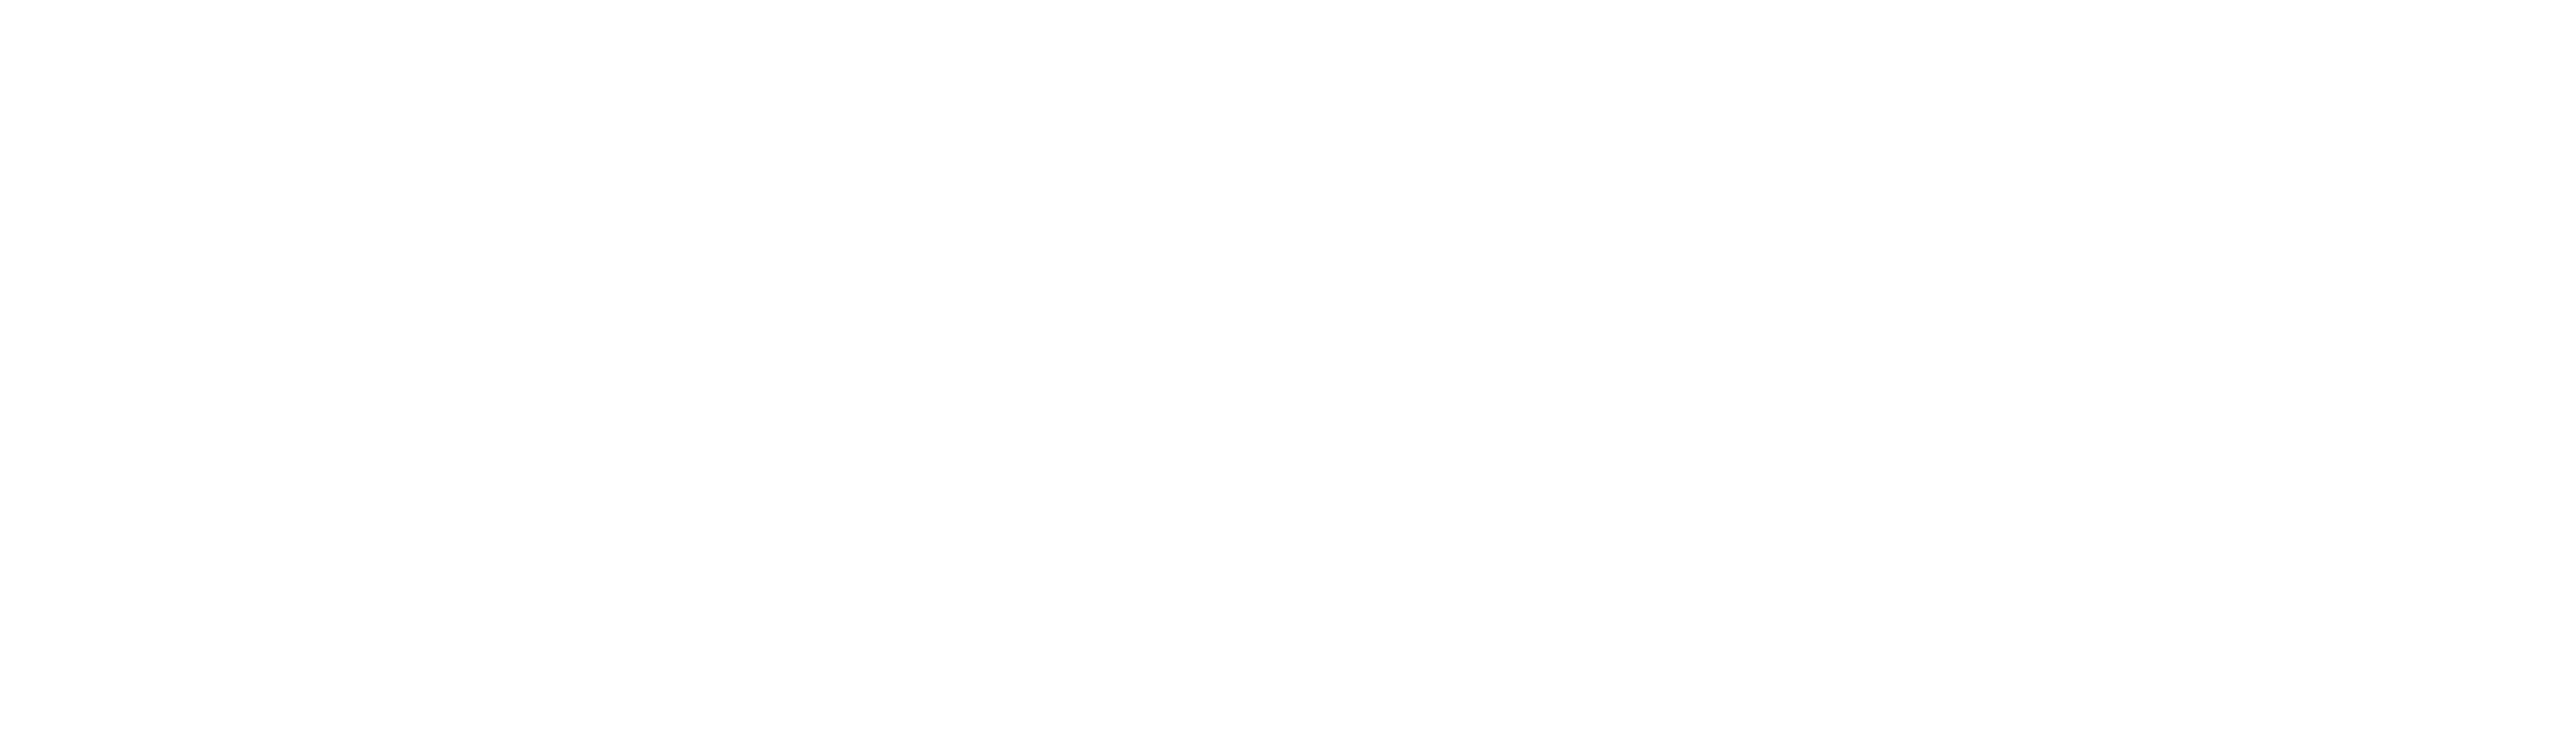

a370_SN_sourceplane/alfa_fits/Spectra_bin_64_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


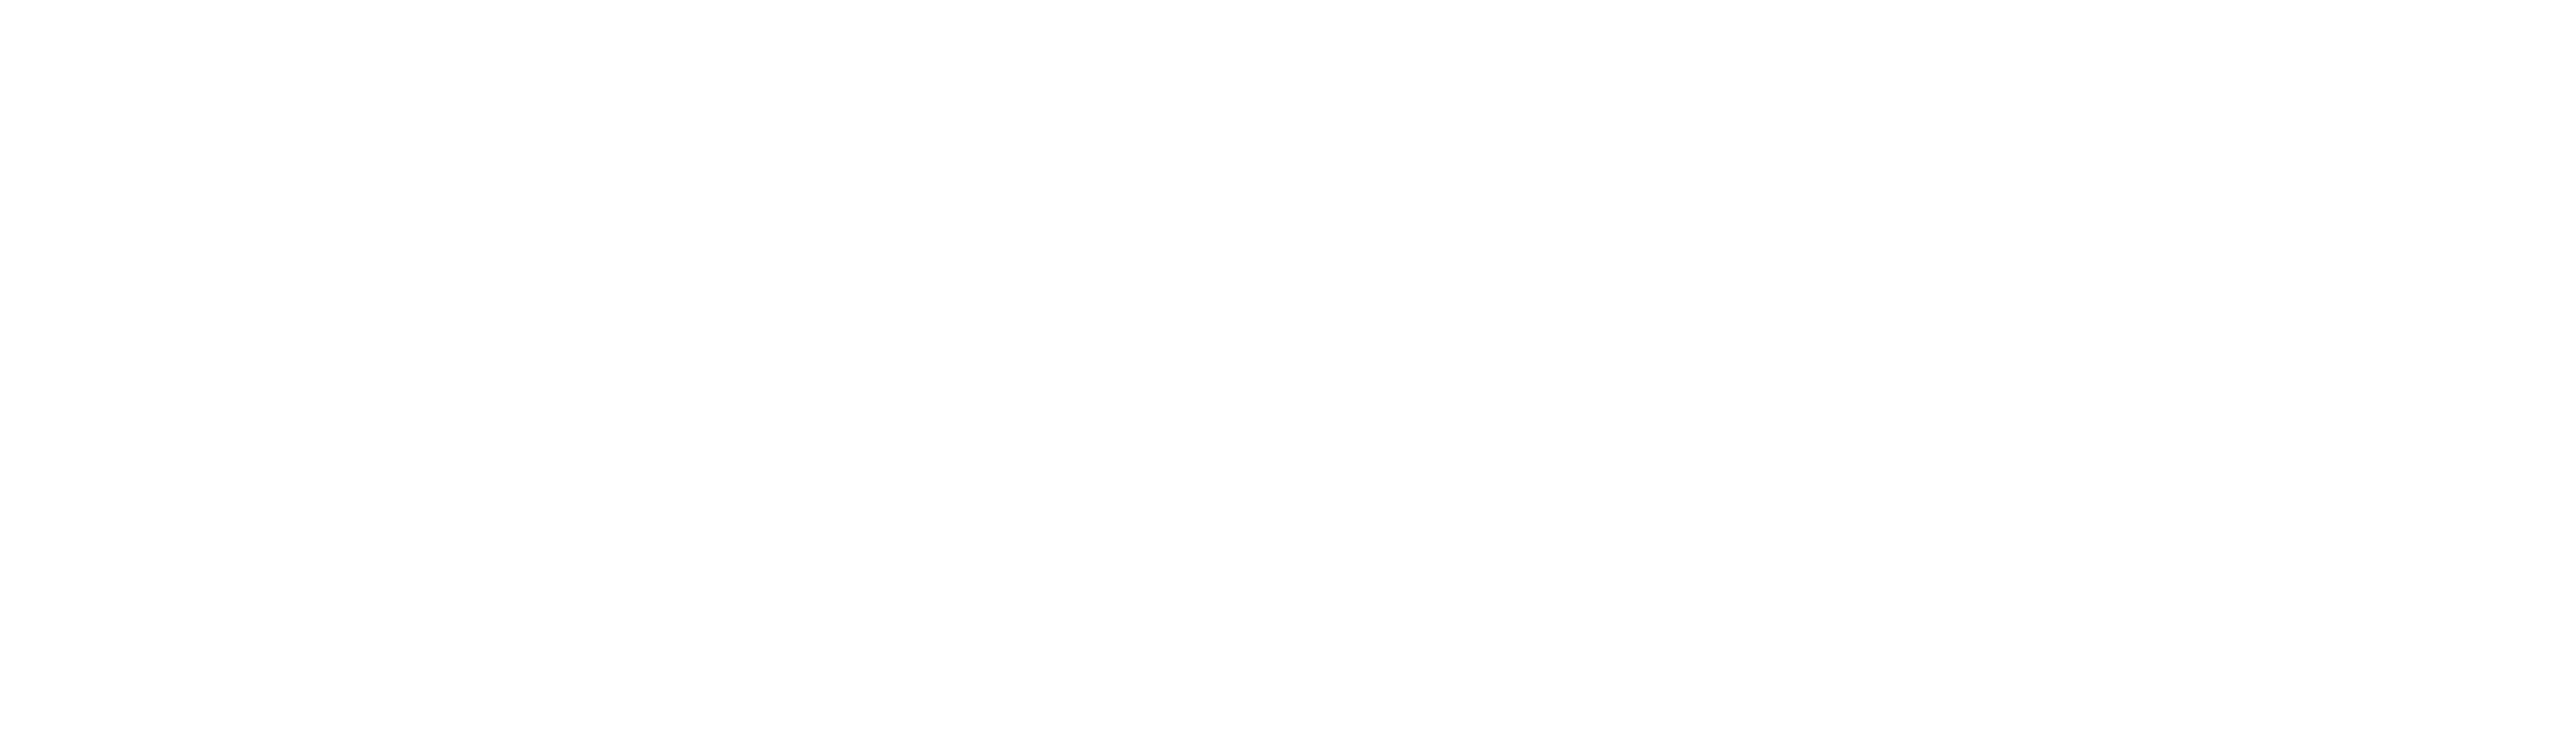

a370_SN_sourceplane/alfa_fits/Spectra_bin_65_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


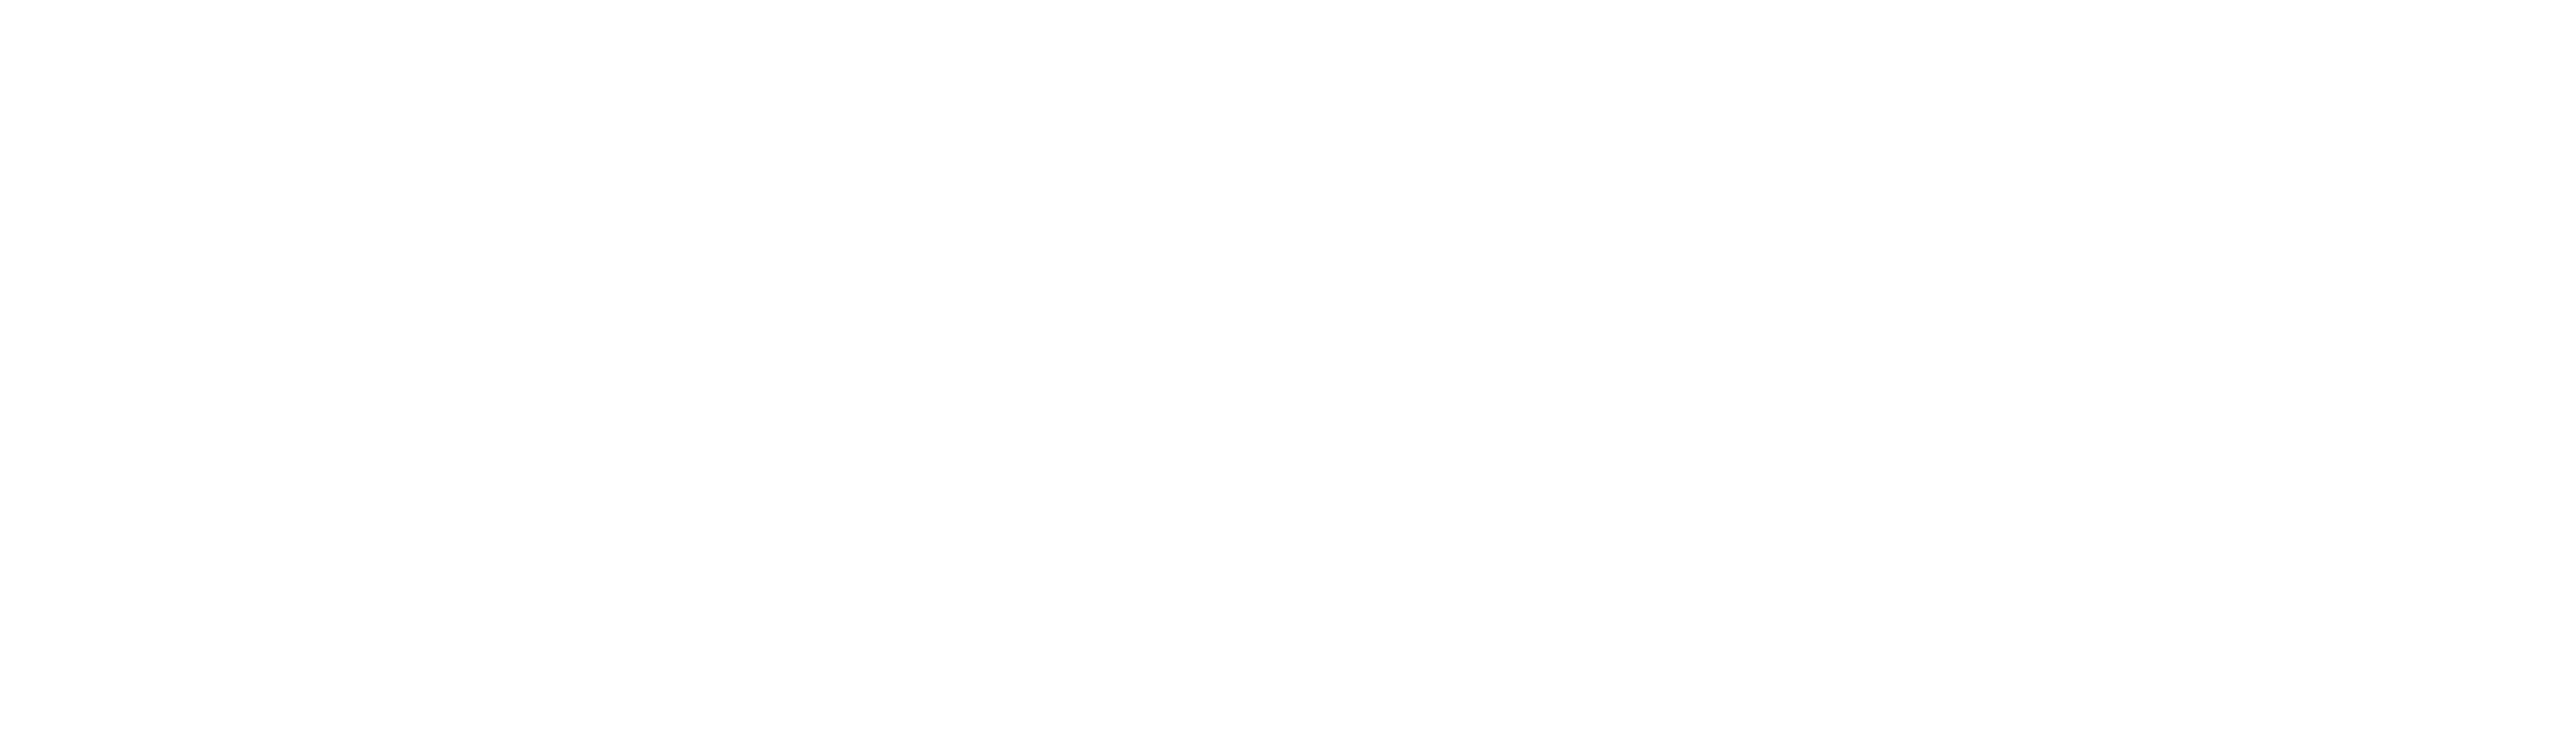

a370_SN_sourceplane/alfa_fits/Spectra_bin_66_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


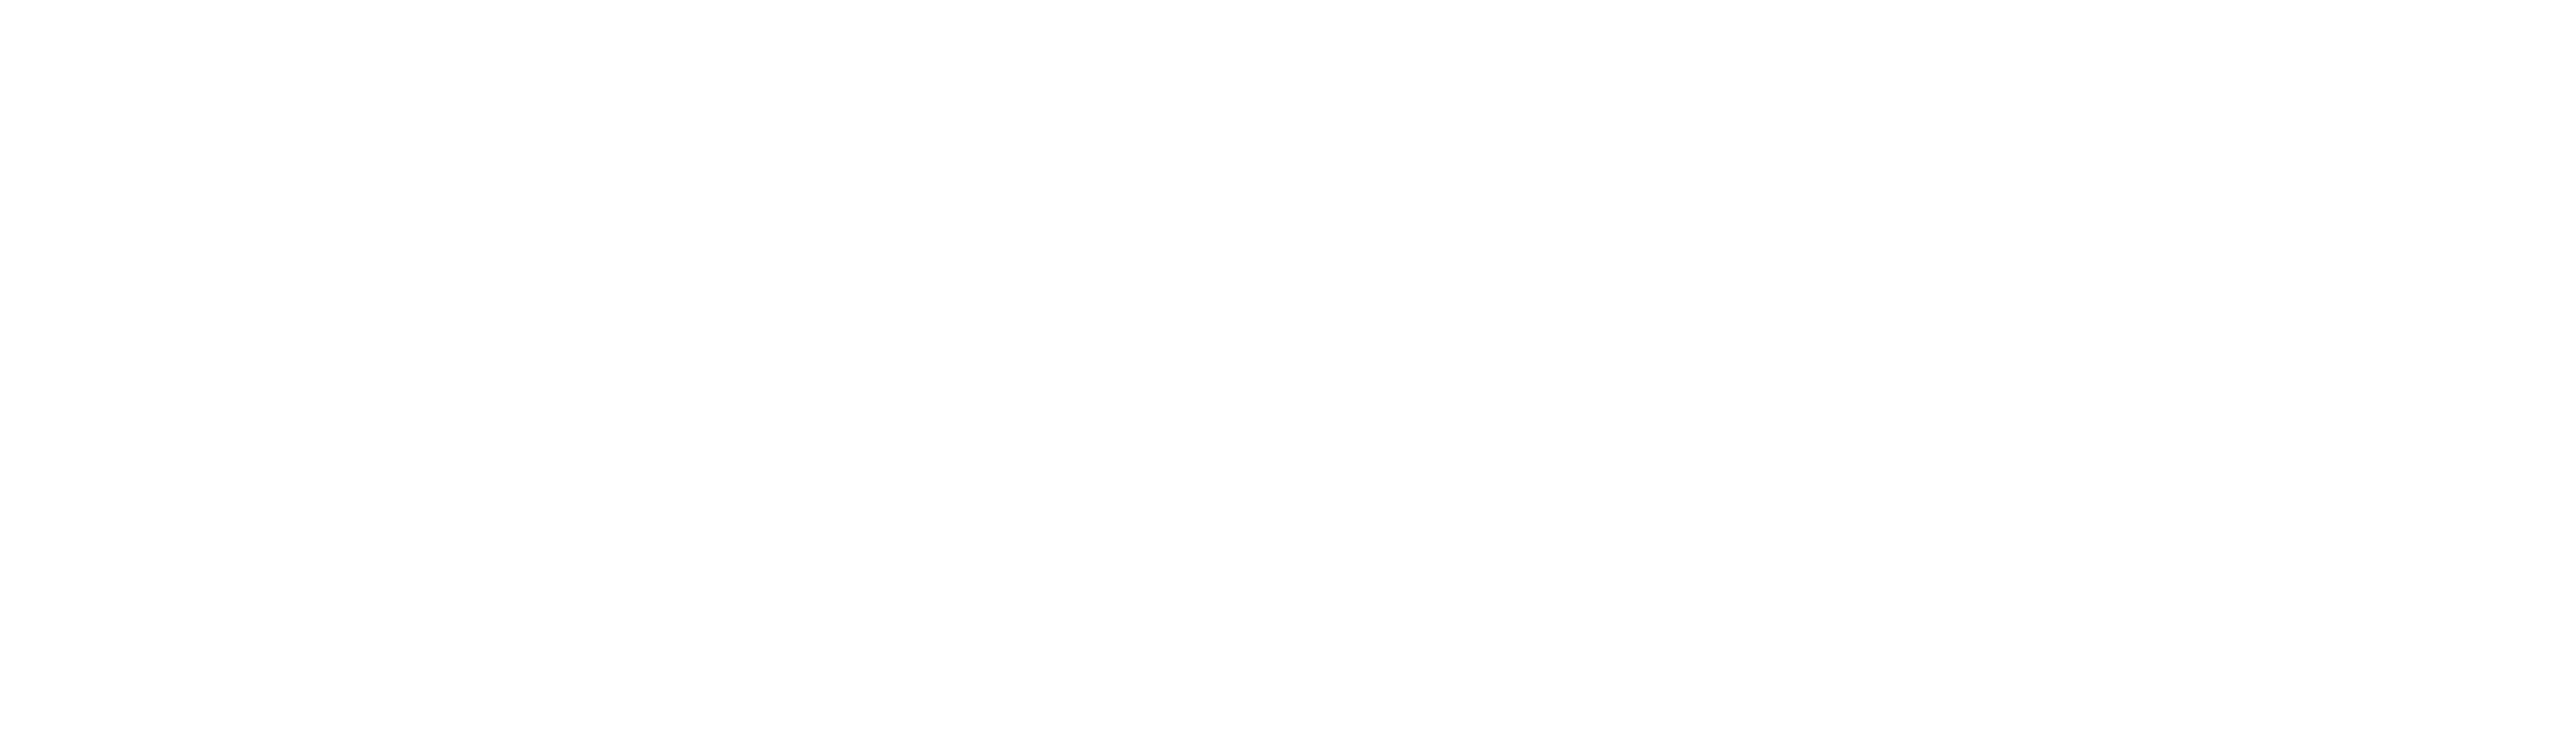

a370_SN_sourceplane/alfa_fits/Spectra_bin_67_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


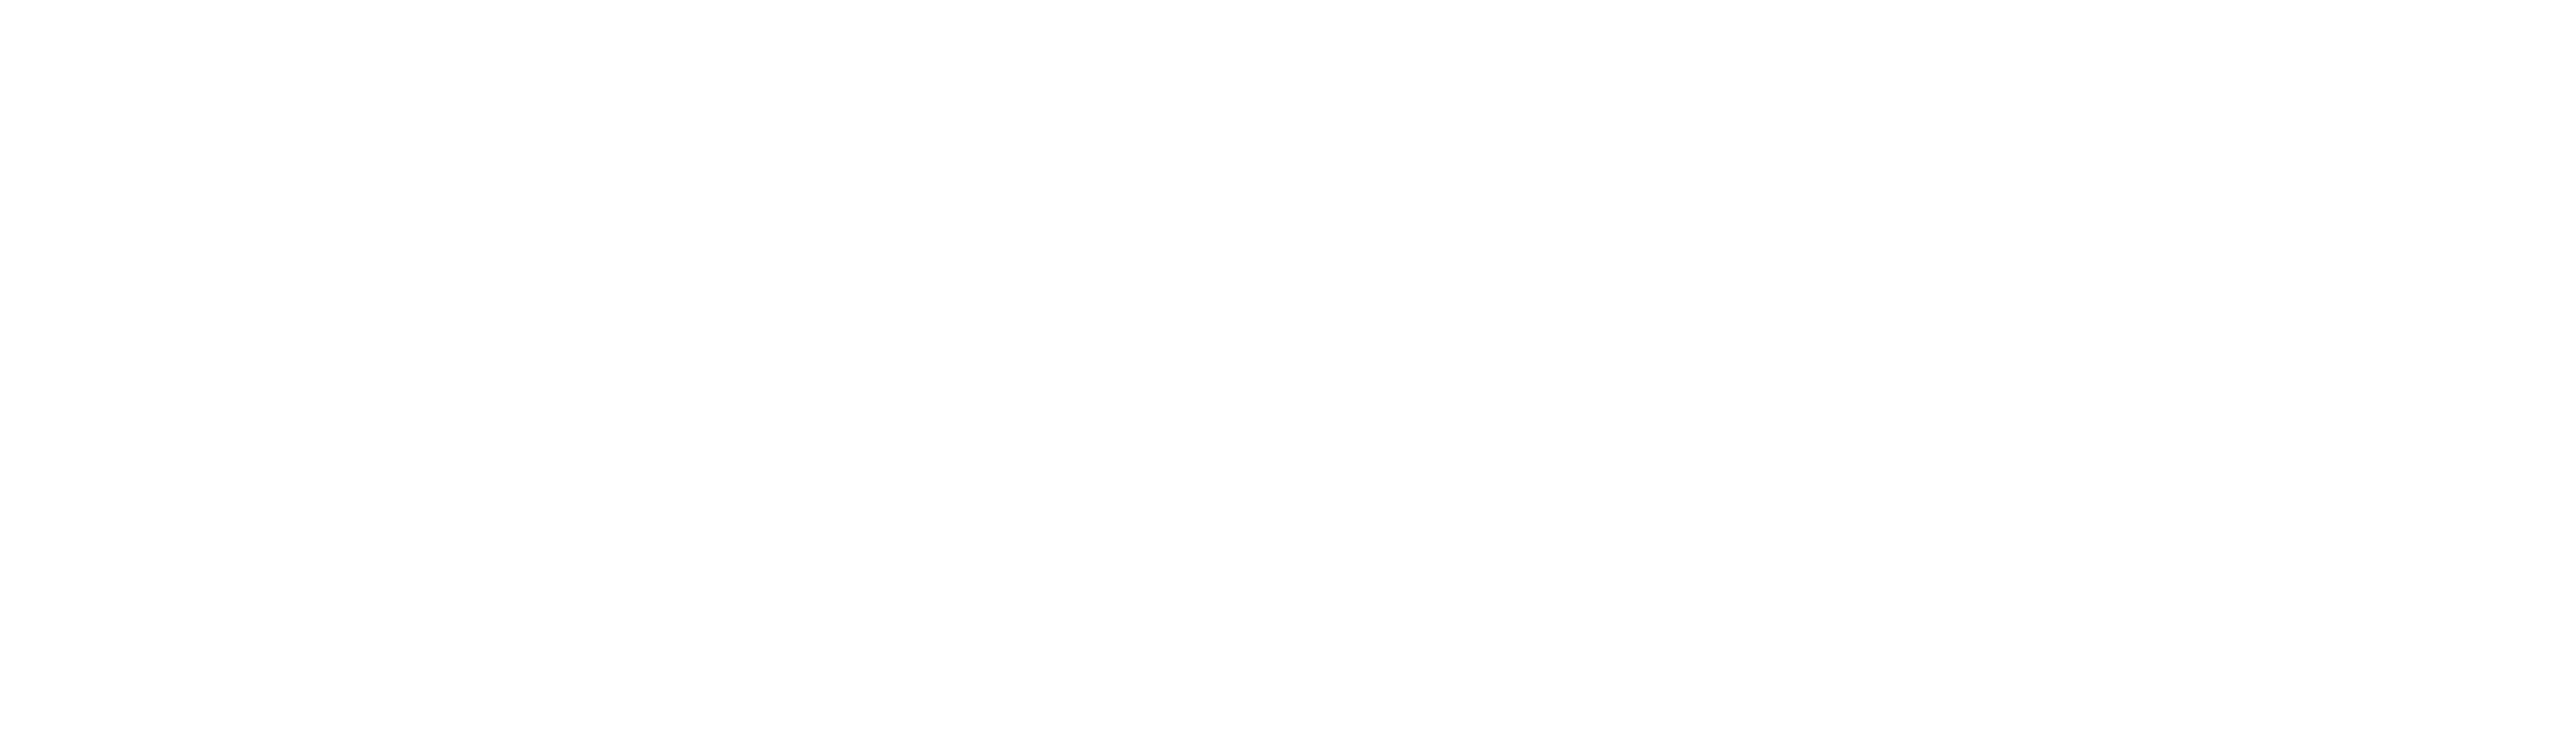

a370_SN_sourceplane/alfa_fits/Spectra_bin_68_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


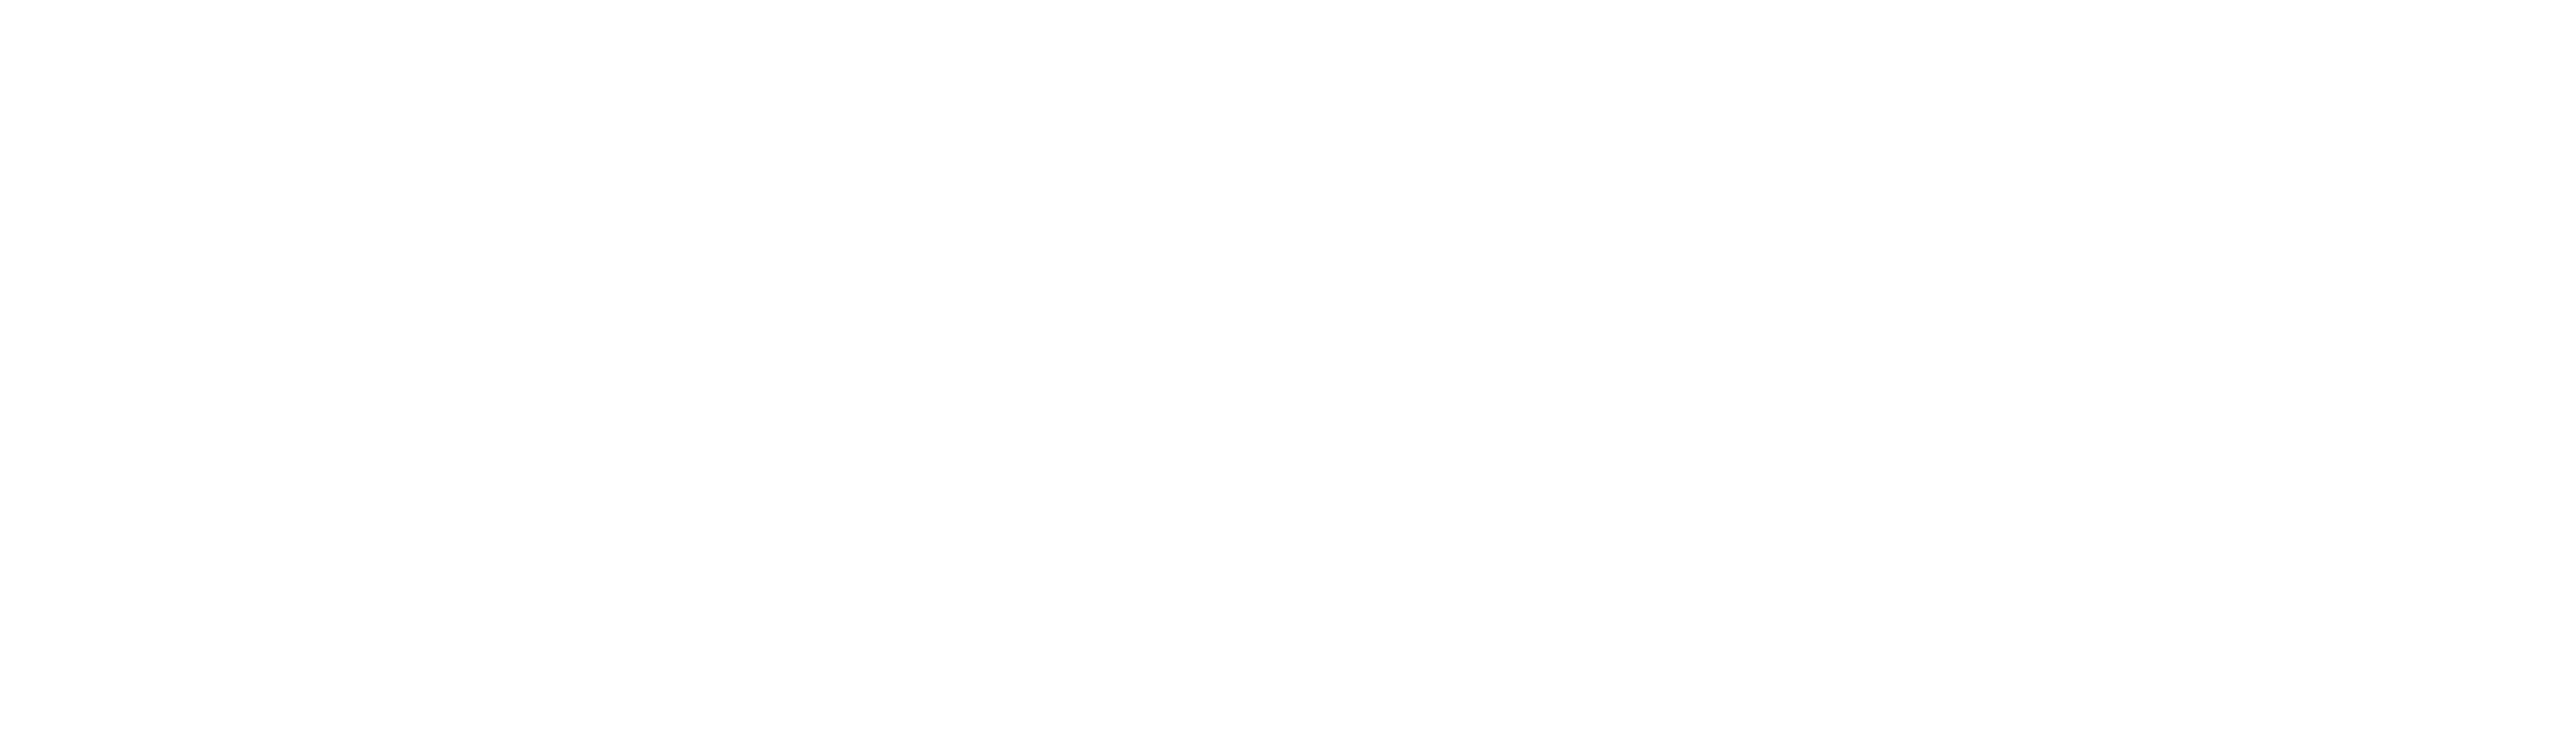

a370_SN_sourceplane/alfa_fits/Spectra_bin_69_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


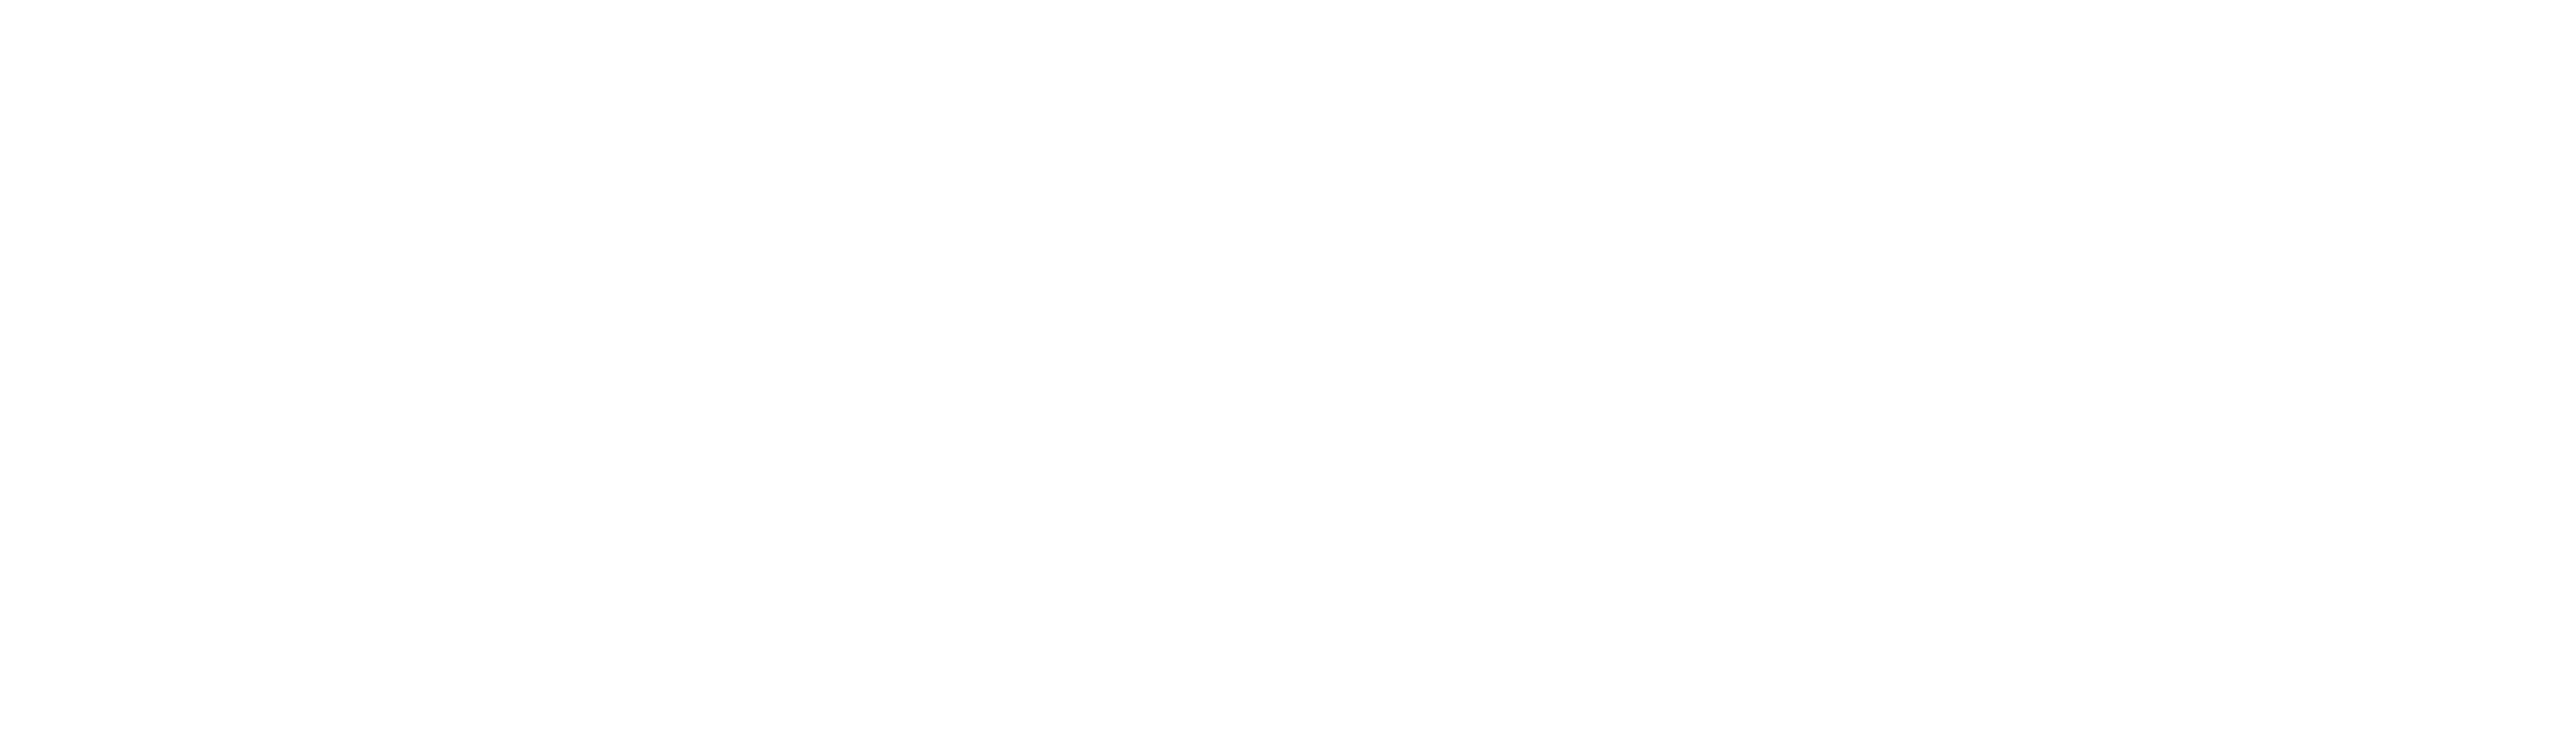

a370_SN_sourceplane/alfa_fits/Spectra_bin_6_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


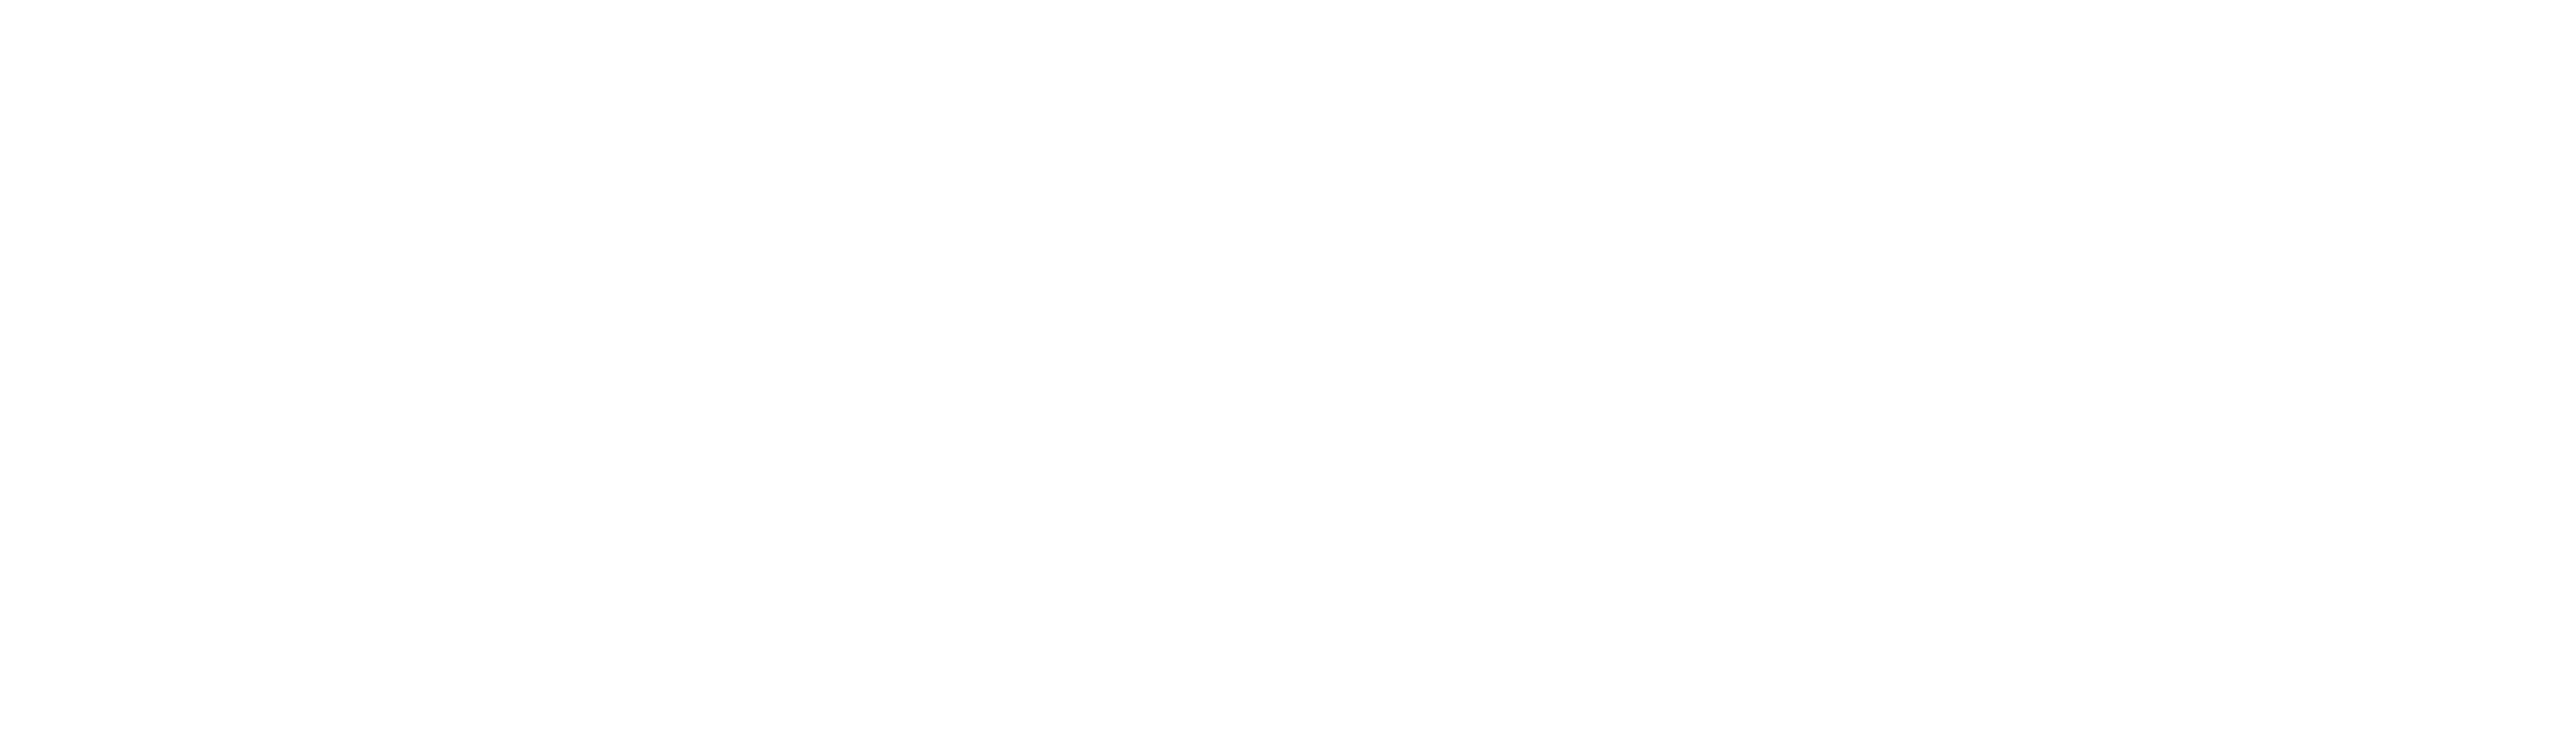

a370_SN_sourceplane/alfa_fits/Spectra_bin_70_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


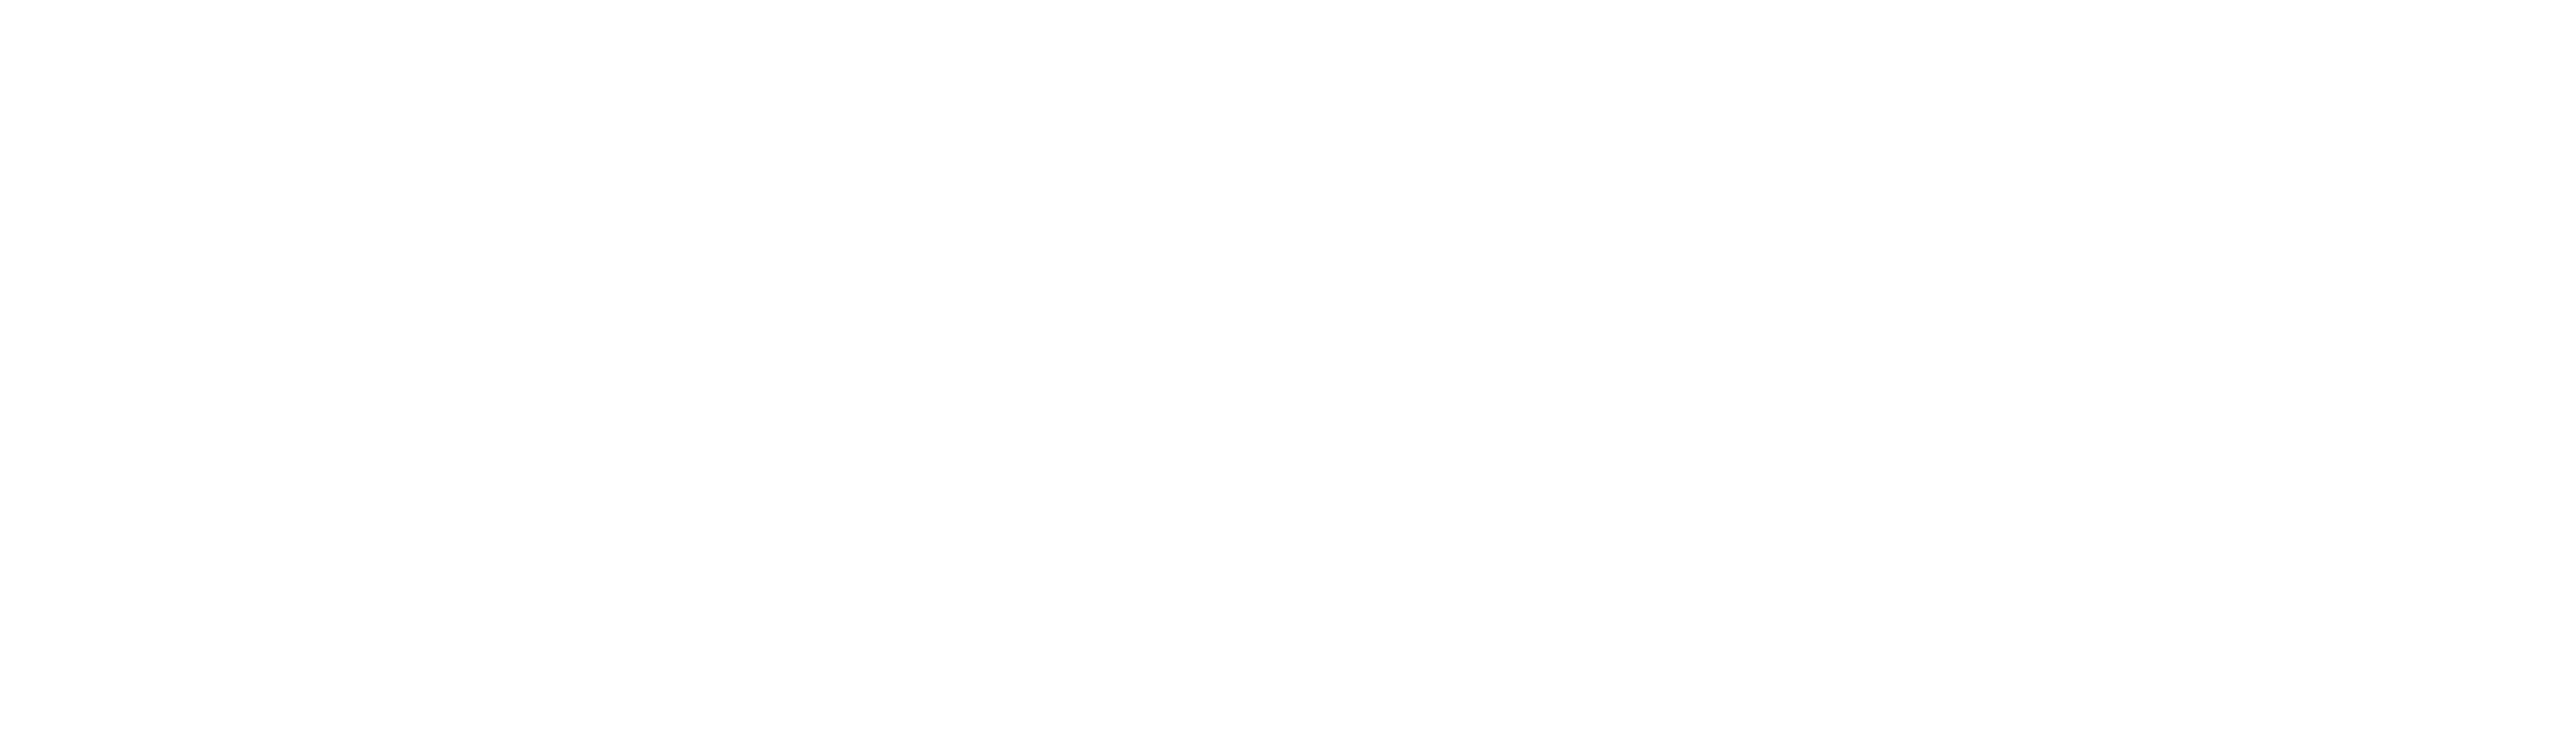

a370_SN_sourceplane/alfa_fits/Spectra_bin_71_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


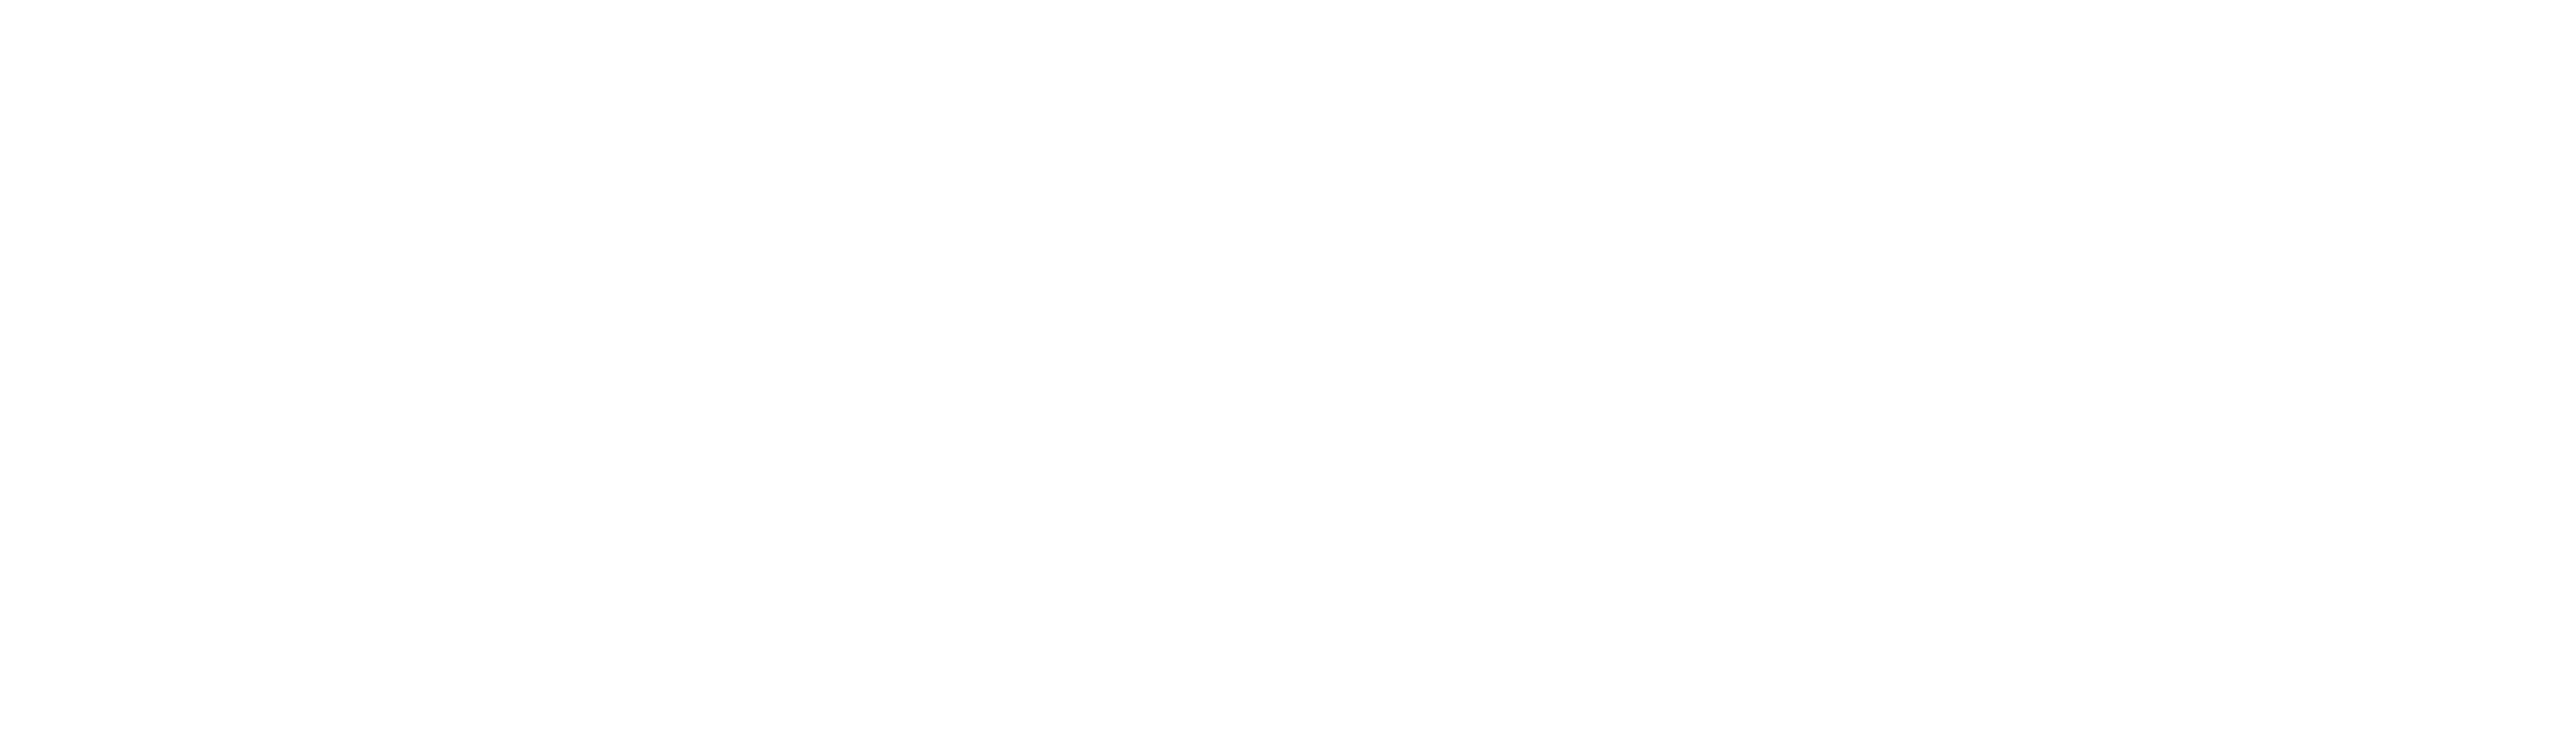

a370_SN_sourceplane/alfa_fits/Spectra_bin_72_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


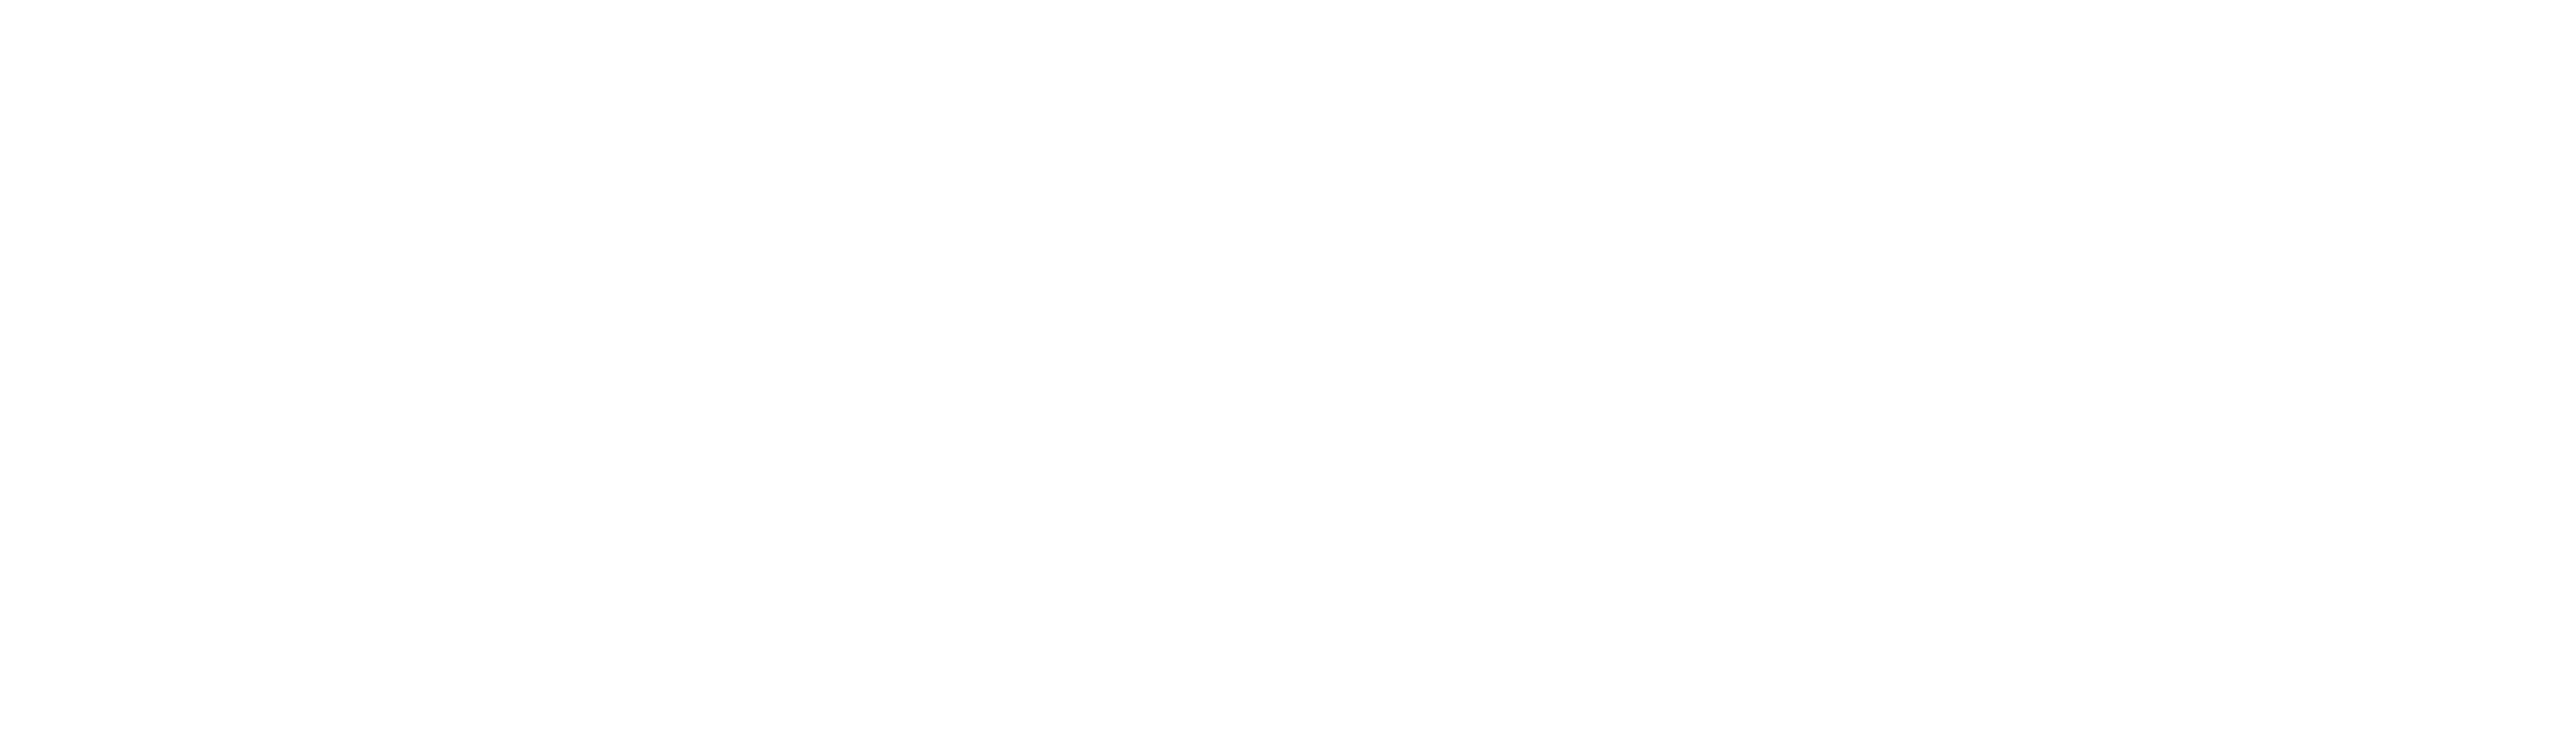

a370_SN_sourceplane/alfa_fits/Spectra_bin_73_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


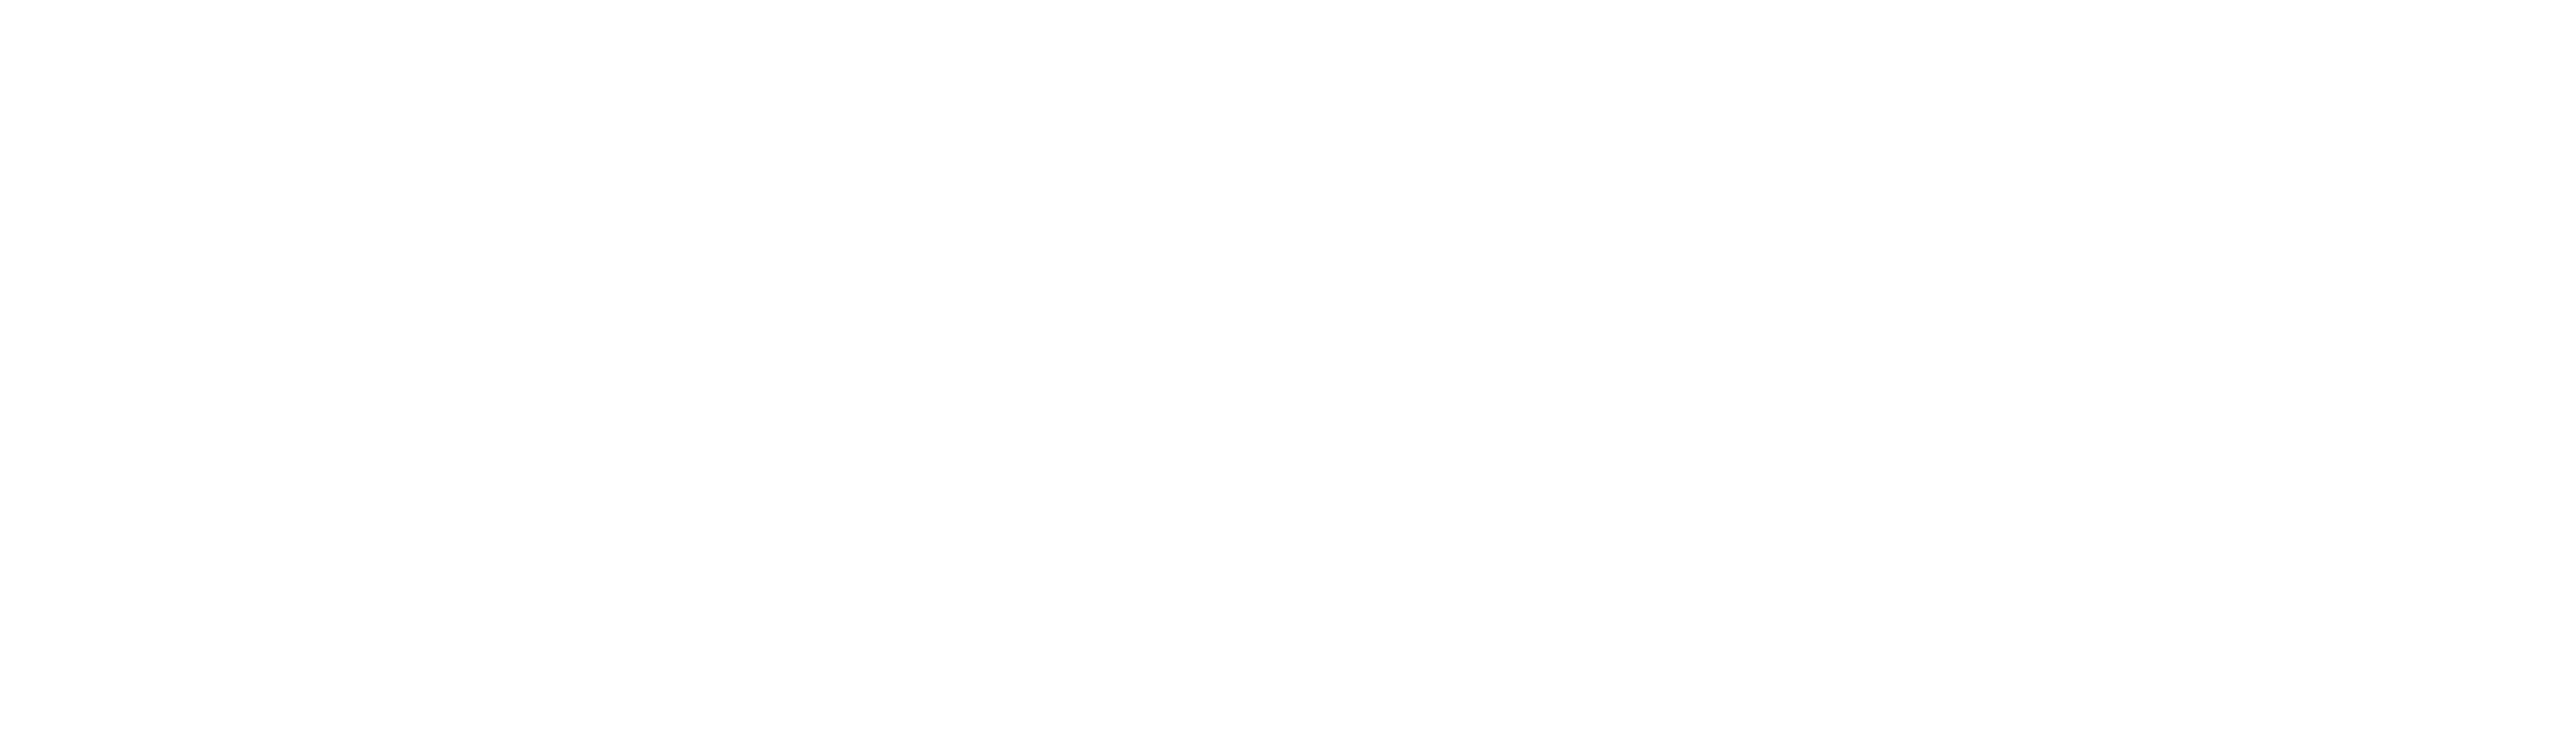

a370_SN_sourceplane/alfa_fits/Spectra_bin_74_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


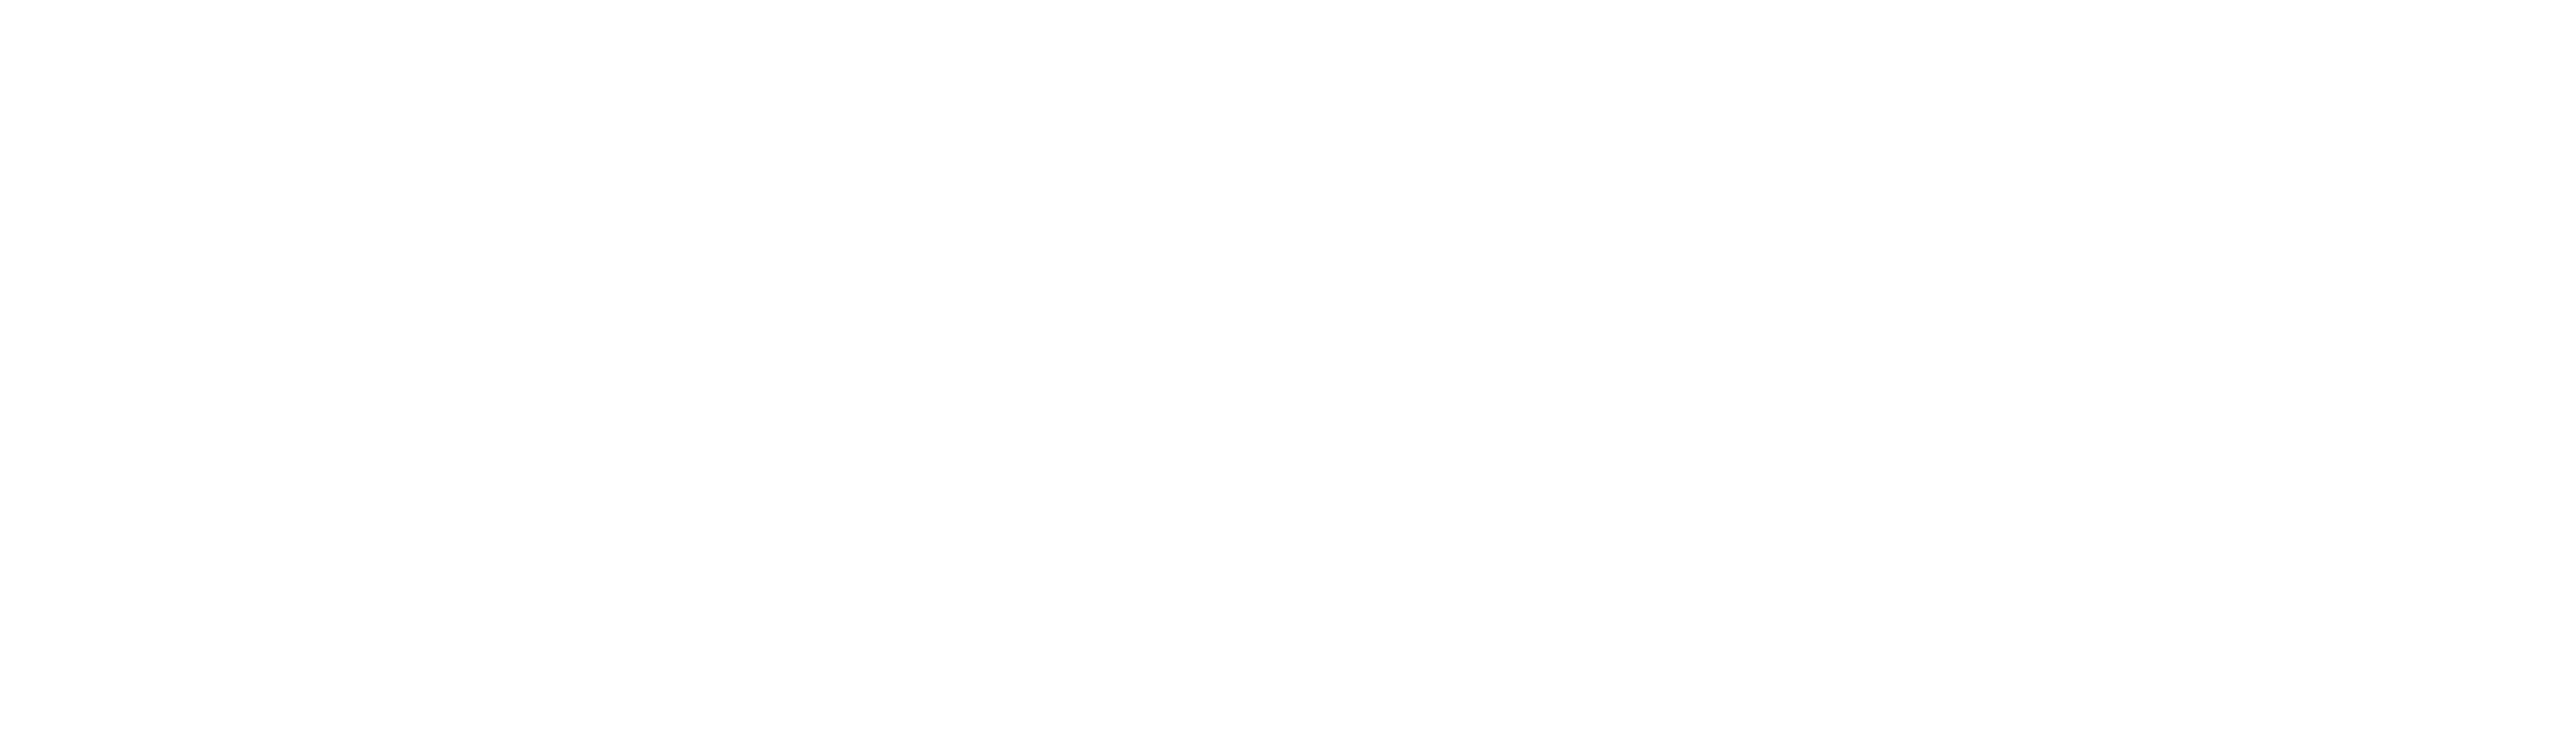

a370_SN_sourceplane/alfa_fits/Spectra_bin_75_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


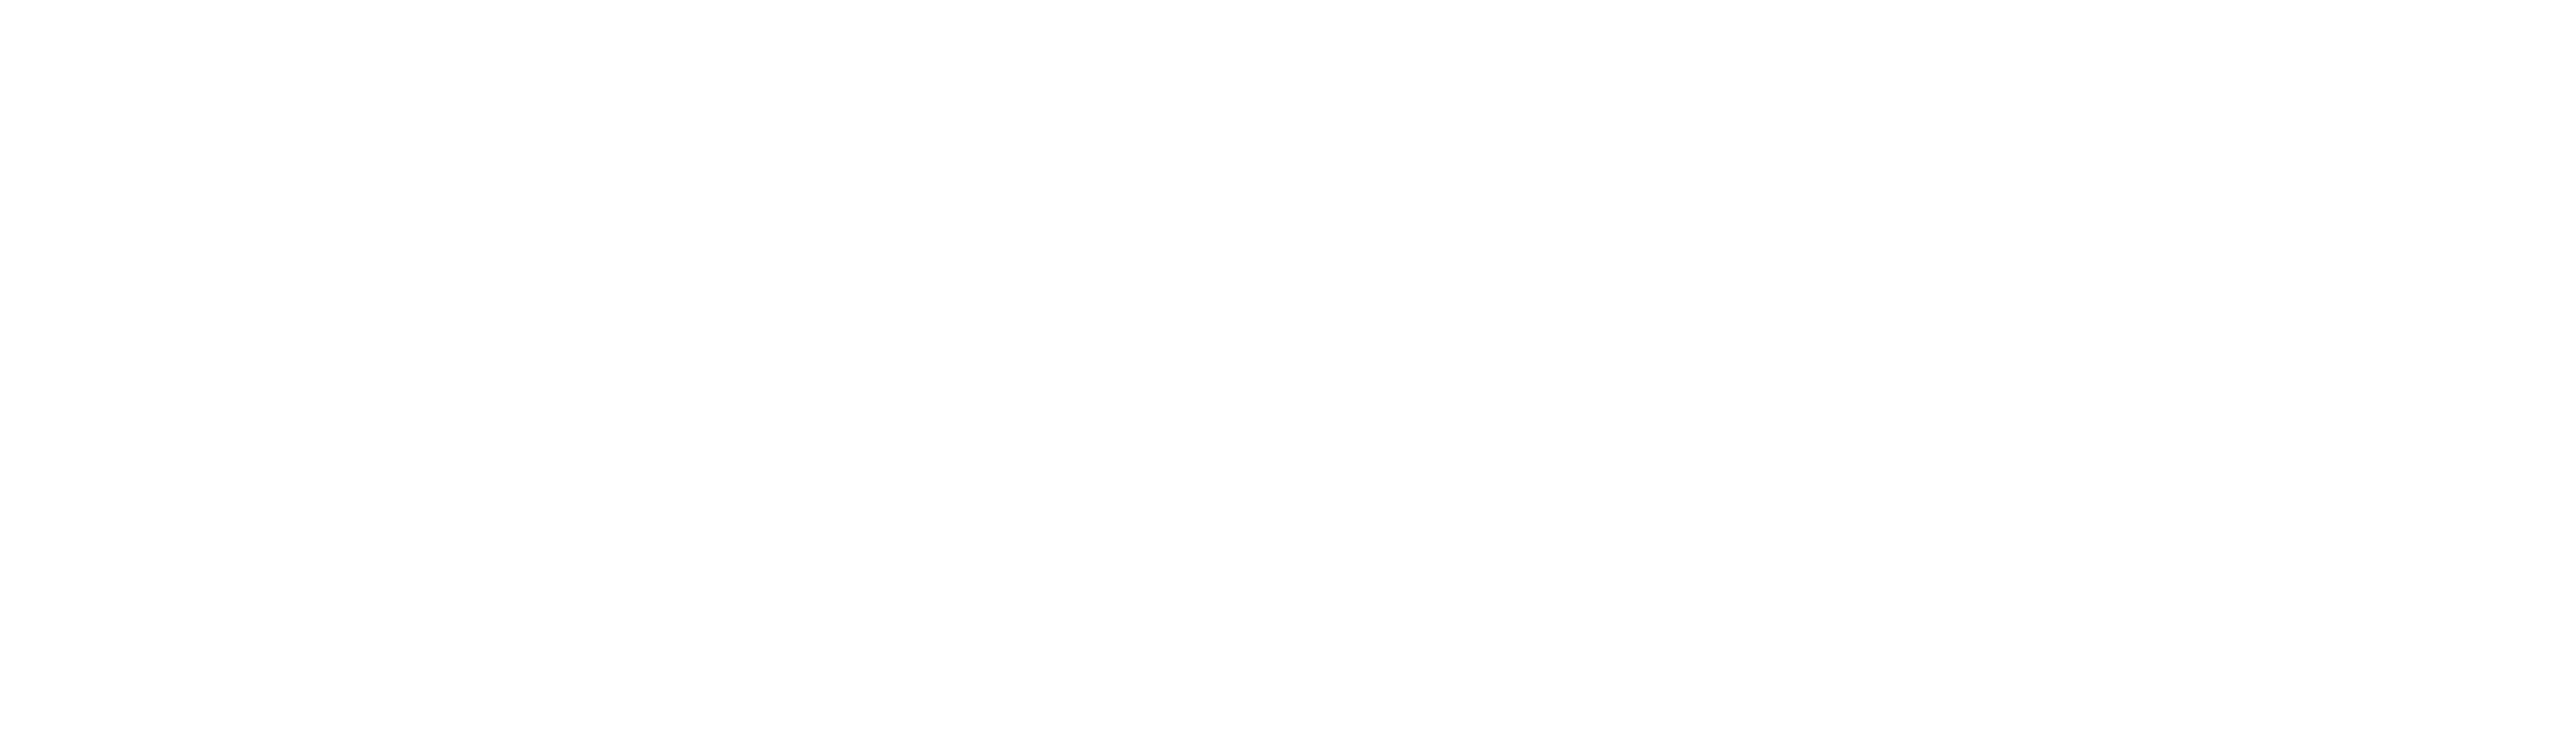

a370_SN_sourceplane/alfa_fits/Spectra_bin_76_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


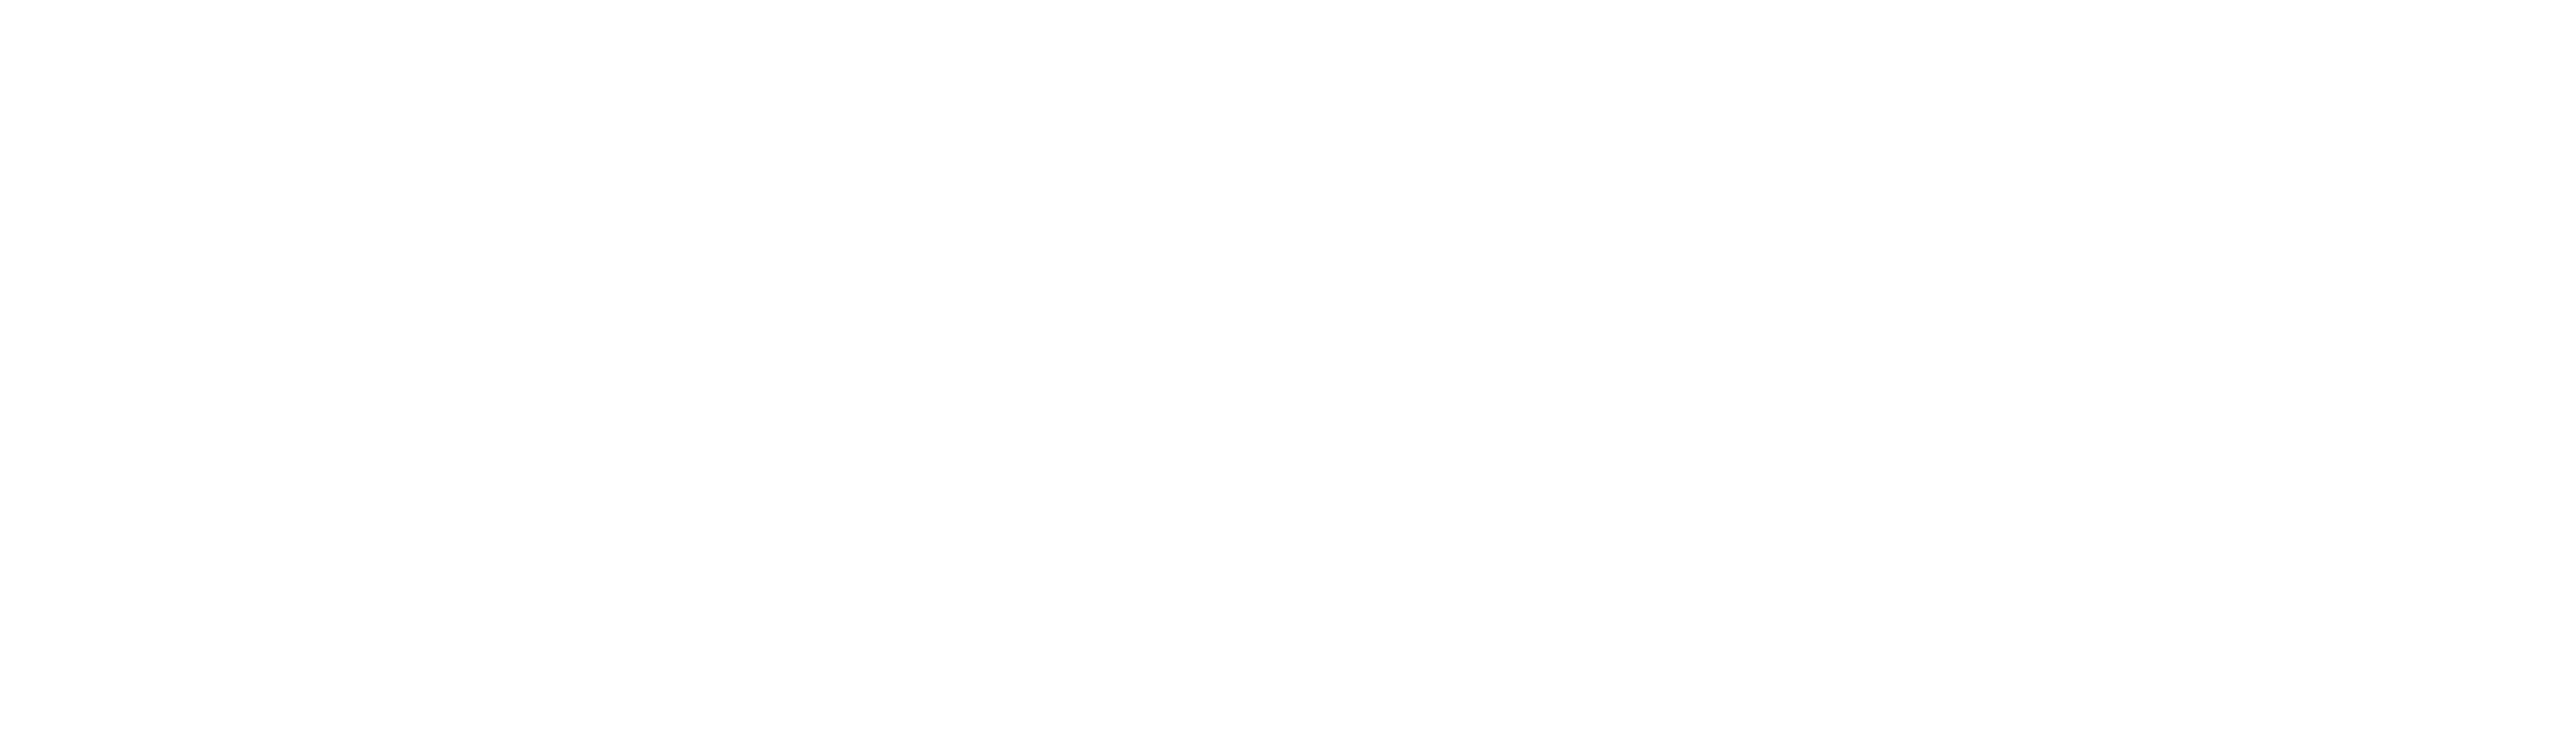

a370_SN_sourceplane/alfa_fits/Spectra_bin_77_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


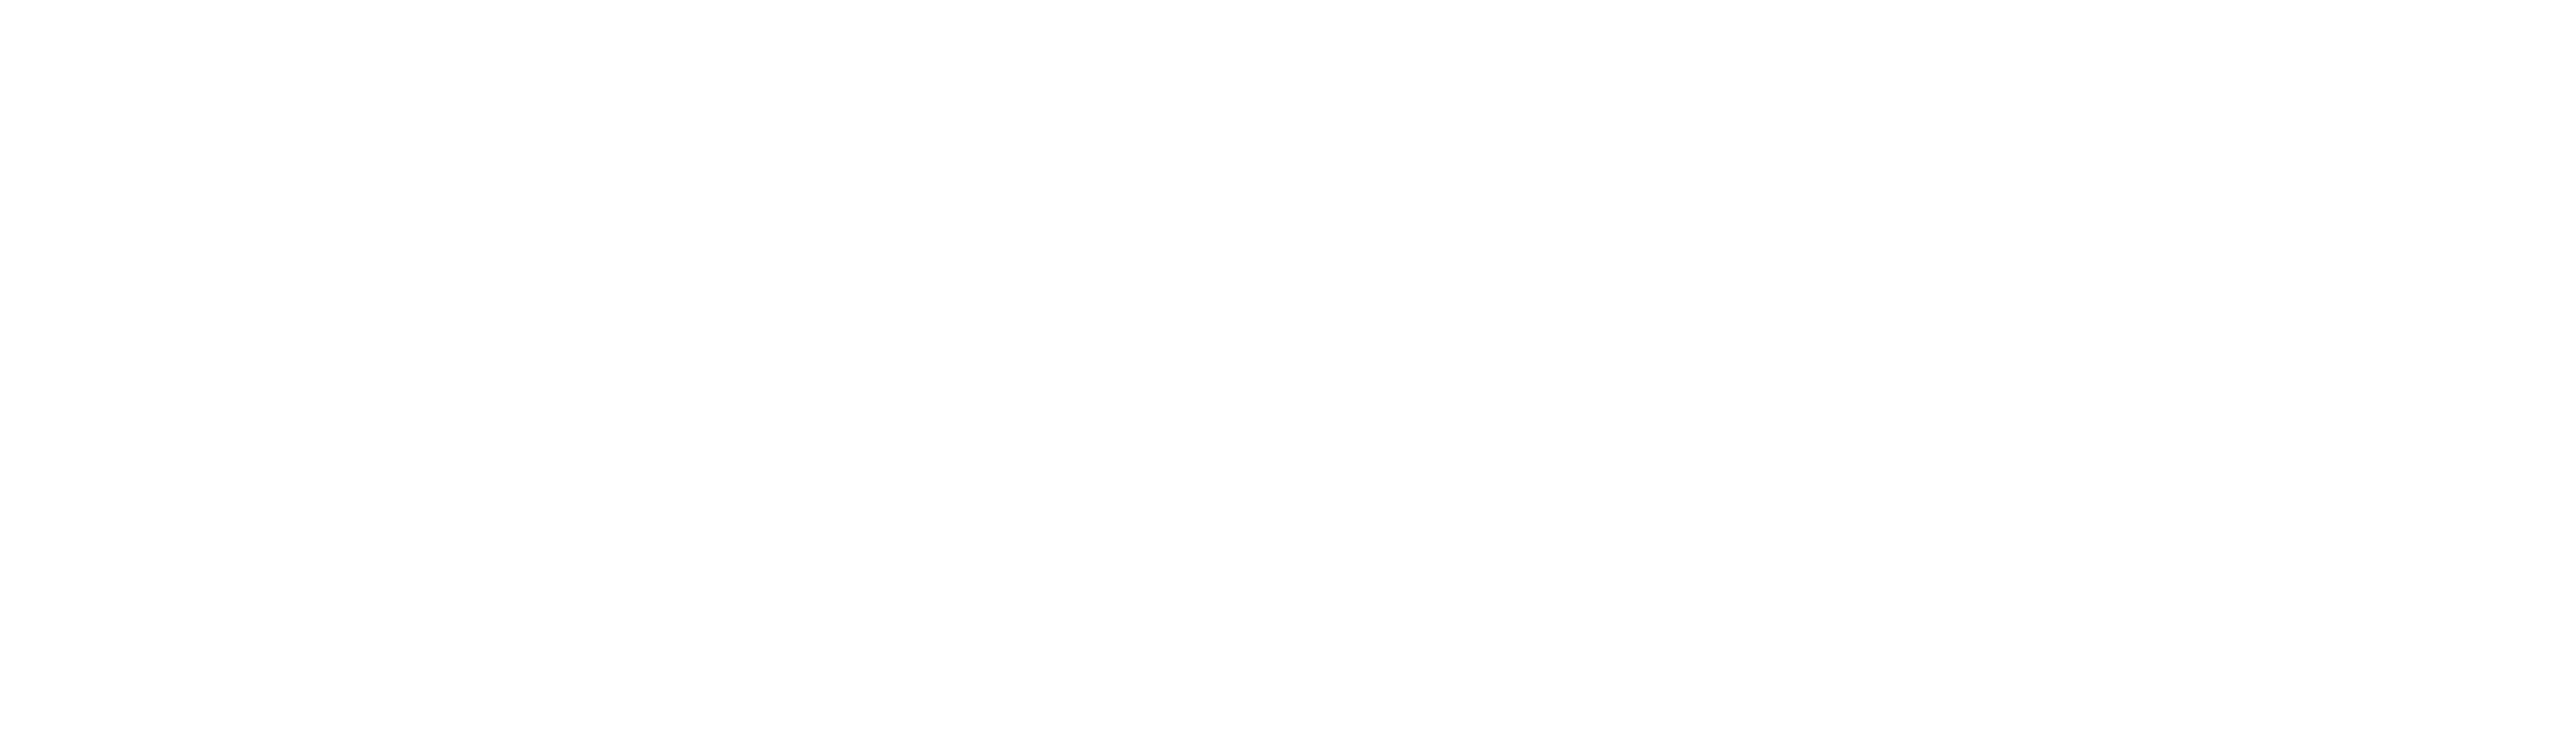

a370_SN_sourceplane/alfa_fits/Spectra_bin_78_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


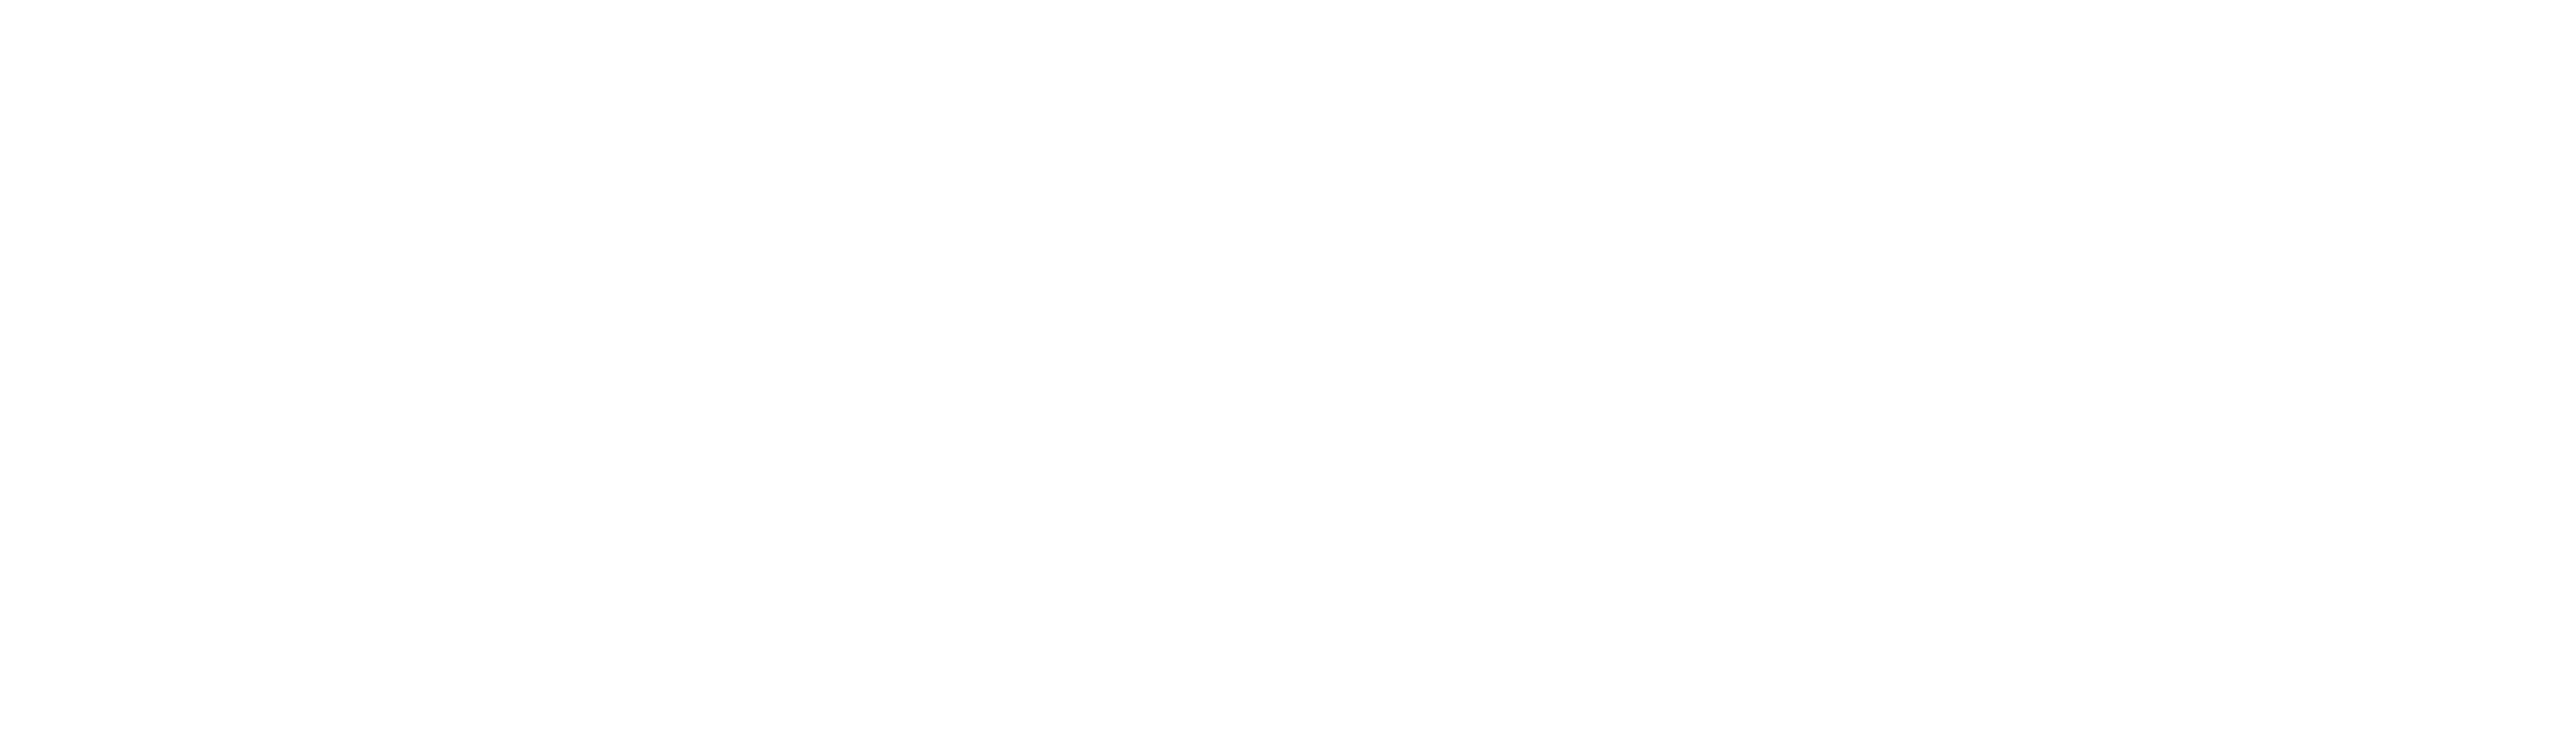

a370_SN_sourceplane/alfa_fits/Spectra_bin_79_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


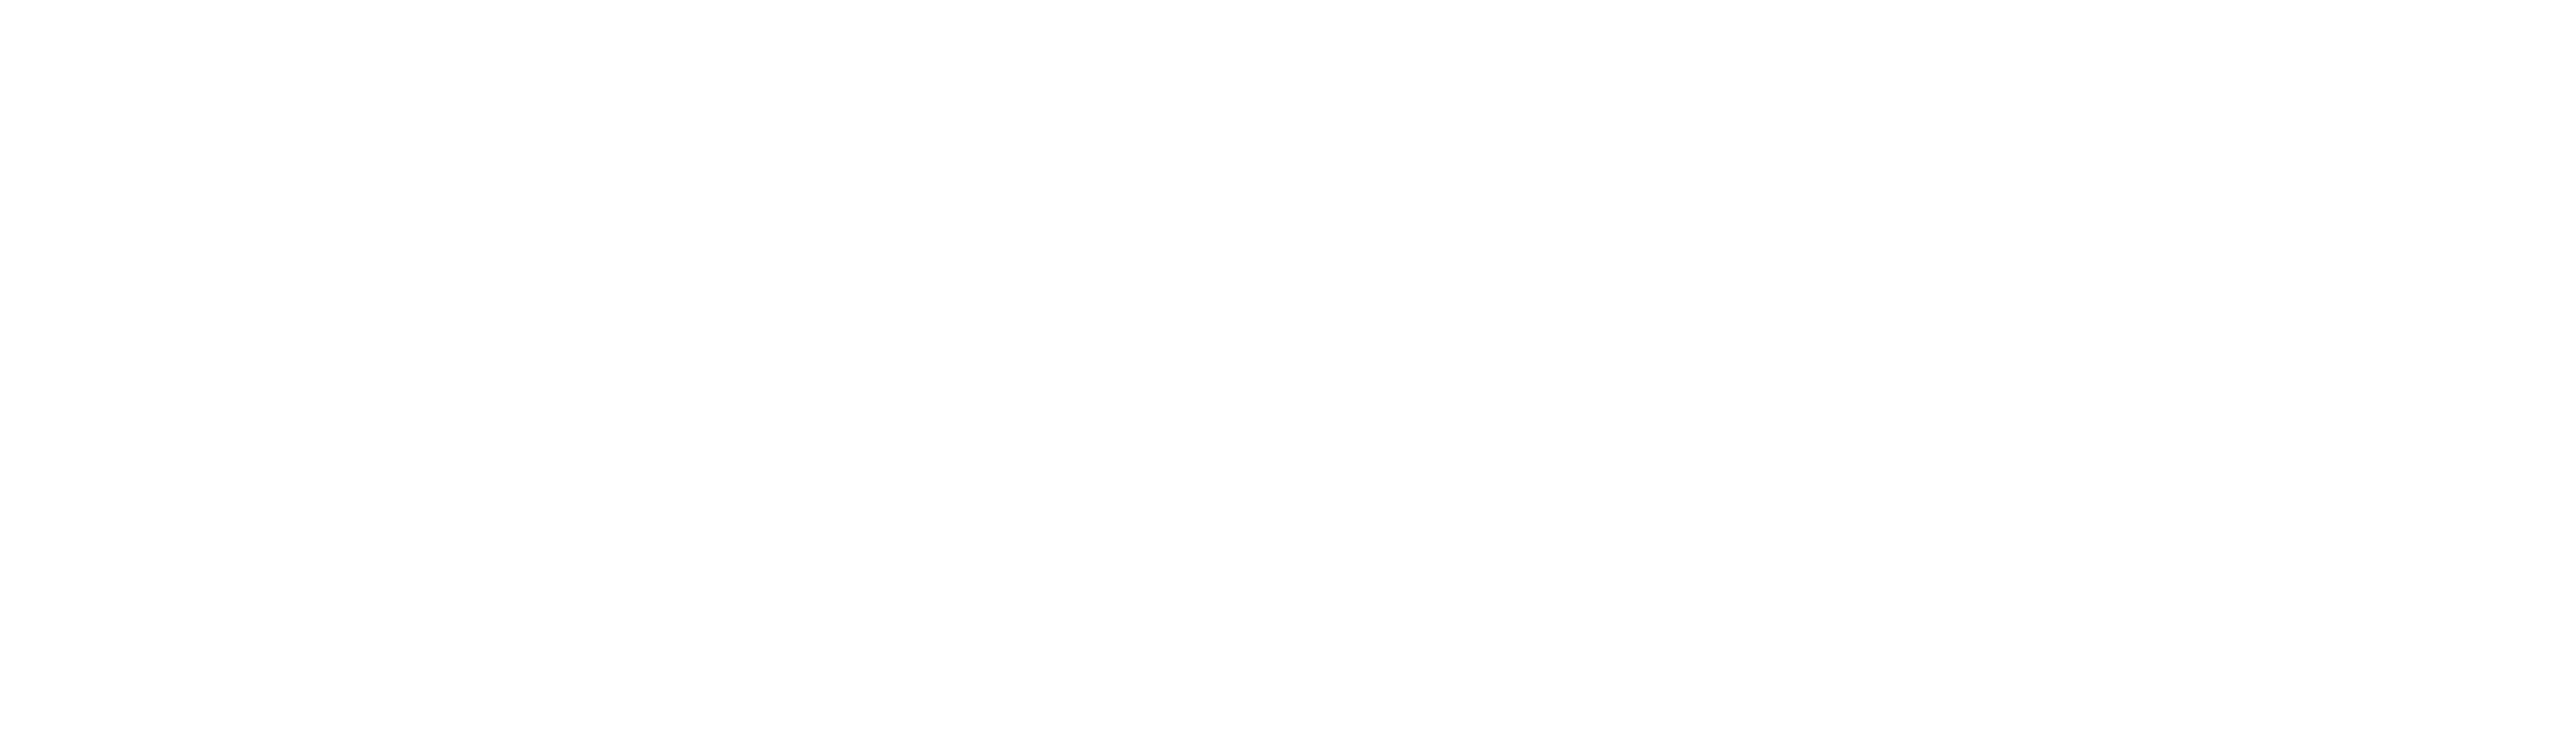

a370_SN_sourceplane/alfa_fits/Spectra_bin_7_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


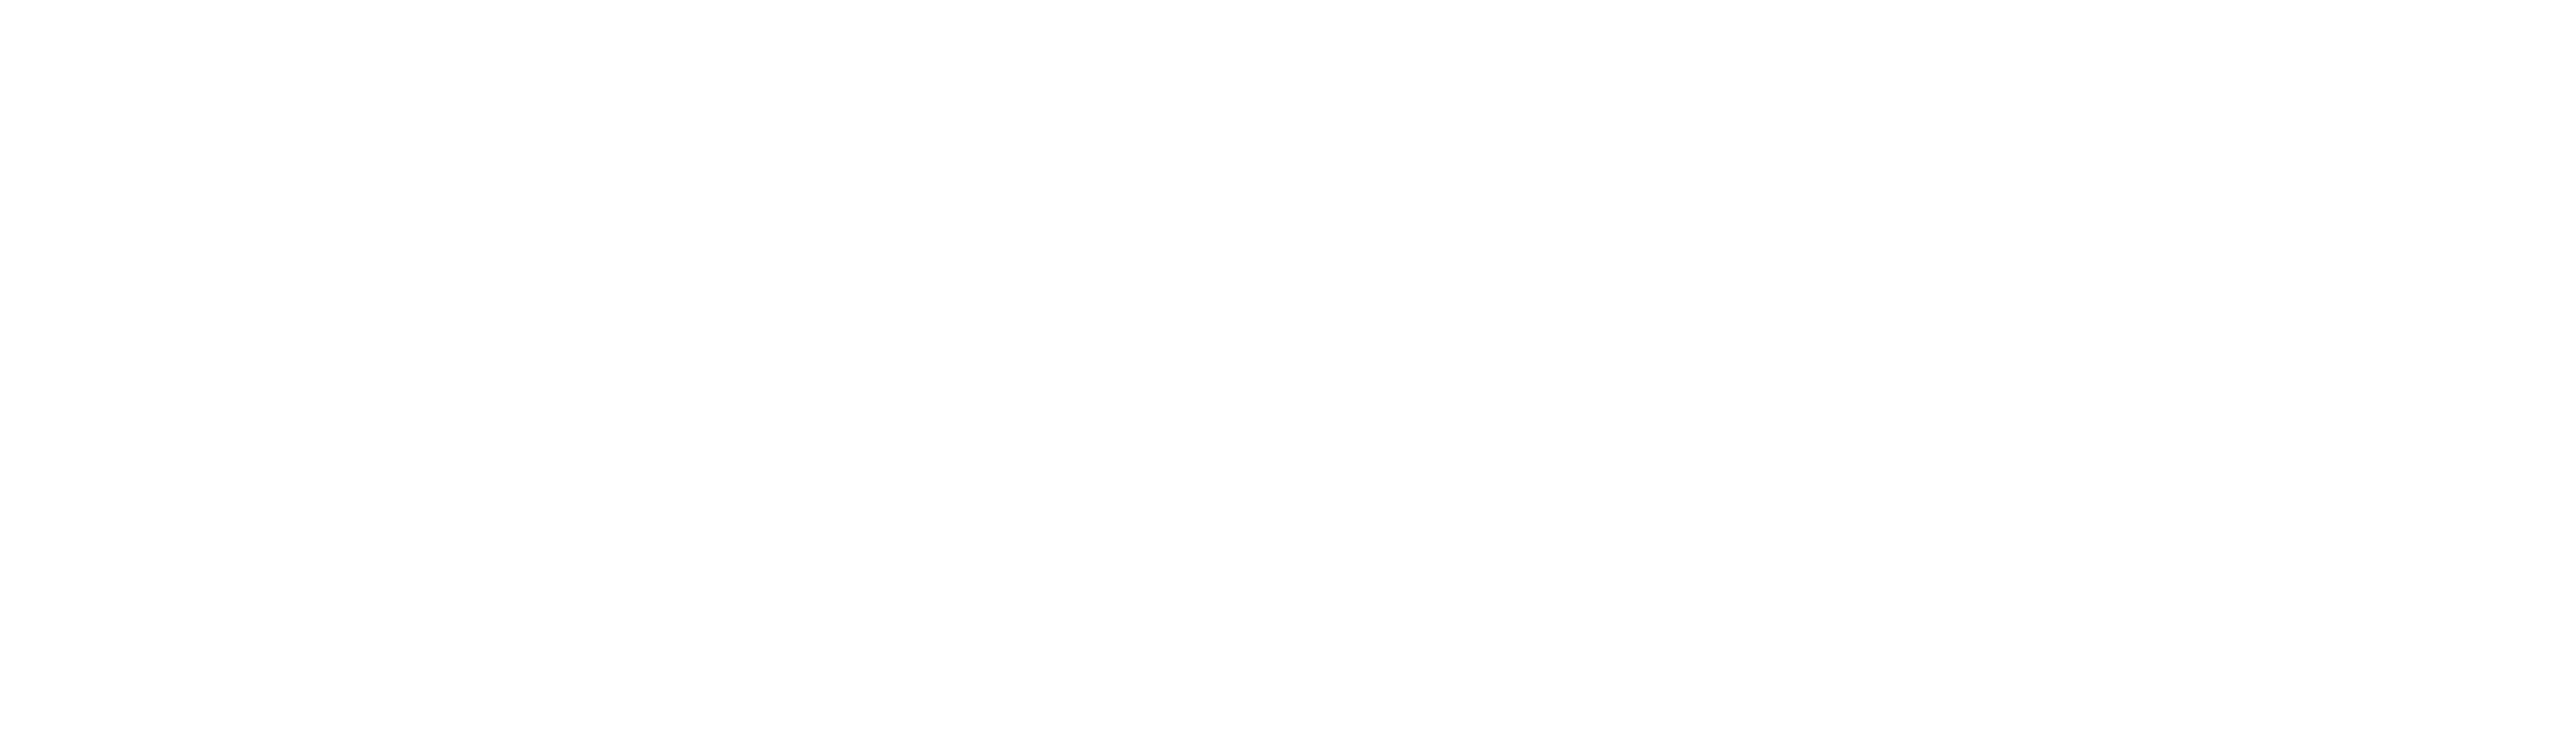

a370_SN_sourceplane/alfa_fits/Spectra_bin_80_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


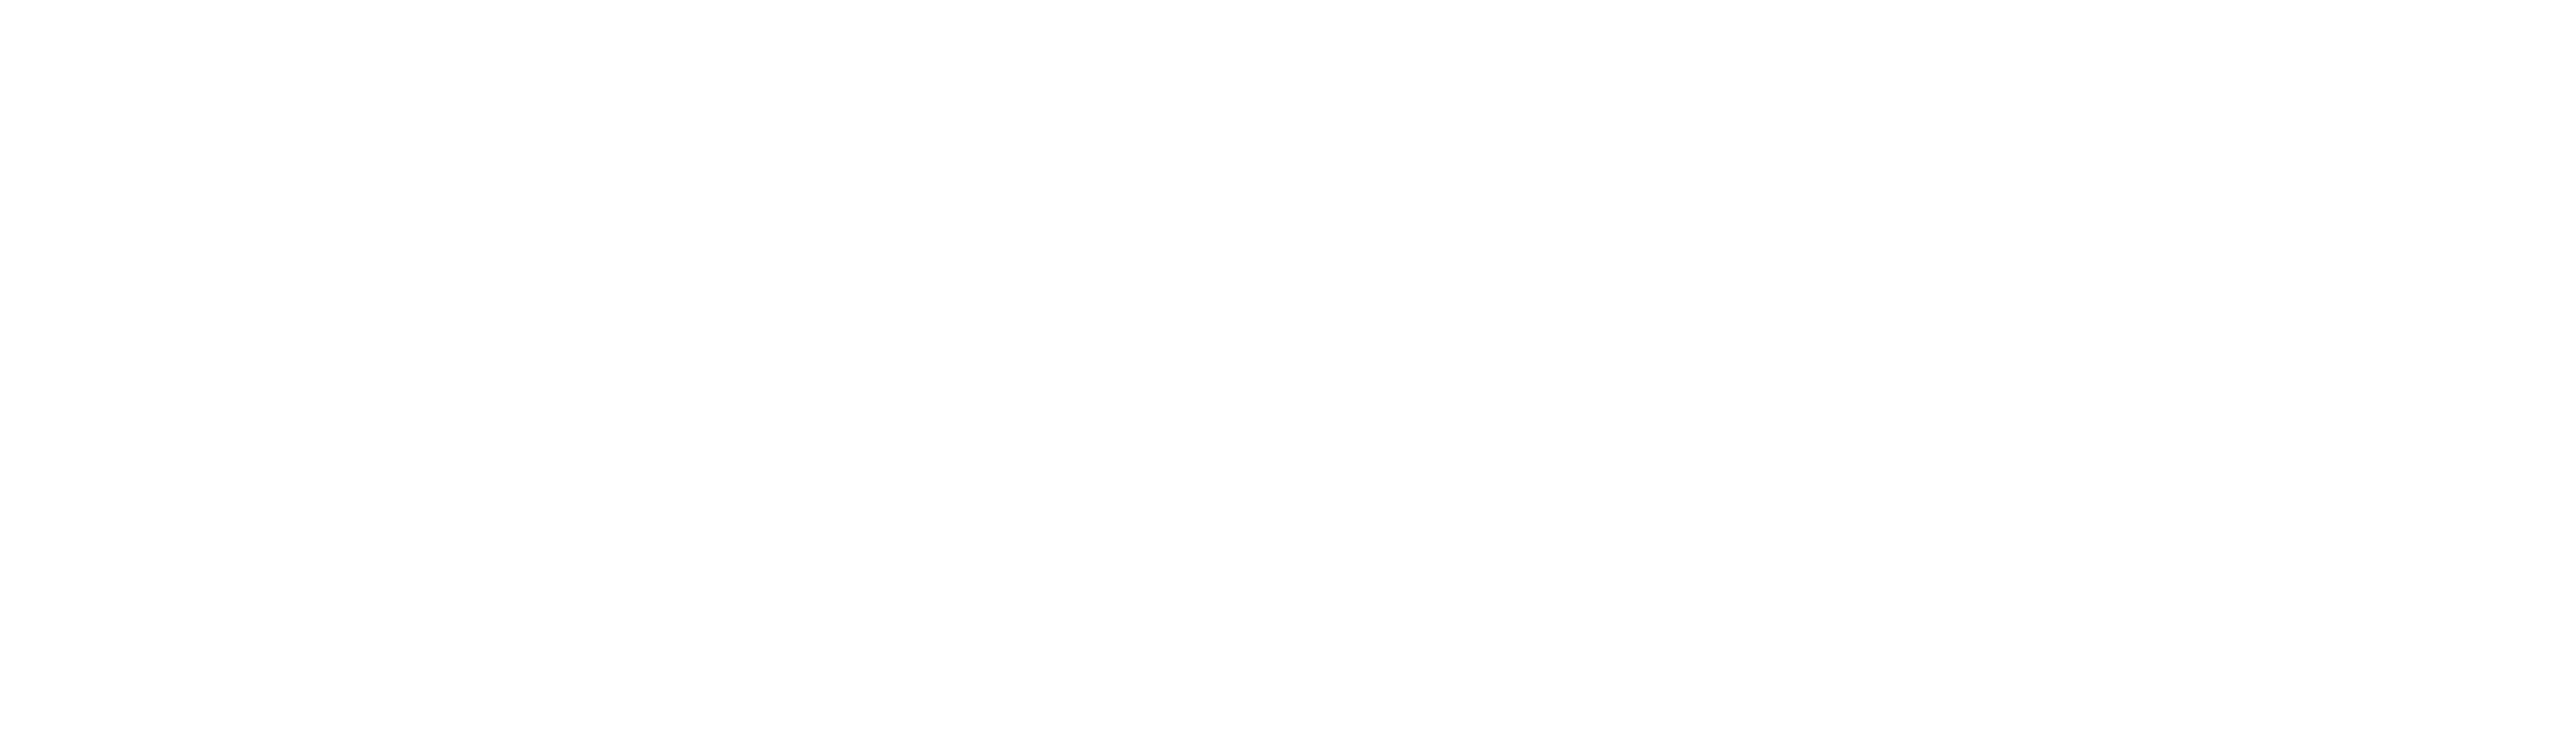

a370_SN_sourceplane/alfa_fits/Spectra_bin_81_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


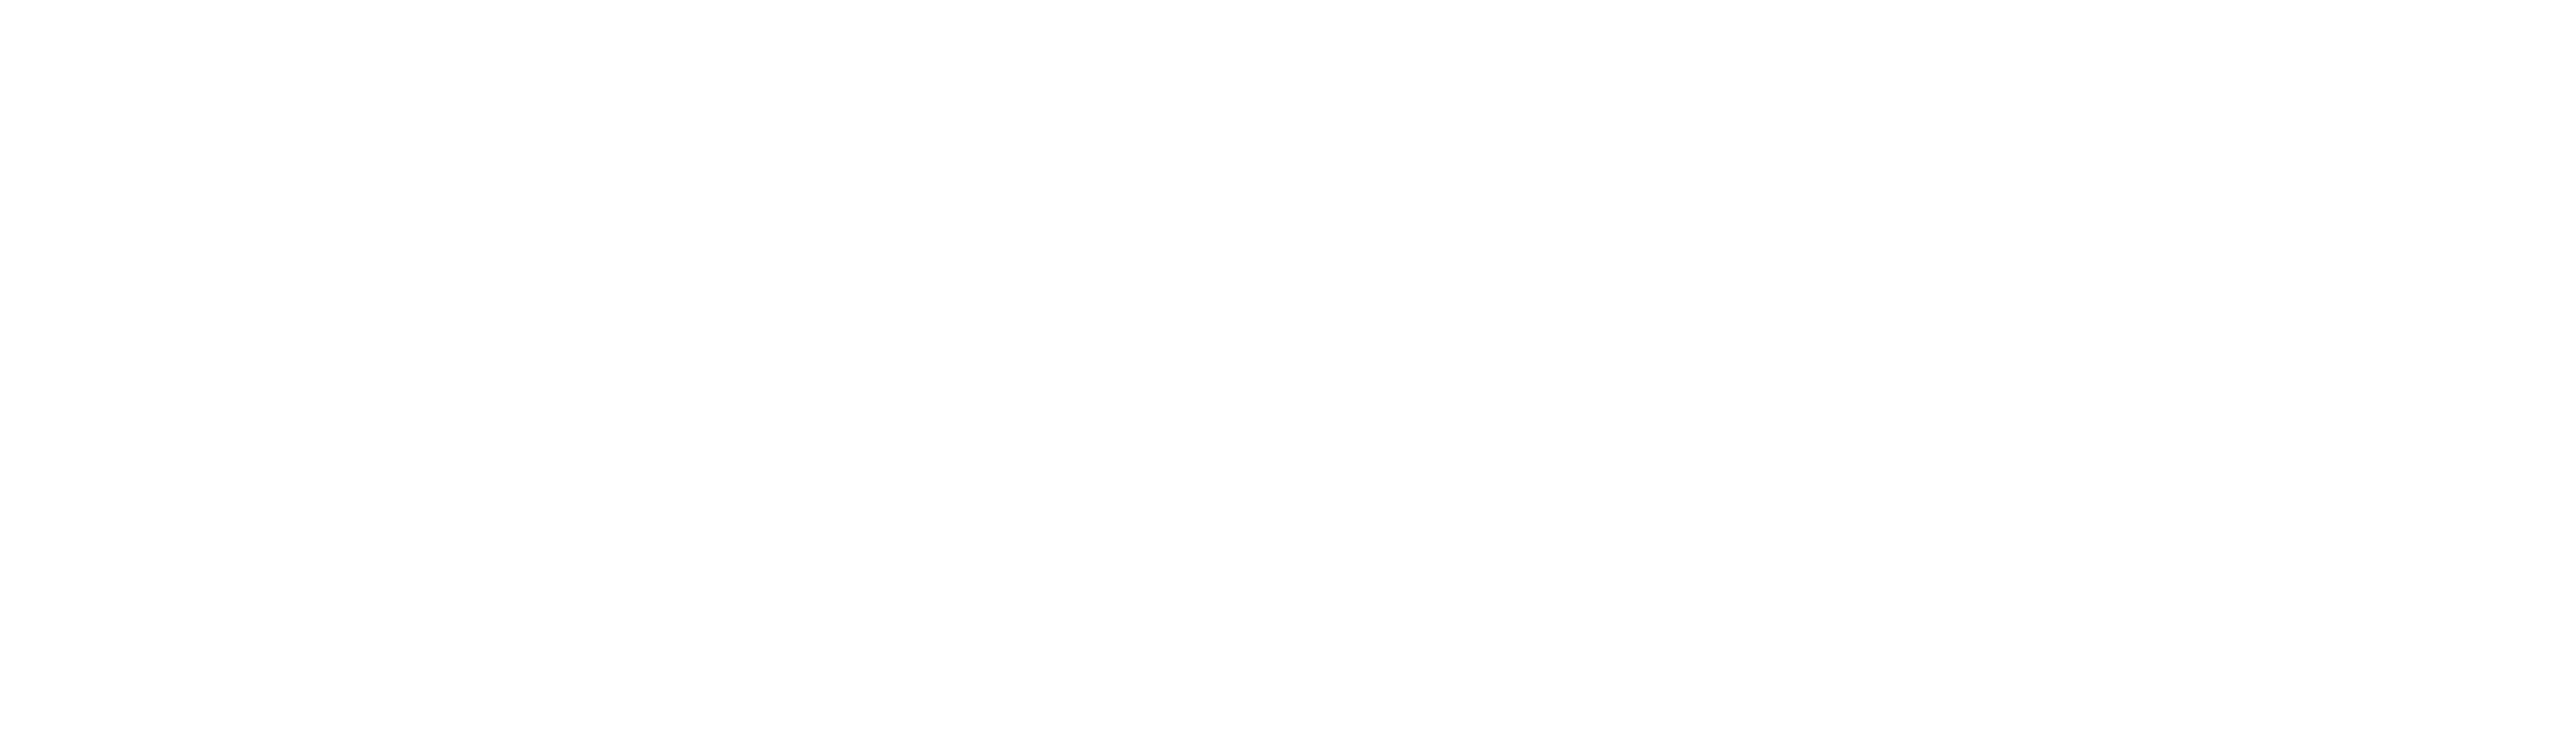

a370_SN_sourceplane/alfa_fits/Spectra_bin_82_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


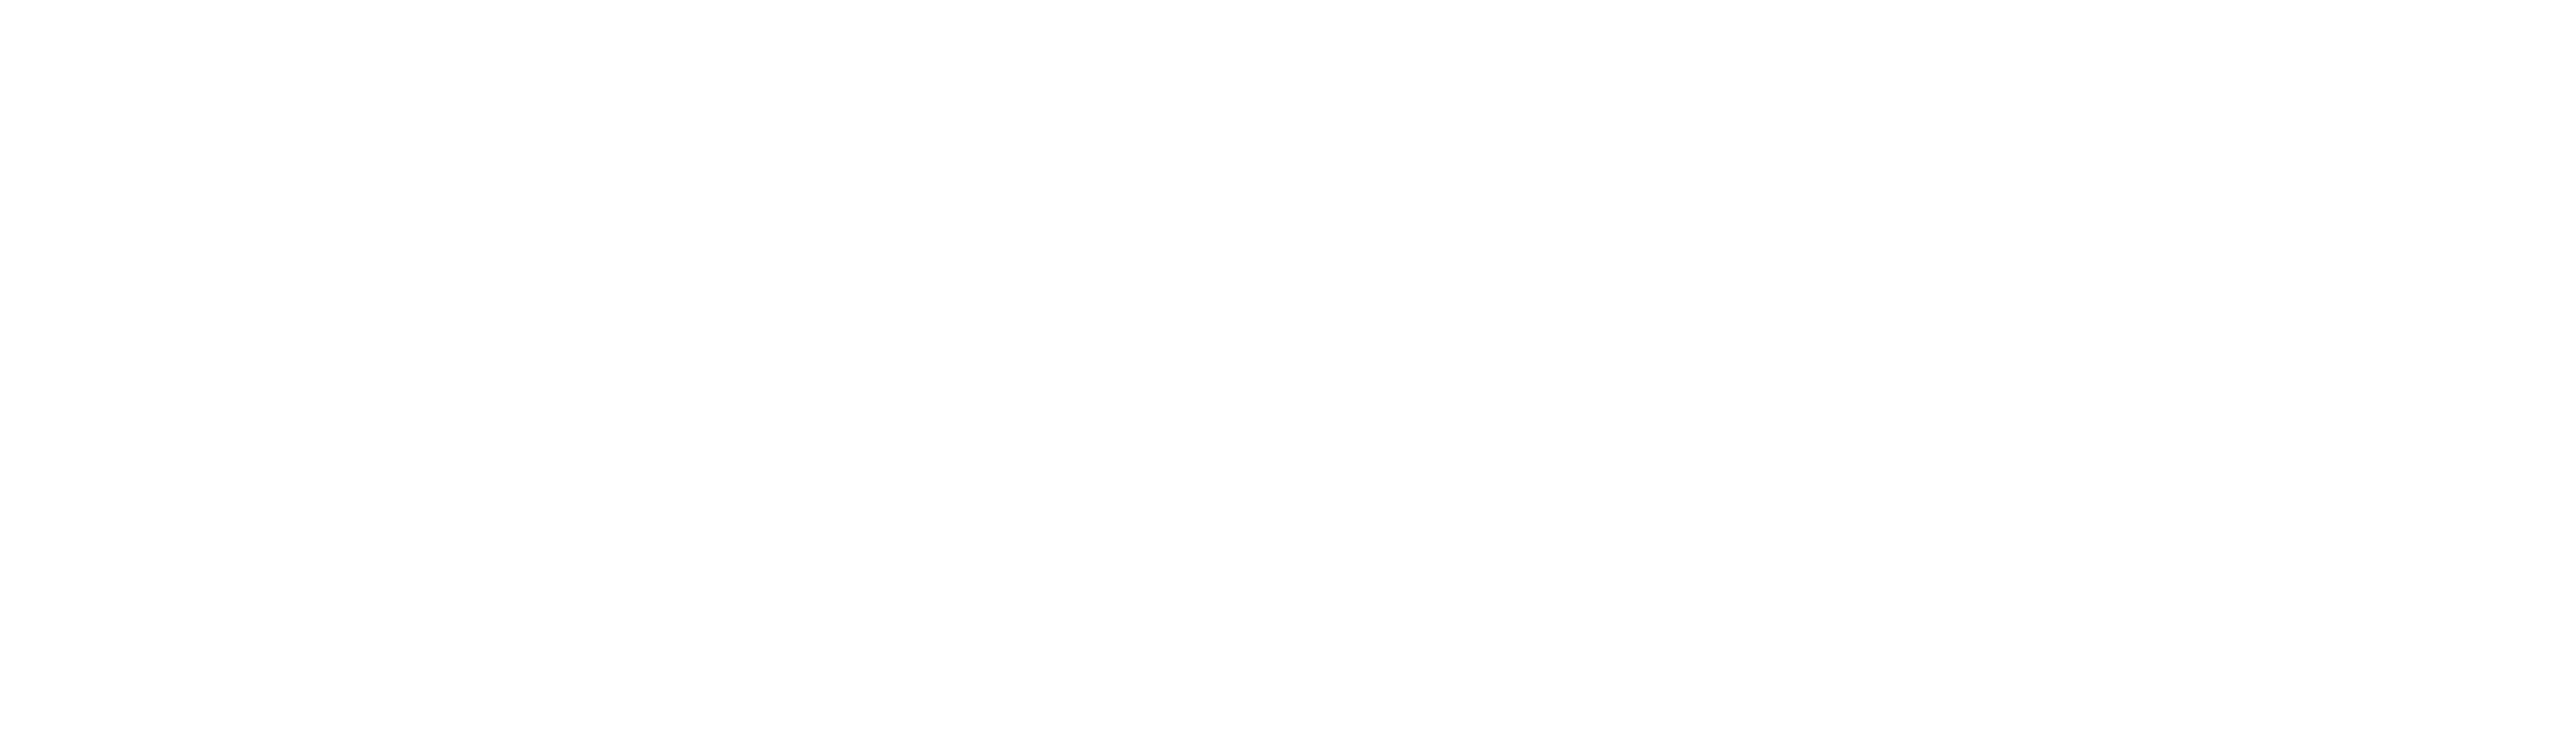

a370_SN_sourceplane/alfa_fits/Spectra_bin_83_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


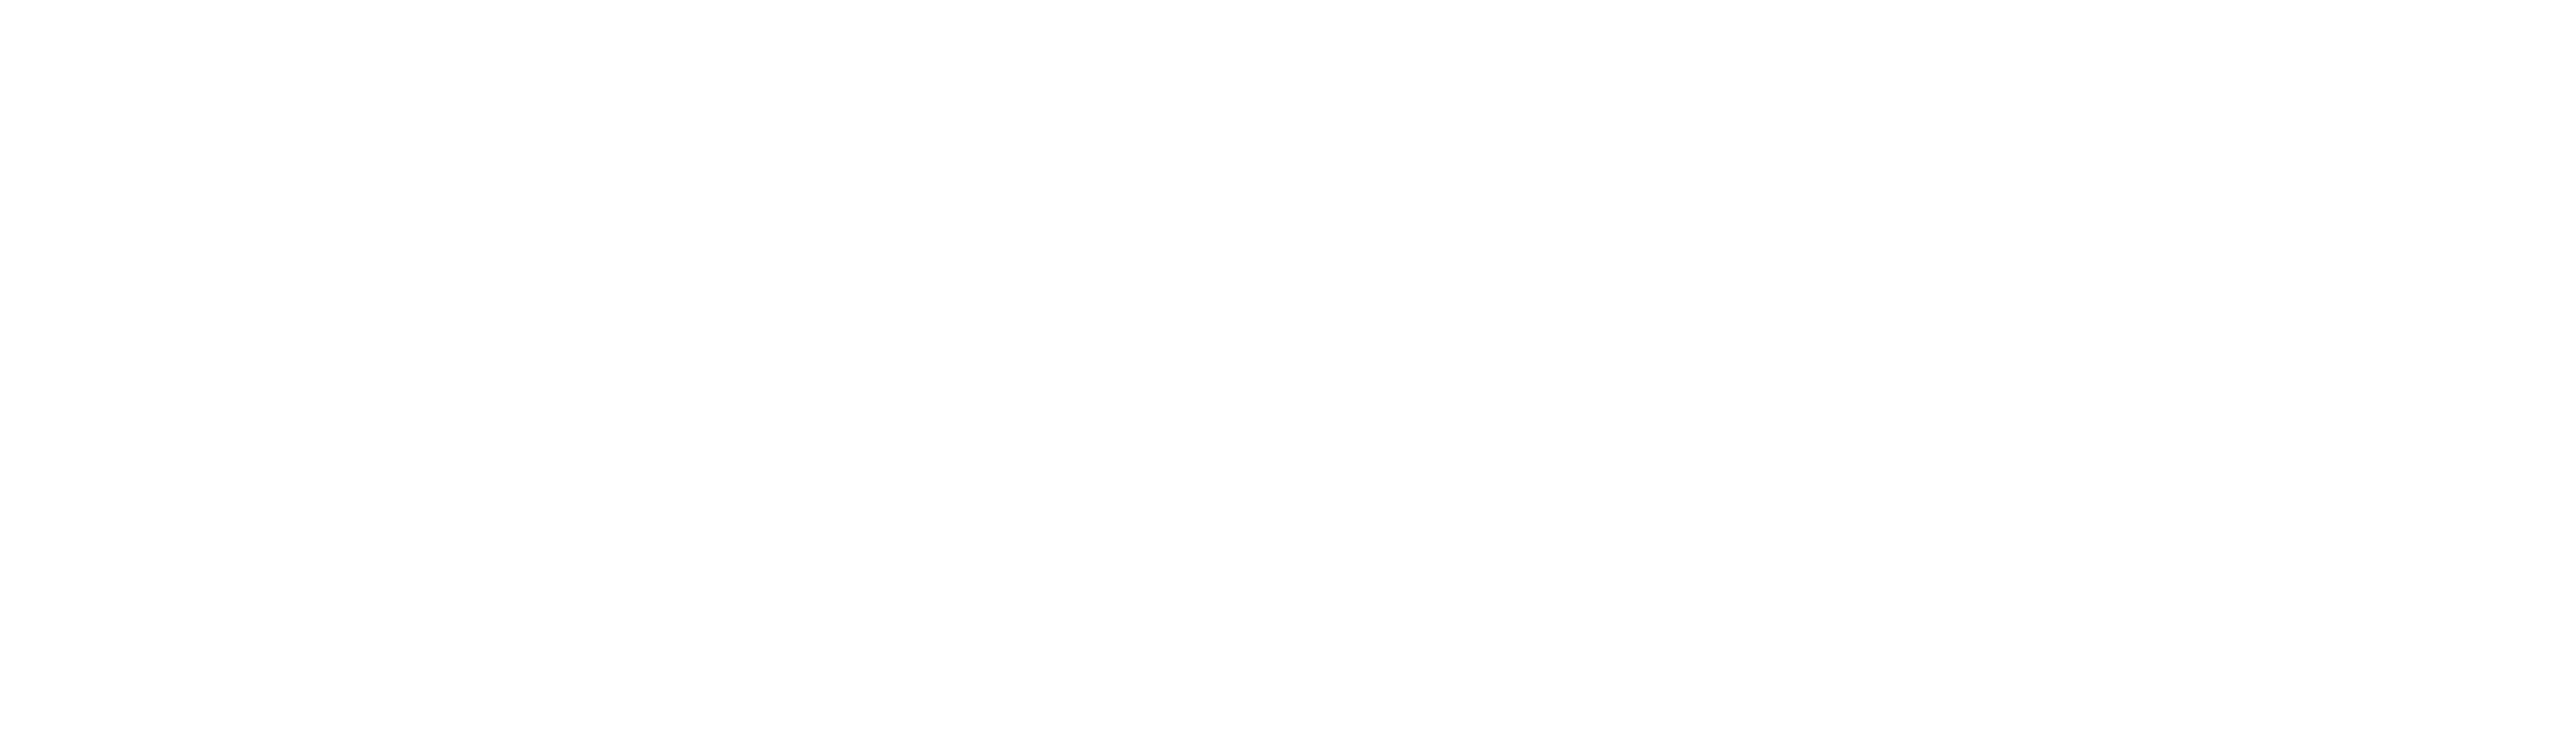

a370_SN_sourceplane/alfa_fits/Spectra_bin_84_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


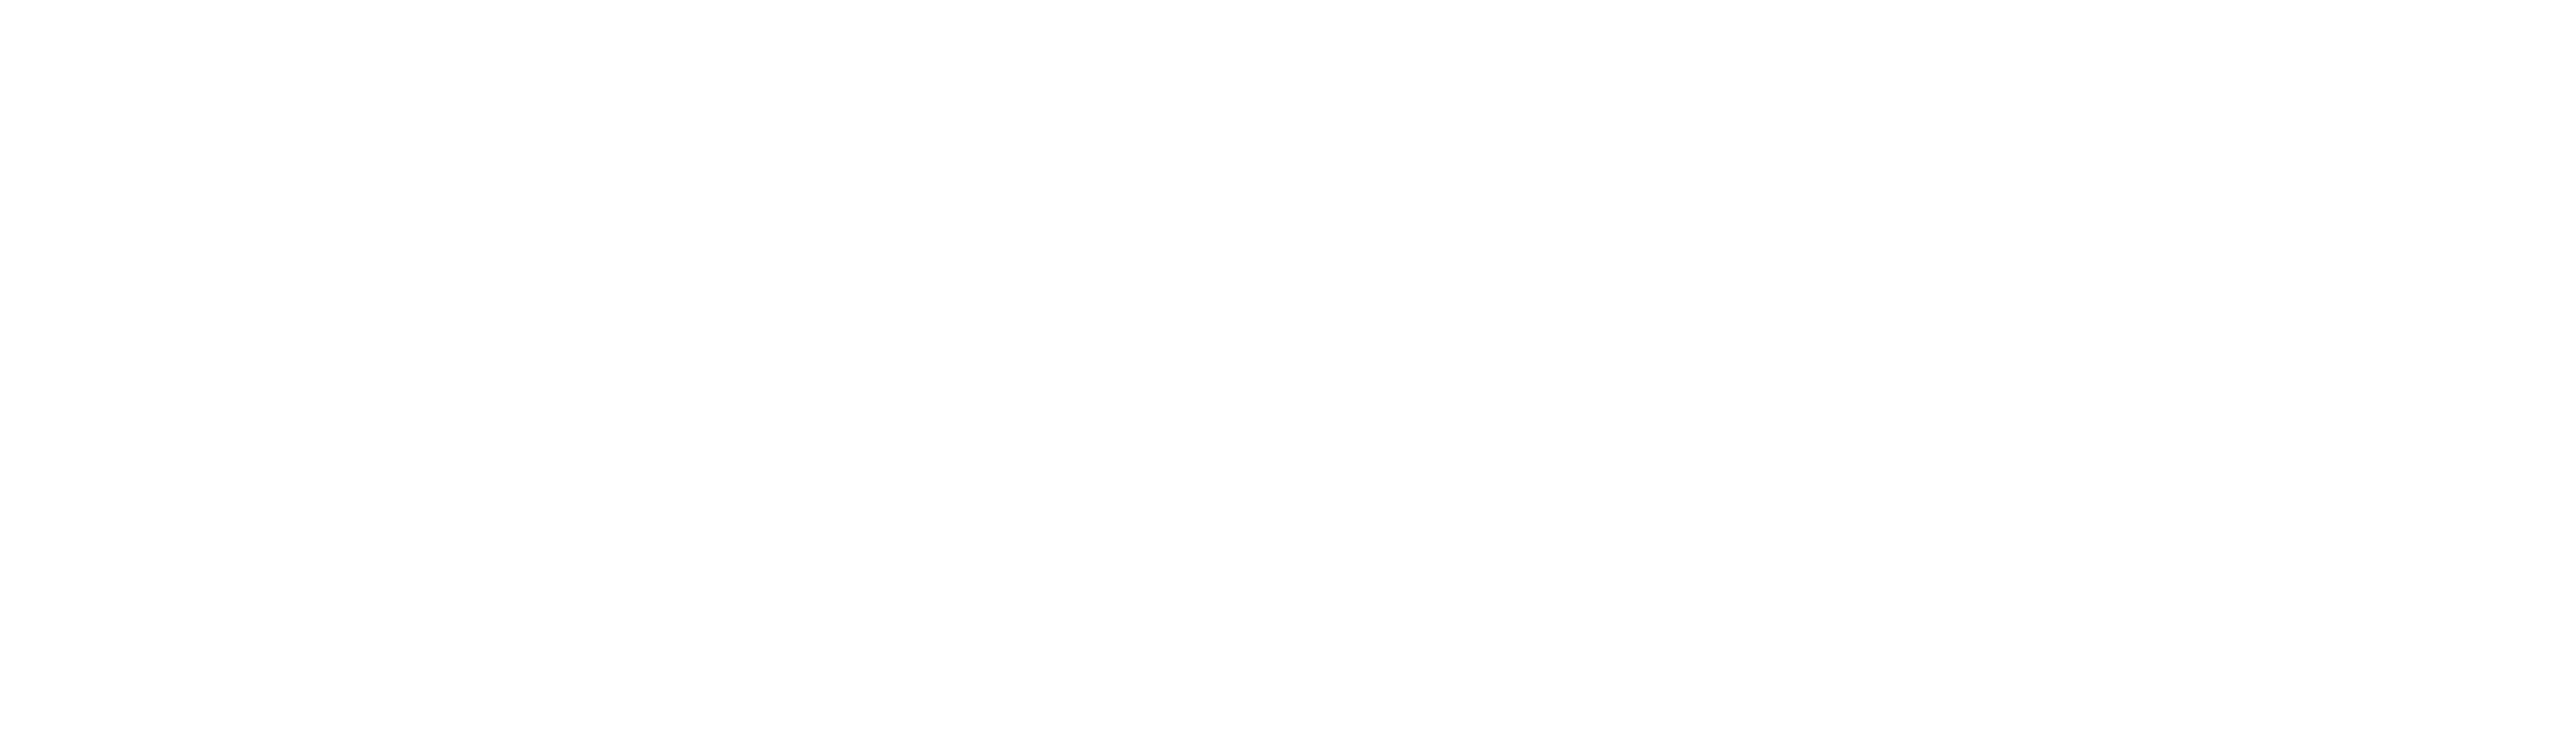

a370_SN_sourceplane/alfa_fits/Spectra_bin_85_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


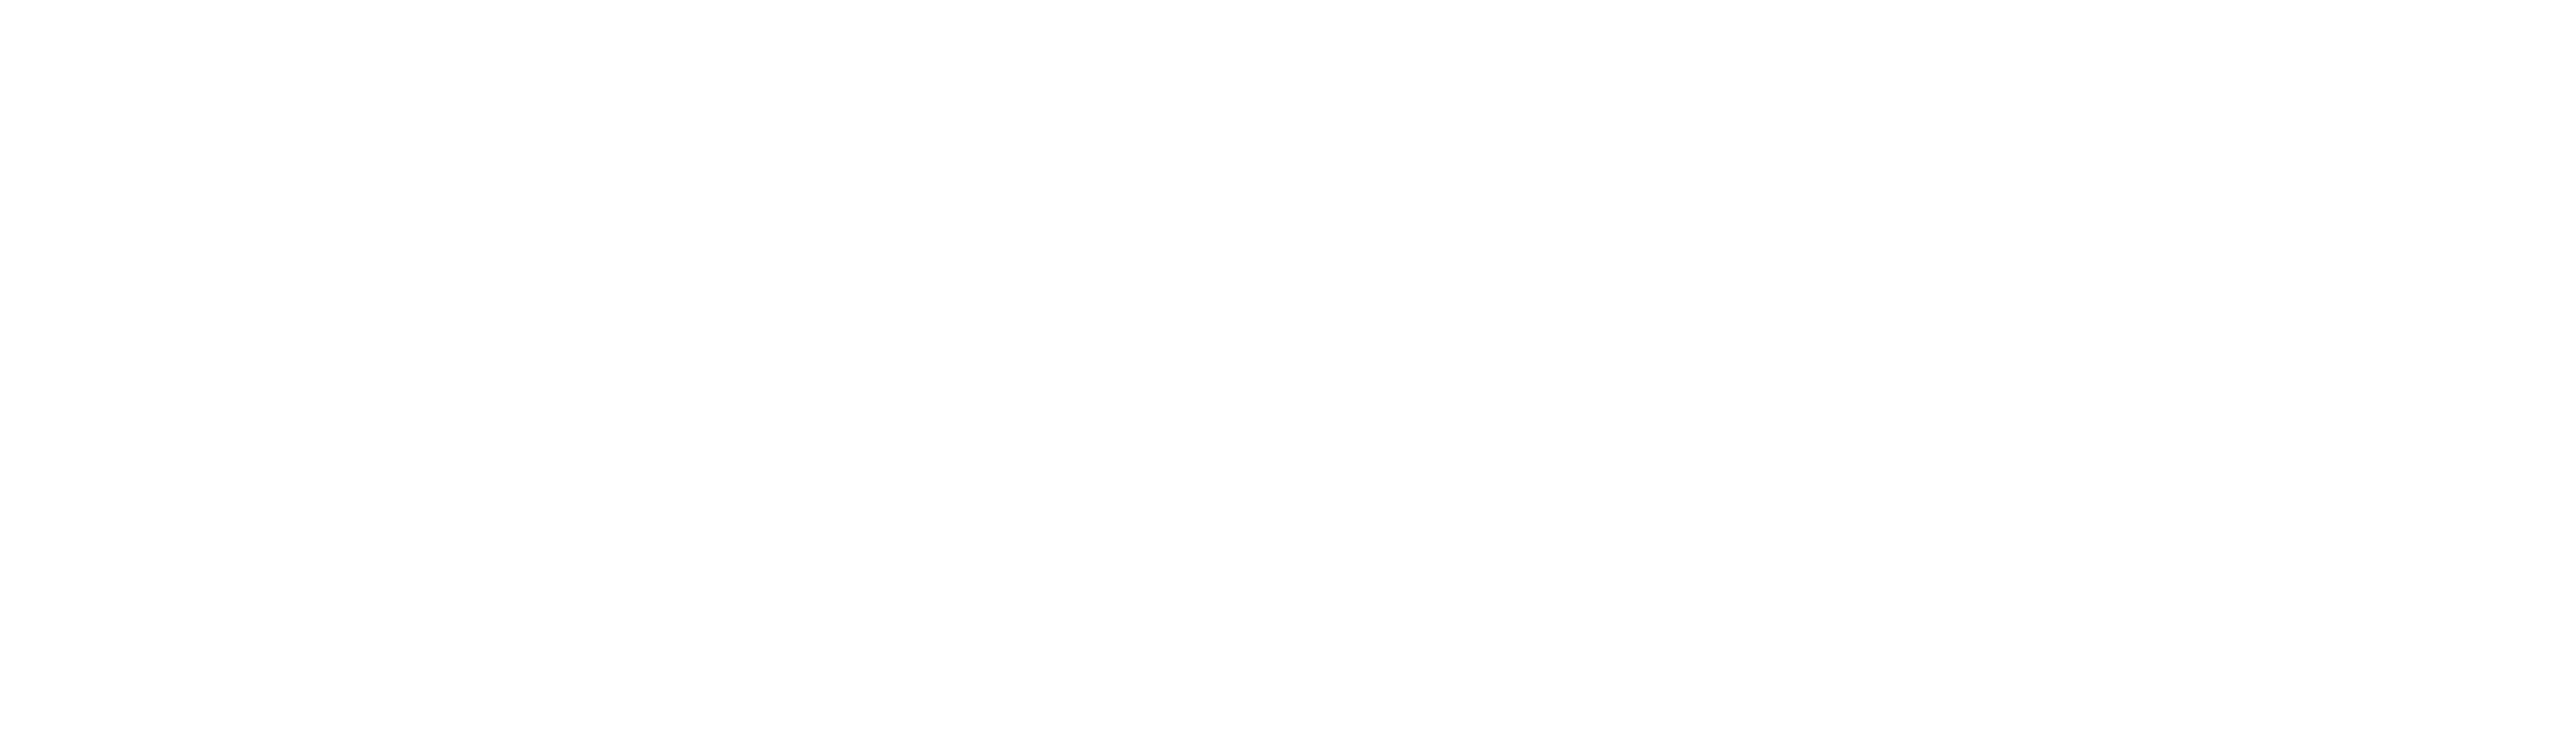

a370_SN_sourceplane/alfa_fits/Spectra_bin_86_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


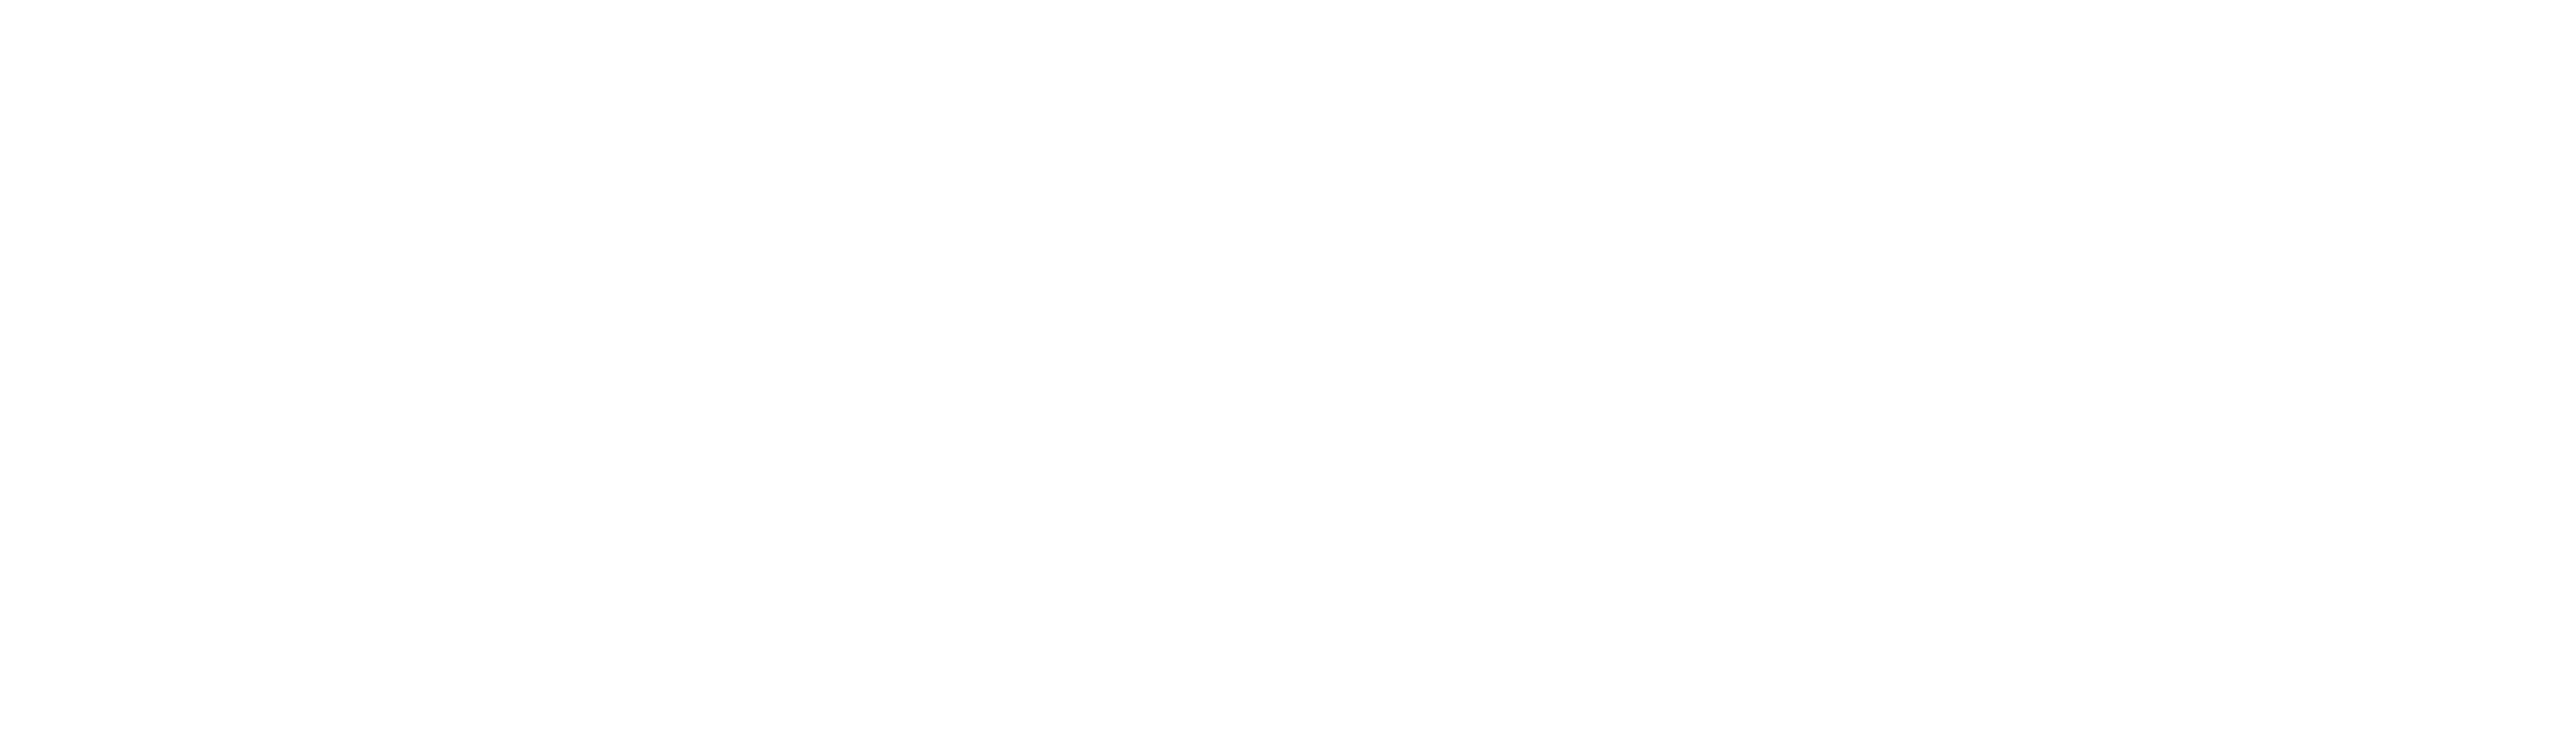

a370_SN_sourceplane/alfa_fits/Spectra_bin_87_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


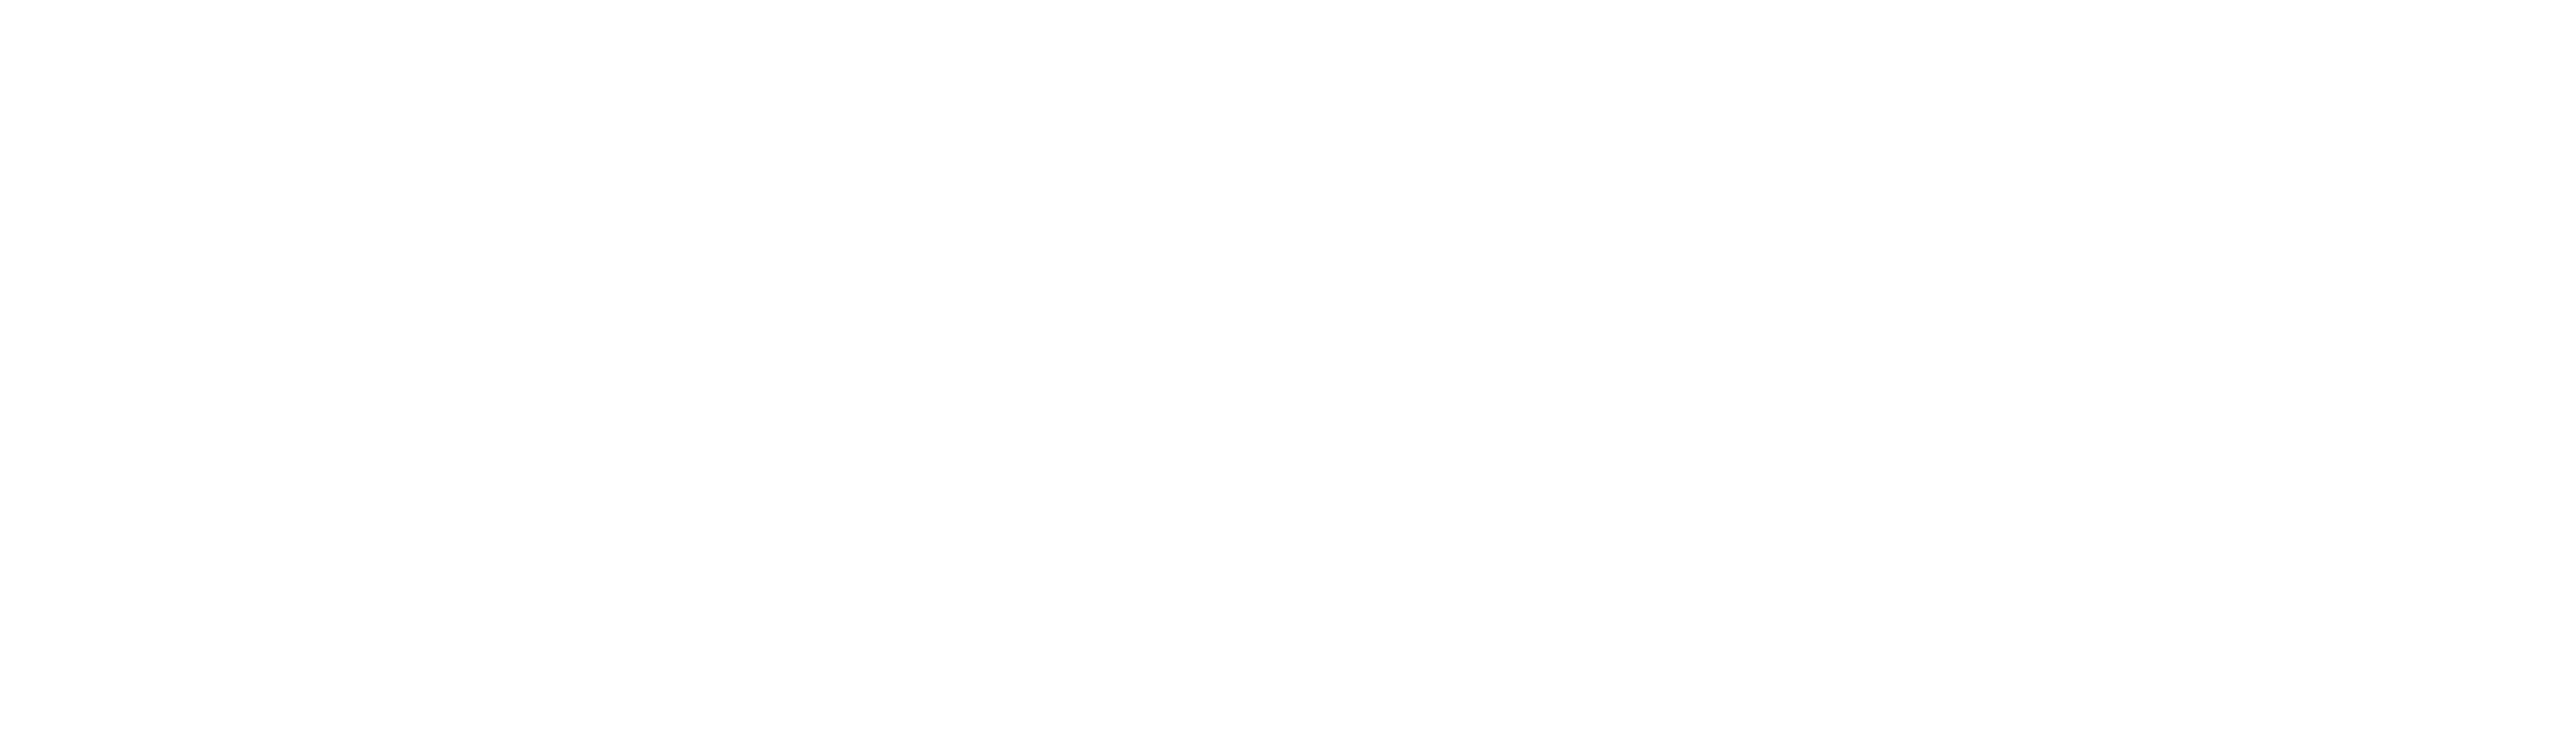

a370_SN_sourceplane/alfa_fits/Spectra_bin_88_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


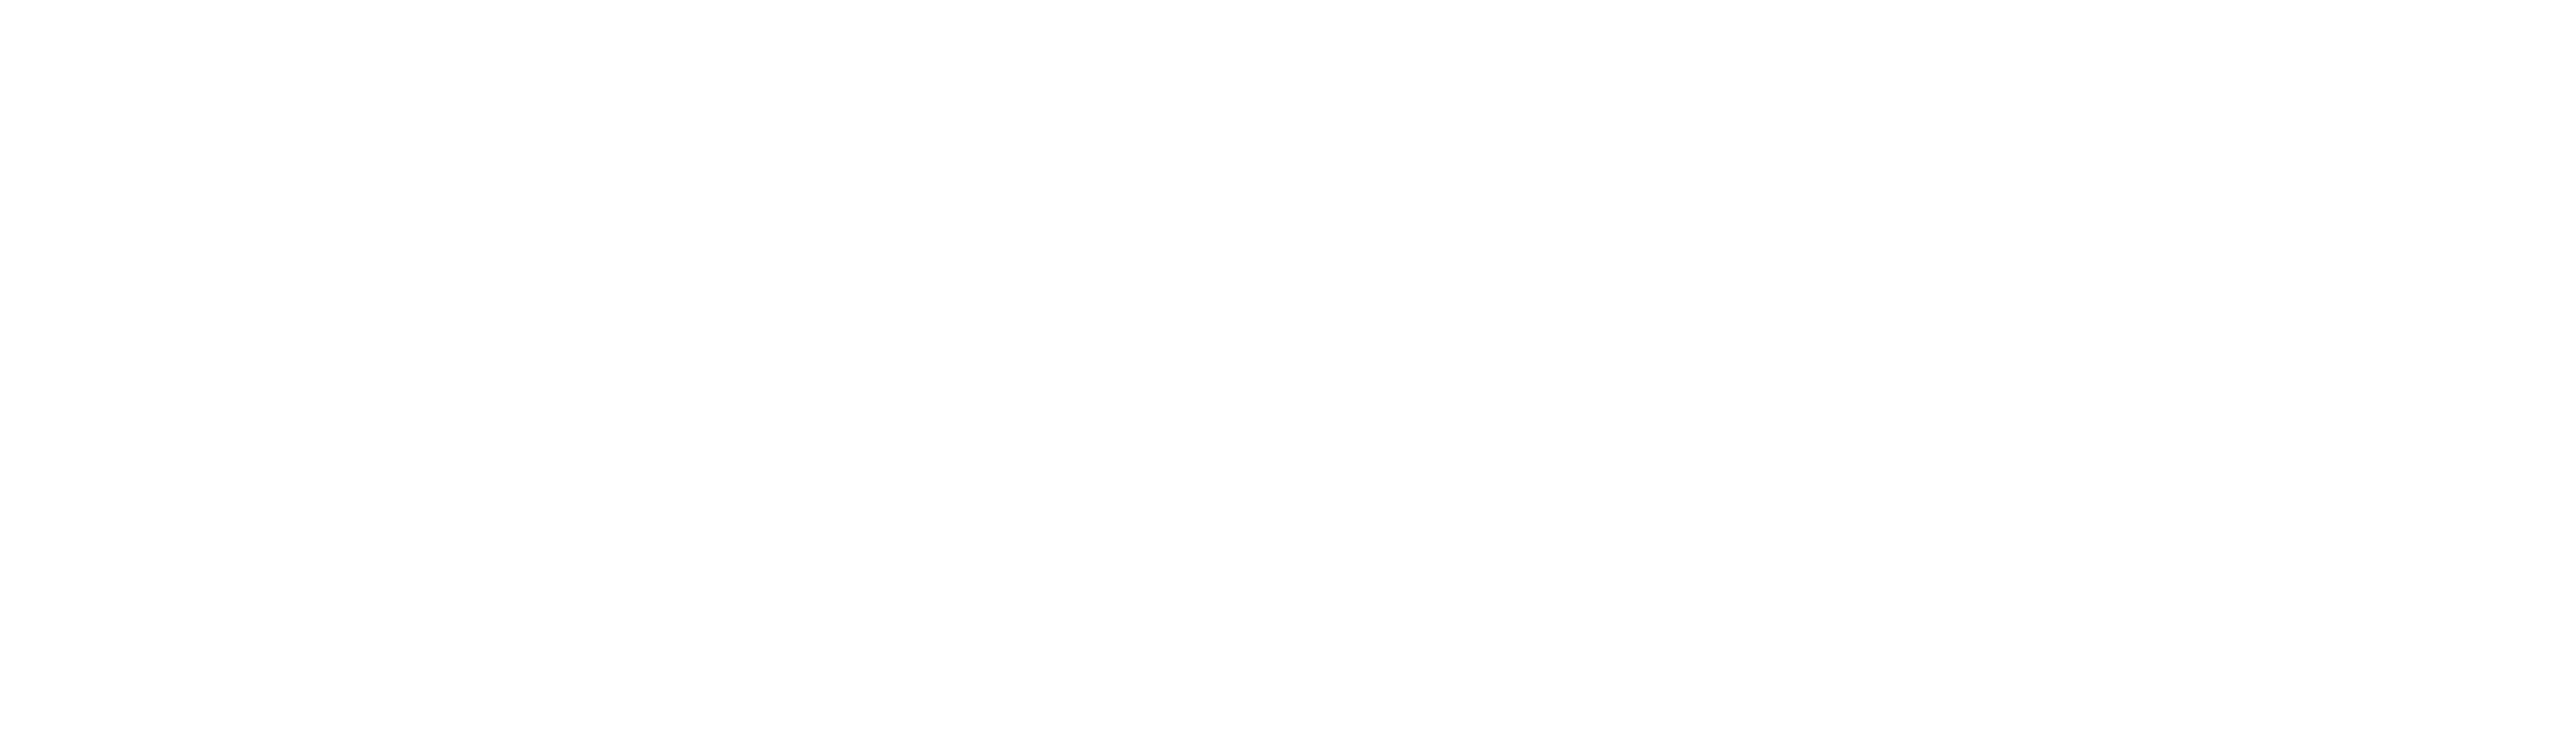

a370_SN_sourceplane/alfa_fits/Spectra_bin_89_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


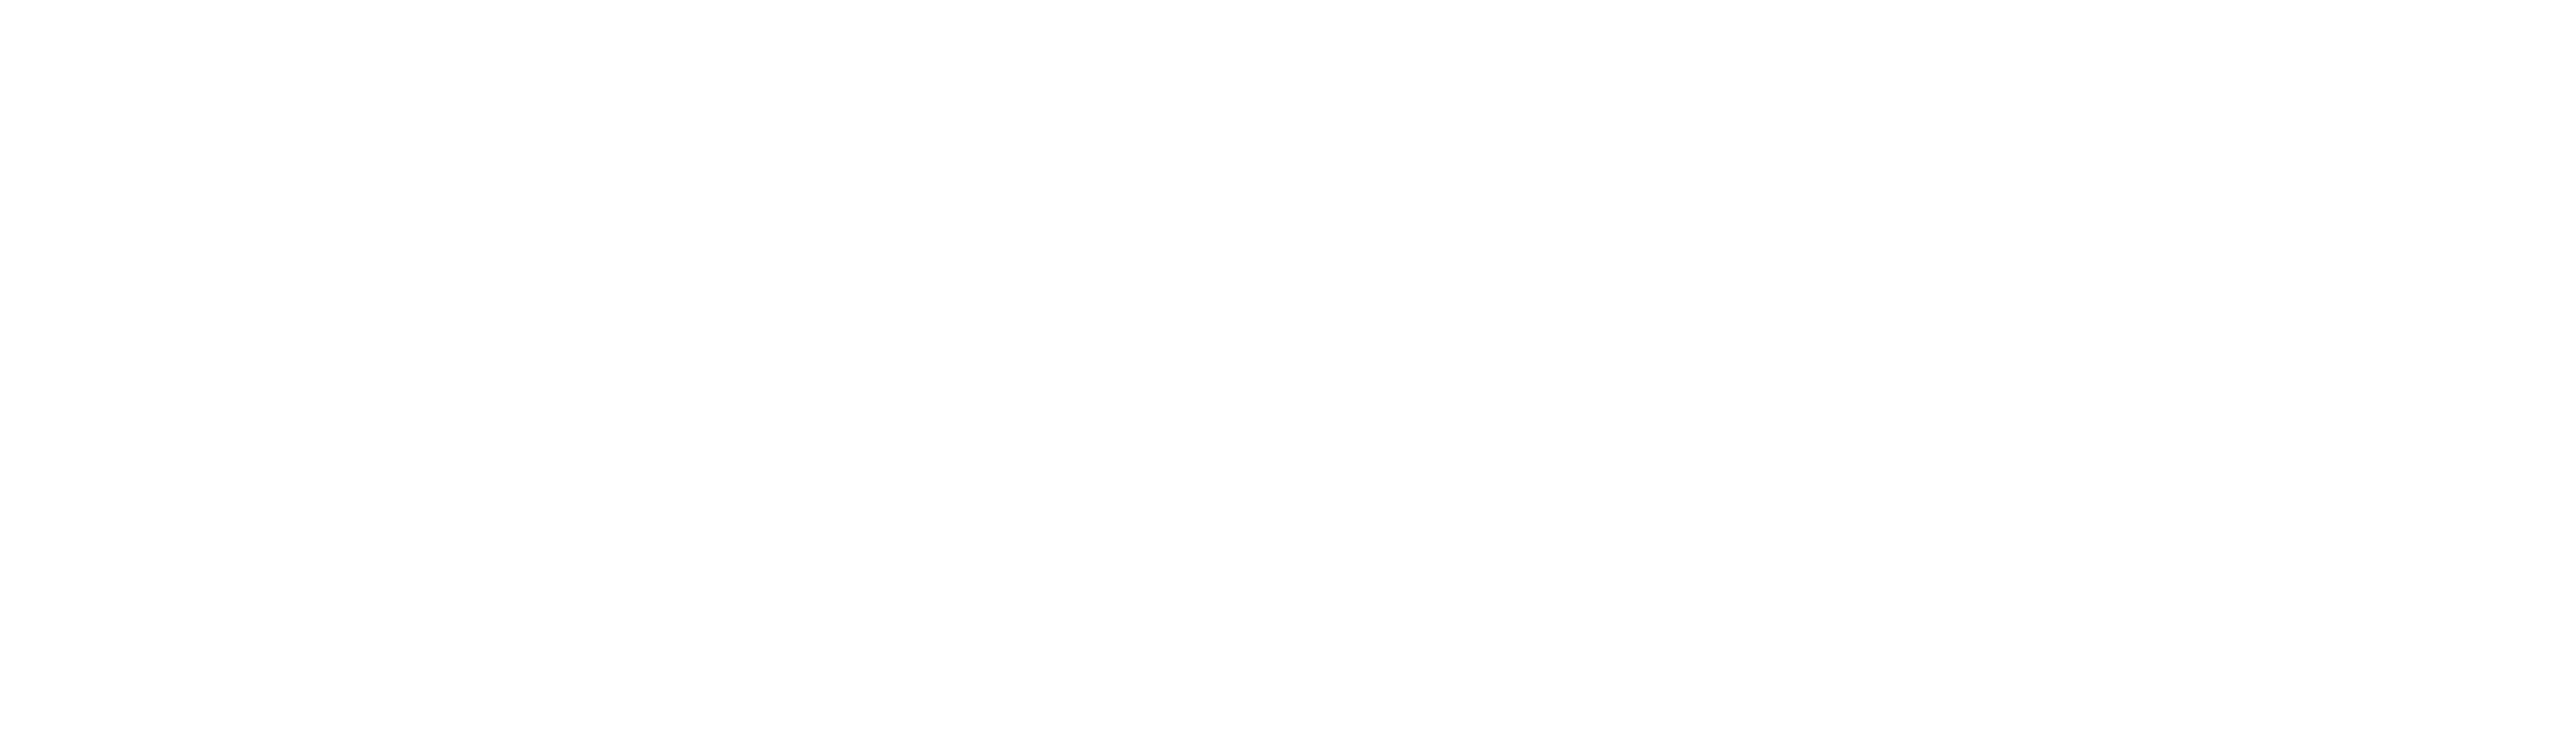

a370_SN_sourceplane/alfa_fits/Spectra_bin_8_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


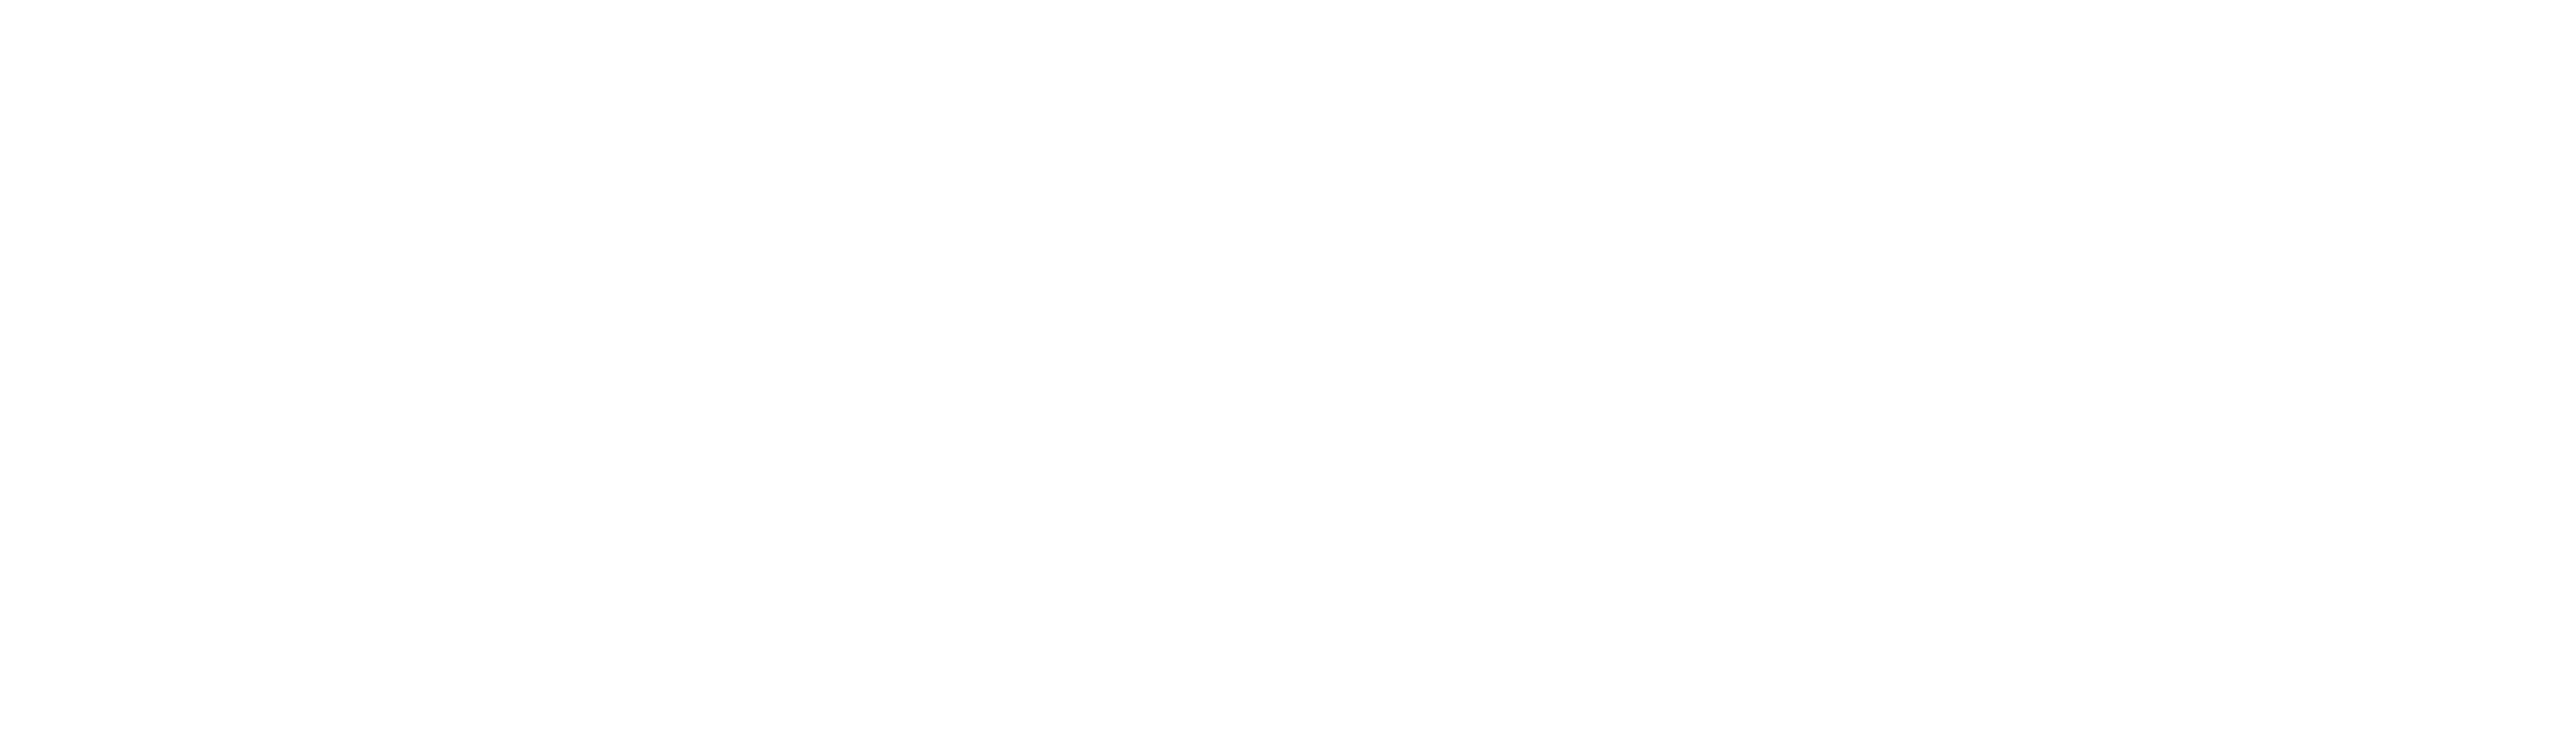

a370_SN_sourceplane/alfa_fits/Spectra_bin_90_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


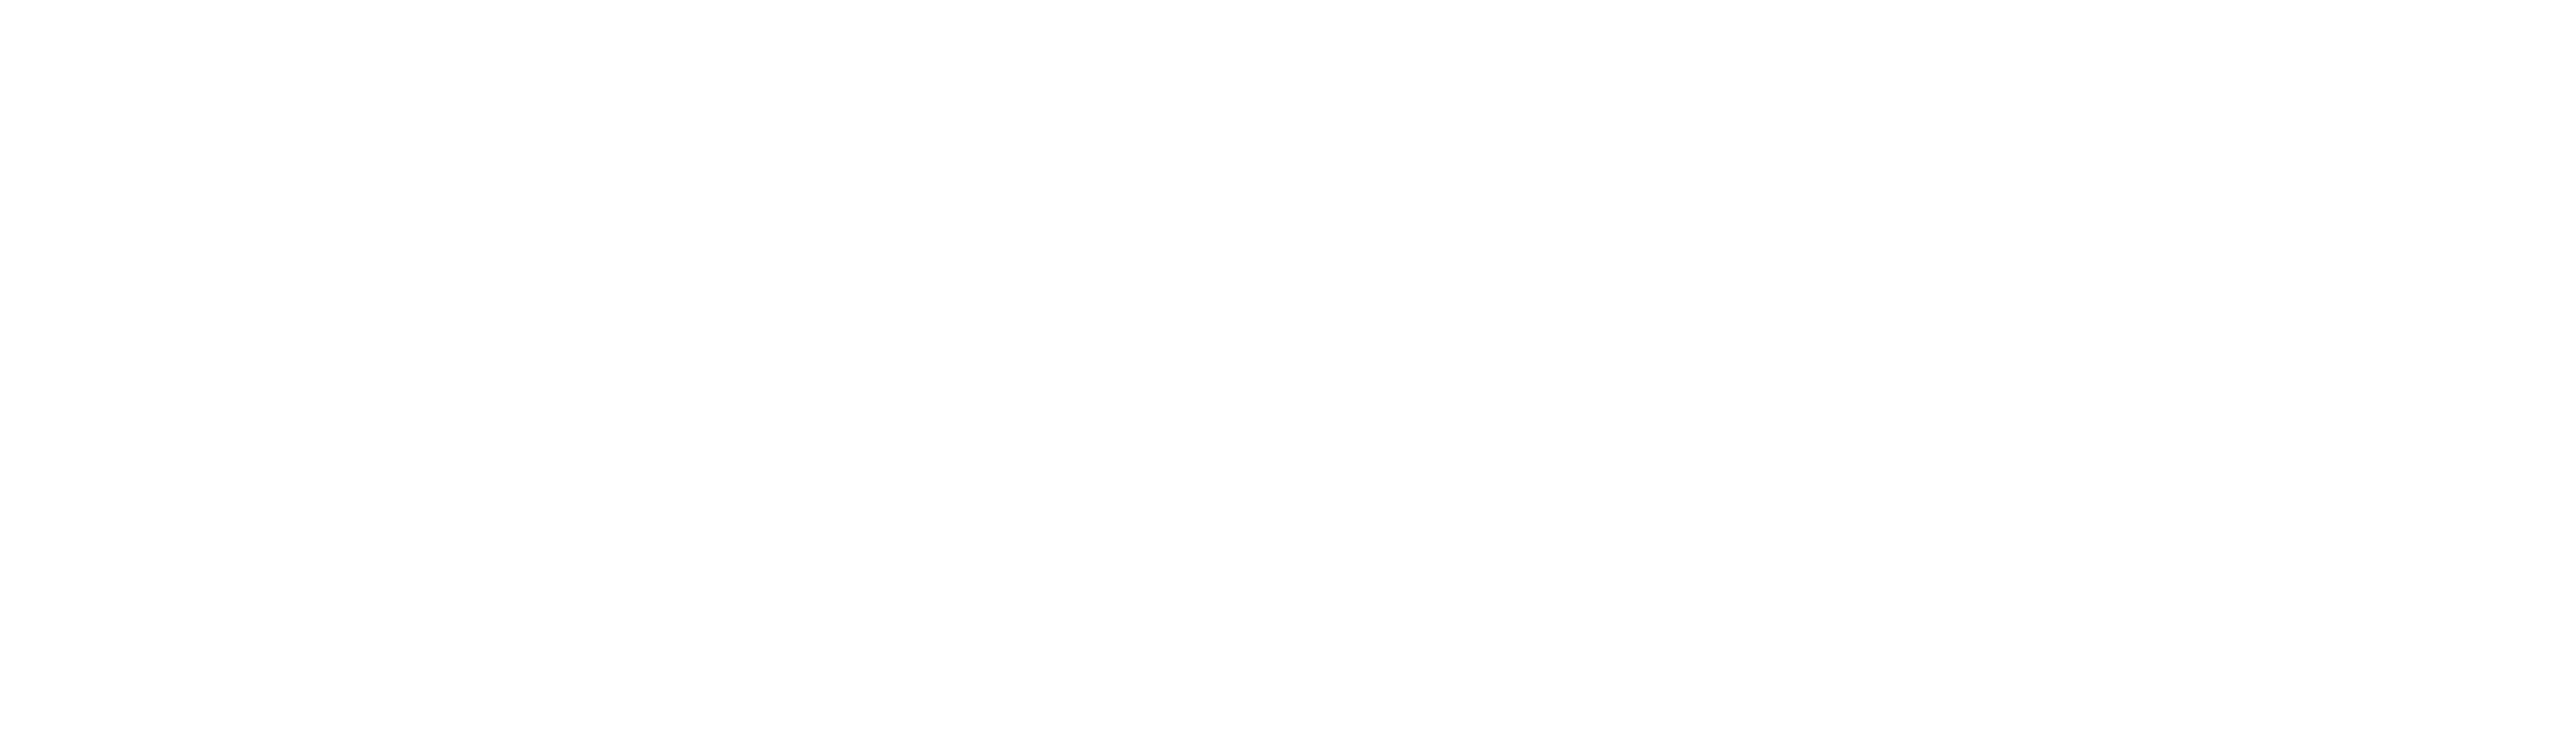

a370_SN_sourceplane/alfa_fits/Spectra_bin_91_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


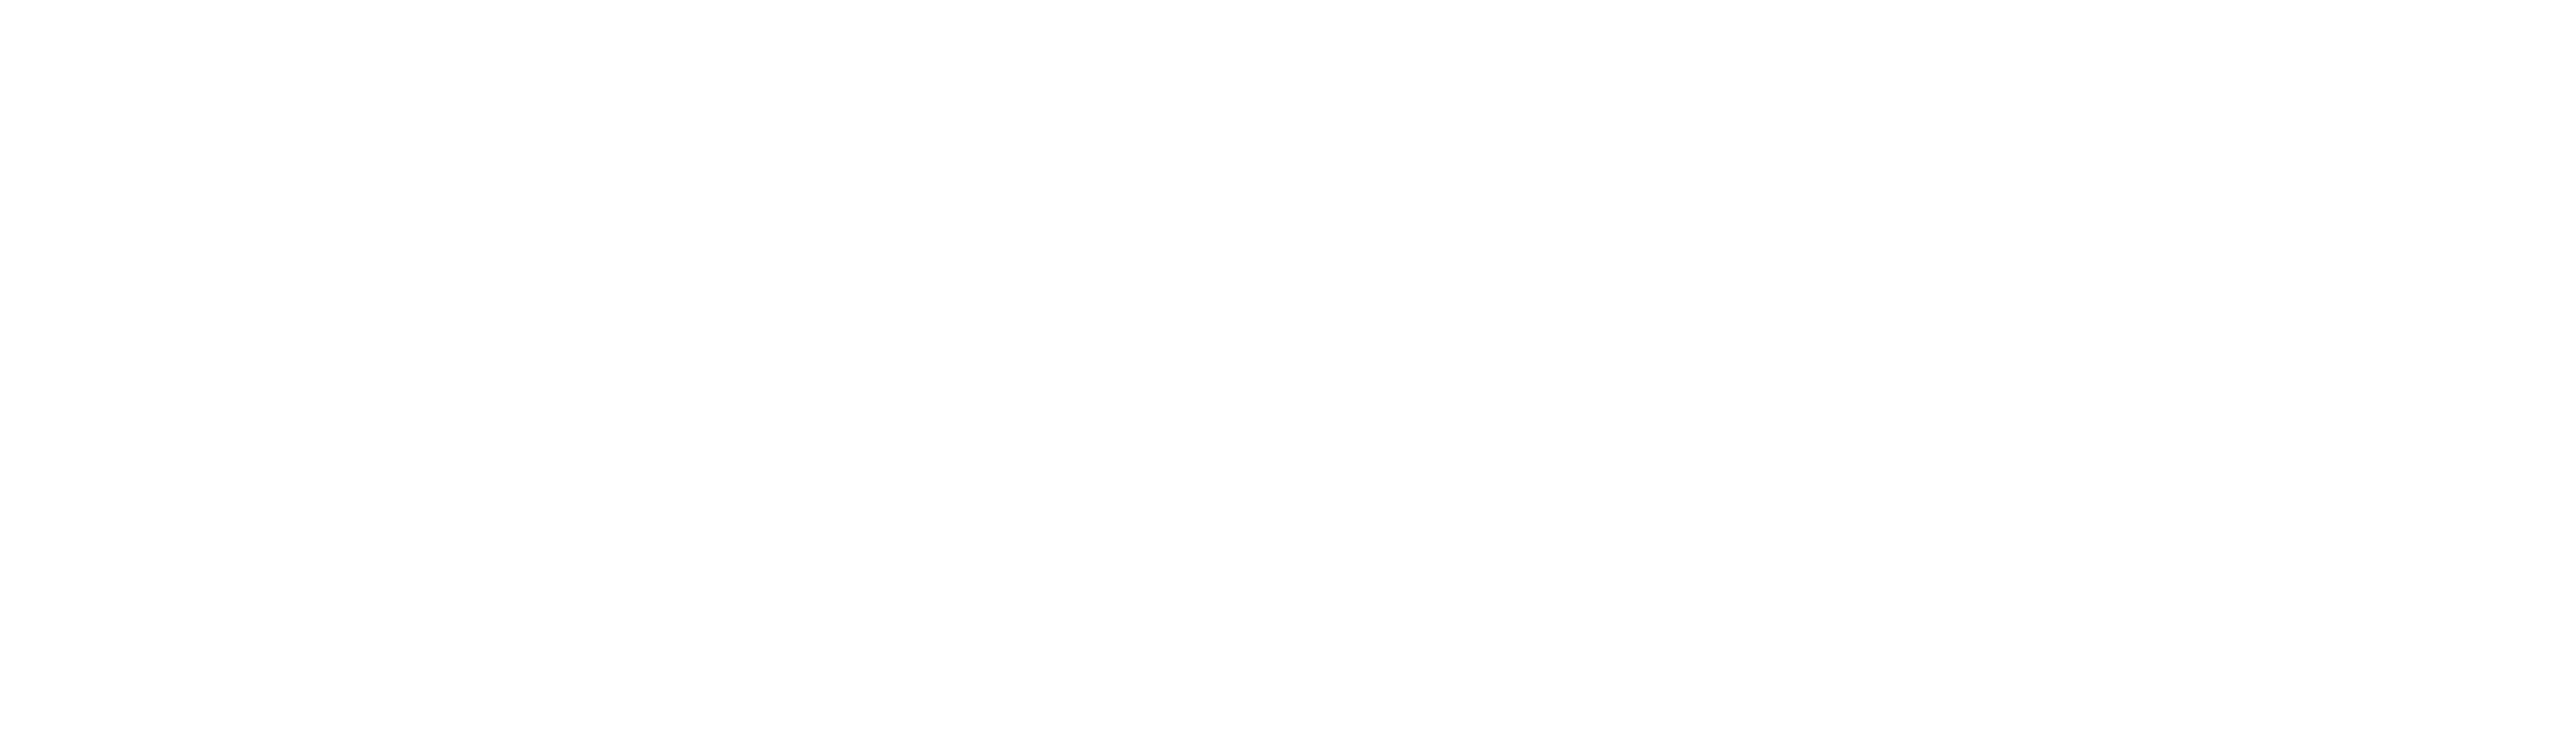

a370_SN_sourceplane/alfa_fits/Spectra_bin_92_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


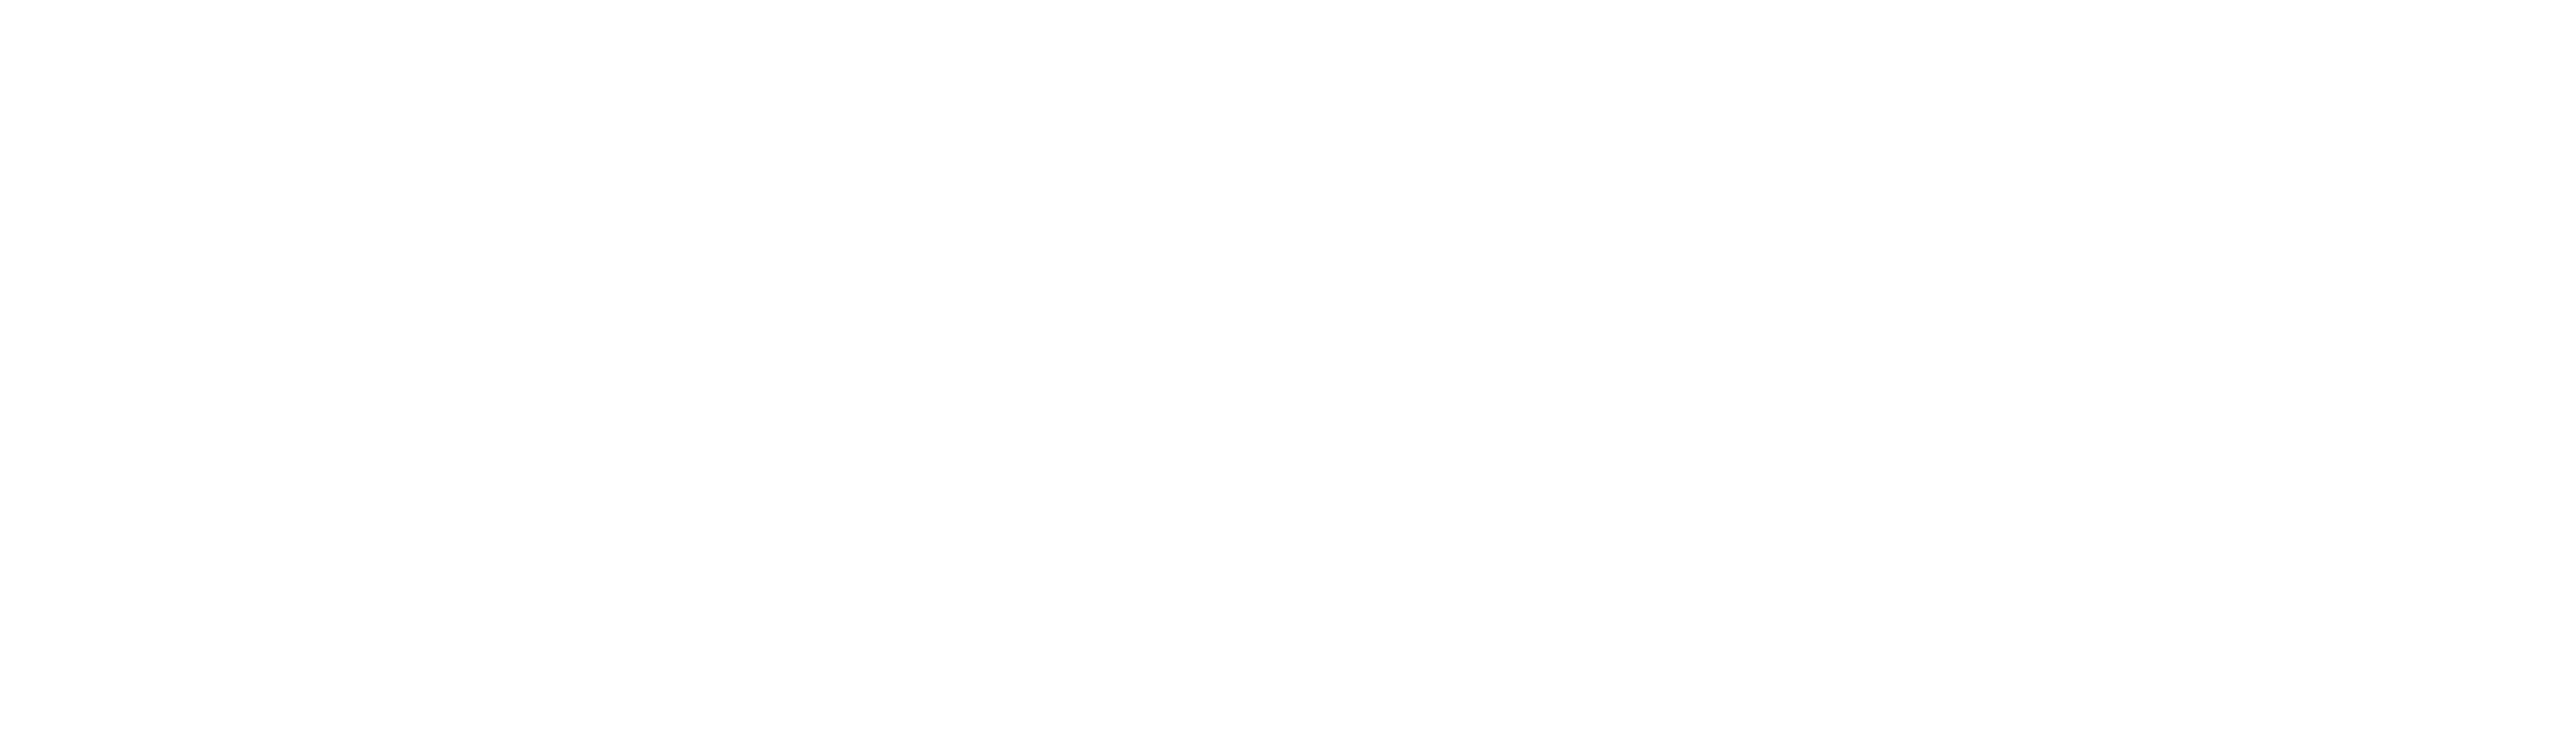

a370_SN_sourceplane/alfa_fits/Spectra_bin_93_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


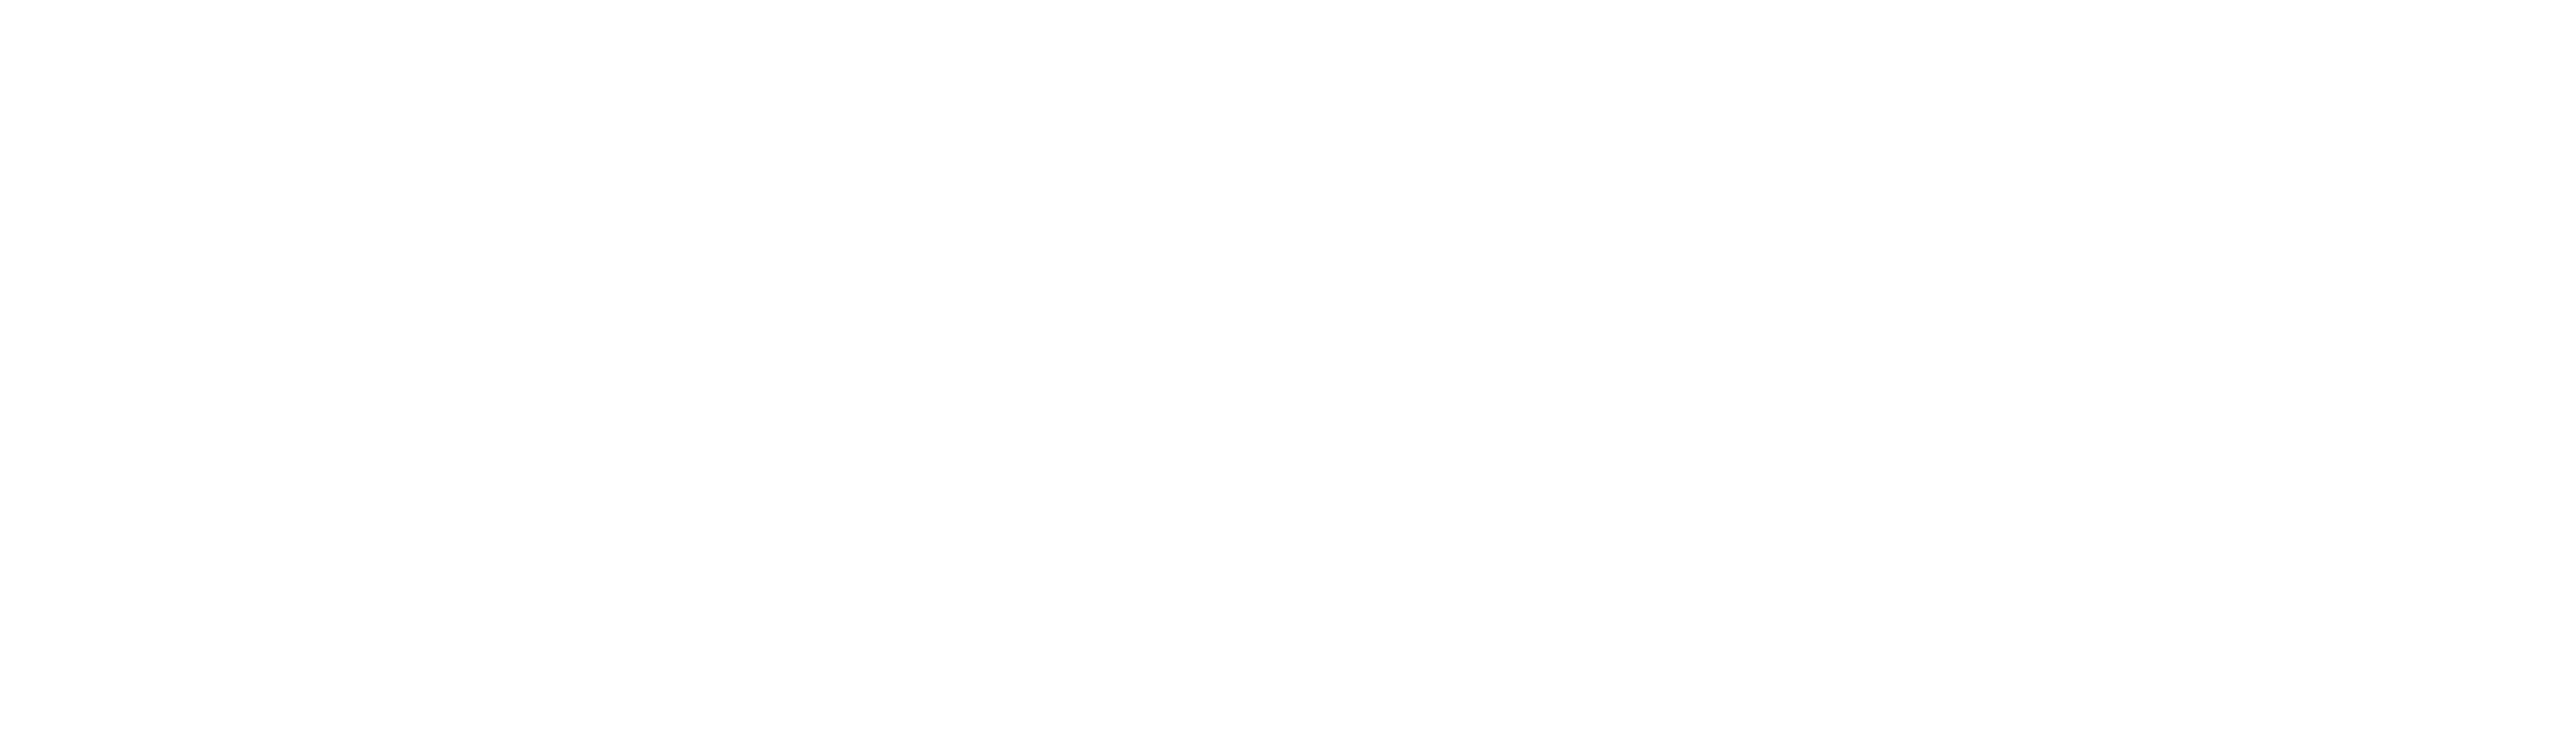

a370_SN_sourceplane/alfa_fits/Spectra_bin_94_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


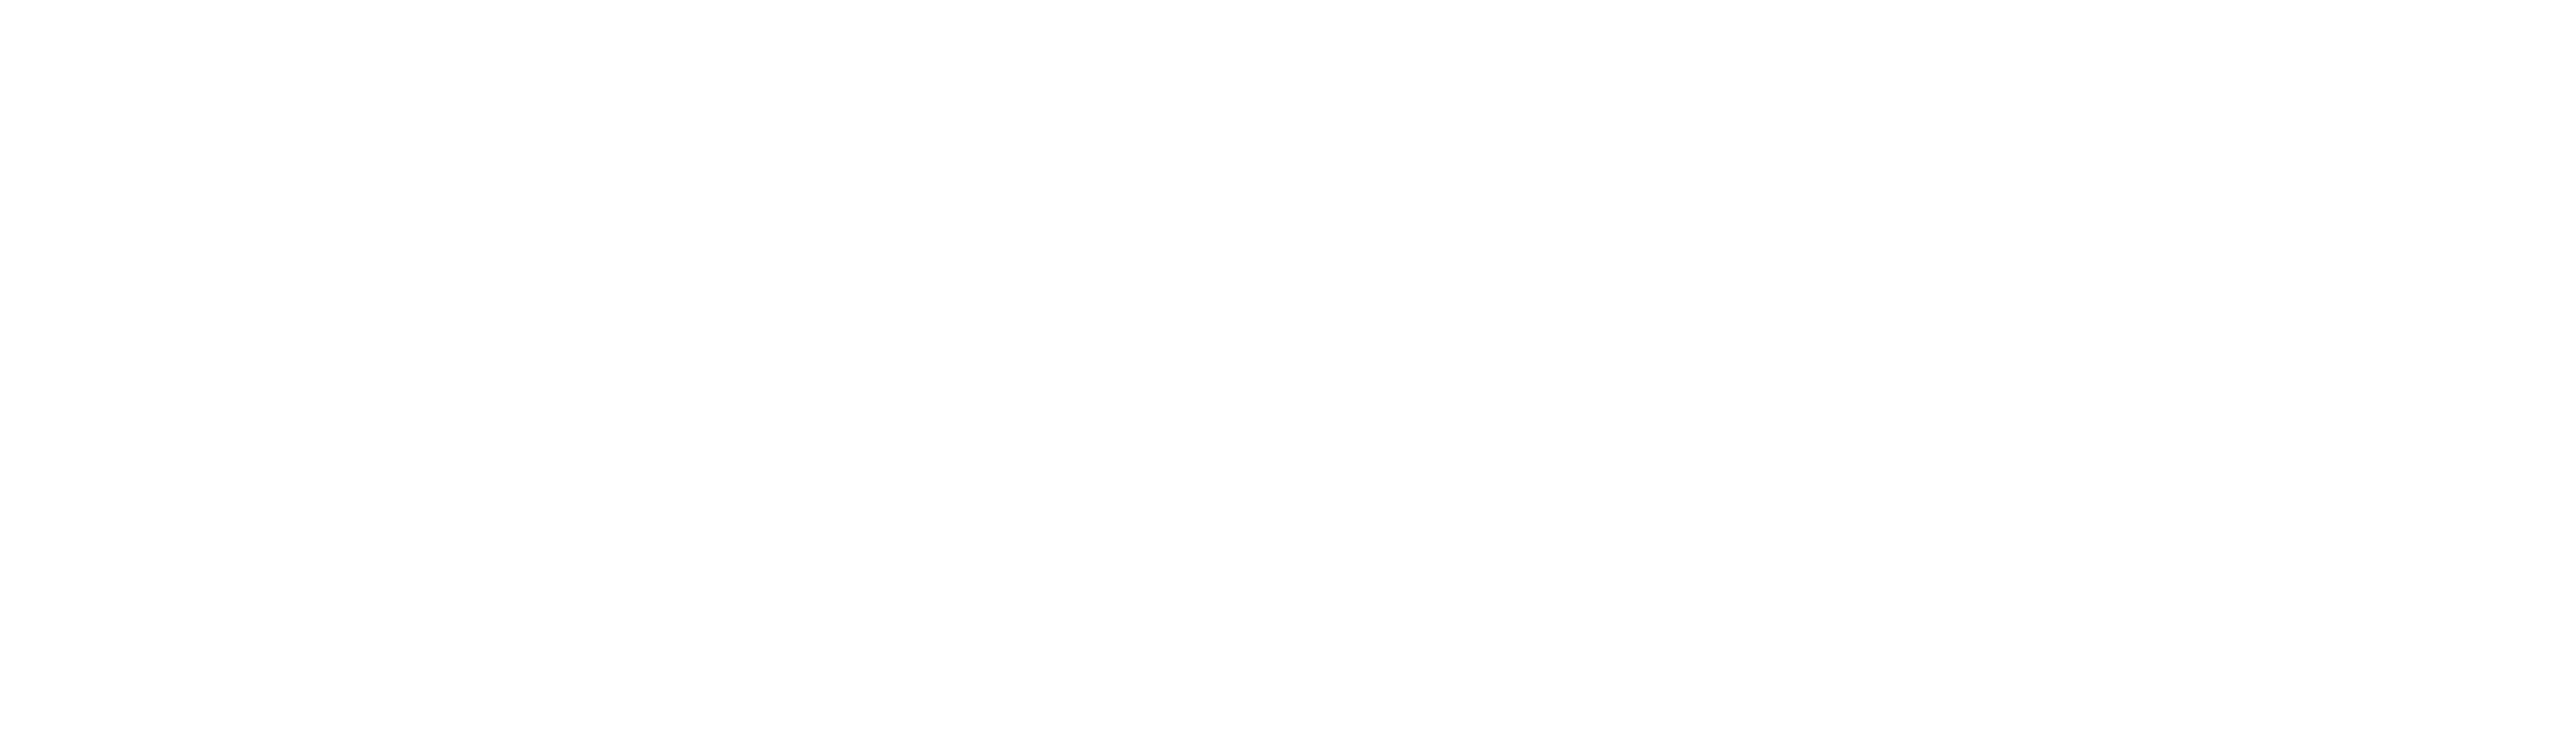

a370_SN_sourceplane/alfa_fits/Spectra_bin_95_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


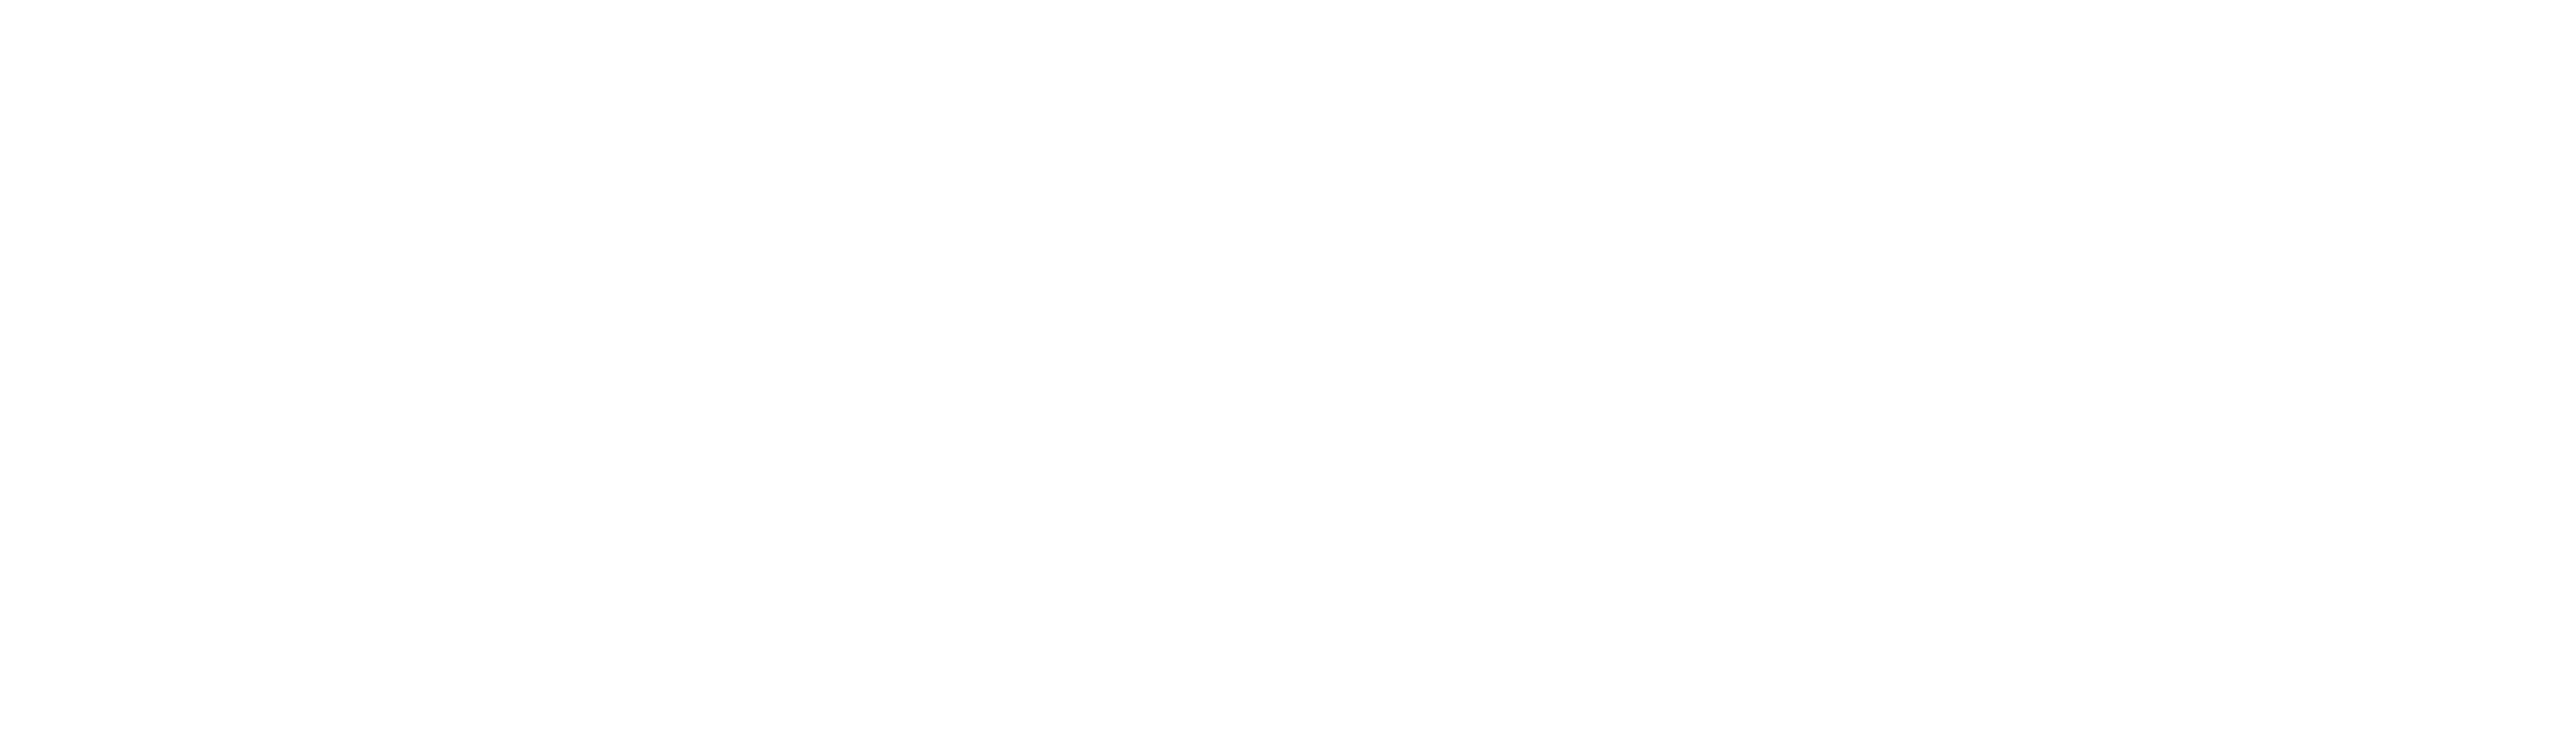

a370_SN_sourceplane/alfa_fits/Spectra_bin_9_continuum_subtracted.fits_fit


<IPython.core.display.Javascript object>


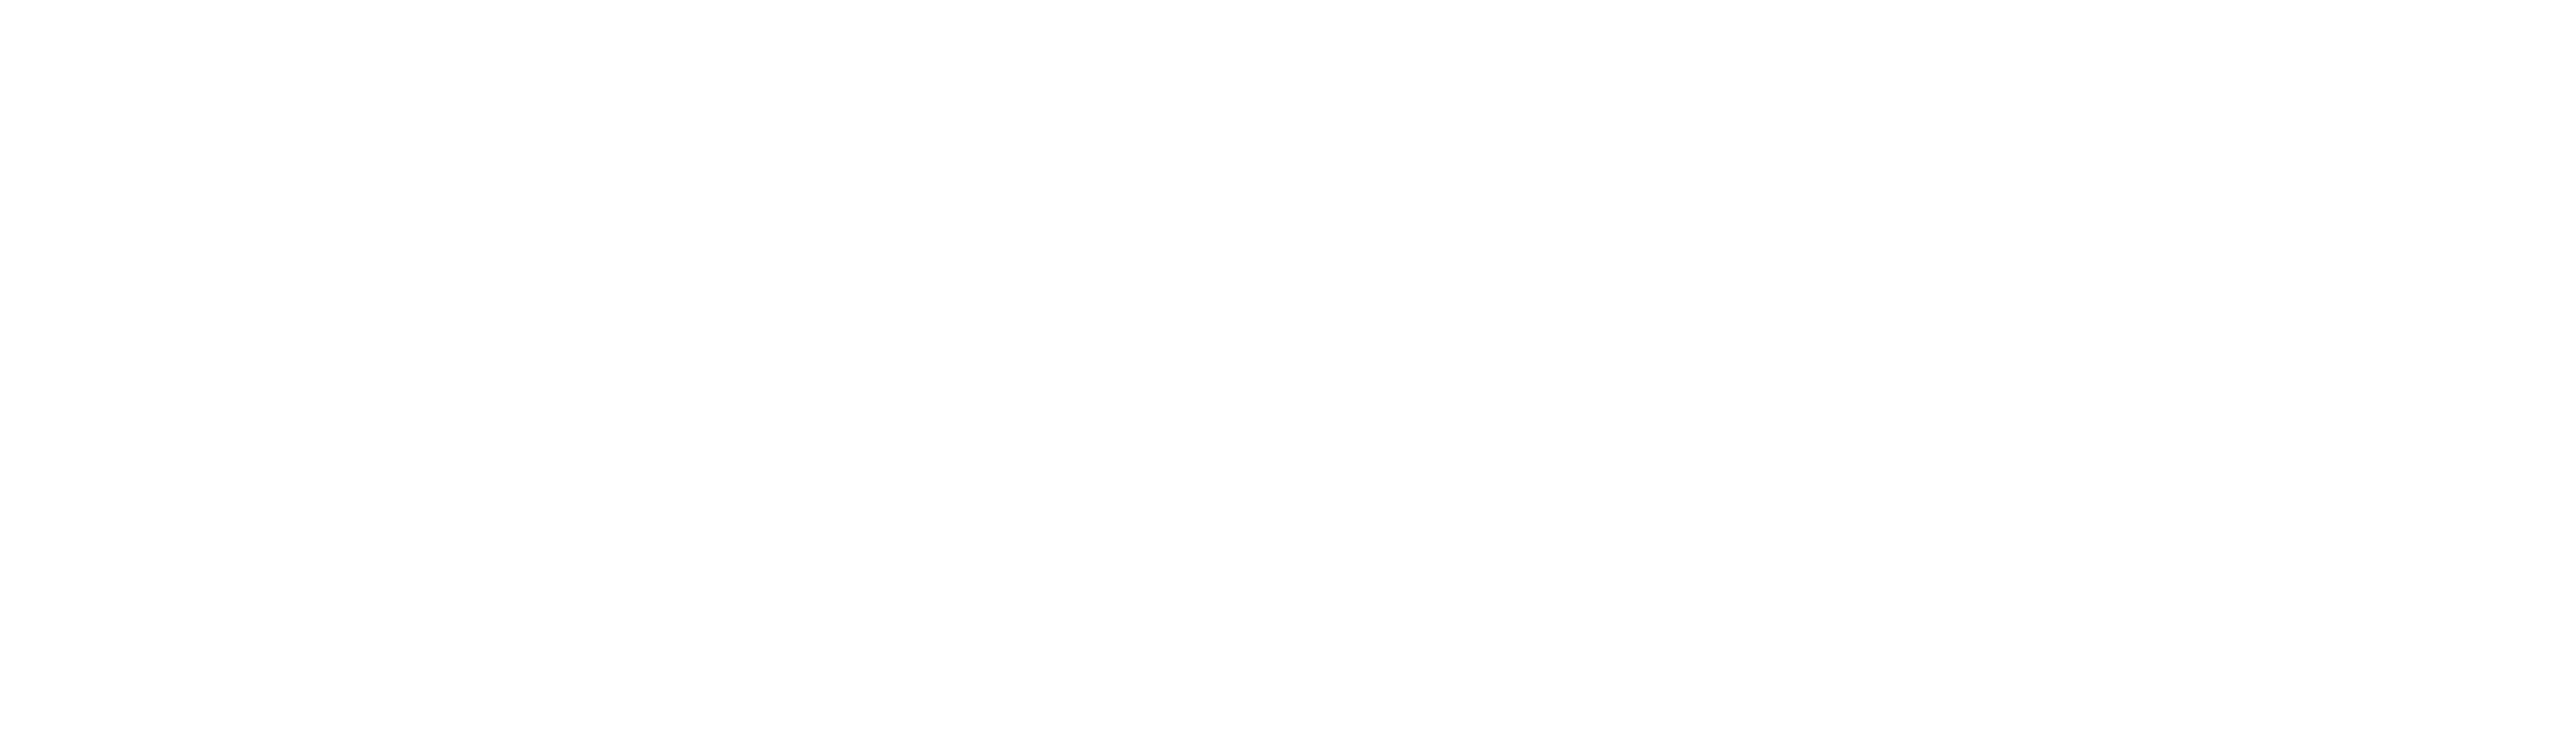

In [29]:
fits_list = glob.glob('a370_SN_sourceplane/alfa_fits/Spectra_bin_*_continuum_subtracted.fits_fit')
muse = fits.open('../MeasureLines/A370_ContSub_flux_common_OII3726.fits')

for f in fits_list:
    print f

    fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[3,1]},figsize=(14,4))
    fig.subplots_adjust(left=0.05,right=0.95)
    ax1 = ax[0].twinx()

    lbd, data, fit,unc = np.loadtxt(f,unpack=True,usecols=(0,1,2,7))
    im_name = f.replace('alfa_fits/Spectra','ImagePlaneImages/ImagePlane').replace('continuum_subtracted.fits_fit','convolved.fits')
    sp_continuum = f.replace('alfa_fits/','SpectraConvolved/').replace('continuum_subtracted.fits_fit','convolved.fits')
    
    im = fits.getdata(im_name)
    continuum = fits.getdata(sp_continuum)/1000
    
    fig.suptitle(f.replace('a370_grids/alfa_fits/Spectra_grid_A370_','Bin ').replace('_continuum_subtracted.fits_fit',''))
    ax[0].plot(lbd[1200:3200],continuum[1200:3200],color='g',alpha=0.3)
    ax[0].plot(lbd[1200:3200],data[1200:3200],color='k')
    ax[0].plot(lbd[1200:3200],fit[1200:3200],color='r',linestyle='--')
    
    ax[1].imshow(im,origin='lower',cmap=plt.cm.Blues)
    ax[1].axis('off')
    ax[1].contour(muse[0].data,levels=[0.03,0.05])

    fig.savefig(f.replace('.fits_fit','.pdf'),format='pdf')
    plt.close()


# Calculate metallicity from the emission lines

In [30]:
from met_and_ext_mcmc import make_obs_file,fit_metallicity_and_extinction

def prepare_array(f):
    
    lbd, f, err = np.genfromtxt(f,unpack=True,usecols=(1,2,3))
    lbd = list(lbd)

    flx = []
    unc = []

    for l in [3726.03, 3728.82, 4340.47, 4861.33, 4958.91, 5006.84]:
        try:
            flx.append(f[lbd.index(l)])
            unc.append(err[lbd.index(l)])
        except ValueError:
            flx.append(np.nan)
            unc.append(np.nan)
    
    # Put in in the correct order:
             #'[OII]3727',    '[NeIII]','H7',    'Hd',  'Hg',        'Hb',  '[OIII]4959','[OIII]5007','Ha','[NII]6584'
    data = [flx[0]+flx[1], np.nan, np.nan, np.nan, flx[2], flx[3], flx[4],   flx[5], np.nan, np.nan]
    err  = [unc[0]+unc[1], np.nan, np.nan, np.nan, unc[2], unc[3], unc[4],   unc[5], np.nan, np.nan]

    return data, err

In [36]:
## Prepare input files
for f in glob.glob('a370_SN_sourceplane/alfa_fits/Spectra_bin_*_continuum_subtracted.fits_lines'):
    flux, uncertainties = prepare_array(f)
    make_obs_file(flux,uncertainties,f.replace('_continuum_subtracted.fits_lines','.obs'))

In [37]:
## Run mcmc code
met = []
ext = []
emet = []
eext = []

spectra = []
for f in glob.glob('a370_SN_sourceplane/alfa_fits/*obs'):
    print(f)
    spectra.append(f)
    try:
        mid_m,err_m,mid_t,err_t,samples= fit_metallicity_and_extinction(f,t_range=(0,2),m_range=(8,9),include=[0,1,2,3,6,11],
                                                                             extincion_law='Calzetti',nsteps=100,save=False,plot_title=None)
        
        met.append(mid_m)
        emet.append(err_m)
        ext.append(mid_t)
        eext.append(err_t)
    except ValueError:
        print('Did not fit %s'%f)
        met.append(np.nan)
        ext.append(np.nan)
        emet.append(np.nan)
        eext.append(np.nan)

a370_SN_sourceplane/alfa_fits/Spectra_bin_0.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.84$^{+0.02}_{-0.02}$
Extinction : 0.11$^{+0.07}_{-0.06}$
8.84$\pm$0.02
0.11$\pm$0.06
a370_SN_sourceplane/alfa_fits/Spectra_bin_1.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.80$^{+0.03}_{-0.03}$
Extinction : 0.05$^{+0.05}_{-0.03}$
8.80$\pm$0.03
0.05$\pm$0.04
a370_SN_sourceplane/alfa_fits/Spectra_bin_10.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.51$^{+0.33}_{-0.34}$
Extinction : 1.07$^{+0.67}_{-0.70}$
8.51$\pm$0.34
1.07$\pm$0.68
a370_SN_sourceplane/alfa_fits/Spectra_bin_11.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.91$^{+0.04}_{-0.04}$
Extinction : 0.28$^{+0.10}_{-0.10}$
8.91$\pm$0.04
0.28$\pm$0.10
a370_SN_sourceplane/alfa_fits/Spectra_bin_12.obs
MCMCing for 100 steps
 0.0%
50.0%
Metallicity : 8.88$^{+0.03}_{-0.03}$
Extinction : 0.21$^{+0.09}_{-0.08}$
8.88$\pm$0.03
0.21$\pm$0.08
a370_SN_sourceplane/alfa_fits/Spectra_bin_13.obs
MCMCing for 100 steps
 0.0%
50.0%

In [41]:
from astropy.table import Table

clean_file_name = [z.replace('a370_SN_sourceplane/alfa_fits/Spectra_bin_','').replace('.obs','') for z in spectra]

t = Table(data = (clean_file_name,spectra,met,emet,ext,ext),names=('bin','file','met','met_unc','ext','ext_unc'))
t.sort('bin')
t.write('metallicity_SN_sourceplane.dat',format='ascii.fixed_width_two_line')
t.show_in_notebook()

## Reconstruct images

<IPython.core.display.Javascript object>


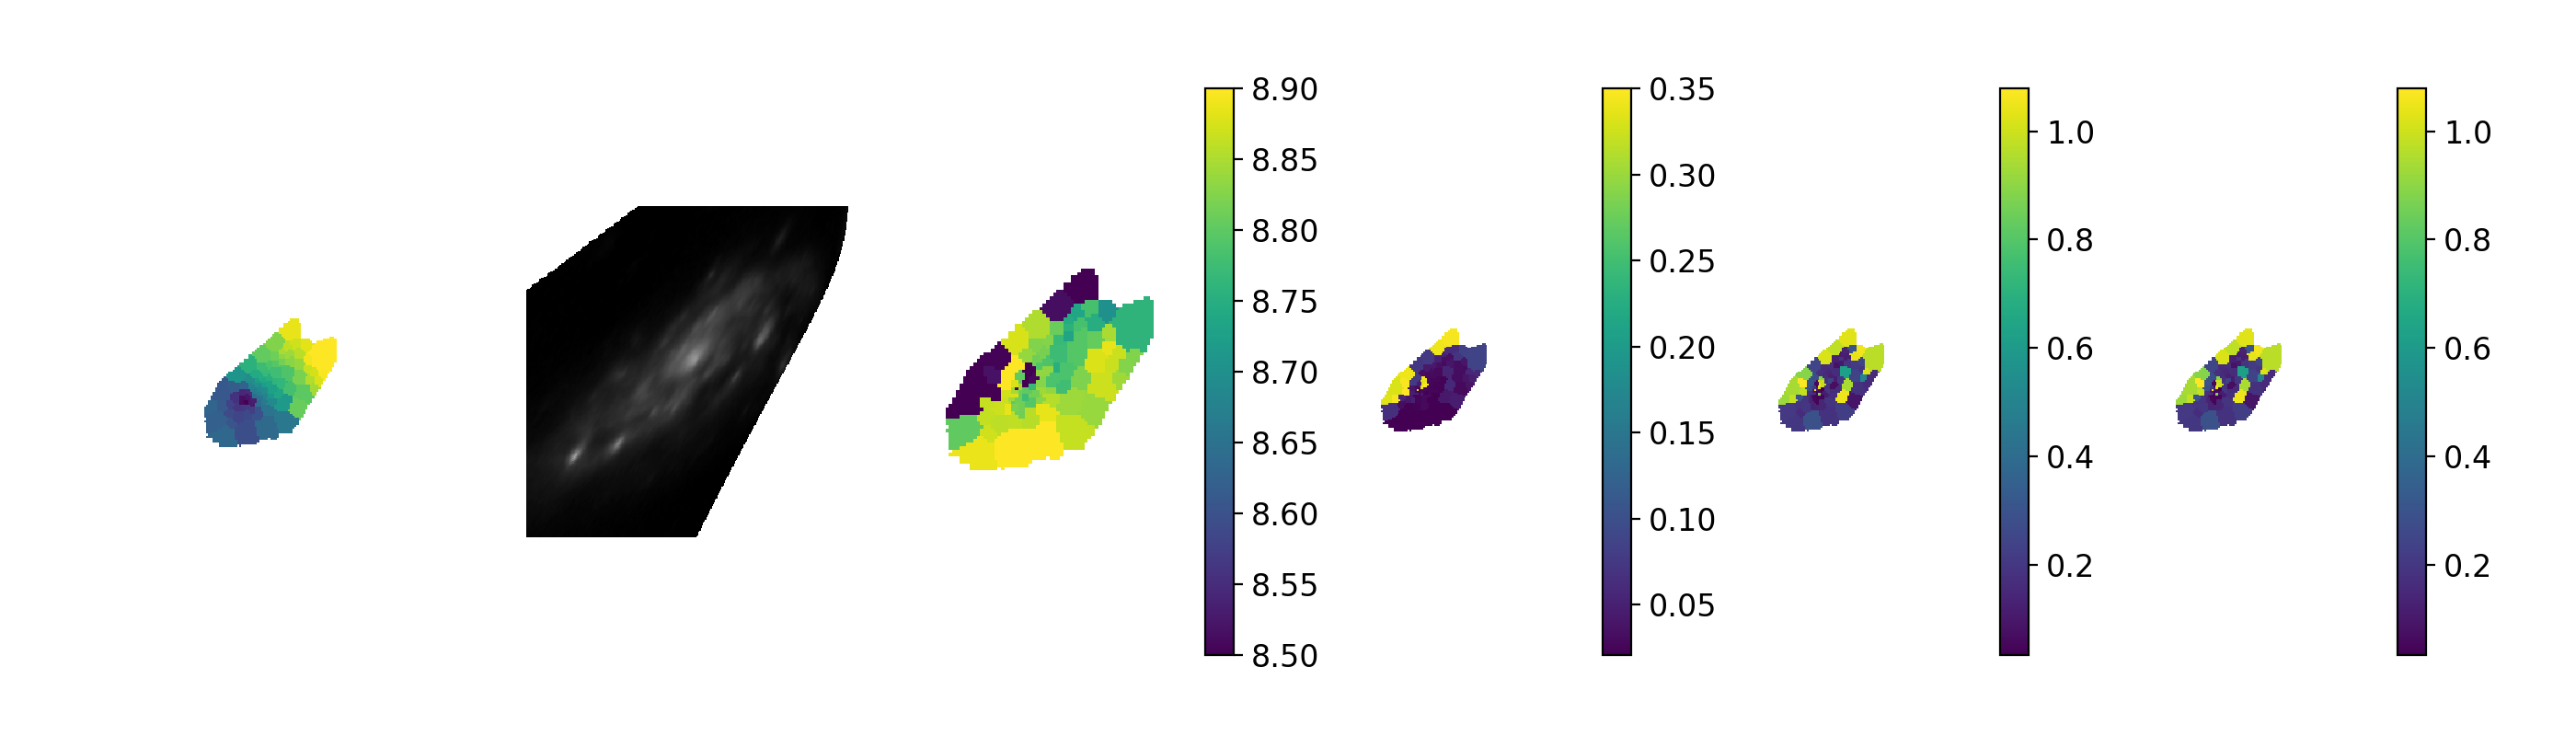

In [44]:
full_grid = fits.getdata('a370_SN_sourceplane/lenstool_files/full_bins.fits')
im = fits.getdata('../Data/LensingModels/A370/SourcePlane_A370_F814w.fits')
header = fits.getheader('../Data/LensingModels/A370/SourcePlane_A370_F814w.fits')
wcs_im = wcs.WCS(header)
im[np.where(im==0)] = np.nan
cut_im = Cutout2D(data=im, position=(260,265),size=300,wcs=wcs_im)


met_map = np.zeros_like(full_grid)
met_unc_map = np.zeros_like(full_grid)
ext_map = np.zeros_like(full_grid)
ext_unc_map = np.zeros_like(full_grid)
met_map[:,:] = np.nan
met_unc_map[:,:] = np.nan
ext_map[:,:] = np.nan
ext_unc_map[:,:] = np.nan


for d in t:
    bins = np.where(full_grid == float(d['bin']))
    met_map[bins]  = d['met']
    met_unc_map[bins] = d['met_unc']
    ext_map[bins]  = d['ext']
    ext_unc_map[bins] = d['ext_unc']

fig, ax = plt.subplots(1,6,figsize=(14,4))
fig.subplots_adjust(left=0.05,right=0.95)
ax[0].imshow(full_grid,origin='lower')
ax[1].imshow(cut_im.data,origin='lower',cmap=plt.cm.Greys_r,vmin=0,vmax=0.15)

cax2 = ax[2].imshow(met_map,origin='lower',vmin=8.5,vmax=8.9)
cax3 = ax[3].imshow(met_unc_map,origin='lower')
cax4 = ax[4].imshow(ext_map,origin='lower')
cax5 = ax[5].imshow(ext_unc_map,origin='lower')
plt.colorbar(cax2,ax=ax[2])
plt.colorbar(cax3,ax=ax[3])
plt.colorbar(cax4,ax=ax[4])
plt.colorbar(cax5,ax=ax[5])

for x in ax:
    x.axis('off')